In [ ]:
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt
import keras
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from PIL import Image
%matplotlib inline 

In [73]:
# Having issues with data frames, trying from directories
os.mkdir("data/train/cat")
os.mkdir("data/train/dog")

files = os.listdir("data/raw/train/")
for file in files:
    if "cat" in file:
        os.rename(f"data/raw/train/{file}", f"data/train/cat/{file}")
    if "dog" in file:
        os.rename(f"data/raw/train/{file}", f"data/train/dog/{file}")

FileExistsError: [Errno 17] File exists: 'data/train/cat'

In [103]:
os.mkdir("data/validate/cat")
cat_files = os.listdir("data/train/cat")
i = 1
for file in cat_files:
        if i % 5 == 0:
            os.rename(f"data/train/cat/{file}", f"data/validate/cat/{file}")
            i = 1
        else:
            i = i + 1
            
os.mkdir("data/validate/dog")
dog_files = os.listdir("data/train/dog")
for file in dog_files:
        if i % 5 == 0:
            os.rename(f"data/train/dog/{file}", f"data/validate/dog/{file}")
            i = 1
        else:
            i = i + 1

In [166]:
train_dir = r'/Users/208623/Code/ccincotti3/ga/final_project/data/train'
validation_dir = r'/Users/208623/Code/ccincotti3/ga/final_project/data/validate'
# ImageDataGenerator will be used to split our data into a train and test (validation) sets

## Instantiate, we'll optimize this later.
# We're splitting the data here (similar to test train split.)
train_datagen = ImageDataGenerator(
    rescale=1./255., # rescale is done here to reduce our 0-255 RGB values to between 0-1 for better comp. time.
    shear_range=0.1,
    zoom_range=0.1,
#     rotation_range=40,
#     width_shift_range=0.1,
#     height_shift_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.0 
)

test_datagen = ImageDataGenerator(
    rescale=1./255.
)

batch_size=64
img_dim=224

train_data = train_datagen.flow_from_directory(
    directory=train_dir,
    batch_size=batch_size,
    target_size=(img_dim, img_dim),
    class_mode='binary',
)

validation_data = test_datagen.flow_from_directory(
    directory=validation_dir,
    batch_size=batch_size,
    class_mode='binary',
    target_size=(img_dim, img_dim),
)

# flow from directory here since there are no classes, so you just need images
test_data = test_datagen.flow_from_directory(
    directory=r"data/raw/test/",
    batch_size=batch_size,
    target_size=(img_dim, img_dim),
    classes=None,
    class_mode="binary"
)


Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.
Found 12500 images belonging to 1 classes.


In [152]:
from keras.models import Sequential
from keras.layers import Conv2D, Dense, Flatten, MaxPooling2D, Dropout

model = Sequential()
model.add(Conv2D(32, (3, 3), activation="relu", input_shape=(img_dim,img_dim, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))
model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model.add(Dropout(rate=0.5))
model.add(Dense(1, activation='sigmoid'))

In [153]:
from keras.optimizers import SGD
model.compile(
    optimizer=SGD(lr=.001, momentum=0.9),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [139]:
# multiplier = 100
# validation_data.n // (multiplier *batch_size)
history = model.fit_generator(
    train_data,
    validation_data=validation_data,
    validation_steps=len(validation_data),
    epochs=5,
    steps_per_epoch=len(train_data),
    verbose=1
)


Epoch 1/5
 - 1394s - loss: 0.6889 - accuracy: 0.5411 - val_loss: 0.6928 - val_accuracy: 0.6046
Epoch 2/5


KeyboardInterrupt: 

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [79]:
_, acc = model.evaluate_generator(validation_data, steps=10, verbose=0)
print('> %.3f' % (acc * 100.0))

> 48.906


In [80]:
test_images, test_labels = next(validation_data)
# test_labels = test_labels[:, 0] # 2d -> 1d

In [81]:
from sklearn.metrics import confusion_matrix
validation_preds = model.predict_generator(validation_data, steps=1)
validation_preds = np.argmax(validation_preds,axis=1)
cm = confusion_matrix(test_labels, validation_preds)
cm


ValueError: Classification metrics can't handle a mix of multilabel-indicator and binary targets

In [109]:
# Let's use the prediction generator

predictions = model.predict_generator(test_data, steps=len(test_data) // batch_size)
# predictions

[0.55982393 0.44017604]
0


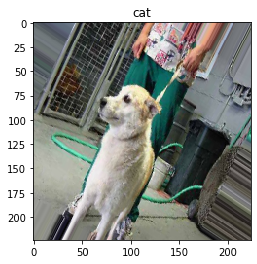

None
[0.55910444 0.44089556]
0


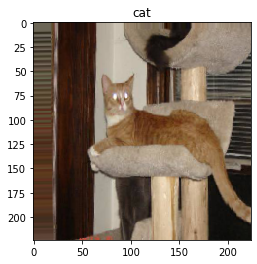

None
[0.47404388 0.5259561 ]
0


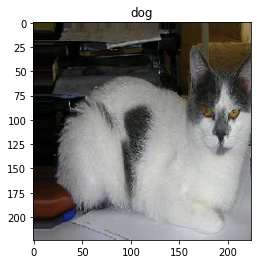

None
[0.5069209  0.49307907]
0


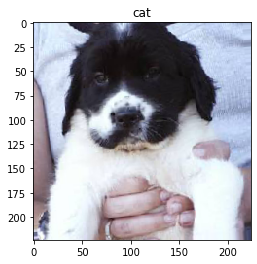

None
[0.54244053 0.45755947]
0


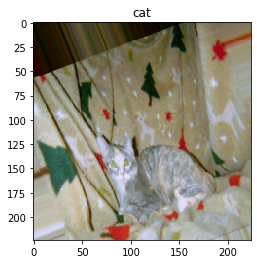

None


In [110]:
def plot(prediction):
    print(prediction[0])
    prediction_class = np.argmax(prediction[0][0])
    print(prediction_class)

    title = "cat" if prediction[0][0] >= 0.5 else "dog"
    plt.imshow(prediction[1],aspect='equal')
    plt.title(title)
    plt.show();
show_predictions = map(plot, list(zip(predictions,test_images)))
print(next(show_predictions))
print(next(show_predictions))
print(next(show_predictions))
print(next(show_predictions))
print(next(show_predictions))

## With VGG16 model

In [167]:
from keras.applications.vgg16 import VGG16
vgg16 = VGG16()

In [168]:
vgg16.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [169]:
# Alright so that last Dense layer we don't really want because it's 1000 categories.
# Also to note that this is type keras.engine.training.Model
type(vgg16)

keras.engine.training.Model

In [170]:
# Let's add this to a Sequential model so we can edit
model = Sequential()
for l in vgg16.layers[:-1]:
    model.add(l)

In [171]:
model.summary()

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)     

In [172]:
# we don't want this to train and have updated weights, which is default in vgg16
for l in model.layers:
    l.trainable = False

In [173]:
model.add(Dense(1, activation='sigmoid'))
model.layers[0].input_shape = (224, 224, 3) # Keras bug fix, otherwise you can't save / load file

In [174]:
from keras.optimizers import SGD
model.compile(
    optimizer=SGD(lr=.001, momentum=0.9),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [175]:
model.summary()

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)     

In [303]:
history = model.fit_generator(
    train_data,
    validation_data=validation_data,
    validation_steps=len(validation_data),
    epochs=5,
    steps_per_epoch=len(train_data),
    verbose=1
)


Epoch 1/5


KeyboardInterrupt: 

In [183]:
test_images, test_labels = next(test_data)

In [193]:
preds = model.predict_on_batch(test_images)

In [196]:
# predictions = model.predict_generator(test_data, steps=10)
def plot(prediction):
    print(prediction[0])
    prediction_class = np.argmax(prediction[0][0])
    print(prediction_class)

    title = "cat" if prediction[0][0] <= 0.5 else "dog"
    plt.imshow(prediction[1],aspect='equal')
    plt.title(title)
    plt.show();
show_predictions = map(plot, list(zip(preds,test_images)))

[0.02541131]
0


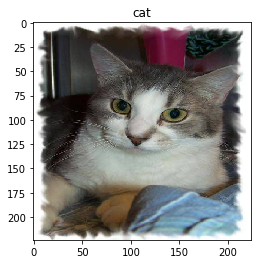

None
[0.07551458]
0


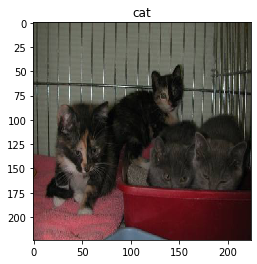

None
[0.569162]
0


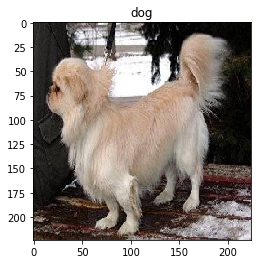

None
[0.30591395]
0


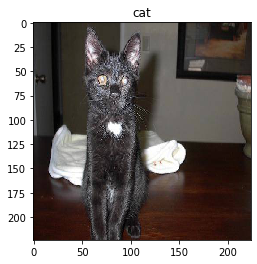

None
[0.06305811]
0


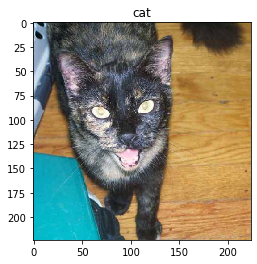

None


In [199]:
print(next(show_predictions))
print(next(show_predictions))
print(next(show_predictions))
print(next(show_predictions))
print(next(show_predictions))

In [218]:
# # serialize model to JSON
# model_json = model.to_json()
# with open("model.json", "w") as json_file:
#     json_file.write(model_json)
# # serialize weights to HDF5
# model.save_weights("model.h5")
# print("Saved model to disk")

Saved model to disk


In [220]:
from keras.models import save_model
m = save_model(model, "model_act_again.model")

In [222]:
from keras.models import load_model, model_from_json
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")

Loaded model from disk


In [224]:
preds_loaded = loaded_model.predict_on_batch(test_images)

[0.40135777]
0


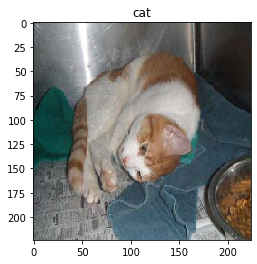

None
[0.78084147]
0


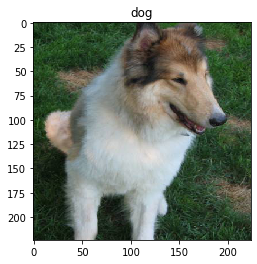

None
[0.9875937]
0


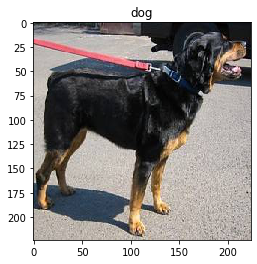

None
[0.7436962]
0


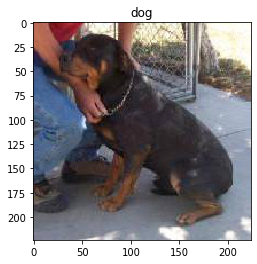

None
[0.6735975]
0


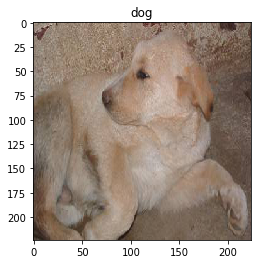

None


In [226]:
show_predictions_loaded = map(plot, list(zip(preds_loaded,test_images)))
# predictions = model.predict_generator(test_data, steps=10)
print(next(show_predictions))
print(next(show_predictions))
print(next(show_predictions))
print(next(show_predictions))
print(next(show_predictions))

In [221]:
mo = load_model("model_act_again.model", compile=False, custom_objects=None)

ValueError: You are trying to load a weight file containing 16 layers into a model with 0 layers

In [217]:
model.summary()

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)     

In [302]:
# CURL example
import json
dog = "/9j/4QlQaHR0cDovL25zLmFkb2JlLmNvbS94YXAvMS4wLwA8P3hwYWNrZXQgYmVnaW49Iu+7vyIgaWQ9Ilc1TTBNcENlaGlIenJlU3pOVGN6a2M5ZCI/PiA8eDp4bXBtZXRhIHhtbG5zOng9ImFkb2JlOm5zOm1ldGEvIiB4OnhtcHRrPSJBZG9iZSBYTVAgQ29yZSA1LjYtYzEzOCA3OS4xNTk4MjQsIDIwMTYvMDkvMTQtMDE6MDk6MDEgICAgICAgICI+IDxyZGY6UkRGIHhtbG5zOnJkZj0iaHR0cDovL3d3dy53My5vcmcvMTk5OS8wMi8yMi1yZGYtc3ludGF4LW5zIyI+IDxyZGY6RGVzY3JpcHRpb24gcmRmOmFib3V0PSIiLz4gPC9yZGY6UkRGPiA8L3g6eG1wbWV0YT4gICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICA8P3hwYWNrZXQgZW5kPSJ3Ij8+/+0ALFBob3Rvc2hvcCAzLjAAOEJJTQQlAAAAAAAQ1B2M2Y8AsgTpgAmY7PhCfv/bAIQACgcHBwgHCggICg4JCAkOEQ0KCg0RFBAQERAQFBMPERAQEQ8TExcXGRcXEx4eICAeHiwrKyssMTExMTExMTExMQELCQkLDAsNCwsNEQ4ODhEUDg4ODhQYEBAREBAYHhYTExMTFh4bHRkZGR0bISEeHiEhKSkoKSkxMTExMTExMTEx/90ABAAu/+4ADkFkb2JlAGTAAAAAAf/AABEIAeUC2QMAIgABEQECEQH/xAChAAEAAgMBAQEAAAAAAAAAAAAAAwQBAgUGBwgBAQADAQEAAAAAAAAAAAAAAAABAgMEBRAAAgECBAQEAwcEAQMDAwUAAAECAxEEEiExBUFRYRMicYEGMpEjQlKhscHRFGLh8DMHcoIVJPEWQ2MlNFOy0hEBAQACAgEDAgUDAgcBAAAAAAECEQMhMRJBUQRxEyJhgZEUMqGxwQUzQlJi4fAj/9oADAMAAAERAhEAPwD7MAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAP/9D7MAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAP/9H7MAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAP/9L7MAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAP/9P7MAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAP/9T7MAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAP/9X7MAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAYBUxfEMPh4yvUi5K/lv/GxGWUxltupE443K6k3at5kDy1Lj7r1ZwopuS69S/R4lWpwWaXi36/oc2P1mG9ZSz9W9+kzk6sv6O0Dlx4tL70U1+hmpxhQjm8PRK7u7abmn9Vw+fV/iq/03L49P+XTuLnHj8Q0WlJ0JqL53RiXH09aVBtL5szs1fZaXH9Vw6365/k/pubx6P8x2Qclcdp2V6Ms0tLJqxpV4tVcmo2itrLVkZfV8Mm/Vv7Qn03Lbr06+7sXM3PM1sZiJVE3KUmnfsuxHX+I8Th6ck0siXmqfeXoimH13HlbLLPj9V8vo85rVleolUhF2b16GVJPY8phOK1K68WTtm1u9W+ljoUeK2dm1J9b3Iw+sxuWspqexn9JlJ1du4ZKWC4rgMbeNCvCdWLtOle04tcnB6lw65Ze45rLOr0yDAAyAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAP/W+zAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAR160KFKVWo7QgrsW67pJvqN7nD4r8V8PwEvCpp4qu7+WDSgn3m9Pocri3xJVlGauoUnooJ6/Vas8RxDGVJVlS18WWyXJ/yc/4/qusPHzXRPp/TN5+fif7vUV/iTi/Ea/hxqeDh9nGimr+s3qMTXVDB+DGKVSekVa7bfN5fzOPgp5IKF7SestElfojpUqdOUoTcpzf3YLV/+KlY5efktuturh45jPCzgKKoUYqcrzWre7T59y08RKWkdUt2tPceA8ic45Vro0s3v0M0aKlbTXlo/wAzly3bpvjrW0+HzOKzPV8/3LFRUXG04uWVuzb007GsKSUYx100SJpReWWWzv17l8cetM7l25+IxLV1GEY8kuevLsYwfiKHixSeezknz5X+hHisNNVuspaX6uWmvsXsPhpJJSadtffsRjLavlZMZ+qWFSMo+enFrm0iviKb+am7dV0X+S74a0VrdF+5WqU73y+jfJv+S2eN0phlN9KrqTcXG2VLey/I52PpKcZSi7SX4nuuy0+rOjlzPRa7s1lhk1ezWXVOyf0M5te6cfhdWUE6SjmUdY20uv7V0L1fERUG2mnbW3fqipjKLu6sfEp173jVlo3b7tuhRrY+dajm1VSGkk91p2Jvk04/G3UVdYmhUcG1pVTs010luRcP+PviXATyLHuvCGmSulUi+2ZrN+ZnFYhVqcoyblKV9IW0e1nc8nUnKNeWb5lK2qt+R28GeWtb8OXmwm968vtnAP8AqJwziEI0+IJYHEuyzO7pSb6S+7r1PXxlGUVKLUoy1Uk7pr1Pzrw+vCbyp5J7ev8AJ7v4f4/isFCFpydO1nF3lGy/t5exp/Vem6znXzGf9N6pvC6vxX1AycjA/EGFxPhwn9nUqtRi94uT2V+VzrHRhyY5zeN3HPnhlhdZTTIALKgAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAD/9f7MAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAYAHlviriTzf0dN2jTtKrra8n8sT085xhCU5O0Yptvsj5lxbGVMTi6tdqyqSb0+iRh9TlrGYzzl/o6PpcN5XK+MZ/lTqqUHKpUtLS8bayv11ObhKEpVXiJ/NJt2k/omy7UzaRd22tW7tldKq5KFNJeI8sI7JX6LojDxNbdHm70u4ONSpGdRK99ILldno+GQd086lkWWVkkn2uuh5jh2OeMxVenhmo4Dh78GFTfNU+84L7zb+h63CUFGleWkIaPvLoc+e/VP5azWv0S15wdrbO1opbiU40WoybcnovfkytXqVqkZVaaXhXtGdRtK66J2ueX4t8VSp/8At8NmjUjpKfVX1aT23EwuV6LZJ291RhUc901vbp2LCbjaLsmr3PMfCGOq1aWerWlUbe02tj0VWvHMoreS1TJs9M+1U7t/ZWxFROtB809CeE2klz/QpyUp14yeiTv6crFqFWKrNPZbfoZY7338tcvEk9omc6jtra7t3KssQk8s/K76J7nC+IuJ4jDxnKnOVOKVoOFrrre5w+HfFlbMqOKfiub8jVotRezben1NfRllNxnLJdV7mrksp3frfd9DMZSS8z15W6nNwfEaGJatpd6Nt8u70L8KkL5aiySf3d1bqRrtO+muKwyqU/s5ypyvuv1PHY+lXo1ajnPO4u/iJ2cVybXTke2bUf8At3Ul1PL/ABM1hMtaUb0ZNylfS8XpNKW2m9itnfSZXkcWn4yjCyUravRPt6nNx2Eu3USavda9t7nXq02qjaaksuaD5VIS0XuQ4iMpx0acf8GmGVlmlM5LvbjYGajOz+eLtfZ+p3cPi6kHbPJLddNDj+A4VNrPXWx0KMm6aWzVnFb/AMmucmUUwunreE8VvkjWd4xlGUXe/lTR9Vi00mtU9UfE8FUgrtWzW+SL07n2LhVRVeG4Som2p0YO73+VF/ournPtVPrO5hfvFwGDJ2OMAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAf/Q+zAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAGDJgDlfEWJVHhsqd7SxD8Nem8vyPnHEMQ6cmsyun5LvVnrvifGZ8TKCbcMNHLo/vS1l/B87x+KeIxKV1GMXrs+xycl9XJb7Y9Ozinp45PfLtao+JeTqyUpybdRq+iW0CPGV/6TBYvGwWScafh0L/Mp1NFZdTFGapzySleD13/M53xDilVjgsHe08RV8SSWtofIve2xSd3v3aXqfZ3PhnBeAsLg43caNL+oru+kqk3o3/B6uWLjGhlUnGCV6jvaVl06NnE4Yo0+J1KMW4Rhh4xS5tLRW7I4/wATYvF08XToULyhiE7RezautbdWYTG58mvetbZjhv4XuKfFeApx8PFN5ndqKbtCmrpLItbs8djMXhsXLNQk3DeKlo1d/Ku1iHE8IxEq9KtUq+JLEQjKnHLa9XzZod3HJZFShh8VRx8KeLTjOvJxu+bd3m021O3Hjxx6nnU25rlcpu+NvbfCFarQdVTfljre7aSftyPYYavOtilfWMFeK57rQ8DwPFZZqnKTcknFt8rPey3Z7zglKcKTqzveqr90u9zk5sfzt+O/kdCokp6y81+Xoc/G1v6erUnVkoU4xTbey1sXKlV+JHovo1yKfFUnR8WNk6cvK2r3T39jO47/AJWl1/Dy3xS8VVc6MJ/ZyScoyaV3y173+U86sVDC1Ju0nVkrVpWV42Xyq+h2ePY6WTw5XdSTzZsys+55rESp+KsPN/a1KbnTlL5XUb8sGu627nZxT8nhz5/3PR4D4v4fCUKc4S8ObSqRneytpfXQ9VgeL0pSUI1s1F60ZXvl6xvv9T59LB5+AUqfEsPQwssG5ZMXTeXEVs78saj+V2b0M8DwHGZqEcHUvlm5T/C4L5NOT53GfFjlLrqz3JnljZv39n1P+qUouObbnF3RBxHA0+JYCphZTUXNeR6NZnpqpbp80zg8J/rVXlDEyacJNSTva/W56iEXurqK5PXTo77nHnLMtedOjGy4y+NvlHDo1sPHEcHxl3iOFVL0b/eozesb72W5alBOMnH5X88Uuezkvc345QnhfjGo1FQhjE6TTd4tyjeOV+uxHS8TwGn5ZU5WWuz6fsaee/nV/nz/AJU8dfG5/HhVrRtPy2lok11t/JbpxhUpXjpmXurb3aNZQptZlGzTva/6GuHtJuKnaLdlpz7l53Psper91rA/ZVIxUvJOyzSV9f8AuPsnAJX4Ng+VqaX0bR8nwWFiqbUpZXeycrtelz6p8Mt/+iYW/JNfSTNPpv8AmZfZT6n/AJeP3dUyYMnY4wAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAB//9H7MAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAVeI42GBwdXEz18NeVdZPSK+paPNfGlStHBUYw/45zebT7yXl/crndY2xbDHeUleG4pxSpVUoyqOPitubjvq9dXs2cCSoUHlScm7PIv3ZaxWHq15ylJuTTtFvRXfpvoX+AfCeM4nNToR+zXz4id1Ti3ul+Jpcl+RzSb6n8R1W67vj5qhh8LXx0qdOEZVHUmllppuc2n8kV++yOxxL4Mq8PlheI41f1OMqVM9alTTcKUIrLRoQ66/M+b20PoXAvhvAcFp/Yp1sVJWqYmfzNfhitoR7L3OpKnCbTkk7bXNMeHq7urf8M8ufuam5PP6vknDq1V8d+08sqn2bXTS9vqdTHcOc8bh67zSlR82nJLX2Ozxb4YhS4nS4lS0gqqlOH11Ja9NRpuWma276Pc5c+O4Z/b/AEdWPJMsOvd844xwyhSx9SOJwv8AW4HNKrRySdOdDxfNLLJfLrrqtzlrAYepiI1KUcQ6dP8A4oVarqWtpKUpWWZnseP00kpWdXaM4uNk9c0Xa93rumU8BgHOUp1NoJuaXVf2y1WuiOmcv5P2Yej833cjhmAqyxsadNZoy3k+S569j3kKyp0qdFXaSsrvfKtW7HFiqeDzVNVKpvZba/KvqXac2vM7xWuj+v8A8nJyZXK7dOOMxmlp4u6abalF5W72bt1+priJTnQnCT+eKS5tN639itVrfPo4pWUk0799SOnXzuVKzg4vnt/r5lNXytuPK8XoTqYhzm3Fq0XG1m2vw2OdisPRqWeIjNTXyuMtErJJ2Pb8QwUqkViMqbhpO1ruK3t3KtThdOpFVGr0ZpuajqknprzOni5fEY8mHmvKUcDh8RUpwVOWIqw0Ua024uT6xdj6J8N8OhhMJOC81WprKS5++yt0ORgeG0IVPCmoyU42ztZoK607SPW4WCjSjlj2jqnH69bF+Tk60yxw72mw2Apu9lZpWfRrvclVCUdFulZcy7hoKMdbNvoK9OKTb5b+hhlhL2vM7Ony/wCK8FKvxSST8OWZOE+kls/qjj16mKp1quJyKMnb+opf/k2k12l8yPdfEmCVSq68dG1dN9eTPG14yqTal5alrPnmXRlZNf8A3s0ur/8Ae6g6katWMs2kkll6rpJljC0XCbg7OlLVc7rv3RRxOHlSlpeOZ2a6X0LVDFVFTUa0Wr+Vyet7bF/aaU97t38HTywkle/OLd7rrFn0/wCHFbgmD0ssl0vdnyfAY6pVgm4Jyj8zWjv6dz65wOSlwfByWzpR2NfppfXlv4Z/U38mP3dAyYRk63IAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAP//S+zAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAEdajSr03TqwVSnLeL2JAByf/pngblmlhITtsp3cV/4t2OnCnCnBQpxUIR0jGKsl6JGwImMniSfZNyt8237sWBkEocviq8sXKLacks13lXd6pHMxUL0Zb27bos/EFOChGp4TqThJNTSu42fd2RDXeZThLZq9l0OXn7ydXD1jK8vxWEI0XJ1LuKywjazzP033IaM4YbB3UbR2jrr1bbJ8dGlUSm5tRi2sr0vfZLsefx+OlVXhQ0hHRR5JIykt1jG+5/dVjC4pTxTm18sW4p6rnrLuWXjYSg1lTqbRqPZNbfQ83SxSwycE3KUnepLaNt1Hn7mkeIztO97Nbcm7m04YxvM7uKx6TUVJSg1o9deSTQw+MUKildrS2V6pLnd87M87LGqV2rK+3a3M3o49uL8SbjGO5N4ZonLdvbYfEeLrN3k7x1b0VvUt4d04RUflTvo7NX21/c8vgsZ4U1KycJJJSi03lWqtr9TsLGx8ueSyzad7X30V090c9wuOTb1TLFPQzxqOzzU0/LlVk3fNfy8vTmehwso2WVa3tZWavzsjlUadNTdaKjGLinUhDp+JXfO3LU6eC8OFOMXaUWvmS5dbbjzVfEdjDq0bNWN6i8rS0aT1K+GqwvZRy87XubuTzeZadexp4jLzXJ41hqlXCXcVFx2fY+fY3CTp1ndP5tJWuvqj6lj6Snh5JPLdaPkeIxGCqutK/zp+bK7JrldGfJ1WvFdxWwXCOH8Vpf02JqPD1XpTqKKau+99mVuI/AfHMJLPkWJoR1VWjeSaX44/MvodbCUslS0tOzPR4TjNfBxUJfa0lsm7W9Jcvcrx8mHcz6/8p/vF+TDPq46v/jf9q8Vwf4d4rPEpU8PKpF6SunFRvtdytax9V4Zg/6HAUMI5Z3RjZy6tu7t21OXL4mhCSjUoNXdo+bd/Qr1/iuUZpQw7yaZ2nqr8k3pc3w5uDC2+vdvXisc+Hn5NT0ak78x6cFTAY2ni6KqQsr8k727X0LVzqllm54rksstl6sZBi4uShkGLi4GQYuLgZuDFxcDIMXGoGQYbS3djClF7NMDYGE09nf0FwNgYAGQYMgAAAAAAAAAAAAAAAAAAAAAAAAAAAAAH//T+zAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABgyYA5nHJTWCkovKm4qUlo0m1fU5ePu4TlC2dJ2iWviyt4XDm+ad13a2RyqOMWMwVHEqXnfzu331vocvPfz6+JHVw4/kl+bXiuKcWqRt5klOUlda9EtdNDiYupCGHSkrupOKimuaWtibj1Dw+N4rByvkjVjUpq2jjO0vL/wB1yv8AEE3Q8C7UpOGeDWm94u3oy+EnVRnbqxJSwzqUGlHNUavo9Ip+m7OVVo1ot2qbOySRmlxvGYehCjRVSnl3ls2+T9uSKcsXXlKUp3m3d3fO7vdo2ZrNGlK9p+yabVyaPlqwjyqP1XsbYfHwnBxrU3a1oSS29+xrSqJVEr5U09ZaK76hDs0KLjg41FpBNxT3tbVaLXUsf1jjRinGMtGpZ/l67G/D4RlwqWeSjOc2o5m03ltpK22uxSr3bnGUcibWVc+2W5hlN3tvjeunWw3GpytGFPNU0yxivPLXSN21d26HSlx2hh5uNSo1Ui1mundXtdyW6djxUMVLD54wis0rxnJy1UttVttyRpKv4jc5VXn2k5dOnoR6Ieq+76nwHiqxtdxpvNKGsm7J26uO56WolJKT3SPBf9O5wtiZN28OMd9tbns54qUklTi3H8S0/Url1uVGt3pvWccji249Xujh4rCxlUzL57O3NNdjsuLktbJcyliqcU/Non6mXJ4acflxoU2qtpRUe6ehYxjUKN72i9MzV436S6epidJeJmTzJ/UkxEac8NOEo3i1yer9+TOTfddfw5Ua9dRais9C1p0pa5b84skp1qcssbXXKXOPsyLDXhVjBu1llhK1sy/DJdUT1KElUzJJVE9uUkUabTU8bi8BNSoTcLco2yv1izuYP4shUcI4mg4tu0pw5f8AjLX6HnpVYVKbhLSdrqT10KGimlJyiubh5k/rsbcXPyYdY5dfF7jLl4ePkm8se/mdV9OoYijiIeJQmqsHzi7/AFN3JRV5NRXV6Hzqj4sLyw1ScW+l4Npem5mdbE1XJVJSlNatVW3f6nV/X6neHf36cv8AQS3rk6+3b3s8fgYK88RTSX9yf6EFTjnC4b11L/tTf6HhlWioeeS8TZKOqf0N1KzfX12KX/iGXthJ/lef8Pw98rf8PYv4j4X+ObS55Gav4l4Zy8SXpD+WeVjFO34Vra+hhuDcnlThyuyv9fy+0x/hb+h4v/L+Xo5/FVFNZMNNrrKSX6XNJfEuImr0cNFLm5Sb/g89llZ2t1fW3RI2Um22nZr/AGyKX6znv/Vr7SLz6Thn/Tv72unW43xOqm3WVKHJU0k176shePxkLueKnObWsVNq3uV80JRWZpPRJLWRi2q2kuWl/qY3m5L5zyv7tJxcc6mGM/ZO5zmr53K2rldv9zSFWTbUHKNvvXasiGUVGTjay5JO+vV2JHHw4Zk1HNtFbkS1bXsnhVxEFFRrSSluk2vqWFxXiFPy+M3LkmrlKlJKDaTb533JKdSNrZdeXU0xzynjKz96plhjfOMv7R2sFx2cmoYhK20qtnFL1O1CcJxU4SUoS2kndHiG5OWrkr8k7X9yfDY/FYNtU5tJ7xTvH3zfsdXF9ZZ1ydz593Ly/RzLvj6vx7PZA4mF+IoyajiqWS//ANyGq947nWoYnD4iGehUjUj2evujsw5cM/7cpf093HnxZ4f3Y6/X2/lMDALqMgAAAAAAAAAAAAAAAAAAAAAAAAAD/9T7MAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAGDIA43xO1DhVaflTs0pNXav+BPmeL+GqtScK+EzZYwSmu0pO1rntPiiMHwqq2s07eRdzxPDqdTDTzR8ueS0Wrk/wAJx/U3XJPs7Pp5/wDn+7jfEeFnLj2FrTkstSCpVEtL5W9G/Qp8d4WpYBYmMM9PC5pwdPM5SirbOe+vI9jxnhka1BVJfPTeehHm5pXl1bvsc6mp/wBMqVROyeaV351HLpG3RLmacV6k+FOSebPd8fxXEs+LhWw7nFRVpOf31+HLqtTstQVSKatnV9eitp+Z1OL8Jw0cc8RRp04VG3KcY2ceb/QoSV6kZNeeLdvSasbbZOTPB8RXEZ4qCVSNKcWo+JGHlnJU4KOZr8VtPc9Lg8LJ1KcXGFXESclVoRmpOll0tKovI5N8k36lF4eGLmlWadKl8yava659dFsei4ZSiqtOjRUZQjZp3UU8qunF8+8Ral18JT8LARptys0m5pZ8rls5pK8rLojh47K8VKEYxhON1K0r3W6d43Wv1PSVIwShKNac68qDjOMVkck3dKnJeTNvdHExlOdOo5yTp0GsqUssL2VvMr6S9dzPJpi5FLCeaFSrFxpyuorlK2tutu6I8OsDjJSpK0oRTlJxuk5RvdwWrtclrwqzrOg4qlh6cY/1FeLzOimn4cVBNOX4pLp+dPgWDU8lFWWIrOLpuV0nGU2s0Zfd05MnxNq27un0X4E4XOpw7PKTVGq80nzdlaMe/qe3jQjBJK2mmhDwrBU8Hg6VCnFRVOKTXdcy1OWXlZfQy1733Tbd6nsinlj3KNeV7uNl+pbq1Itb/Qo16nlbu7dbIy5b1WvFO1GSjJ63v12fuYmoxjkd0mvL0fv1NpSUnrrybZpUbtZ+b11OG3y7J7OdODclJ62fo7dV6dC1DLUUqNW2q8ku3JojnCTnGL+STvCfNf2vqSJJrMnaUH/v1XMrtf2V6kbSSqayl8s1963J8sy/Q5mPWSSnT1dr5eUl09eh3JxTdrWlmuuf5ehwOJQjKLaeWSva3bp+pPuSrnDsZSlanNVJOTuo3aXtY7csPOVKzhJQ3V3ex5nhmIlSyyrJOpt4iv8AVHqMFVU4qWe0Xtf+DbW2eW53HHxsKsW5Xb9NH9NmV6VelFZVaSW7119md7GUFVi14lOTe1vLL/J5ubVPEulWgnOL3tZmdnsvjluOjGr9mtLX1SXL2NtVHTbkQxTkllThHm3dtsm0StbR/ee+n6FbNLNk3lundL7u13zZnMnG3yrt+iNfMpWirRf0JJUla6d29WwNYtWyrTm3za9SWnUjLeSvHSy39lyK9SzTafl9P2NcO1n8rtFeZ37bX7EeKeYs3W8lZbuK5r+4mpQlPzzaV9or7q5GMO88nJu+u9rInVovy79erJk91bfZrKN7L5enoR+FO65ks5ZWtk1y7mrlo7vbcm2ElatzT1V4+2psqcFrZR972Ksq0pvyvVfLpckpRrtLN19yMc91Nx1PhJKqovWV7bXRmFdwmpQvGpvmXJ+picW3bKrrmjaFKUr3jtsuRpLVLJp08Lx+tTsq8XVh+LaS/k7eGxeHxUM9Camua5r1R5KVK+r0MUa1fC1lVou047yWl10kuZ08X1eeOpn+bH/Lm5fpcMt3D8uX+HtTJUwGOp42gqkLKa0nC98rLR6Essll3K4MsbjbLNWMgAlAAAAAAAAAAAAAAAAAAAAAA//V+zAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA5/F6Sq4ScXro7czzmC4VRpy8ao801ov7V2PTcTnlw7it5cjz6qpyUZbX+r5aHF9TZOWfZ2fTy/h37rShTdNtSjFrayTsnq7X5s8zxGhOGJxGEnFTnWp+NSp7y8O+Spa34Zfkz1MKiko5XaC5239Dznx1hq9LhceJ4Z+HicBWhLxYXUlSm8k9NtLpl8L3Fcvh47H4Gc6jUKCvOSd43lK7W2m71OBxWvhcFJUVlq14yvlTzRhH++UfvPsz0GO4xxh4uupVP/ANL/AKZ1XmUVOn40V4cZTXmcsydjwVSFWq3Nxs23m9Tbakx93ewmM4fi2o+LHD15tJ0p+VaL54z+Xsen4ThKdGdObkqiVpro1fRwmtn6cj5x/S1o1oaeacXlt9D0PAOH8UpVKUsPVqUUnrGLeXR5l5XpyJ2mYb8PpOatUpRyQjF5m6lGCTi1ZtZOjXI4PFqdHAONTFyhUt/+2w0Vrla+etf5aalq7+x1qOPx/C+E/wBfipf1DpyjTyRjFOUq0skLLRXzNb6HzDjuJxHEuJ4ueKllxSnKeIjd2tB5Yq7WsrbX0ZXW6m4+md2faLnBp4upQx+JtT/9xOdOrVt5pqeqcL/d025HsfgPg88ZxCOLnB/0mEUYqU9LyirJWe553hNCThQpQeavUllVGMWpJtaX+64zeqa9z7HwjhseF8OpYaKSnGN6jTbvLnrIjPxpTHzt0LqC0saSqO2m/rcwn13Iqlls7Gdq0iOvOtyaj2a3ObWqvM88HFrpZ+5Zq1krpNX6f/Jz6ut3LXpJaOLOPnz9o6+HD3JNbx35NbleNZyqW5deoq1Ml3uvX6kcLOcmtbaStz53OauiLLcWnGe61v8AuR2d9XrZ2735fU2qxUZKbtJSVm/1+prTanUSve6t6NA9tt6ls0JbWjqttY8vqeZxEnOt4b81pvs/VM9Li3kozkrKSs7flY4EqDhUu0oqT8snqrotJ2Tw2cacYxu5KUrcro9Hw2T8JKKk4r8TuvpsedU4ON3em7WfNN++x1uGVH80Lt/ehLVf+L3NJdK5zcdyUKcoa019EjjcX4eqkPEd5OGt5b29Tt05SlBZrx9V/JriKClFraWyfL6F88dzbHDLV08ph5ZW7OWm7fL6lv7OULXu3zW5BiacKGIlCV421y9/bc3oJtuyShu23Zf5MbHTKteFlpqz078zaNdRg1q4t2lJLS/oZcZSp2te+7s7fVkCi4ayd48o/uV8HlmprF5btPsRwjGEXK2Vbvu+hM0pfK0lzS2CjfypXfRrYG21KTco3dnLlySLa2bSenXqVKUmqnnSsnz3bZcqJKLS03sJ4RfKHST8zvrr/wDJTxONU34VL5dm+iN8XWdGnkjZylpb1I8PhbLVeZ6mdu+v5aYySbv7LGGotTV+X7HTypJ2jfa3oQ4WFnt5m17HRp0Vo3q7fob8WHXXuw5c++1RUU2m1czk2WqTZc8NrbkRqGuXdvU19Gmfr2gnTha9r226FatF/XS1v0L1SMsqy+65FWrG2m6e9xlDGnCsVLCYtSf/ABy8tRdn27HrU+Z4t0rW035Ho+EY1VqKoyf2lJWV+cf8HT9Hya3x374/7xh9Zx71yT7Zf7V0gYMna4gAAAAAAAAAAAAAAAAAAAAB/9b7MAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAGJSUU29kZKPEa2WGXlz5FOTOYY3K+y2GNyymM91DHV51ajb8sFpEoxpxjK9rck7a6m8p5pctDDSls/U825XLL1XuvQk9M9MWKamlF3sl00/wBRtjsDHiOAxOAq608VSlTd97yXl36OzNaCi5Jt7bX/AGLis9NJdnp+Z08fhz5+Xg8JgcPHgdHhuJoWqKmlik1dzqpWnKb3vmWn5HmMf8J18DVzTjfDYiX2NRa7/dl0Z77Hxy4yTay5pOTfa9kjarXpYnDujWWaLat7PRm8re47mOp17vn+J4HGOPwVoq3gzbXdSVj1WA4dCnQjljZ6XfK4xeFjHHULawjTkk//ACR1MNl8LIvmW6BrXcK2AjieEV8N5VUkm6c5xzxhVh54TceaUkfIY4BU8bWnNSqzqeJOvXqyjJyk+l73u77o+1UErSjLWE3aUf7ZK0o+55P4d+FI1OK4j+vpxrcPws8mFi72mk7R8TrZLUi3TPl9qm+AuCYjE4xcXxEWsNRWXCqd3me2aPaPU+hVW0rNGlJxhCKirKCUcqVvKtrJdDM5p/yVtYNLq1rFes7c2ulrWNqk4u6VtDn4utTUHKWZW3yvT8jDkz1G3HhuocVOpZ2tZb30/Qii3JXSzd+ZA5ykna8Eve/uYniYQs0pO2knHSS9jgyy3du7HHU0zi8uXMm4yjvF7NenMrU1Kgmk+/o+X1LHiOtkfzU3962/bsyLE0nZK92leM+qXJ9GV/VafCTxM9OUF969k/qKSlFzmt4xVvRblSDkruflaak5LbXcv4edPJOTf2btGS9dEJ5hepUlScakdleUVo1dNPr9Dj14JVFTVrK2j1R06dKfjQjmtKmnG/KUW7xua1cE/Elrkmvlvt6ehpjvW1ep05c3TSySVk9NN7rv1L3D7UpRneVuT53KWKjXUmpxTT0b3/39UTYCrOFlF3to4vR/XZlj2eooVlUjvmj95Pf6M3dNK/htPrErYKbcVmTjK3PT80Tyb3Wj/Fya6G0u8d3tzZTWWo5PGMNTqxvlUasfdNfsznUFNrKmo5eb5eiOxxDWnzV9pN/L79DhU6so1HT2kun5mOV7b4f2ujG0Y5ZNpPq236ml7twj5r6a6s02s1NSk+qu2TUYyb+bV7xjp9bFKu0ilFNSd2trcjZNcna5mWbM8yVttFojMrXstUtnbQgauP2iTt631RapVtXB6ySVr8yt2td3t0K2LruhUz88qaf63I30nWypHx+IWbvTo6yX9z+VHQoUnOqne0UtPQo8L+2pOpG6dWTbd7/mdulSjGStrfaRXjx3/KeTPXX6JaNOMXLmrKz9f8liMue2hooOL19zZ/kdWPUcuXaW/l6sruTTbMzk1r9WV6jb2fsTnmYYNv6jNJq5molJXt6FXL5ttbEsKktEkUxzvuvljPZq6b3Wif19zNKU6VSM6by1IO6v/uxI03sIw6ovOruK3xqu9g8ZTxVPNHyzj88Hun/BZPNQlKnNTi3CcdpI6+D4gqqUKvlqcmtmd/D9RMtTLrL/AFcXLwXHvHuf6L4MGTdgAAAAAAAAAAAAAAAAAAD/1/swAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAADDdkcvHO7OnPY5uLTcWkc/1Utxka8F1ltyamj7dWaJt6qTfpqSTpSctHq9wqMYx5yfM4NXbu3NM4eUs9pvR8jqLLay/wjk+FCTVoSWt+qOlTfkXY6uG9Ofm8uBxWjKONrOUXKE5Jp9MyuvQotNSaX3Xp9Du8SpqLlVazRqxjCXrF3V/2OP4eZy8rkueXfuzeOnju+OX4mkNRqVSCTvdSSa9mbwnUhOLcXllz73tcgrU8k0oeZJ2ctbO/S5bjQcqbnF3hHdNq6v2JTrxv3dOHy5754pp+nqQcGoqhTr0lKXi1Juq5Sd1mk82nRLY0pYiNPCW3qTlkUukfmMUsVJKUV55U1eMorVp6xXcx5c5LJ/LLkxv9vw69PEyWk1aS37iVfNto3yfM5lTFO0HFSmp2Sa01fqQ3rzTknKEL2cL6dnbcwz5rP1Vx4v2XMViYwsrNvkk/2Zzak/FkpZbN67Wuua00JZQo0ppzbSaur3au9zV04vz0neEld5X5Xfm4s5eTPLK9/wAOnjxmPj+W1OOWFmvI4vbloV0pRs2r7X53T2+hZy1KTjJSvTa+j6kcklUaitJO+Tlr81jOzppKjU4wTVk4vXrY3hHMtVeN2rdH0NnTTtC2v3Jdf8o3pRlH6+b12A0jQUk/DeSa+W+1uX8EUU4OUHBpWs4ouK18r0l16muVPy21fX+SdEvy1wkZyvJ63003RLOUZxyz3Wl+a/knpQ8OL0tezT31IsRLR5oqSvdPv6o1k1jGdu65OMgqNReZSTtdJaNcm0ZprDRaklJN/hV00bYim3PMpLqoy5PoKcFn8rWu9le3oQv7O3hKtOUEmm7c2iarGF80ZqPPf9irh46Jq7XVvctOaas4JvskzbG9dufOd9OfjbZWuvPdP2OT4ett3u9PodrEST0kklfRJa/kUasKaTbzQXXq/RcjK+a2wvUipSdPM3t1b009WWoyVvs1ePN8vyIYRhmSso93axbtSsmnrya/cqvaipzm3l0tz1uTZHbXl0DaaVnZL7qX6iCk95NW0t2I0i39mkUs+Xq9epT46oqg5O21tNX9F0L+RKVnpbXq/YqcXhnw7yrW3Lcj2qZ5iD4VnJ4eKi5Ozsk7WseqpwUXpFWfNM8p8O08lGV9I6+qtruejwmIX/HZN7Stsn+GzNuLDU7Y82W7dLjXXpY1va9+hLZNWXIilHW17MvljpnjltrO0o2bt0KdSMk9HoWZRlsve5Xk2pdWvoZZtcGyS2k0rbmdE1G9n6GM12vNa/XU28OX152Jn6F/VvmV1+hmUZJabEWsZWasn7DzX21fS/7lpVbGHKonok1uFVqX6df8iUpx+7qvc08SbWmvsN696nW/aOrg8dVilGeseV9zqU6kZxTR5ijUtK276nWwlZpb6HVwc98W7jl5+GeZNOqCOE8yN7na5GQAAAAAAAAAAAAAAAf/0PswAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAADVnPxXzWOgzmY5yjPRbmXP8A2/u04v7tKdRO7sQJJys3droXGk1ZblSrePy66nDnjrt14ZeyxTnb+EWVtqilQtHVyvLp0LsU3G/Nm3HemfJO0WJjCpSlTmrwnpJc/Y5FfAYqhHLSTnFrzuL8zXSS6HZcfOpS2itEQyrwWZu7lJWSNPUjj5MsPHc95fDz9XCYyai3ScbWab0T6FjD4KtlVSpHyyTSW7d+ljt+GqlnU0ikll/kmcY7pbLRf7yRHqt/Rrl9TlrUkn2edqUZqTg/NlbUeityXoT0Y4fLFRjdJXu+aT0R0MRRjK9tHay9O5zmoQcm5WS8kI8m7cjLLpWW5dpK1J5Y+G0lGV2t31sV8tWEpXs45mnFdOpJUrzjOMLNq12uz/k1rxklCcV5022utjnzylvTbHHXlrJp1IQaTi7xzdJLZP1NaVNU3KKVm76Ppe9iVK/dTtb16G2STim1eTul6mVxtaTKRplUoZZLb5WtDXwvEs07vTMttOtupfjRj05biWHjGzWjWkl2ZP4V90fiz2UvAkk1JX11/Zo3S66xfzetvmLipqyfs/bmQzywbTSV22ui627C4a78Ez30gnTajdW058vc0pwlKSu7LpumSyae2l9LfsZop5vXf22I9M3Ft3VStLKlH+Gu1ypVaU8snZy57fU6DcbNSVuvL69DkcRbUZNbJ+br6l8+lcO6jqUaufybPVJ6plvD0ZXTyqPVJoioT+zpqTumr3f+7HQoxy8rX67EYyWrZ2yaTU4JaKXK9v8A4NZqPN+7RLmVrS1vtyftyI5PfLquf+UbezD3UqrV8qkrdIpIrzhGW7cl00+par7NuyW/cpzld6PftoY3y3x8IKtklayXpt+hvSqR+SEbP63MyhFO8lfmrsljRjNpxd0+hXtbc0ONlayV90jZRS+XktW9/YmklTSVk+tzCjHdqyGkbaUrSkm/meiXQh4koxpu7srWR0KNNWu/yKPFox8CXOLTuxlj+VGOX5lfg8X/AEknvafn6ZXp9Tt4RRbcopKaevW3f0ONwueWEY3TjVi033T0fudilpaWW6tfR6pr0O3ixmo5eW3ddFQfT6Gk4O2kTNKcXFOLzIkd7dF6l8sNxnjlqqslJPXnyIrXldRvbm0rE9SK3W5o1pZLb8zmyx7b45dNMq2lb2VjbLZ6aIR8r1ST6bs3u3369RIm1DJJ3T1S3K9S9OSbk7ci3NJLRu31KWIkkmrbbdCuc0thdop4tPRaP1IXiJN6799foUsRVqUpZm7RfvYpviUoSs6c5Ret4rT17GO7W8xkjrxxLhK8tF6fuXaPEYprV26vb6nmpcQqyeWFOUr7af7qXsHhcZif+e8KK6pZ/wAi8uU8K5Y46/M9fg8bGotHc6MZ3R5nhsJ4fyzlmUdpdUdyliYNJXu+x6X0/JvCeqzbzvqOPWV9M6XUzNyCNRMkUjol34c+kgNUzIGQAAAAAAAAAB//0fswAAAAAAAAAAAAAAAAAAAGAMgAAAAAAAAAAAAAAA1Zz+IJtXXI6DKOK1uZ839ul+L+7bnwd01zenc1rwsu6NZSdOTdrPr0EnnTu7aW+pyeZZ7urxd+yGgkm5Sd9flRe8fr5YJbcyi7wVlv0RIqmdqMXtu+S7vuVwuuk5zfazLE3Vkrvkn/ALoQxV6i1Un22MwowSavd2u0v3JKVNRWe1k9vQ17vll1PCRSjG65ma1RqNuW/saZYtuUrZVq77dkbpXyx3cruV+hNIihUXhrbNJ3a9dkUq9NZnLdRlZe2792WKllN5b7JRtzk3dv2MOPmy2uoxbf1sjHPeXTXHU7U3HNUlO3S3qWHSvTVt1qvqSUcP5Y876v6k1ONnlf+pFceL5905cnx7K6w0W7Jaa/qTQpRdk908yJ4rX0MVFlk+Stc09EnanrtPCVtOXIiqLLDPuktuq2f0JfE013tp3sUK2OVnFa6/k9GVzyxkWwxytSSqQgmm7p/K/2ZUqVlVVlrbnz9UQRhUlN5ZeX8LLdHC5Ve3p/BzXK5eJ06JjMfNRU1J+Vq67bE8IrNZ6N7f4JEktLWtyRrO0tvVdmTMdIuW20m2k3y0t/vI5WP1rRjfyt2b7dGdJt739uhzcWr1opbpXXP/xI5L4W4/Jh4OEpJq8L8t7dUdOje2V+ZJctrehUpON1J/8AHJLT10dy1DyRune3Ls+ZOCOSpt1b8jVrNpe/6iaU4r7r3jJcm/2ZE5OXln8y5o0ZRDXataSv3bf6FOSu/Le65cvYtVud7p9tyJydtLX6vT6mWXu2xZhBOFstupLCCjLyRs1uhS1i7ytLlpf9DZOV7vYT2K2cVfTRLe36mGltz/3U3Sunt3RrlVvTl3LaV23ppKN735Mp4+DlTqRa+67em31LSlfTfsYrU04PS91oyNerqEvp7rzmCxThKGfWCeWpbeM+UvSSPTYeqpwi7qX9yPC8Qr1cFi5OOizJ5ev9vvyO7wnilHE0oJPJVlpFbeZfd9eh1cdskYcnb0tOpTuns3ybt+hZU42vf3vc4kOJU4tqt8nOotfTP/8A6LlKqpxvTba3vfR+jNdysrF/fa3uzXKr9X15FSWOVJ2nCcbaO63N6ePw9VXzPutPzIuMTLVjIk9HY0ulK12ZVSEtYtS9DVv6+hTLD3i2Ofyy03+5VrUHK/N8y1GVtN7iV/rsZ5YSztfHKzw5ksBCbTmrpbR5e5FWwkG9Y6HTcXf9kRSoSk9dF1/wZXj+I1nJ81RpYbDwsoxs/wAy5TikkktDaFClB+VZpdWS5Ulq7ehbHisVy5NswopvMpJX5FqyhHe3VlSjKOut7czXHV2oKClZyer7Gksxxt0pcblZNr1KupO25PCpKm1d5qT+sf8ABx8LWs0dOEozWu/qa8HJaz5uOSr8ZEiZUoSk4LN80dH+zLEZHZLubctmrpIZNUzIQyAAAAAAAD//0vswAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAGDJi4Gs3ZHPrz1tct15pRtezORUrt1HF7o5ufk1ZG3DhbusVo5t/qU5SnCVmr55Wv6/uy6ncr4iC3vqtjLKb7jbG66rNWCf7leV4tra3LoS0JfdvdpqUnystkZqxUc0n95ZpfsVs3Np3q6YozqO0Ussd7Pf/erLKk5v+1aX79Ec/xXfK/Kl8zX6ItQq5lFfKtkl05lsckZYrM25Ryr5Yu8u7XI2T8rb23ZpGrBpv7kVp3b2MOrqk9ObRbyoOk/mlvZszSg5U3Ue8lGKXSxLNXp6/8A3LL2N24pU4LbexPpkR6qzGmkkuun0NKiytMmk1eL6XZHXaV1+Lb1sTZJETe0blZte69yKrXSjrvF2IKtazklvJaW9Loq1JOTab3ab/Y5+Tl14dGHFvyxVq1JSSjK0U3t0ewhQzO93d/Q2pw0u1mXVP8AUtQSe2j7sxmNyu61uUxmoxToRjZrX2JvKtvpvcyklbk/yMSmlpLXqaemRTdtaTa0X0IZ9laXXqSSk7rqay13W5SrxC6qWusXzutH6kVajCtaVkpp/VdC5FQtpqYait17oi4781My14inBWWR7q6t2fT3JlO0VJ6q1pLs9/zJZ0ac9n5vxIrScqU7Ttd2atzfOxGvSnfqTeKorI/Npo+qClGo2tU1t/vUgdSN1F8tYvlYloxlnWtk9m/0JmW7pFx1G1WnNrlOPNW1v7FbwVq/lvvHVr1LtST2atLk1pcj8N72fW3MZTdMbqIqcLa3u+nUksna3M1cuS/I3zq1ufb9URNJu27slYik9PQzJtM1yuWtuxNqsjNNZpWtbsWZRSUX9UaUKfm12a/QtZE4W5bo14sGfLm8N8R4LNmzabJ91bR/meVhUxGFqWm3GnKyjJb509NT6J8RYWfhKUUm4tKaezT0PHcblSp0XJNLwkp62vZI21pnvabh3HMRiXKFVWqU3aVVbSvv7l6rh8VTnCvRqyo0pJuVrpK3N2tY5vBKebhtLF04urSqOVWc4p2jFvytre2h6bBYunGh4lSUXSV7TTUkZZZW5WeI0kkxlnaOpjZ4bh/9W+LLLPSN0qtO72R52VLiuKxKxHjUXdeIq+Hg4OS/vjovy3HxDgKc3/U8NhFYabTqzgkqalN/O1HTXqU639VQnDD4avKm8PD7Ok27eZ5nH6m2GN0zys2sYb40xOBqyhiaPjU4Tcc8Hlmv+6OzPT8P+NuFYuMbV0rraqsr7q/bmeC+JMLS4fVpOpKUsRioynVgldKd7eX2PNKjj5v7GnKnB9eZbDd3L4Rl6ZJfl99hxTCO0pTUYvm3p9S5HE4d04zjUi6c1eMk04tHwXDT+IsNTyUqlRw5R1aXpcjnxLjuHzeJKvTjJpyyJqLa+80tE11Ra4KzJ91xfGeF4Wyr4iELq+6ehwuJfHPCacJLDOVeovla0pv1kfJ4Yt4iUZV60pTTSs3a/ctytbLGyhFXlK+nXmY52+JNNcJPNu3rZfHGNcpSp+HTg7KMbOTXq2WsL8W4m7dVKpF62i7ZfRHz+U5VP+N/Zp3U/wAT2Vj0fA+F43KpwozldXzZXlfe+xSYZ7n5r58NLnhq9T7vaYPj1HEeaFV0ZrW0ldSXo7ak2IqVnNVfGzxzeaKVkl2OG3UjHLiaLUeacf0aLGCxChUhSdXxMPN28z88c2mvVF+Tgtm52phyyXt6PBrNFTWz1s9zrUYtpO9mcvCpRk4yWi0j7F1VXHzX+XkinHqQ5N2p1WiqmW9pLmi5SrtaVHdfi/k58YxrN1KcbT5pvR/wUeJcYw+GToVqv9HiXHyOfNv8PX2N+POz9ZfDHPCX9vL1MXdfubo8V8O8WrwxKp4mq6yqzUYpX8qn8smtj2iOnHLc2wyx9N15bAwZJVAAAAAH/9P7MAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAYuGaOQGzZHUqKK7mlStGK1evQo1sQ29DPk5JjNTyvhha1xFbPdX9jmVac1K6bTWzLNe8o327nLxNTH0Jrw5KaScpU8qs+Sjm5XODPHd3XZx30zUXqeKyrLU368iV1IVPld/7TkLF+O3TtGNVq9pNpP8ivOXE6bVqGVX1ebl+KP8FplZNeS4y3fh1s2SpZq0b6m1Scql+V97cyhHFSn5KsZX5yS26WJYVHBZW80fusnaPS0nCcpKV7t6tEqq5Pmu3z6ehO6N1GKeuibXTmK2HjGnd7pX92yPTfJuN6EnK7b0i1FL+57/AEJqazS/7ne76I5dGtKnFwjrLX6vZl2jUlmsto2V3yL4ZeFcsXSqaU77X2Kkaj8RdI3SX5G9TEpvNvGOtvRFONZJZpckr++rLZZTauON06Tq2iru1ufrZlbE4i6cVpUV8vtuilPiNNpJvSUUn6W3KE8bm87b8zV2909jLk5ZrUa4cXe6u3zZJPZ7Pv8A5Mp38sle2ia6FSFaWsW1dcns1v7mzxtFW2Uuave3o+Zh58tfHhcTy+a8l/cv3RLCrybUl6HNnxCklmUalV//AI4sry4rjGrUsJOCbspVmqafdJ3fuT65D0Wu94unlduyIp1r36rpozztXivEYaSp000tUql2r9lE1XEcbUdnKMV13Xpe3MplzL48Lv8A9RG1m2bqrHTVfocWFTGPXNdbaE9KNRtZnKxT8Vb8L9XVTTV19Ub3b31ZTgpdbPqWoZo/Ms3Wxpjlv2Uyx03T5Oz9BXoRr0+kls+4aUtddOxJTdrc/YvO+r4UvXc8uNTzKfhVNXB+V8zoUlKMXFbP5RWw8I1vESsnqzdKPKXfQpjjZbF8styMOblHK17P9iKc52s+RK5ab37kVR3VtV2ZN+6I1v5v27jVSQjSatu0yzCk3bMRjLS5SI1BvVrTmTQg1Ltz/kmjTbdiWFPXXfkzbHjZZcjFKmlZdXobNZY276M3UWlflztsb5VJa63Ojjx9mGeXu4/FKU6+HlkXngtmr3S+7b9D5D8T4TiNXFfaKagrqNk7Si9efR7n3KpQi9TgcY4BDGQkoq0nr7mlxs7kVxyl63p434H4jUp4CGE/4auEeSUH96lJ+SV/1OtxPhuIUK2K4d9liZxbq0oJZa0us4PS9uZzq3w5xLB1XUoU7y2utmu6KuMxnxHRioUcJX8VfLTh54yS1kop/K7HPcb67uXVu28s9M7nTWpd1oUZUHKrCi6VW9qWSmkpqaim4/M+avcqcNwj4jxGMaUqtbETdknHVxhZyd/lT0N+D8P4hjZ1JUaWIlWrt+L49KcLRlus0t/Zn0P4d+H48Oj4so5aso2tZaLmkdGOF+zDPKfdRxfwvRxlZVqsLytbXe3Q2pfCGFVvs0eqUSSNKT5GsxinrrgUPhjCQ+4i4uAcPatOjGa6NI7EaKW+pvkj0ROor6q8viPgb4WxDbq8OpOT3klZ/kc7E/8AS/4Zr/JGvQXKNOo8q9FK57nKuiM5SPTL7Q9V+XgsJ/0w4RhqqqOtWxCTuo1LNfoeqo8P8KkqUI2hFWS2R07GbCYyeIXK3zXFxHCFVi1LKr9rnMpfDmGoVnUlThUk3eN1ez7XPWuCZDUw6eq3FxTM74cb+n1UtpPXTcnowU42rRtKOifX1JMRh8RF56SUra5HzfYpVeNYTCxlLFqVBQ+eNaLg7r8E5eSX1Oa8cl+Pv4b+u2dd/bytZlRko20b0ltf6lLjmGWMwFVZI1fDjndOSUnZa+S+0jOL4jw6rhI14V4OjNZk1Kzat9263v1POyxVCvTputi5UMXVWSElUb8svLGLhZZlGTs5bkzHXXk89+EHA8THC4rDYaF6lSpUVWUpbRhdXzc3Pb0PqMWeE+EuA4uPE62Ix9GVFYSyjGpr4tSV/Pfotz3cUb8c1Puw5LvL7NjJhGS6gAAAAA//1PswAAAAAAAAAAAAAAAAAAAAAAAAAAAwAMmL2MSkkV6ley0K5ZTHymY2pKlZRKdXE30v9CHEYldfoUp1Zt5b69F0OfPlt6nhvhxyd1NUxPfTqQus23l92+nZEM5X2d+7/U1hez5c23zfK5ldtZpJKco+eSbk1pHkjMUp1JQeryu//cZvBJSb0Su7kXi2WdK0pSul35jWjygxXD4STqR0ab19VcrwrYmhG07yp3tK26ffsXadZNSUtndJ+hDVlDL3tbTp/ki2LSXxTPGTu7IeR2WhRrV4wTV/Q5GL4qqTdp6vZJkepaYvWYad3KTfm2S6IkrNuDb1f6Hj+GccqrEwjiJN0m1flz6v8z1/i06sHKPPb0LS7imU1XObcait/rf8F2yUXJ9Fp1uaRw8pzi47LVsnnCUEm15V/uhT1zHe1vTctaV4ylOEtO3rcw6FZxaikm97vqtCeeJhFbNu9rW0/Y1nNSctcsrWt26GOXNb400x4vlQfDMQ7XlFWXK7vuFgIqOSo3KMunMvp6NrVPa/02Ns7+VrbS9rb6GfqvzppqKH/p+Fsr086vpmbeq56ksMNh42jGEY20jto79S3KMXGz66NkboySUlbR+Tmx390dI5S0lHW2yXN625kdWLcmr3UdIJ6vY3mpRktLRV7O/JozUacIyavKOrS6LdDylSq4OhUvLSM0l5V063IocPpJxlGLyp7X0XfoXnFJu2sWtO1+RqrWvfbW/YrYtK0pUIxVr+a9szLCptbpJrc0i3tLbn0t/upIm7rnpt1EkRdpoR0tbXoyeCSW1vcipXTWun5ejJcyWnPozbGdMsmdmnfR/QypJcr9bETne+tm/91GZvfR8n39Sdmk780U92jSSS1at7G1OV1rzNnByWl7l5NxS3VV0ten+TdUc3LcsU6GlpfmiZU4x0y68rFseG3yreWTwgp0Ukkt+hYjS7G8acn/lEsYJb6nRhwscuVpGkjfJHmrm1zBrMJGVytaOjScs2W0lzTaM5EtjewLemfCN35RtGjiTNGtiUIsifJDw1+FfQlsZsSIlB7bIkhTXM2sZSCGySRsaK5nUkbmTUAbWFjAuBsDUyBtYWNTIQOKe5HUw1GpFwqQU4PeEknF+qehKbJAcXEfCvBMQmnQdJN3tRk6av1yx0/IjofBvAKThKeHliatN5oVK85Tkmuad0d+wsRqedRPqvjdR06aglFbLYlSFjJKAAAAAAAAH/1fswAAAAAAAAAAAAAAAAAAAwLgBcxc0lUjHd27C2TyJLmGyrUxkIrQgni1u3Yyy58J47aY8WV9tL0qsV3IpYlLfQoPEu+t2uTIp1pSbS+plefK+Ol5wyeVyri1ytr3KVXFatKztq2aea36/5IpKKu27319SltvdXkkaSqOTdr5rat8vQ0lNK7XPZczfLKbtHRPd8/Y2jQj7Pf2I0tuKrqy5L67epnO5O3K+n+S54SbSa03duY8KDfy6Lp+w9NPVPhVUXJdpPfsg6bte+vXuXMqSypW7epiULWHo2n1aUcjW2iiUMZiY0k235V10L+OqqlTfU8F8TcQq1prDU5Zae9WV7ekf5KZ6x692mG8u74Z4jx7xJOnQkkk9aj5+hDgcNVxcl4adSUn8zucbB4fEYrFQw+EovE1b67ZYr8U5PRR6tn1Dg/DatKioVXGEsqh5WmoQ5tcnKS0XYjDjyzqc88cYrcE+F4znCtiFmvrFP8KfzfXY9PPC0KcI0kruK1tsvoTUU1G1PyU+3bRK5s1FLstToykwx9OPn3rnmVzy9V8TxFVQUb20IasZyXlV43V0unYtVYuUbLRNJqxE046rbZ3/c5csW+NVnQvmvrlf5FZ4epCV72d7rX/dzoWl3ts+5lwjJJJ7v6XM7xSrzksUvOmvy05WNlGWR35X27aMmdFtOOrtuu29iV03fK7W2T79LEfh1Priok7qO72ffQ3by5ZRTy317bpstKCT+WOvX9GYuraJLV3XXsPQj1oJZJfNo7L00bK9SllWi5v30LrjBu7s326ehr9m000mr5SbhaTLSgoX25aNdDDppNu+i1S/UtTpwbttyv25MSp6NtXv836FfQt60UVFJXWyszNoK1tLPVepiVFp2TstLP0/kinTlmXVfmuhOtexvfusOtG7SW+/c1c5N2u2ra9fcrNtS7rbv2JI529d1+m6/Ii00npwlLn5fq7kihKOj+uxrTzLdW69r6X+pPGN9di0itrNGLvZ89i7CD2tcrQjldrdy5QduZ0cM7krDmvW26oXVpbdDeNOEFZI2uDsmMnhy22gALIYsZsAAAAGDBmwsSgMhIzYDFjNjNjNgMWM2M2FiQAemvIzYDAM2M2AwLGbGyQQ1SNkjKRmwGEjYGQMGQAAAAAAAAAAAA//W+zAAAAAAAAAAADFxcALmLmLgbXMXNHK25FUxMIrqRcpO7dJkt8RYuQVsVSpbu76IpV8XOV0nZdEVJvNZu/Y5+T6n2wn71vh9P75X9ot1eIttpO3p+5Uni5Tbs9bbI0ywadl6NmMkY+u711/wc2WXJl5u2+OOGPiNZ1paavv7inKWt7v05ENbM52W10WqFJwgs2rfLqRhN5fZbOyRmMJSty9SRRjGPoO3UxK6atq+SN5NMLdtJX5K7I3FN6625G8m9r2sIpa30X1FIRS1b1tv/BtFXb6/7oHbS23I2irLzMQZUFrfW9kbZEjXxElrt1MRquXyRlN7eVFppGq2aSZFUkksz0Rt4OLk35FG/V9+xlcMxNRJS2+i/May9saT0++Uec41UlLPGOZ8vKr/AJI8PxHg/EcbKSqJ0aUt4v5nbuj7AuDJrzzSfZXNZcBwL+fNL6IifT3fqvlb+ox16Z4fIeH8FlgqviRupNWlJt2PoXw7wfiU4KvxGc6dDR0qG0535y/DH82d2lwPhlGoqqoqU46xz+ZJ9bFqc+mrHp9N3b/BeT1TUmvu1cUllSso6JLb2Ipb9ly6mZTd7r2uapc++noUt2mTTEtd+mlu5C9JJPd3tbnb9yWTbknbk7pc7FfFSSy31V9Lb6bFMl8fgnKFsq0z/L02NabUYtyaUVe9+25QlxKlTnNVJJeHu/uq6cnr6IpTx+IxdCnKjTtGpebnK+VK+itzbRT03zpbrxt1f/UKeZZLySk4yfdGY4uUnomorRyfJNXT7HJp1Z0qWTy5s/iSeqsr6pepYhXUqrlGzz7u+ttiLMp56W/L7L/juTvq4NtNrddGZtOd7Sjmb0eqenOxV2u1LblFfybqu09tVvfcmSe6t37J3h8ZZ/Zpp/hlexDL+ojK0o7rX1RZw+PS21XPUuqpRrKyavzi7XLzjl8VW55TzHGk6ra5NbX78jeE6lss1y0X8F+ph9XbbZrdEKpuPllZw5div4dlT+JKqZnZbp6pv06iV9Om1/0LUob3WvfmjVU37Pb+GVuFWmcU50rN32b8vr0IPHnBvTSytbo+RJisbhKNd0KtRRquKmoO93FaX9jSgoVpqr8sLNxXXvYrcfheX5SLEVYwvLnZJ929C3h8SnO0la+jXR9DSGHdTLGMJSjFJ6RevQ2p8OxvKk1bZu1227vf8ifw+Te8cbf2Rc+PWrZP3dGCTs+ZPTdtvYrUsJilFRkkrc7lqGGcXmctXudPHhn1+Wz79Obkyw/7t/btOtQZSshY63MAWM2JGBY2sLAYsLG1hYG2tjNjawsENbGyRmxlIkYsZsbJGbBDSxmxvYWA0sZym9hYDTKZym1gBiwsZMgYBkAAAAAAAAAAAAAAAAAf/9f7MAAAAAGAYuBm5i5HKvTi2r3a3SIZ4uC5pfqVvJjPNi0wyviLLlbc0dWK7lOWJTejuzWUptXTM7z/APbF5xfK0666Gkq7KjqVLXbGaUtNn3M7zZX3XnFImnVbW/1K8pt3t9eplq2v++xo5Je5nlbfLTGSeEd5X7dLGJpPbbsSxjz26GXFrVev1KzFPqQZXf109g6fNvR7X/g30T135fsYlKUm0tdNerJ9JtDHL4m12vlXL1LEI829Xv7HLxHGOGYKcoTqeLW+9GmnKz/DpciXGMdiX/7fBVXF7OSyq3rJovhj/wDRXO7/APbsuUVvtyIpVYrneRSp4fitXzTVOlfk5OTt/wCNi5T4ZVaXiVZPqopR/PVl/RlfbSu5PNRusub25CnmnpCLl1aV0dGhwuEXeNNX/FLX9S7DBpfM/ZCcNvmovNJ4cqGGxEmtoru7v8i1T4e3rJtrpsjoxpQjsvc3sazixnlneXK+OlSGApr7q/X9SZUILuSmGXmMnspcrfdqoxWySDZrOeVd+SK9WuoazfsRlnMU442ppTXLUinUUVd6lR4xyflj5VuzWcqk1aLu2YZc2/DXHi15SVMS9kiGVbfQ1m4U46tydtWv19Cs68m3lWj2S/UwyzvvW+OM9kk6s0/TUmpVM6y32/1kEZqrCyVk9ZepNQp5JNv2/wAkYy29eDKyTvylVowbelrnn+L4qs5unh3lqu0Y++tz0EKTrxd9IOX1SOfxD4aoYniFLG/1lTCwp6zoRUZKUltJN6o6Jw2yVj+LJa81wzheMxeJ8DK5YZu+KfLJU0lG/wDd0PbUcLRoUoUacUqdNKMVbktEKEKGHp+FhqTy3zOT+9J7yk+bNr4qW2WHor/qa44zH7s8st1nwovTIn7IgrcOwVRPxaUF30iyV4etP/kqSa6XsvyNo4Git439dS37I8e/8OTV4NwnlWlSf9tRv+SliMBGlK+Gr18RNKyiopxafWUrHqY4alHaCXsbqlHkkUvFjfafwtOWz3v714uOH465pxw8ctknFvXToyzHh3G3FqnTjHnCUpars1bVHrVTfJG3gv0K/wBNj+q1+oy/R57D4bj8IWboxlzTk5R/S5fpUMU1avGjfm4Zv3On4C5syqUFy+pacWMUvLb/AOo57wlKXzavt/JmGBoxd7SfqzoWtsrGkky3ox+Ij135quqcVpGKS9EZUIrVJJ9UkiSxmxOkNLGbG1hYkYsLG1jNgNbGbGbGbA21sZsZsZsENbGbGQBixmxkWJGLGVEykbJBDVRNkjNjIGLAyAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAD/9D7MAABgyYbtq9EuYGGyCrVS8t9+S3OJjPidQxVTD0sPNww6zVqrTbS5RyxvZy5X9S5TxtLw6eZxeIcFKSTf3tdt7a2uZ5Zb6i8ws7rNS8pZUm0nrFGlWklNKLv0SCx2HbvB7XbeydjmKvieIzqRw9b+nwcZNVsarOU2tJwoX0WXbNyexhcJv5bTK6+HRjUowzLWTj81uT6XRu68WrNZF30sYpUcNh6MaVK0IRSST1k/d83zZVlX+0dnd3vmtu3osv8izU0S7u1vKm7vfkmRyzK9ndc31NYTSW+nJ73ZspxytyasR6dp3pC6zbalqka08TSnKcISSdJqM29Epb5b9exzPiXjEOFcLxGLglOtCDVCD+9U2jH6nnvhmVX7DFYyvUqYTh8ZOUr3jPETd3l/Flu9/UjHC3e03Kez39OM7eb8zmcU4/gsJPwc8ZVtlC+zf8AuxJi6mKx2GdLB1HhY1Y64i2aST3yJ6a9Tg4b/p9HPmljq9eTkpOUoQzOzvbNr1NceO6Z3Ob7Wo8fpOrlVSNerJ/Z06a2to3KT00L8aWMxcMsvsKMvmUX5pesifhfwfgcBLxKNNKr/wDy1W6k+ttdjt08BTj80nL8i+PFpW8m3GwvCMPRSyU0u50KWE6JnQjQpx2j9dSRIvMVLmqwwtt9CeNKEdlfuzcyTJEW2sWBkEoAABhmk5WVzFetSoUpVq0lCnBXlJ6JI8vhPiN4mtVxFWSlSs40MNT1UFezlOX3pv8AIrllItjja7mJxUadkrSqzuoRvZu3QrU6U8jlVk6lSTvKe0e0YR5JHFjxjB0MRmlJV8diL55bRp01bLTj681zO1HHUXTlepC9Oym97S6LqY2ery0nXhJCEVScZeXW97HJqYyWJ4i8HRk6dPDJVMTPtK+Smu8t32OZxn4yeCw2aEVVqT1Si/u6209rnAwWI4phsHLGv7SePlCriZxbkouUc/h22jGnDWbZX0b6niLy+9819Ak0pxlylZZexrLDxztxajdat9+Z4vFcRxtSMMXh60nShaUbK8G1fzO/K3mRZwHxTWrJ060ZTnaChK3mnvmilyfQr6J8bTu+1ekp1KNOq6ebVrPbqts35EtGU8Qm6esbprptsedouvxCovBn4MqtnTabeVRdmlfrsev4bgXhcLGlL5k3drX0NOLDvx0ryZanntFHD4uXz1pJfhj5V+RPTw0Y931LSpm6pM30w3UCgbKDJ1TRsklsNG0KpM2VLqS2FiUNVTijKSMmQMWFjIAxYxY2MAYsatG4sBC4mMpNZCy6DRtDYJE2VdBlQ0IrGbEmUZQbaWFjewsBpYWNrCwGpmxmxmwGtjKRmxmwCwMgAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAP/9H7MAABpVpwqU5U5rNCacZLqmbmGB5njPD8Pg8P/wC3To04pzTTlfOucpXzNvueFXHOJV41XTlLOm4O2udvyxi5/M5NdPyPqvEYKWCrpqLeSWXOnKOa2mZLVr0PhfE8Lx6jjp1cPw2q/M3mjCUU784ZktPVGeWHfUaY5/NdTEcWq0aNPD16jjBWqYiUHaco/IqULaRUmrfXsXY/EWJzYeNT/wBnhnDLCnOyc409bUY8kr6yZwsPQ+LcRH7TglStHyuEqihFxcdItTcrqxf4p8OfE2PrYatheFzjCELTi6sHOMm7tNtvNd6kem/C3rnyuVPirEP7BJ3Ssmm01meu/bQnn8UVXLSKaj5cy56fLG35muA+CPiSvUUsVgI04afaVa8U/wC68YZm+x6Lhn/Tylh6ka2LrRq1Y65Ip5L9erI/Dt9j8ST3eexPxRiPEeGw7dSrZu61e3y2WyOphn8R4pRyU/BgkrVKvlTfpv8Akeyw3A8Fh1anBR/7Ixj+iuXqeGow1jBX6vV/mXnHFbyV81r/AAPx3iOJjPE4uNaktPImnBPW8VLRs9Lw74JweElGTUqmWMYqFWbdNZdbqlHy3ueqsLFpjJ7K3O33V6WCpQ387+iLCikrJWXYzYEqlhYyAAAAAAAAAAAAhxGHoYmjOhiKca1GorTpzSlFrumcviuAX9Go4ZRoww0GoxiklGCWuVbaI7JDiMOq9N03OdNPd03lbXS5Fm5pMurt8whiqVarOng8VLxpLxatRWjNyyp3dle0U0tNCnS4vFxr4fHTnCEZuKcFd6L5530l2R9CofBfw9hqk6tDC2qVFlk3ObTSd7NX6nJxv/TLg2MxMsRLE4jDyl9zDuNOCXSMXF6Gf4V20/Fn6vKYypwLGUJ4anX8JVISjCLvJqVnaMrXeXz8vc04hgaseETzYh16OGpSnOEWlSvGKTk4Rsr2XM9lhf8Apn8P4f5quLr9VOs4p+vhKD/M62C+D/hvA1PFw3D6UKtrObTba6SzN3XqPwv1iPxJ8V8o4Z8TRhhqFDw6eIpRTjJQvKU09Va17WPZ8K4bXx9SnL/0mrh8PUjmlXqZYRu3mVozan9Ee4oYLCYf/go06VvwQjH/APqkT2RP4UR+LfiKWD4ZhsLCKpwWZJJye+hcUEbA0k0pbtiyBkAYMgAAAAAAAAAAAAAAAAAAAAAAAwZAGBYyAMWBkAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAf/0vswAAAADFjR04Xu4pvq9X+ZIYA0yR/CvoglbbRdEb2FgNcpmxmwAWFjIAwZAAAAAAAAAAAAAAAAAAGDIAxYWMgDFhYyAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAP/T+zAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAD//U+zAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAD//V+zAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAD//Z"
cat = "/9j/4AAQSkZJRgABAQEAYABgAAD/4QBgRXhpZgAASUkqAAgAAAACADEBAgAHAAAAJgAAAGmHBAABAAAALgAAAAAAAABHb29nbGUAAAMAAJAHAAQAAAAwMjIwAqAEAAEAAACQAQAAA6AEAAEAAABYAgAAAAAAAP/bAEMAAgEBAgEBAgICAgICAgIDBQMDAwMDBgQEAwUHBgcHBwYHBwgJCwkICAoIBwcKDQoKCwwMDAwHCQ4PDQwOCwwMDP/bAEMBAgICAwMDBgMDBgwIBwgMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDP/AABEIAlgBkAMBIgACEQEDEQH/xAAfAAABBQEBAQEBAQAAAAAAAAAAAQIDBAUGBwgJCgv/xAC1EAACAQMDAgQDBQUEBAAAAX0BAgMABBEFEiExQQYTUWEHInEUMoGRoQgjQrHBFVLR8CQzYnKCCQoWFxgZGiUmJygpKjQ1Njc4OTpDREVGR0hJSlNUVVZXWFlaY2RlZmdoaWpzdHV2d3h5eoOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4eLj5OXm5+jp6vHy8/T19vf4+fr/xAAfAQADAQEBAQEBAQEBAAAAAAAAAQIDBAUGBwgJCgv/xAC1EQACAQIEBAMEBwUEBAABAncAAQIDEQQFITEGEkFRB2FxEyIygQgUQpGhscEJIzNS8BVictEKFiQ04SXxFxgZGiYnKCkqNTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqCg4SFhoeIiYqSk5SVlpeYmZqio6Slpqeoqaqys7S1tre4ubrCw8TFxsfIycrS09TV1tfY2dri4+Tl5ufo6ery8/T19vf4+fr/2gAMAwEAAhEDEQA/AP38ooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiig9DQA0nI5IAHWud8W68bC2ljgXfIeC/QRZHWtPU9Vi0+2G87mPVR1FeVfE74l2uieH7tIpBJfzZUIehyePyFYzmaUaPOy5EbOES3F1KLmQoSZcenapPA/jC21XW1ksnKoUwQeN3SvFk1++1DRpLNrqNpJMl2jbhVxyD6VX8J/F+18FXdqgVnsoT5cUhB3yt/P8A/VWUKmp2fUJy2Prm2mHz7xkuM1eHQVyHw48ZQeKvDsNwJAJpRxxg1146CumMrnBKDjJxYUUUVQgooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAopNwzjnNG8A4ycmgBaKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKR2K4wM5paZMcY4zRfuJuyuKJCeNv61FPfC2gZ5AFI96DKsce4naPXHNeb/GDxxDpE0cb3YiWUcDJ3fl1rCdZLYuC5tkZfxT+IUdjI0UE8a3L58zcRlPoO9ePa3errFmLi7mjnlDERxBtsgGT1Hv1qDxpr9zrutsLSykkjiB3XMpAMn581g6frsmlSSxiQXlw2cAAFkJ6DPtWT1PocDgVGF5blm71V9KtpbSDS54F4clyR5h9jjtXE+I79or03ty6vcR/wCqgjXCp+vPFdrbXWq3lgwntZ5p2JG0ZOB25PArhfG/g9tF8y+vZxZQLlnQvl+RwOD61z1ZqC0Pfyygp3g0e0/s4fFaW3ezFzcwyeY4UQrwy+1fVcN6ZVQhRhxnr0r80Ph38SdL0rxRp5WRkIlwjIjB25+lfod8NNe/tzw1DMSSMDk/StcNWu9z57PcD7Komlbc6Qz4JGOBTopfMzxjFQ7d2SASDUkAILZGK9CTR85fsSUUUUigooooAKKKKACiiigAooooAKKKKACiiigAooooAKM56UyX+H60xMnODik2TKVhZ5fKJLSBEH6VCupw7iFlSQ9+RxXI/FzVzZ6ctqpkU3TAEg8AZrjU0PTbKIyPd3MhIG4jqn61i61uhrGDex7QhLYYng/rT8gdSK8o0LVLq2aP7NqM11H1RXyMCum0T4jxXd4tpcwssqnG/tVxqXE42OxzRuHqKqRu0xIUq4Pv0qZECqAQFxTjO4mkiXOenNFNjAGcU6rEn2CiiigAozjrRTZRnHWpk7K4Njsj1FFRhMHHNOCgevFEW3uS5Dqaz4JGCcVGWB680cHj09qOePcfMu5Kr7s8EYpc1CSFGOx/CkOMEAcmodVXsF0T7h6iiq3OCDTo5Ay9TkVd7tcuonJWJ8jrkYqG5lEeGONoBzVS+v0sbaSWTcEVSxx7V5Nr3xuXxlqk2nacjwx2sbPM7nAdfQVxYzG06XuNm1CjOp0Oh+J/xfg8NaYXgkTzoySqk9T6V84+OPHF14r19dTuWeSS7O0QgnagBxkCrXxK1yTxJqVvaEss0gyjjnZHxx9elYGoyyaRqMVtbww3c8IBR34Ga4KeIVV2iz3sJhYRXvmjLFq2oWSrZ2gaMn5meXt+daGneFLfRoBLMLS3eQZkkDbmU/XNUtJ8O6jqNubmcRqU/wCWBbAX3rn/ABRrtnaTubm7uZQvEluoyj+1dsqluh6UYOTtFl7xd8W7PwtavbabJdXMgGZJRyPbtXhfxS8fHxgoEl1MwzlkJxmtTxv430zXLxoLVGsbeHkwY657/pXi/wASfH0dxqMlmgaC3U7TjndXkY7EWPq8jy6SnzSZ1mheL47DW7CK1tlup4WBWfkiM56Gv0r/AGV9ZudX+H8bXoCyDbgdOwr8xPhMzX95YwwoY40fJk7mv0W/Yr1GS68M3glmJkXbx6cV1Zc+bW55nF9GMad10/4B7xC5cA+tSxH5mqOMjylKkketSx9TXuSjqj8xjG3zHUUUVRQUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUARTMdwAOOf6UJ90ewFOkh3nOcU1cqpAOTUtXE2rannHx+1WHQNJW8lKqI+5PAr581D4sQ3uqFrTVLZFA+ZHYhSa9e/bM1F4fBEkKGMBl3EnqOtfFNn4ihjRmEZSQMQ+18hsdM8V5+IqKHxH1GSYH28Nj6S0b4l3dvAjqzPKDnfAwaP8a7fwx8TYdTgUXwSNxxuKhT+lfM3hnXIbthOmYWVeFVjXSTXH2SyS4ubyQxSfwpjIFTSrprRm+LypRex9TeHPEb2aeZaXcdyG6xrIGIrr7TxVbzQIZplgkbqrcYr5B8D+KbjRlFzphvATw3mLkV6Tpfxka/WK3u4kaZhzk7Sa0hVtueVicu928T6IsryKckxzRyAjjaQanikZ41ZgVOeeK8m8LeMWtVS4UBSSQIwc+neuktfixFEh+1QsoB6g9K6I4iG1zy1h5paI7jzB6n8qWsDSfGdhrEQeKeP3UuMitRtagUpl1w/fNH1qne1yXTkt0W6bIQMEsV/rWZN4wtLd2V5EUr/tCoZPGto4ykkZx/tdaqpXhFXuVCjKWyNb7QDwCSfXFMeUxku0hCD6Vymp/Eo2U6oqJIGPY47Vh+Ivi0y6bOgCRkj5TnOa86vmcIRc76G9LBVJu0UdpP4006yX95OhNUJvidp6xyMJlAXoa8Il8T3eo3csRlUCLnOM5qvNq8xspC7fKR9K+QrcaL7MT3aOQL7SPftH+JFhqw2LOrufTtV5PGunTSmITqrp17V82aB42Ph+ZXjUnecNk10Vj4qXVr6RVX5pBn71PCcYpv3o7hWyBXbWyPa9R8f6XYQSu1zGwQZ65rA8Q/F2ztrTfbXMasvJB7/nXiHi/U59OnmgDlhN0J421Rnhk1a1CuzZ7kHFceN40qRcoQVmPDZDFtSex0HxZ/adOpaOtjpty4vZpPKdEGTtORXE3VxL4Q8PwxzNK1/dfM5B+Zfr7e1c0PDK6T8V7WYFjExUFTyM9c5rrviRpB1B5riJnLHHToOOK+boZ1VxU26jsfRwy6jSh7iMO58RxR30dnasbnU5sLI4G4xg9fpXSaXo402zd2sVuHtxva4I3O564A7/lXJeFvC8XhK8N1G0k+ozY3Fugz7Vf1D4oT6Zr620MYmvYACWJxEn1HevucjqpatnkYujroGtQa74zvjDb6drhhXkxwQtDKPqzAAj8a5jWfhLqN1cPEljfxSPzueRSV9c5PWulu/jx4ygjMGgRafFMx581iV+oGM/rV2Xxl4p1zw+IvEGr29yZFO9PLWA/7uRyfSvqZQcleJyUqlSlM8J8Y/DxNKu83clvKrA5ihYGdiP8A9feuE1bwN4avIy85lt5JG+47hpOvfGcV6/qvhG9/ta5GlaBawJdAA3AlkkJPPJzx37Yrh/FX7Na2Fq9xeajFHMTuZYFKFj6HcT+leTjsNfVn3GS5qr8stDM+GWkW+h6mUtri0ljaYLGu/c+PTFfdH7EenzWUepyXCGNMKApr4P8AhZpMejfFGwsCgZVnDbyDlufWv0R/ZVieddUeQhlVgoAGK7cugoWVzxuLZp0m+57EuVQY4GM1LASc5OaifKJzg4qaAYBPXNe7Napn5u1omPooopEhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAHODiogDjocCpagaUgYHNVFakVJqK1PEv25rVz8JbyWONPMjx8xIz1r89fEOoTafcRurLHEgzIVOQfriv04/aV8OP4n+DmtwxW63ExhLKuMnIFfmLrPxCt/BzXNlqehW9xMjcpI5QEV4uYuz1PveEqvNHlgtTr/A3jLT9QhV45Fd1Xopz2rvNA8SxiGHZYyzAtwSMivALD9o3QdLjWOHwtp2nSk4BjuG2nnnOTXVeHP2m9L1PUY7NLvTNPZMceeOPzNedDGxjoj7LHZbXcOblPctmr3NlLHD5EBJBAMuzI/GprPwfdDUbS+mvY1UgZCOX5HHUe9cdoPjqDXvnGs6dHIfSVZc/hmuw8P3lrbhBcXU16yct5Y8uL14x0r0udVNInyONwzo+7I6ix1O9tr8wW96IJJBxvbaD9M11XhDxdeeHhJHrk0FzDNwCJFfPOe1eX6n4+srS9DRaO06JwGFw0rN/hTU8XafrJkV9Ov7J0G5dzNtz+Irmrc0Lx6nlRjDmsepeP8AwyPFLxX+gXTafOy8IrkBz68cVwkX7QGq+AtXFlrktyEQH52JxnpVzwx43k0yO3ieQpEx+UsecVY8d+CLP4s2UtrdwAtGN6XEXyk18BntfFQi6lN7Ht5dhqDlyzW5Lonx9sfFNz5aSyM0hOD61oal4ona2c2rSkj0Jr5r8DQah4F+J39nzxSSW6yMiSN3HavoLwDfpcQu0oV1LYOe1fGYLifGVW6cme1iMpw8EppF7wb8S5pr+K1uRIzMSpZjnFdN4wtIbmwRo3yYl3DsWrzLxy8XhjWRcwOIy75X0rqvCfiIeKtLiluZwJT8oUcZrroZ5WlSlCbOKpl0I+9BGDpdw8+pqUkJyPm9q3p1W3jTzGyhPPBIxmuFnluPC3iuVGkEaMpxu6das6P4jutXtpxLcBhE5APtmvDpYqUX7x6CoHT6vbRajbEWuxdg5zxWR8KfEVxL4xngmY4gyAPWoNfv30mCJ4Zi4YEvWL8PNRaXxHd3MZAYAk4+tZxx8niko7Gn1VOlJnb/ABauRFdxSRkFnA9u9M0jWINVZ4o1ZXjHzCsb4m3f23S4JXkKug9feuU+GHjJofEF0ZpwUkGAD9avE41xxajLqGGwa9jc7W90mSTW1mQhhEQffpW1C82owIkihVUkk5BzSWMaMS4IkZ+a0bGC1hjZjJl24Iz0r0cLRm3JxPPxE+V8pieJdLH9ny3UCn7RcDaMDkD/ACK84uvAGq+LtTVrVzb2Nu3+mbgQ01e4WUUV2WiIVY4hnce1UfEOrWuj2DWtlHE81xncQOSa/R8gi4x95nz+LqHmlpNfWEqTra2R06H5YskGQn8BVnVvEd4LItcyRNIQTFuj3eVxkcYzWvBPYWU0iXhktIlGfMaI+S3sOOtclrPxS0S0ilkheV9jFFaaEknB5PTpjOPavuMPU9081RlKaKVp40+zySC4k1G7lY4eRF8uMegAJBP5V5541+NGmWs11bjSr6aZmKJI6kgNmtLx34t1OTRbiaG5tYhDGzqzxBMH9M14NoXxD8Z6r8SrK2u49NvLCRTKXEagnjrnPvXLia0UtT63JsDJzbPWvhVaa9qnjK3vZLSMWjOGVmIyor77/ZcfZoOouRhmkU/UV8v/AAw8XeFdF0a1XVrqxtpWA3jcFK19dfBaHTLbRjLpbiWCfGec9qrBVFJ6HjcUTkoSg+h6A7BowwGM1LDwtQqoEABzipo+Aa95vQ+HjK8UOoooqRhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAGohzjPOalqIDgYPIqoiltYq6rZrdaZNGygrKCp/lX5yft5/C2Pw38RZXeNVhmh3A7etfpDLGHyCTtY5PNfNn7fvw2/trStO1OO3WSSMujkqCGGAQD+tcmJgpQaPf4fxv1avFs/Jrxv4dtteuDHHeGAoxwGjJB/KrXgT4PaRcWzJdXOoPIzfegtuP1Ne+QWJOpC3v/D9kjoCY5EiQBjkdSfauqX4o6H4Ttre2fUtG0WaEZlRDE0jfgc18jTwFKNbmmz9gnm+Inh17JXMT4S/s8XF5AZtP0+eVmxkz4iwP1r3TRvAC6ZY2sWpXNvbui4EIbfuPoTXlWpftheAiYof+Ew1C7nA5DNtj/DYBk1lWfxn8EeIJ/NOsaja2shIzcs0YPPJUnpz6V7FCtGPwnxGbKtUlzSR7rb/EHRPhu3+kCNXbPyRgNjHequm/Fa38fXssFnZ3ojGWaVgAFXv+leV6N4/+E3huRV0261HxNq07Z8t5WnVvTac4GD6nvXeWmvalr2Bp0kGiCReYpvKQn/ZGKWKk5q7PBrbI6e88H6e1hb3yXF1NbOeHIG6Fs88fWuy8LavCjpZIrCSJeXPQ1xfgHS9WhuDbard2sxlOURZVCsPoOK7m30y2s1RZALYt0IOd3418VnNCXs3Y7sBU5Wjk/FfhgtrHnSwqyuxIbv1qbTtJW3tR5bAFm47Yrf1CMzxu7kgx52jORiseO7iELmUuqHgYXGDX5zSwihVcz6hVFNKLMv4tvEdIgIzvi5f34rO+EutXHnK0G02rviUE8iqvxY1sWegLHdSRpIhyj8YYVy3wX8fWlp4ie1lu0RLiTGOxrxq2J5MckevPDv2PunpPj7w9FdowWQu78jjpXHaDM9lfbgcrath/evUlSO7iQQLC5I+855/WvO/E2m/2HqdypKndIGIXpzXZi4e/9Y6M5cE+WPKWvEmqtdIyQnYkwyB9Kp/DWya18SyyNIGWQEYouZkugXMio8SjA4pNJ1b+ztTt5YioAJ3kjg8GvHow5MRGXdnSo2pSR3Ou20WpaPdR4IIWvNzpbaDrNsWUR5hNeliWObRp3Kxb5Yd6tnvivIvij8RLTSNatyZAyopRgRXsZxSS5ZsyyyHNCSPRPC2rxRLDI8srKw2/L+VdHfhdP08GKSVmlOR7V518L/FNtq9ikjHILZRccAZr07Ulh1IwNGWjjK8kkgE+la5ZXlKGhw47D8k7Mkt75rHTY2Z3aVl79BxVLTI4ZI7m4nYmSUnaOtF/ZnyQYlck8GMsTj3pml6Kbh1MpaMIflGa+yy7GyijwMTg1Jk+h6ZLrJa7uFFwLPiJD7/WsHxX4Rhn1o3N3CLm7eMmGxUDaT2ya7TTppLVmVYxErd16VZniFrbtJbRI9+3CTt8zjP1r7rAZmuU8bEQlTl7p4lrP7N2t+NYpptQhtrWObaEs2bKoBnJJ96+Ovjz8NIPBvibUkstUuHubKRx5NsCEiOCOtfob8Qbm7i0kNLPcT3ixsFiR9rSHHBzwMD+tfIPjb4KanqNhdrc3SR32qyn7U0RA2KTnAwM56DmunF1I4iCR9Rw7mXsqsXPc+Xvgz4L8UfFL44aRE19PNaW17CsyyMTuXcOOtfuP8FfDT+DfBVqjygzGJRj8BXxX+yF+zZpngS4sZ5YXkkt5hM8rksWI5zk19haf4ha4jJBkBiG1OwAq8uo06N3JnHxfjfrFe0D2DTHMllEzYJKirEWCzEc5rn/AAXqpvdJhRpMuF6dCK34Mc9zX01Oamk0fnU1KMrMkooorUQUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFN8s9c/pTqKaYmhgiPzZPJ/Sue8deEbbxnoklhd5cYLr9cf/AF66Qd6q3ETeaDyvfd/SolBNWKU3H3l0Pyu/a++BLNpF9Kt7e201rI6xeT8oJ3cZHp+NfDugfD2bx38R20E30D6ok2xpZWYbQemcGv2a/bH+A82qWV1rNsiSQzZ3Q9AucfNXw7r3wT1HRvEMFzBe6Zols8mXa3tfNuJ+fVVyD25NfLY3BS57vY/W8i4iprDKn1MD4e/8E4PEd3Ekl3410awzwEhthLJ+RIxXonhv/gj34T8Pam3iXxV4l1vX7gMHYsywqOBgBBxgCtsfEyfwHp5gsNPSK6Vgsl5qV2Iz+CnLH8BV+3/ac07UJIbG/wBatY9TtxztnLo4PJABGT1x0row9KnF2ueXmmYYqrrCGnoa97ZeGPgpbpYeGbCNkRC24gSO5Paq3iHwDeaxp1ldXV8FN65aC2twAUI5+cnnp6d62tE8Y2W+KXTtIS6SXkTLtYk98fpWk/g/xL41jMVlp76VPLgiVsE5xyTjpzXbWpR5T5irXbXvLU5/Rfh74h0DytQuSZLWPlXQlnA/3cc/nXrGn68un6HBFfE3ETfdkAwQcVlaL4O8WfD3RTa6xIdQupfmilizhB2ByBVS68dnSrZIdRtiYBwNqYIP0xXyua4ilGm4Pc7MJGc2rE2seKJbTUUSJg0TsMBhg4q4NdkbfG1ujQyj51B5Hoc1y11qlnrbRQIriZn3xMQTuGc9e3411lg0JtTNbjzWACso+9n6da/NKyXM2kfS04NW5jifiX4Xi1zRWihDyMmTzzivnbU7/Uvh944W/wD3T22mYlli2HOBzjOa+qtX16DRre4eQCJtpDA/w54rxv4k+ErfxcZLjTJIT5sZWRiRiZvSvjc0wVT2ntVoz67KsUpLlnser/D34mxfEPT47mOExsoGFXgHisf4uaqIcFSFnLKSMdfavDPh54r1n4D3ZGsSzmzB2xkHg/4V9AaBe6N8W/DMepWzJIJOmeTuHb869bD1VXw/sprY4sRTjSleJgwut7aRzuDGzfKV9amyYpliRASxABPv3o1lrbQLeQTOibDtAPriobTX47+OzMZG8vg/lXAqcY1oqpLVFyUqlBzhpc7PW9dHhn4fXVxIyMbSA9sbuK+Z9LvpfjTdzyKQEaXau3nvXsnx38Sw2fgB7Jzh72IovqSeKofsg/BCTRvD8d3cIpRW3IMctxXs4zDfW5Rpwd7GWEqLDUHN7s3vD3hceD4bSCA5W2VVYn+I45/WvTNOt7nU2hVxmAjcuBjmvM/Eup3eo/EQ2FrBIlvbzZcngEda9p8JaTNqekIsJK49j8uK9DJMAryopbHl5tjOeCknqN1S3FvaJMVBlkIV8HtmiKBo5okCjEgzuPaq9zqkR1sQSxSBbckbj0c1sSRtqKx+WpXjAxXv08N7OVmjyPae7e5Db2UsF6Yo2DhRkgirVrAt5eLKsTqV4JDZAq+mivFEPm2M3V/WrsehzWlqhgYMZuwFevg4NKx5lSupanG+ItNW+EkEoSeNiD8ykYPrwawpvgJbTSy3j5MrrzKeWk9AR0646elepP4TMttIs22MgZ6Zyabonh5y8HmBnSMngnGeDXo0ozg7XM4VnGXMtzz208DXXh6G0ijfKOfnO3BAzXQWKyRERCdgZf0rszpcMlzKzLu8wY24ztouPhmmoNHLFIqNH14IrqnGpNaMwxOIvJSlq2aXwtuJoLpVllDAZHTrXpdvISCccGuD+HXhmTS70tLiQAnvmu5tjvZ1XOFxx0xX0+UxqKl77PDxtSMpE8cvmAcYzTqZChQDIxin16pxhRRRQAUUUUAFFFFABRRTZJliIDEgmgB1FIrBhkUtABRRRQAUUUUAFFFFABTJdpcA8Ejin1HcAsoGOtTJ2QGL4y06HVPDU0F0itEVIOV3CvzV/b4+M2n/ALPV3fxw2s9rMymSCUwErn1HFfpb4uulsfD9w7HAVa+Rv2xPgFpn7THhe4heZLS+W3aNJNob6V5eYax3PoeGpwjVvUeh+MXxN/bT8TePbu2kt47qO8tZT/rXZzID3xR8D/jDq1/8VGutXaW8R85DRFZGfsq+2eOnrXf/AB9/Yk8XfCPWZ7lrO1vY0yqPE2D1rzvwV8MdV1TW4VlvZbC4VWCRlC25jnnIPbP6V8LOriFWWp+xVaOGlhG4tX9D9Q/2W4rrUdAsdR1ye1sQfuWKxkCIZ4Y4Octz19K+hbXxZpttDK8WoPHqJHzxgMqoM9eeB2r4D/Yn+B2paH4dCXPi66uL37Rv5icKw4wvJ7f1r69a41jTdOkgvbK1mimCr5qtlzgg5/SvdrY2VKlzN3bPy6rhlKq7s6XxR4nvr8bvtDzkD5T5tZS2Ca9c288yGYRg+YjjAHvWPKLm3v4ZwuyxGNyjrXTaXkLKsaRyzLyeOCK+Ixk5Vp80md9OmqaXKVrbRrCx1L7PHaM0shLRkZ2r3AFJqVjqluRdpZNbOp2yJCPm29jiuji1GHUrMO9pJFKBglcYGOKm07xHb24EUqyvG3Dbh0rOGGi+h0Os92cP4s8Nx+PNDktpS1lEUJjnTh5Gx0evnO+1jUfhr4wj0KW2llhmlyk755BPWvtlvASX7JPbXKt5n3I2HHI/wrxL47/Cu60vWZrxhC5hXdwK8/Pcsl9W9rTR0ZXmKdRx2Lfjz4I6L8SPA4E581XgAd04KScEV82eGPH+t/s6eKLbQ3iuGsDJj95kgDOAfy5r6y+AWvDV9GmsiP3xAOOtct+0B8A5dfkN5GY1kiZXBI5OKxrZXCWHWIpaeR0YfMeSs6FT3vM81+M+pT6ta2b2j3Di8xINvY9DSfDrxHbalqUOnOsy3tm4OMnJPOa27awaaCKwALXMSMZOOFXiqPhTwxFDfRXkZKSwShgcfeXNfOTwPtainOOp7SxkYwcY7Ms/Efw6/ivV7Vrk3KR2sgAQcAjIr6b+DfhOzi8L20SLIjBM4H0rzpdJi1y4SRVDLPGFII5JxXpfgnUW0aJCEii+zjaw719jkOXKFf2qV/I+VzLMG4qmjyvxbZDTfiWyk+Uvn4YkYJFe+fDqzRNDDW7KwYHnGa8w+KPhgal4hguo33JcSKxAHSvUvB1p9i0eO3DOxA3Ko4J9a93Kct9jiqlWbsn5bHj42vUnRtDVorw/DKLUDLLM5DO2f1rY0PwXBbRcAuErlfF37TvhrwdfSRXuo2aPC3lyRpy6npz61nWP7bvgeeRIY9RjLSv5H3O/5+9eypYdT2uYwpYqUPhPSrvwzHdHDEoqc8VVksoVRBFcSAx9AO1UNJ+L2keKEeHTJ1knX7pPAIrWd1VUkVEDMuCc9zUz9i5u0rWOf2FaCUpLchEcpBdnZ/TI4q1K48hPkCNWXLqK6W7+ZIcr82BVS8+I1pb25JDFm6ZPFcn9oUlrc6nhazei0OhtZ4LYlpApJ55rQh1lANrgIDXC2XidL9zIiDB962LXUF8gBmAya7aGPjdLuclWhNytJHX6XqcVtdxbGJ3nHrmutg5JIAAIrzqxuo/3ag52d673RJRNZIy8g19PlmK9rdLSx5eMo8ruXKKKK9k4QooooAKKKKACiiigApk0XmEHGcU+igBEUIMdaWq5+8foKkt+h/z3oAkooooAKKKKACiiigApkucrg4FPpkylsYOKUrW1Jk9Dm/ifayXHhG+C7ifLOAOtfLMtrqWla9KFuoJI5AcxSyDPfivr7WrM3ulXEJYnzEI4r5U+Lfgs6B4gluGjkUnOCSTn3rwM2qNLQ9TL1G+9meYfFrwha+K7U2nnAzqCdvHNfN/gv9lXVNQ+KIivbO7ishcgxzICBjOevYV9i+E/hlF4ivnurppkk7HtXof/AAiNtHpaRIuwRjG4feOK+enFtc6R9Qs1dP8Ad8xwXhjwRZeEbT7DcaZp/l2yAxToAZCTnOcd+BTLCwubqeQQL9ptkORvB+UZ9ua6DX/DEtrOJYkZlcYxnJOK6jwl4cmgghlCmBiM8DI6e9cDnOpJxa0InUXxvqcpZ6NCsqSG0eVB99Bwp/76q5baHNpyG4t7SNhJwUwCa6fUYIL6UxXW2SNeCQMH9Khu47bSSrGdlZuMYzXNDB89TkZM8S4w5uhXsdKuNkcjRNsdgGRUGAMVJa/D+31J3edJUKsccYA+tdNoZhk0vMMqu4bfhmwfyrmvHvxY0bwTIwvr+O3ZgSwDqRxXoSoYekrSepz06larNRS0Za0PQ59HuWWOeNolPGSCRzWd8W/Bf9uaFdTRiO4do8OBjJrwL4hf8FH/AAv4Mutltc21yyybCnnKHOTjitfwL/wUB8PeLnSGHUdNjluSEaF5lLKx7da6XGnPCuFrnTQwtWnO5o/BS1i8J+LZpJoGjDqQNxIFdh8QL9dSndxIFSOPeqDkMQe/4ViXGvWvi1WlsGiuBG33rdg4I9eKju2bS5biJwZIriMpk9fmXHHpWmFySKwygcOKxUoYtzexxktvLHbXWoRRxxXE8fkykAEbSTS6J4ZkGqRobcfY7YBAw/hXbnB9eQOtbkmhQyWKWiM6LK/Cnk/nUllBe6XrV9bJHvtpV8yJj/GF/wD115GNyiEJXS0PRo46Ulua/gyyg1bVBOGMKWZxHH03Y9u9dhZWL3Uclz5JKyn5uODWN4Xsy7QSLDtKld5zwc16L4StzMywtFhH5HPSvWyfBqM07aHm4yq5XMbENrYST3aJClqnmbyucKBnpX58f8FEP+CxE/gzWG8L+AL2Nb6KNxPNHFhk4xww6V+gX7TzHwL+z5421uHHmabpNw4LfdOIya/m98OWWu/GO98SeJ5CzMbxo1Ma5GAM88V79PDQqVHyq6Iwc5pXkfT3wx/ZW+Of7T3gy+8eS+IbK00KSJr1ZpNXjinkwdx3Lu3ZwDxWf8JfgdqnxB0q9v8ARPGl9d3Oj3jR3YXUWY28ynkgZ5H5ivgDWfjJ4p0DV9RtbbxBqkESyNCYYpsIoyRwte+/8Ev/AIqaj4Z+I/kS3M8sF1fIJ028TbsZJ5969HBZZhZStJHVicViIxvFn6O/sa+OPiFpfxfs/CmuawCLu3MltesyqMpjcM9CSD3Ffo14Z8N69deG0u0nkdMblYvkv74r83vitZronijRtSiZrNbe/WOJx8pCv/PIH6V+rPwPGzwFZx71kXyQozzXhZnkFOlXab3MP7VnOglJao8S+IFp4zvLyRxbyRW0agF0OC//AOqvPn1PWrm5ljaS68qHGWI+7yK+t/G+lwYUSbgGHGOleca94Sht2ud0SKJlwretfCZnw1ONRuEj1sBm6cEpLQ8y8L/EWTS5jbq8lzj+Ln5TXo2i+JZ9VtfNBjKD/axivP8AxJ4Zg8MQyTIioSSxAbJb/CqfhTxVcCd44QskWOVB4H41w0qNXCSTm7o7bU68vdPaNJ8Yi1uhC8ivgdjXqvw28QSarYBWG1FJ/GvlFfEwGoxxo6BzySr7gPavoT9n3xANQ0REcgOGI/lX2XC2N9rVaT0Pm87wzpp3R6pHLvVSTyTT6rWoLOQOAh/OrOa/QUz5kKKKKACiiigAooooAKKKKAG+UvXFKqhOgxmlooAKKKKACiiigAooooAKbJ2p1Ml7c4qZq6C1xkzBYyT2rhPit4bttaSCWeNXAHQjPeu7ky0RAGTWB44YLp8YZBkjFc+Ip03D3kaYaq4TOFh0e2tl8hYUjxznGKq6qLeOyxIgQr3H/wBajxHO0VsM3BRx1rkr7xdA7PC84kCd89a+Jx2LjS91HuUMJKrLmNiwaO6nAXDInrWy2rwt+6BDKgwR07V53H4zhR3WGUBlrmvFvx7/ALEDJDCnmrwX5r57EZvCjqezTy2pUlynqWpTW9rEw3Kiy88jJrL1DWrLS4UNwVMkwzHkZz/h+NeF+If2k9e8uNrLT1u2PoCe9b3g7SvFnxKtVur6Cawf+CLbjg/WualmjxE0qe5piMsp04WrO3Y8/wD2vf26rL4QeD9StYbq8gv4oy32lExFAgzkZHJ79B3r8o/jT+0x4z/ap1/HhzWrzTPDykrcXXmvmdz6DGeBmv1c/bb/AGRdI134RayLmynuL65sJUVgTu3mNsf+PV+V37Mvwtv7L4Y3/hyG0Meo6ZcussrLl4+SRn8CPyr7rhvJZVeZ4jUjH5iqGHVOmvmeDXnjHwz4f+KdhoGs67qEFubhYtR1WRZJvsiZ5k2gljz2AzXrH7R3iD4D+DPC9jd/DT4yap4l8TNEsMlqNFubZBJwN++QAHr+lfLn7ReiPo/xX1NpY3RpZSjsf+WpBB4/KuT8FWMup+OtKht4WmM9yox17ivpnl9GD5LHGsTNwU7n6Ff8E9f+CiutfAP4s2dl4w1m6fS9Ti8lAshMZHHJz0r9rNEu9L+KHgvTtU0pori2ukSSN16MCAetfzu/trfDew8CeBtEurRPs+poQ0rKcGPgf1r9Tv8Aggd+1vP8af2fbPwjrV2rajp8hEZJ+fy1Ax+lcWLpfVJqDMasFiaXOj7X1fwgbXxLaOIlVljDKOMHmo5dIuIZkEseFsbeSCI5B8wNj/DvXbeK9BUxRSRzEuifKe+M1yzpOIXUTb5n4UEZ+v6VyYmnCoePhas1Jw7EPg93aB4sHO9c+2K9D0mGRfs+MBj71wvhq2eynZVfdKzZIxXb+FNQjV3juVIaL7pzg0sHKEJqJ0VoyacjjP28ZWg/Yz+JwYh1Tw9d/IDy7eUTgV+A37A3xb0S3h1Hw3qMD2j3FwS3mLhVycZJ/EV/Qp8ebix1T4b6tp9/BDPp17B5M6ynh0c4YfkTX5l/EX/ghb4b8beJpb3wnrer6Bqs8ZuFjgceU2SQOv0qqGe0KFdwkehgcI6lBuTPhr4/f8EnfHWu3d9rfg2PTtUgv5nmWOJhkq2cH2616L+wn/wTe8SfCmGfxL4stoLYaeVlnJcqsZUc89OK+ofCH7BX7VHwUkFto+vx39jHD5cIktY5AQMdefSuu8Kf8E6Pjt8c5418f+MdR0jSHbZdadpcEcMU699xGTk16Ms5pW5oo554aEny8xzn7L2z9qX4/WcaWlzrnhbwsHuZ7sqTBLKfljRQeWxknIBFfq94LhHhfwDamSMRmOBSQBgDivNf2av2N/Cv7NPha103Q7NLeOMDcYxlhgY+c85rq/Hni6aVHsradFDHbsXqK8fNMwdT94zKlSu+REfjD4pW5gDFTKo49xXKLf3V3NJcySSiBhuU7Sdn4VxHjXVF0u6MbzSeYnzEA1Dp3je+1pxAly0USjBAHavjlj5167R7VLBKEEaHxA8XWl/di3S4mgnUYy0QIP5V57qNnqLXAitL66hU/eMabFb69K7LVNH0PRZhfX17LPct8xUtxUMmsrr0JubKCOWHodoqa2Hc58sjoo1PZO5ieGfD62moQyXbKSW5bcMn8K+uvgf4asNN8NRzwBW398dK+YvB3hyy1fX7YXjyRu0gymcAc8V9c+BNOh0nw7FBApEa9Ce9e/wxg1SnJo8XOcS6iOgVMlWAK4PNPPSkj+6KU193HY+cCiiimAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFACOQoyegrN8QxpdaTcggkgVoy58s461XmVXs5A4zuzmsagHzl8WvFDQxyKrKYSeAM5FeXZe4EjvcbAeeM8V6V8dtSj8OzStGtu4YnAKKR1r5+8X/FKfSdLvZJEiEka5ACgbuOBX5JxDX5cWz7zKaPPQibut+Ll0fT5mEokVAQSW2kcV4lc+PtT1jUnijRbxEclR5mTjNZVz8UNS8QOXuLe0WKQkKJgBt/DvXW/DvRbOe6MsdtFDdTDh40wD9K+RrUPrUrdD7GnSjRjzdT1j4HR2LabHLfWxhnJyehr6P8H6jp9wA9qxBIxyK+b9HeCy0+KL7ZFJPDzKjnbn24x2rrNH+IX9lTQLCI4436gMTj9a+py1QwjikfLZo5120j3rxr4Dh8WeGbpLhEmZ046H5QN39K/KP9tv8AZyn/AGUvihf+O7C2vr7wT4mVZdRNoq+dp0qZX7hI3BlBPH92v098G+P47qGKRrszgAjAIII9MVL45+H/AIY+LWiPZ6hawSxOCrI8YOQf9k8EV+i4XN6SSmnqj5hYKavGWx+H/wAWf2LvDv7Rfh+21fSJ7aZNQxNHOdq7Aw4+UZZT2PXvXOeAv+CcGh/s728nibxVqlnFFp7efCIgruwHPfHev0++IX/BGrwZrupyXnhme48L3jMWD6Zfy2wOeuUU7R+VZHhP/ghd4NutTE/jLUtW8TruzsvtUnmQj02k4xXfWzx8vulRw0Yn5JeP/h54w/bv1iHw34I0WSayjYySXx+RVHbg19r/APBOP9i/xJ/wTxuY9R1O+XUp5IGNxEmQEz2/ACv0t+Hn7L3hD4CaBLb+HdF07SlCgYtoghOOOo614f8AHS1n1g6jFArqrRMvyjH618ZxJmlT2UZ2Posilh7yjboeqeDfjRp/xN0SK6gWRHjXa6noKtadK0t+VhBVjkgmvDv2ftDb4deCGE0xM80m7ZI+4gc8816z4W8Rve6kqxuksTDKyDHPtXn4HO5VIqJhi8ugrzjsd94Z0dNSDTA7HQ/MD3NT+WttcMXkODWl4R0Qaksc8cjGQdV+6Kq+N9FubWMyRRkAdeM17NRT5OY8aEYc/KeZfHbStU17RCtjOpto2V3Uk84PSmfCrVX1CSG4kgaKaPCEeoBqHxbrdy2i3MMEircq3CNgE81J4BvrqG3jnkQJKSA6qowMV8RXc54uLPp6NGMaDifRmi63Dd2Cq4KkLyaoa34/07R4HjTPmjrxxXNWuvLqOmbUmMbkDgAA1la74TGoxF2WYlh97Jwa+3qZlUioxij5hYOMazk2R+KvjHHrFpLDaq5SH7zqcGvIPHevtbxCaLVbiJ5mztfOfpwasePPB+paZE89k7WbSH5wrfe/CvKdWmv4JZ7nUY5p/JPyE5O7j0r5rH5lXb5LH0OEwNO3Pc6m41K61m5SYRwXOwbS+ef1rRi1yXRYC8zxQxnGdhy1edQazealEJLKKa1RuNgXG4++elc54g0rxdqzMu6SONT8vTGK4qVSulzWO/kpSW57pdeLrDXdLybSSRlGPMBGTVz4ZakbLU5IDZxojDq54rxv4fx32gQCG7uZVmY5ILFhXo2m6+2lbmWRZpSQNzZOK7KGKqymoyRz1sLBRbTPaPCHhu31bxHbrE0au8gYqo+UV9HaJbm0tFjAAVAACO9eG/s3adHqTQXMgXe4J4HFe66dALZWRclQf7xNfpWUYdQp83U+HzGo+fkLNFFFewecFFFFABRRRQAUUUUAFFFFAEMf+uH0qakEag5A5paACiiigAooooAKKKKACiiigBHOFJqpqLGKxdkG84PFW2I2nPSoZUENu5xknkVMopjTPi79qhdQgkeSZXijJO35c96+QvFHjh71rm3uEvGEBILImQa/Qb9ozT5datkjleOVQT0Ga+Y/F/w4gkuJUjtIUeT7zn5R9a/HeLMFVeI56Z+hcP4yiqfLM+a9B8XDUdSe3tdLvbgHGWkQgL9MV7F4Y1rWbDSIlmsWhBAEeEII/Gt7TfCFpo3lxxJbOS2W2Zyf0roNRvrKIIRbxoiDCq8md5xXl5fgqi1R7WMx0ZbHHp8UrzRNQ8m40yS4Mv3mCkHFbemfEKPYJhayI8fBBbOasXXjnw1o2nvHe6U08rc+Yr7Qv54rnP8AhLvDPiCSQWNpDGD0Ik6131MH15rHFF6bHcad8UJ9Ovrea1hlijX5mBbI9+1dVa/tDRu/2iS7WFQQvlAgSN9PWvJrK7ltI5RCyiF+Ag+YAYqnrmqnQbJ7mKRUcDj92CCfx5H4VyOpUovm57oTwqqP3j6p0745i/W3lWW3tRGu5RJJh5eOhrX/AOF+IbiBWhlmlfjERDDr9K+NfDvjt9RjtjFqE9hdTth/LTzS309K9y+Hl5PpNiryX1zfTMNyM0JUiu3CZvXk7X/A58Vl1GKue9a34hutZ0xY5IVikbk4Oe1eHfE2/iWK8tLUIZ1YK7OcYzycevWuivfH11Y2iCGdnuH+VhkkrVLRvhP/AG1fJf6u6Toj+bw3OeoBH411Y2pVxSVN7HNhqkMNLmR4148ku9JurW4BlaCJNh2J97PX6V6R8CrRby6t4Y5WMAHmKD1B9K6f4uaLpuleHZdRfTpDbwRkuUAxgDrjNeafCrx7DCq39jIslvOpZEBwwX+lZYHKp0qyutDsrV44inaG59Y6NrB0qG3UxosKAZwcE/jUms+J7a+jdJyY1Azxg14/D8c9mhgXVrKoC5ByCSPwrKtfiUmqXSxRmdmcZweBivvqVKFSCg3Y8OlktfncrF3xZY2+v63eNbgeXarvUnhnYDpXWfC3RIL7TlSaSNnI3EAYK89K8W8dfHzwpot1cWEOt2M3iUkQ2tjHKDM0rYAGB7mvcf2V/hxceHvBrXurTfbL69bzGfdkJ1+X8K8KhksJVpSvex6OauWEoxu7M3W8LwTTAWrsjg4welTJp11bjy5WeSMdlGa6yeza0hU28MbvIeRkcUadojCQzXUvlhj91TwK9uGW3abR8vLMYvc8w8Y+DDrTKIFmBHYiuN1T4FXD3i3TtFGT1V8kflX0HrdrYxWuwSFmboV7V554p8PGR2H2pyhPGQxNRUyWjJ804jhm9RR5YPQ8tb4WjR5HaSSCQSYztXFZWqaBBps0iRJHIgGTuk6/pXc6xpcdkzRvdxxlhxvyM/pXnOveF2luTG0iSFm+bZKDx+dc2JwEYxtBHZgsZOT95mXf2QnvYJYLW3LOcEF845rb0WG8u7gRvp9u0RPLJkmotK8JwxBV+zTFl5DA5/rXZ+FfDIsBHsneNieVUnNeRRy2rKqm+h6NfGtRtc9l+BemqulwJHEYQqnjHIr1GxthbowGcmuR+F8ItLCHliWXq3U12UBJU5GCK+9wsVGKi9z5PFVHKdx9FFFdhzBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFACSfcNRXf8AqMetTVDP9/8AH+lAHkXxi8DfuFa3kOwk5J5rwfxnoUIZ4pWDBByw4Jr6F+NWtT2MflwxD5vU4r5r8YzXOpajLHtijctywPzV8rndGCi+ZHtZZOTkrHKaZY2JnlQKVZOhJ+9TvEHhPTDpK3ExkWdOVAbAJrI8TeFb22mke3uC7kfMZOFWuM13xR/YbRHU725lKHHlWoJVuO+a+Dr46FGHKtz7GhSU2rs5P4zXk0sc1vbFprhRiONepryj+zPFNrg2949qyclI4Mk16/qfxFsFmLw6eyD/AJ6Tjn9K0PCuoTeObl102xmEDcl5gIoV+nevGpTnVne90ezVlSpQWh5r4D8eeLrm/jtjbX06g7SxjIz79K9n8NeCL7xLZ7r60uiB1VgR1q8mp2OhK1neajK9zFjKWse5s+m7oa7Twb4vj/czR2NxcK52gTuC3H8q+swmUwnBNo+exWO5G3Eh8H/Bu2tr63Y6LOApyHGcivY/A3hQfaCht7mNI8DBU1W8L3GtxyCa4ENlBLyioSSPavSPDPiRIFVUQz3HdjwDX0GAyOlF3sfPY3NJz0TORPw7gtbiW7hheZzxsPIFa2mvEZYrOe0dHIBBGRuPpXYjx4JoQzWQBi4xxzWZqevalfWjGztLeNpfuOzYI5r06eUU4y5kebLMJPdE03h2HXtFuLe9sopIZV8kxOPkYMK/PH9sv4JeLP2VTfa94G1TVNs05T7LPEJ4IFJz8i47V90alca9bWJkuby3VoiS4Rid3pXK+MpYPE2kg6isc4I+QHkZx7101cEn8KPRyXN40azc1dI/Nb4B/t6ePtW+IkfhvxdFFewXuES6Fv5HlAg+nFfT3g/4sLLJM8kzIyQlCc4wT3qr8Wv2c9E8S+IkuoJ4bXVCf3ZCDA545FeXaZ4H1WHx2+jO8MXmR7yzNgMAa82eGdOa5nufquFxuGxND2tNWsbX7Gv7K9lrvxml8Yayt9qGoJqkssF9NuaOJQ5YZHQ4HFfo5HqtvodobSwvtyQ8ldm3cSK+dvhb4ti8MaDbW1rZMDZxBJCCArEDk12+mePLq9C3MMUcak4AB5/GvTwWAULz7n5txVjfbzSSsket22oXWoxIXumtMdB3NT28Mk7Bbq+uDFnqDivO7TxJNq08b3ExDjsMmuq0m4jWJY2UyF/XivRjTt1PkFE7WyTTot6m6imKjuc15x8UfF13p7yvYmGRUPCgAitjWdUt9FCNGrLJKMYjOE/GvKvFsV0965tpY4pmbcqMT5chPauXFJpaM3wtNN6nK+Jvi7qM106T2ccjrjgxlqu+D9etNZ88XUKQOyg7NhVic+tNiZzqjLqdgYJ8AZQhkI9RXS6RokSoTaqAIfmZSMFq8qEZylY9SK5HoWNHihH/AB7quP8Aa5ru/CWh2Oq3SyvAYZx1XPFeb32vWtlfiKWN4nXqR0r1P4TLa6urRyqxmfBUiu7D0kpXObE1JHrmgaTb6bp8Kx87V61oxjkn1qvYwNb2kcZPKACrEfevUila9jzpN3HUUUVQwooooAKKKSQFkIBAJoAWiofJk/vL+tTUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFI0asckZNDuEGTwKhN0SxGw7fWgDzb46aUz28cikhOc818neN/FDaZrs4SOIoj4Dk/NX1d8e9ZjtdCKyzRRheh3Z3V8O+NdRNzrU6EZleU7MHIbmvjOJavLKx9XkOH5oXOsuNXi1bTGe8kURv8ALx/9auZuvAaX2FjtDFDGdzzEYLD2zSpqx0fTU+1CKWYH5YQcH6mth/EV94j01IpTFCVAwF9PSvk1Rp1kla7PanN05WOYksNH0a8EbWEFyw6mVA4/Wqk/jGw1W5OnRvNI8fKwxgiMfgOK25Ph0daaUmaWNh1JGGP0HejSfhHb+Eyb1JBbqow0sxy8nsF7fnXXDL1TtyxsRUxSmrNjtC0KwnlhZYkjmXrGBgn2AHWvQ/DdvZ6OgkmihsoVOWaVQJR9RXjd18U00HUGh0q0keeJj++mOec5JUCn2/im98Uia+1a5aCBB8xYbS+OwFe1hsVCmlGR5FfDzlqj6O0bxvYajfRDTIxcqp5llJKY/Hiuz0/W7W4RlY4uFHCxKAB+Ir5p8K/Ep9N8LpdzKltppGViIxOyrzkjt0r0j4b+MpPEWnJqUkgsbWZd8SNw7IM/Nz06GvpcDioSWh4+IwzPVI7q4uHldAVhbocVT1m9kuLFoluniMg2gjgVj6T8RbfU4IYoHbyw2x/lzzWrJZLdbVdxHEGOMjkc16ScWec4tHD3lpJZrNC91cTuBk/OTmuV1KwubqxwRPGWyPnYgYr0HxHoq214ZopC4A6gcV5/4tj1DWNsO5oog3YZJroS907MJKCTutTg/FOqaX4YtZA9wZbwZIX7xB+teAfE/wAMan4+8ZWGqnUri2EAKqkLlCQexx1r6Vf4ZR6rdbbhWfdwTtwag0j4D2clzGsKSqsfPz85rgxGH9o07bH2GWZzSwuHcLas4DwF4q8Q6O0FlAJbptoQh+QBjqfXivUNB8YavZHyJbZQz4JKAYFdXo/wnhtiqhVDgckDBre034d2sMyLLvAJzwMk1rTbiuU8HH5pSryatuaPw/u57pIg9sIyRncy8N+NdpNdmK4iZmiUKOcHAqtp9s+k2qqyRrFEPlJ6muR8beK5YmkEQRto7c1pJ2V2eHNxk/cD4ieJJJLcy2kpjcNiEliIpR3/ABrGh1QTTBFBklZVLRyDPzYGduenPpVHT9VDlYb4q9rc8uvaM9sVZurWKWQyqGE1v80JB/1qjp9OOPwrhqpvc6acOXY3LQtc2bRqpdk5eKTkj0wTz+VSTXJgiEys3nRjiJAM/j61jaV4uh1dVlE0cEyZUbuAxHasvW/GwUS7V23MfEoD4GPb1rilVjC6W52Uots1ZfE2m6kywX6lLxjgOq/IP949q9P+BOpz6JdzLJGLgIMKwUNivAnngvpIGn82Ce4P+j7MMkh/2h2r1b9nD4nDQdYvbHU4XjdAAWbjnOOM9a4qGKl7a0tjqxOHtSPpbTNTXUIUIUqz8kHtVyIjcw5zWfpFwl1ZRzxKrB13DBzkVftmLKWIwT1r6ZSTtynzMVZtMkoooqywooooAKKKR22KT6UALj60U1JN/UYNOoAKKKKACiiigAooooAKKKKACiiigAooooARgSpAxmqGsQ3E8RWJwuRitCoZz82fQ/0oA8Q+Mfg97PQZLi9VZlBxtJzivkfxuHtby7FpCqs5+WXtHX2v8fLwS+HRHCRcTTfeQc4r4x+I9lPaQ3CZ2Hccrjkc18dxHS5lzH0uR4nl905DTbWytpFNxdC7vGyS3JPsOa2/DGtrpt6JGxK6HlCeAP8AGuRg8MTvIZVEqTkja56Kvf8ApVnSrF5NTu9QnMyaZpy7lK8famJAx+Zzx6V81lc4qWp9Di5pprqe02fiG1fSvNyiTTD5N/8ArPw9PzFYOv6ousOwuIGlixwHILD8K5jw1q17q9vLdrbmOBTtgEme1bcOsW2lytcTqLhJBhW7A19G5QZ4DhNSvcxRp9np0Yknha4uZGP2aILhl54yTWd4guRYzrLcW32zU1H7iAjKQ+5HqeMcdq19X8R2dpZySJJHPeS/MEY8xDts98VT8MX1pqEsmp3MhiC4USTdcjsc0qmGjOLtudNLFr4GUPDKHw9fT694lK3s7rut7XqwbsCOmKZ4l+K91reu2trMHiupyiFI2AVI2Pyx4HseewzWd4s8XQ6jeT6leKsFpp+WjPRLhuij88GuE8P3c2o+IZNeEheO1JRF/hLN/wDE5/SppKVLY0nGMj6Z8DeJodKuGke8CWtgMsxziWU8bR+GeeldDb/GOGFnkuJzOxJZhuzjPOPwzivB/GHieDw7pOmaWkxcBDcXL5+ZjjHP41y9h47kvHtlLyLFKzMee244/SvZp4s8ephEfY3h74k6brlptLorSHkHmtx9Ms9RSMxyQ5TkV8h+HvHkkF8i20zlScHnpXrXhf4jzWcsXnTFAR1J4r06GIckjyq1KUJaHsq+FUkuF8oxsfpUlr4Na2ZhLtB9hiuL0/4pvE0bpcI2e9X4fi3dXsjFJo5owOSK7ZbIxU5vQ6mTQIIU8+SVYkXqSadceILGCFUR0BTnJH3q89134hC8iZXnEcQYZAOKzbnWFvr4NFcMU2jYAeD61lPYmNGXNdnU+IfHU2rFo9smyLOMHGa5HUPErWMbzMCqE9+TUkd8wEiSnY5Bwa5TxxK0tsjRz/u1+8B9anEP3DfDw94nuPGVmqTOXCNKeEP8NUY/ihIb2CDed5GI5c/KB6E9vxrz2+1GSK8kiuYnFs4+SYZ4NcZqQ1jRrW6CXj3MKSiT/aK5BwD9K+fxmNcEe/hcLzs9f8SePT4bzc3KJLZSHaVXkhvXiqeifG3w346igtGimN3aS4WQHAdhn5Tzz0rgjq8/jVoyyNDa6jGIhbHrG6/xDvzu/SvONJ0fVPCWvTzPZz20FnOVBIPzuCcV8ljswmveR72Dy6MnY+pNP8S28t08tq00aSHZdQMMsvbK/h6V6H8Klutevvs9xdRvKwzazyHO0eh718/eCfEc2v2NvqlsQk0UoW8i6gAEc/lXtHgmf7PILuAujAjyxngVWAxcpSTZy5lQ5YuJ9V/DnUr7S44bWdWk2DaXH3WPqK9CtJfMQ5yGHUV538JPGUWs6PaxXESK6Jy3fNeh2bK6FlwQa/RcK7wTPiqsLSZNRRRXUZhRRRQAUEZGD0oooAjdG5AGRUlFFABRRRQAUUUUAFFFFABSSPsUmlpHQSKVYZBoASKUSCm/aB7fnTkiWPoDxTNg80jHAGaAJEbcoI70tMtyTEM0+gAPQ1ExEEDsalNRXah4GUjIIoA8o+NPi210LRmFmpNzIcMTwMV8n+KbSTXby5Z1CL5m/wDrX0f8UfD13qbus37vyskDgZrwfUiZru8hkG0KdqtjB6V8rnS+ye3k8eWVzxL4m+Nr621sQWreXCqBXHPzVg3nxPutUvLHQ7S0JtYWzJJnBxj0r0Txf4P08XT3EjqQi8luxryzUdX0zw5dA2gNxdTMQCpPPtxXyFNeyqWZ9XOHOrnpWmi41SGKNbhrW0t1HB7nvXMfEPxdJoQhm1C5RTOcW8cOTt+tc7B4puNalWHdcBLL95MqEjnr5f1/xrC8WabcX06GSOVTcN0n4eL2A7V7kK6naJxTwttWdLpmuTeO5I7SGLbbs4LSKf3uQe/411fjzV00PSorWaAMwKtCrfeZxnBP51d+F/ha18P+G7G0htWt7qR/tFxM2fMaIDJ5PTkVLdaBYa/q5u7iZ7kqMIjZOBmu2VCUY6HC3CMtTyT4l+ILzWfs2jvapaKo2TlTn963Ofp1rV8FeHDaar4c8O5Mkl04eSTHC5bH8gK7W48JWNzqjXl2YxJPKpbd1wD/AIV2Hh3wpppvrjWYwskNmQqyD/lngAVpSwfNrIrEYxRj7p5j4hszr3iG6ldiwP8Aoq/7oOc/pWVDImra6+l28SLBYhY5XPfaorV8dajKuvm10iLziSSSeAoz1z3p2iWFtomnzxxKr3Vyd7ueWJ7jJ/Ku2jhYyPKqYiRq+HdDiN7hoVCLjGBXQXbyokmyEFYgcAnGad4Yv01aBHMaoijbwoXJp3jS+j0bw1czggOI225OM8V6cF7KKj2OWzm7kHg7xxHrIkgiXY1o5D89DXaXWrw6aRIVZnmi7dq+TvhD4y1HQfiDcxyuVt9UueI2IO4dO/NfTeo6nbSpElqUlMS7XPJq6dbnv5EVacqdmupdubyG9txMFBwoBb8KPDurJYzhA7EnJ+lcjb6w+k6l/ZspA88lkOcgZ5rqvDipKfMYxs33c8cVqkZqUpe6x/iLx4LOzdWeRF5yV6/SsIeMLDUJBGLhbeeeLAikHEnXmuj8SeHIbyFlJQBx04FfO/xktl8K+JBBeO9uzr+4lZjwPY1xV2dGDoR5j1K+gguFFs5eCQc8YINZx0hFvAqxyOvAxxzXj/gr4xajo+pmx1iRpYmHySZ3frXrXhPxONRUs1yh7qwOTjtXz1Rxl8R70Iyj8J2WieCrDUbNmlspFaIeZuGMjFQ+LdDgvXvbdzKIXZXDlfu8f/XpuieNLuz3qrlo3UqzDk4+ldRreuwan5CxskrvCA4KgZ4FcOJjSUbI3pKo5czPOPh94Bk8M+InMdws1vM+7HQ17b4TtF0iJ7G8lJR/mVh7V59/wjtzp2pxXUMZVGO5xnIrr7HxLFJoEU2oRmOdGAGBz+lebgZqNVuR21050+Vn0T8EPGNrY2MFtIC4fKe+M4r2LS3i+yjyuUPI9a+YfhPd28Gp2kvmfJLywzwtfSXhSSGawUJIrgn5SG61+hYCvGpBNHxeLoOnJm2rhseppaYoCsqjGR1p9egcQUUUUAFNl/1Zp1BAYYIyDQBXp0P+s/z70SqFbA4//VTVfJyuQTQBMyqWJOc0IFXOKakO5QWJLGnogTOM80ALRRRQAUUUUAFFFFABTdn7wtnqMU6igBkf7vC9cGka4KnAA/OnbT5mccZ/pTGVweAcGgA+0EkDA5PrTZ5jlwRhVGc0FHfgggVW1e6WDTJ97BTjis5yaA8q+Ld+by5VrRSWYHduPAr5o+INzLDrsrB4oVU/MzHC17f8aNeaeQrC5SRjgKvcfWvFvE3g8akZIiFkllI4l5XkV8lnOITldH0OVRVryPOfEF43iOBrYYZMnc69DXFWvw5a0vZ7q3jRmgBMYkBI3dj+de1xeHE8KjbLbLLHGMnYAVFN1l9NaJcRJEsg37Txkda+clSc71Ge8sRZqKPnPxNBF4Ttt+oXaW13dSedKIgDuOeDz0HHSueh+LlpZ+J7SP7Dd3puJdjfMJDjBIfgDA4r0n4jeHbLxHqN1NBaRyuw2+YwyFrldE0+4gub6eGxECWkXkoYwoZyCAMn6E159PHTo1Vc9OdCNSnfqdv4e+Jb6veX1wELypF9nijQZVk4xz649q04vFElvpl1dR262zRgY3fMFODx29K8rbxg+gaXOkTrb3CrsUIMe2fqa5/xF45vLfw7NYy3k7SNNGZGGTlSDkV9RRzyErX3Pn62UTlc9E03xgvjjXRasziS1+e4dVwmDxx+da0/jiLSvAWsWti8otoZD5zMR1zj+leSXPjg6AdLtEZobe5m/cIpG8jB5Yjt9TXB2PxQfxvN4q0CLUniUzMvljIztJLU5Z7BuyZ1wyGo4anvGnahLrlhFJImIUUMrKdrPmtK6CWVs8ytkx/KM8GvLPDvxh0e2tbeV5JZhCixogOMkda6nTviVZeJbt0iDMJj5gz0A6100MzipJRZ5lfLqkd0ekeCdeX7GYypCjnd/dzXMfGDxS2paZNZQhiqfxA9aw7/AMUSalbvDZyOqyfIrJwM9/6VpWPhkWWiJHPKZJZwMs3O2vaeKjOG+p58KEoyuzwOHVJ9P8e20kjsZoZB5ajgLzX2R8L9bh1zTEdljG5Ru/2uK+c9W8FQSeK50ESvKCCsmOleofDxLjw0qRSOZI0B6HHQVnhp+zk+Z7m2IcZpJLY674j+G2ERuYpNssRyuBnjPSq3hXxPLY2qhIzJIGHmLuxtHrUl14/i1LRWOxyUXdtI5I7H8q43VfEMmhXkd3ESBdDy2UHHB716FTEwSumcE6M+iPbdJmj8QTKC4ReoO7rx1rk/2gPgva/E3w8Ji4ElihGejN3rndH+IFjFeCycyRXNnHu9sAZzxWn/AMLasdR02cM0k1yoIjdeAB7jrXLXxdFxsnqaYTC1VK7R8xePPg/4j8A2zXGn282oRKf9QyncB67v/rVz3w8/aBv/AAxraxbY1JbbJHKcGM9x+FfWuka45v4LmOWS4jKkMhBO6vJfjH8A9J+I+pXNxpEFra6mH8x027WY9+elfG5hiVFe6fXZdh+Z+8dP8MvitF4uuJf9Ito5IkBwX2hs9gPwr27wZpsHima3uNzeasY4XoOn518w/DX4FXelOkt3aosy8K393B5/pX1J8NdStrYW8O9Vkii2hkHBbHSvDpVpVHdnp4yhCnG8dzrZ/DsdpFLFKzFSvBx04rNt9DSNbiyE6MjkMhYc1sS65DcXUMErAu3BzT5/hteaq6yQmOR4PugcbhXpOjG2h5MK/wDOaPhGCXT7PaskbIBgkHnivZvhH4oibbEtyoCEZVj0rxXQtBv/AA7G6mHJXJIJyBnmui8N66IdkhjQtn+Ecj617uV1p0mrs8TMsP7R86PqeyYuWfIYN0OetSvPsmCkcHvXnHw88f3mstFAyhY1HTPJr0KJhOiM+A3619fCqnG58442lZlkHPNFFFbJkhRRRQAx4d5znFMkiEY4PFTUyZS4wBmgBqSlQARk1LVd/wB1gtwKnVw6gg5BoAWim+avTNKrhuhzQAtFFFABRRRQAUUUUAFFFMl7cVMnZXGkOfG05OB61y/xIicaBIYHYMVPSujcBo8EZFcL8XvEaWFmY97R4XtWNWVlcdOPM7HiXiRmjvP3zGRx0zWFdRxiPz7hxHirWuagtzcSSzA+Wfujv1qCbUoGsQksmwleqjJFfIZlKPN7x9FgrrRI4vxfqhaTdCJpyVO1YxwfrXMQxT+Jbp1a2dNkQDdQV5ArvJLbTILgu1xdT7/7ygBKs3Hi7R7KyNukkksjYAUjAPfmvLpTg5NX0PTlSbjdHm9x4EttMBSMkyy8kHmqEvglYtJuIhCEhmlzvHU9a9C1mRp7Q3SGG1AHykck1zrRRGUwsTJLNz+7HSoqYelNvQqFarHd7HkWsfBu0u9XlaQvKVjJWIeueK5X/hU0lv8Abn1JWVmnTYhGCAAa+kYvDwa2e3hMiGQjcz4rI8S+DbdrwIjpJK68lRwMetRLLlGDcWdMMxfOro+MPHHgfVpNetJFWaK3hk/dSY4QbgP5VzWjfD0eBvGt95UEsj38hd52yeXHNfYMngmG5NxHJAi+VyzNjB5qhrHw6sbpYQkMTtJx0FeSsqqqfNzHtUs3hy2sfJFp4T1DTnmF3FJGscjbAYMA1teE7bVtPQbN6mQLzswVXA/pX0drvwqPjYxwACNdOPynH3u1Sw/BddMu2kUhnWHHTjpW1DCV4TTkzLF4uhJaHD2sKaZ4QWe3HmNGcsx65P8A+qoNT8Xai9tYschHIzx7V3eueA5m0yCxVwhbLnisvXvDNtDcWQV1aWA7fmHy5xivo1UnFWR8/VVO/Mjkby/uYvFVlMibknA3ZHBrSn8a3OlTXsMsqrLbxCQD/eOK6S+8OjUYAkqI1xCvyGPpXMeOPB7aebeRklV7/wC8R2rnrV6r96+wQpUnZtWKj/FV7fSjIoRri2ILJ2aMAZqq3xFsPEcgKToVcboxu4B9Kig+D91Fp89+s8syWuZPLI4ZRXM658J7i/8AEkAtkS1iuVWVcdSc45rhq5nXcXoenQwVCWjZbk8dXAuLiSJ86hGGAHdx6VqfDfxPq+qaph9PaMzLidiDhRzzWt4c+EF5qthHLcorXdvLhSPxH8q9c+H3w/ttJeB7qLLpjOAK48PVxNWeuh0VXh6UbJXKHh3wff6ZLZ3tvNO6SjDQkZHSu10/4TwXUp1EQy290DlkPc11NzodqyosMLuI+Q6YBFb/AIa1OEXEYuo7icD5cNjIxxXprCX+N3PLljeT4EY+n/DgTWg3W4JwSygc1zWr+Fp7CWJtLieFon+ZepNej65d22m3wmS5kSJxgxsP5VVtNAuN5vLco0Mxz8pwwBp1sLCnTTgRHGTqP3jkLOzvnkjknZ1lWvQvC2t30FuYmaYyfTmoZvCbGZGZI3D8kua1LDR2sYy0jPGe2Oa82EKvMm2dFacOTaxdfX51QRyKCHBB3DmofD2owx3ARowgZufem3MsklmEkYyQjoT1qna3iWkwXy9yn9K63i5wkrI85R5otXPavA3inSNDlikaNVkA6knAr03TddttVhjljYbT6dK+fvBs9tJgsWOB93FexeBr6CfT1jjjCkcCvusvqOVJM+Zx1Lklc7PNFR2owh4qQdK9hHGFFFFMAooooAr6gCUGATUlr/qRUnXqKKAK5+8foKkt+h/z3qSigAooooAKKKKACiiigApkzAFc0+o5iAwyMmj1KjuG0gZyAo615p8Zpbd0c7lOF5yM4r0iVmQEKQSfXivD/jtq9xBLdxoEYqpPWuLGytT5lsXho3nY8j8S6rbWesqm8zhgdy44rC1u9cwhoYiik9MZPWqxvJZr1p7po1D8AYxitfzonsXZAJRjA59q/O8yr1KjPr8HSVznrm4ke0kUuE3jjJxXI3e+xnEZLMXJ+Zcsa7cRwyzyRzsBgApnj61asnsLW7iAs0lkXP7wvgDj0ry6cJ30PUm7aJGV4JguL2x/eWc91g/LI6kqv4dK6NtJuLLbNHa2yzHgERkYqdviE+n2bR20MaWy/e2ruP50zTPGt/dOzSSqoxwDjivbpRUUk92cNWXcyLzwPqM16k1zdx28LHdJ+8xkfTtUWqalp2lpNb2hikZQCXxuOfqa1L2zl1iKee4k+0Svn7pwOOlY8PgmS+iDSLtVT91Qcmu5LSxxTfU5C+0i81pxJIrwwg5O0YLj+tSaHoqpfDZGqRWxyDL6+vNeg6h4RW0trfz5HVB0CryKzL+CDTt8cUbzrIO64Irso0v5kc8qj6MzFsIrJVVIWdz95tuAaZNGbbRpJDDiRyQMjkjPSm6hJd3doUjm2sxGPl6iun0bQIp9KH2jezwx8Adzj/GuzlpzWu5Db+0zjB4UbVpI794lVY12FScYrA/4V/cXGrsVt4miDbgHAIH516RY+GZTYzSSyskTOMjb09BUWtXNvoJZY1L3E6FQp6Jx19656lGKh5kqpLSMdTyfV4I7HW5rdhslcADyhwKgn05vEKQ26hZpIeWxyR+dbDeHZb3WXuLnKkPkFRjIrZ0/w+0E1xMu1S3HyjFebCmnKzO/mXKrsy/DGhRQtJbyRkechTa/Ix3GKx/FGm2wvVaKzR/s4CqFXBGOe1drHpJsQpBZnTncT1zzVLxnpNxaWiahYwGULnzUGTj3zTxGDjy3grjjXcXe5heFEEEwJhYGc8g54rqoibG9EUkTIJBlGxkCrvhzT7LxToUFxDHLHLtBmUDJU/8A666bRPDovoBaysI5YfuO4xkfSuihQhGOq1InW5uo7SdBl1uKP7NOYpCMsB8uyqWsaxeaHKUks7w3MbcfuzslUd1I68Vo6drsMEjwgBbwcuobG/8AwqsPiJeOzW1zGGRm2hSuTGPY0sQox0uOEZPctQ6zD4v0pLm2hMio2zZPGFlQ98g9umKjNreWV3I8UklsgAITt1FSi5cXouI0ySBkAYyB3Nb1/qiPpsd3HGs8Yxkd/SvIxMprY6YSh8K3I9MuZZoEZnjkUddx5p0+pvHIBMJpT2rIuNcS+umCRGIIPu+tS2sr3V0VZJVVeQ2c1wyxMm0rG86E5K7RevdcW1aPfsiiYdHqra3keq3GFdFKn5SDWT4tlkEMZmjYxpnBx8x5NczY+MfJlEaJsCng55rCrWlzq6NaNCCg+57f4PnhgkCFwWUcnvXqHgm2mMIkikcKfSvB/A2oMGjkLqCw5YnNexeBfF8mnworPG6E9elfX5Lj7rlZ87mlJJ3Z6/plw81qWZSrD1FWl+6Oc1h+HPEn9pxFCBkDrmttGGAMV9lF3V0fOt20Y6iiihMYUUUUwCiiigAoopjzbDjGaAHCRWOAcmlqGH/Wf596moAKKKKACiiigAqOYZYCpKinOHXkgU0io7jbiLzwV5wa8H+O2miDULxlyxC5xmvaPE2u/wBkWEzpjzAOK+ZPjV4/upNRmhYjfcdPavFzSs44VnfllLnqnnOs3lhfTK7wtGsZ5U8GtWN4EtYmt0McLLwpGMVyV7pEIlikNxPdtIc/L0FbMV1cXtn5ZUoiDAPfivzOeJcj7OFHk1INSvLeByzSQeeP4WPNQ33imB7IxxmAyN97HUVXh8J2t5dmS5lZyemWxiqOsaJZ2xeOGMlycAqxJ61knJO6KWsrFNPO1e7dWnmtYwcbQcBvet6ztrYaZOZJjJMpG1VJyRXHeI8aXZFpLmb7SB8kQ4Nc9/wn+p6bC7s0Ud0nESkcOPWuyji3H4iq2D5opo9dg1OPSxEyFljcDC7sketdBpHieJJFYN8o4IHOSa+c/DnizW/EGpMrTGQFsyYGAvqB9K9m+GktoZEaaXzRDy+TnJ7V9Jgq8aqueDi6UqabZ3Y0+STUHMsnmhhu2/3BSXmhRgmYEqijnIxUE3i6FQ7hA869E9RSQ+I4Lya2NzeRpLMcC34r2KdNHnqqzEPh4m5RmZXEP3QvJaun0rTmmtkjQbHIztIINZ9lqcUVy00gjH2fghD1Nb/h68cafJPOjJK5Lw7hgkZ4qqdPUipUMnxhqMXgrQ/tN0VczExrF3LY4NcbpGjz37LdXTK2CSc9eQePwrX8cl/HviZUnDCG0UOI14BINWLW1ub3V4LZLZlt5V3cD2rKtQcpaGtKvGMFc4DUmeTx1DbxndA5AwDwa6yHwncS6M7JC+8sO2K7TTfgxYy6kt55TtPFg9a7KXQbGy09CZGdSe1Y08JyvUpY2L0PNfD3glL/AE8+bAC6rhicCrVp4WXTGlRYSY2A3pwQwr0NbLSVjjQOYjMMnnBp8+j2zxAqAVXjPrXYqC5TllVle/Q8etPDqaNfy3FgGgBb54xxjmuqtNBbVdKkkBjmlYfebqtdJqXgWEQGWOMsr8kDvWNqN3FpBCWsnllR8y+9Q8OgVdnCa54ClXWEuUzHMRy3IzVu1iiMkaO0RCAqXPQtWvqHit4DGiwG5nIO4OOgrjNd8aWdtK0DW6OpOXSMnch615VbB0ornlI78NKc2dRp2onTke2uBG0jnKtkbVH16c/0rndWlubS5ubi0lkCHpAucD3HY/hVaDxnY6vpxVbe4MIOPnJ3H6HFdJ4ds7bVrNWjnTbEpwDjKcY5/lXkVa8JLlgelTptO7MDSNUj121VpBKJFO1z0IrpdNiMSIhldielUk0WKxvkMUHylstIOhNdFFp8F3DGzA28g9+tcEcLJu51yrtRsc74r1QNerGsixEqB+86HiuMvtF827Do0atk7iOQ35V0Hiq0uv7ZEc0S3Fqp+Vuh/Suc1S8GnXAHmJFEf4e9ebjoTizowrTV2dN4Vu44LmNXkLbOvNeo+E/ENtdCOJVYkcV4xprQSIjW7Mxfq2eldz4Nmmt3j8olm78V6eS432bsznzGjCUdT6H+GN2plYCQEivRElXAJPT8a8C8E6/Lp9wsglKhuCK9u8ParHqFjEQQWZc1+k4LEuUT4jGUeWWhqIwYEjoaWmRH52HYU+vQhscqYUUUVYwooooAKjljZmyBkZ/pUlFABRRRQAUUUUAFFFFABTZsbDkA4p1R3CF1AAyw6UmguYnjnUksfD07sMuq8D8a+SfivqKyazdSsvBOa+pviReWNlpxF3IwYjsefyr5K+MuqC61m4jtIlMR/ik+Wvm+IKvJTse1lNJykee3/iOdmRBAIRnrmtdfEQGlrDI6NtHb73rXMTRpLcbb28WMDomRk0p1O1tZVSCN2bpuK5z+dfl8Kmp9yqbJ21E3NxI0slwUixsTs2a1ZNaaSxDm1itolHJzlzXNa1PPIu5d24DhQcZ/Kqems9s6vqV5JKG+7AvJHtxWirS5uVClTitWXNU0xdWkYC5aPf2xmopPBKpYsogAic5Eh6iul8PnT4YxfXkbw26chCuSwqtc3k3jO+dWVrWyg5VB8ta1aU5RujONSHMtTz698u11WJTJNPBHwUjGCMVasPG8dvO/2UeTFERlF++/+9Wn4y0HEAi0uJoZX+VpTkBs+9a3gL4KJF4eaSSF5byZsyN6jtz+db4HE16T0QYmNKouR9Stf/EO4OlF4oJIS64wTnOateAtCutU1vTbueYgK+7GST1roLL4XNbqgnSS4HQAHJSus0jwTHoD2sjgIw5w5x+lfRYCtVqy948PHUqdONomh4V8OJ4k8QpbyNtihBZjjvXS+MhNZ6ULouBb20gh29yg71U8F6abd7q5KMqz9Ouag+JNyR4ddmkmIbCbVHHNfSOPKjw6nxGZ8MbNtYu9Q1VxttY28uNepOBk1v6O05tvObKpIxCEdR1rL8Mu/hvw7HDGWC4ZpAw4Oen9a6HwyZbjw9G7RqFznH404Si1dhLcym8bf2ZqC2spnMSNljWx46nFn4cjv41KWpIGAeelYHiOWNDfKI1aRh8ncjirHhTVj4k0k6bqSPHEIt+WGATU1LWuiHuipp/xAt9W0VrcwtM/XJ7YrGvPiS8WtpBA0hUgBlB+7zVW90u48MvNFFCCm4+W3QkHms1/Dt692txHAkZP8ecV5FavVTtE9CFCm4Xvqeo+GviKIz5c6SlgPlDHiszxLr1vqF5cTgGKUDjjisq30S61a3ijmkSKcj92d23cRUV/Yz6ZE6XsDOcYDgZBH4V3U8Q1D3jlhQjzHL/EnxVfaZoSPDbvI7HBeI/KPrXnMWoajqF0sskdtJFN1liJ82P659K9e/tMPA9vJaKYT25C1gXHhuyVjNZWsEM6k5ZDgH8OleBmE5yR7GX0oxkUfCMo0+wBdzcozcu3DH2NdTp2mg5ls0Cs478CuUvbC4dxviWE8kMvAb8qtaJ42OmxMk8yyIgwCOMflXzsZKEvePcmm1aJ1djNNDeCCSIb2PXPFat3etpdoRdL5mehHNczYeO9M1mGNvtiC5BxgHmtLVvEy2+nBVUXofg8ZK16FLFU3F6nBOjNSRl3GvWs07IImwxxk1DqXhe11O23kAkdK5vxPcSRTLJbMVjYgkYwfeptK16eOQKxd0YdK4KtZufkd9PDLlv1L2mKbWZYowFEZ613vg65uGCurAhDXllrcu2rSgK6BjxknFdx4RvLmzCLFKjKx5UnmpwFRe1MsXQfIexeGpUR1LjKn0r2HwPd20sESRg5A44rwrQPEFraKVJkfPfbmvQfh54uiW/gVHJBPGRzX6RltWEmtT4zF0XE9bjYF2AGMU+obSQzAuOhAxU1fRJLoeVcKKKKYBRRRQAUUUUAFFFFABRRRQAUUUUAFNkLDGCAKdTZSOAQcnpTQep538aEtrmzO93SRTkY6V8rfFK7+0XzxQhW3cZPUV9GfHhLt7WURSKCO3evmbxVok/2l7iQM2xstzjFfE8SuTjZH0uSNJnnN3ods+pLLM8ryDpgcVsWnhk3sayFysY9OtPv42ubxXgKQxL1Ruprd0K5iuiY4YXBAxwMjNfA4Whzs+wq10vhMmLwpHcuDG8ik8ENyKl0/wAApbTM8luygH72/dnn6V19haR2GHuwpjOTtHJNN0vVl1W7d4baW2tUPHmjAcV7FDL4qXMzy8RWm7ma/hJSkZQNIccBulSadoEaSuoV2d+oC8Cusi1XTYIBLIY2CdfmAxVeTxEl3CLfTvLUDlnx1/GvbpUKLSjY8mVaaldMqJ4b061xJJh3BHyMPlFXtT0s3Vwgs5hGAv3VHAqpcwfa5I0SNj2Y+pqR4G8PFmlYiY8quc8Vc8PGMrQRo67luzR0XwpPa30JWRmLsDJntXSXekLeaqWcJLBEoAJ4zx0rF8Jay12rA71ldSPXFPutQlSQxJKwEJyy8/NXqYOlCOtjysZUnLS51JktbWAQxkfu+MA5BrD8QaMkxRJ5AI3YNgdqggugIZ3iRo40I3A8mna7cxT6RbFUc7v8a7a6utDmjPmepT8VxwDS/s8cp81gcMOcYHTFWNAupbbwjA0jkMBgcYrOuNIInjl8tiB+Nb1vEupae0Kx4CrwK46NGblZ7FVaiSujE8SaWbayS+CsRIm889apr4iP9lxSxgEEBAAOQa6XWbYjRYbdmLHyyoXrz6VlaL4WaKIM+wRRuZQD64xitalJprlLhKPLdmjp15YfEOxikgUm4tF2yKBwSvBqa60iObQnEduxlQkkdNvv71y/w9tZfCuuamzM6w3E7Oqqem45P867TxH4sGhaeGQl4yuff3Fbwoxa1Rj7SfNaLPM9c1bUtTVFjMaQ25JRwDnIHSodI+JtyY1iu0WeONtpHQ/nT9fAh8zVIJj9nuT80ABHlZPX/wDVWHJ4dutdtphYukaP/F05rzcXB7XPSw1JPWR2emS6PrkkluJTCSMglgawNY8DT2cMwtZC0JOFfOcE1gX3w51NrZblGkWWM4YKcGrGizaroeoo9x9oe1ZdpUnIBx1rilTco2e500nys5bxRrPiD4eamlvcwi4gdSc7DwDVRbhNQsF3IoWXJyGw3Nei6pbrf2QM1wbmQknngkenPp/WqmkfDiaRDMbZXiwTtC8ivl8fl8nNysfQYHFwUUpnnel+HVsL9WglIJbPPOK6qO8v7aMywSI869QRwRUOo6L9m1OSIwSxODwCCKsXLRQJBEC0TgfOx4zXkQoVIXbO+VSnKSsV4/GEt1n7Xbxbz97HFXLPVIJySoCle2MVzl7Zj7azK+0sc4Ofzra0q1+02yN8shX0FXGc3FoqcUndDpNTktrsSRxq7Z4HrW7oWukXCF7do2PftTLbRmvIcLGFl/hwRmtbTp4oYPstzBKko4B25B/KunDQ5Hfqc9afNozp9KuLhZAEk3J34ya9C+G2pw22sWhmyAW6k4714tZuLCcPHPcRg9jnmuy8M+K0W4gDlnkQjOetfV5PXUZJSZ81mGFXI3Y+ttLu47iPMZymBzVtX3HGMVwvwo8VR6tYsm4q+RgGu3DgTBec/SvuqdS6uj5GUbOxJRRRXQhBRRSMwXqcUwFooooAKKb/AMsh9KSA/u/xoAfRRRQAUUUUAFNkYAjJwadTZdowWOCOlJsTV9jzP4vyQlZF8glyfvc4r598a2v7yZJkEcTd/avoD4y6k6nahyuT069K+bviPqEmbgyGQKK+Pz6rBLU+iyGnKU7HF3aacspkeYMR2BwDVF/HcenWji1ubW1Rc+heua8ZeLodIs9iRiUt74rzn/hO4be/eWWExs56DmvzKWYRjPliff0sA5K56pF8X4lfbI00zOceZk4Fbv8Awmd9cCKJSDEvKnbgHPrXkOm+J5JrnKWkUSTdJHPPH/667v4W6fcaq1zcNIzLbDd8xwrc17mFxEpJK9zkxWHjBO6Oybw1Nfqk8tyY4n6qDgV1XgrwzB9oaS/mawt0HAJwWP41g6FbNcXhuzJvjU4MVa2s2El4UuEJkkJxg9K9/DUp3TPm8S4t2idFN4gsIJ9lmqSAdO5OO9UTv8T3TSuBlflwOMVSjs5NEt2Z4g8rjnHvV3SEW8hEZQpI5z7V66pSckmjznHW9yy5fRIWEBCzAHB69qpeHtVurgyi4jEskzEA4rYEETqYpHy8Xcc0+y0hEhd1ckE+ldKoyWxx1atug7TVK3MtuxJWXmn32Hi8sZCxcCppidOnXYMqadeSJfxrGh2yvjk8ZrrXmcsY2HaNatIyNI2Im45q/Y6PLaTTyRSkwt+Q5qrpURgvUjmw3ljIP1rZEDwWLlSDG5zW1NJa2FUbehWfTGkkgaSQEE1ZtdMiiQxu4kDelQXDG+gh2jlOKpahr7Q2EUhiMbRnBo9mm2yXJqyQuq6Xa2N3tRNpk5964b4n67JbwRx+aELHaqn+Kukv7pLvUSS0pQxb2YdM4rkfGuinxHJDK5bzSNsSnocGuau+WLcTpw699NmZrXi+HR0t7O+hRYXXG5uBnHH61j6b8ThodzJZLHblJ2zGT1wa2vFulxapYrbyRLFLbr83cNiuNuNJtnSNUZQyHFfP4yrNantYZe0dloehaHreozJJJcvGIWIAGBXRR6Y96RHtgeIqCMgZ6V5PDBf+HZllgnkmhHUZNWPEfxhudN0iO7txIZbfkofY1lDMKbXO+h0V8LaXKmegX/g17mYxpAof+DbUC2GowxGEXFxbyJ0+X5fpXBeCf2qo/H9+9rcBtPuIgAZSc8GpvEfxZ1nwVcQmeBZdIunKwyo2WbjOSKyhm2HrzcGrDngZwStI2ddgnjLHU4necfcYLgsPwrmp9dhW9KX1qHtsfLMMjBrqdL8W/wBvaELtQGLjO09awfFk0D2i3NquCxwVIrzceqdrRO3CuScU2Y2+0vb5iXHkkHa1XdIhCxDY8vlq3BXofrWZZSQruRlIkeul8M2RFuYcgBxXjUKd5nr4ibjHa5De6pOoC295FE3bpuqza63rEFpscJcMfuvt5rmfGvgqayiEkbgqXySKPBOunRHCPM9wwP3CDiuutTcFc4ruR3VtdXl3sEkIUH2rrfDfhtNQdWkcxP8A3gcVw9j4vXUo/JeIxEd6uadqk9peo0MpdARhcmqoYhxrKxOJpc8D3LwDf3vhq6VIZzOGI217zoN3PeWcclwgR2UGvmbwT4uuI3jkEBG3Geete+/Dzxevim0BMZRolHWv0rK8R7SKjY+GxuG9nN6nV0VGf9WPxqSvXT1scIVHcPtKjOKkqK5Qtg84HWqEOjkJwOuafUMTYdQe9TUAGBjGOKaRsTA4p1DDcMdKAGQuXzk5xT6bHH5eec5p1ABRRRQADvWT4k1GW0tysSNI7A4wM4rW9feoZIgCc4JI44pNX0Y07bHg3xEvbiUu0kpjkBOA3FeCfFa7lFvOJHmcYP8AqxmvpP4j6Ez31xLLHuIJ2+leEfFXTHuradIlMZAI4FfAcT0nb3T6XIazjO8j47+I120u1Y57ksCeORXPeG7oWt2Gm3XBOQFb5ipr1T4heCEkmEgikO7qAelc5pHg6y0SGaYQSzXB5DFsAfhivx2rRqqpzW0P1jA16fsve3G6estxYG5uY3YwNlVI2rj8PpXVeD/Hd54inCFmtrSAcLANqH6kdfxrF0zULjUrgRyRxxxJwQzYB/xrf1DWV0jRkt47VI1fgsgwDX02X13GKkeRiqXtG0z0Lwz4+hKRwq4UwnrjH510kfxWsYI3aS4gKDhUXBOa+cdV8UXcbJbWCAST8Fyc7T9KZpWpJpGoCBg95cGTacPgIPWvoqOeR5lFPY8itk2nMj6u0fxPaX9l9ouJNkTLuVWPIFXNH1C0kD3cMoeJhtUDnBrwCP4pyNYzzOQtvYoVcdNwHHWt/wCFvxstNT0AG3wUebaQWBr6KlmsW1dnzuIwMoS0R7H4bgm3zTTqXEmSCfrXV6YiRWkbSMgRzzwK5Tw/qyapaGSNwFYY9lro7ApJaRrMVwh7NivoMPUbhzM8Csry5VuGp26OQLdi5rKvY5U3h1CvGhYYOMGtO73wruAAX2qlf2b31oZlb/WqV+nOM0EFrQppzbLI4DvIByfrXQx3O+1SAgR56nPSuWsbKaBrWMMWC5ya1Z8rOQzEk/hitISVrEtamxbWUdsoCMGA565rE8S3ENn5oYAxE8lqkgvpraFpCFjjQ9c5zXJfFbxGZI0YhXaQ8BTgCnUbVilDXUZ4j8RC5ItNLcu0qhXbGAoxzzWNr3imLR7BoLi6DSwj74AO36VDa3yyadK0hET7M/KOoxXK6dFB4pup4xIGjiZeSevXiuGtJ7HbQgropzfFGW8v1ght5ZVclZJXU5Ix1rk/GfhzVILiSewuHn84b1AbiM+ler6pouneH9NutSkMbG2gYqmcDOMfjXhh/agstDM9vqFshjZ2OFcAqua8DM8SqcfePdy6k5S0Ru+CfjzYeGLxbPxFdPaiQYDzLhSfrXYy+OPD2o2w3T2FxatkmWNg28E+1eJ+NdD0L4uWJNtcbwTlIdwZx+VcLF4H1HwTM1vZ3EkcPQFwWUe1fFV86jDRxPrMPlXtHzNH0RcfCrw34p1IXmmTRwbu6zMvP0qWzl1TRjLY30Yu7dOIjMAUAB7HtxXzXffFHxH8OnVWRLyNjkNGSufwxXc+Gv2mb/xTaJDIiygAbkK4Zf8AGuGOaU1L2kVudVbLG42ij2FNYgncR20kmnsOG3cR59eas/aJ41Ed0YpI4T87xEEN+VcNo+uxapPE8wkRX6q3Stfw/eSJevBKCbcDJIOMmul5n7aO1rHDPApavdHSy6b50wmgV2jbBGQN2MVo20jRQkx3LwSr2IHNY/hydJNRGHlLM2AMjAFdLqvh9XhLwyZkYdSOBXbgOaS5o6nLXqpRcWc9bePpYrwwXpEsSNghlHNdAq+HtXiSSNoopmHIU4Oa4m/soJrsiVXLxk7mB4NVItNuI7zzLKQIB2YZrXHV5Rj7yJowUtj0keGohOZbK7icY5DMP61PpG7T7pBOYy4bnGMda5HRdevY1WOZI2B6lQQa62wiSfY7AgDBxmvPo4iLqppm1Si1A9c+HtzatIheQKD7ZzXufw/isbR98ZIdxwOQDXzd4BvD5yrEqliRgE5r6H8F3z3MEKGFY2RRk9a/U8gmpRTR8Hm0Gps7dnG9QCdp/KpqrrkRIM4wKsV9Gl7zPCUk9goKhsZHSiiqGV8BXyBggVLC5YHJzSeRznd+lOjj8sHnOaAHUUUUAFFFFABRRRQAUyRgHHGWxxT6a4+cHGcA0pPQaOG+J+lzS25njIAOe9eBeOfDMtylxILlVPORgnFfTXjPTzqGilFzuJrxHxr4ca1aaNtwLc14maYFVY3Z2YHE8ktD5/8AEnhSKwQOzJIz8YNcvq3hFFtNsQiBbnqO9eneIfCpu3CzI6hea57UfD0SYCq4A4DGvzXG4GEZ8tj7XCZhU5Tx2+8A3P8Aag3bNgHBNdnB4BF54ejSRizRjhSODWy2ipDfq7ESkDgelb+kyWVnG8l/OiyDGyHOM811YTLI2sh1cfUvueN618NpYL5FgjMcw6YFVPDfwvPh6S4uijSTyR4DkEndmvdbi2sr2QXBeOJF6GsiMWy3hDBDGw444q5ZFBzu3Y1eaygkpdTwjxl4Sv5fBV5HE3l7j+8GD82TzWf4V0ufwzosCIhjWNwxwMZr3PxJoEE0DQALtkbLVyXj7wso0bFmQGBHQdgOayq4SNCSaZvDHUavutas9A+DXjeF9M+ytKrySspKkHgA5r1uC4j1C3lMaxGNEHPTnFfKvwXvpbbxVfIlwGRowvzdEORXvnhzWJLTT4o2niLLzJ7ivtMprupBRPjc2w3LU5oHUw6j9nsiJSWB6UacEurOUcjbnjsKzoPEVrcxt5u1VPSksLoxwSIjZRj168V7PszzkbdpGIYkbdgpnNXHxPaPvT74+Vs+9Yd7frDsjhfLH71Je66bW3TzH2oBz+VDp21EviGeItYXR7No5AzMwyFzmuLuz/aexpGJHVQTk0zX/F39r37qjhlj4rEPjCPzHaNlMsYwV64qI1VzJM6VC6uReKvEclvHJZWwMlxOpjVV6rnjPtXF6p4ms/hX4USG5uEa5d3kZlOSOBwa6+1msmu5LouPNP32Y5AyK8F/aVdJ7wxRuY45efNY8H6V81xJmH1eDcdz6LJsAsQ0jb1z4+w/EzwhqFnZGRLy1j3BS2DJgivn+ax1TV9UuLiW3dklygDDPNdN8P8Aw+51eRI5jjZjzU9O+a9e8KfC3TNR0lB9ocyI2W9zX5bi8fiMXKyPu8NRw+DV5o+fbe/1rwbrFvqNgptbqAbZOflcV31v8doNVs1+22UheTjc2Cpbufzr0jxv8HtKN3bsSI0kBzH61x+o/DvRpAlstsUikYhwCcx4PX+teFisPWjK8j2KOMoyj7qF0ufTfF9pJbTxx20owVYLuGD7ioYvhDdaDqBvbVWmROd6cA59qnsPBSaNewtpsst1boeMckH3r1zwl4euINPM7l5DIuTG4yBXdl2FlVdjjxONVNHn2lXCTwiKQTtcpxtwQa6zQFuIJvJnjcD1NbNr8P4dU1Jr4lYZoz/qwMA1uxeGjPK2GWR8dgK9V5bPm5UeRUzGCV31KGnALeIFdYgBwfU4res9bW40l7O7cxy7uHwTjNYt/pd3pMYk+zqHU/u2I+9zWPe/ERNMuI4tRWJJ5DwV42AV9DgY/V4WZ8/ipe0vyndW2hrbQpbzwB0k/jIGXqPVfCEHls1sAjqMkdMVNo/ia11YxD7bHOgAIII+Wth7S11kSxm5Ea4xlTiuzEwhVhqRRc4I4Sy0a4juQpfcw6gnH867HTLF5VChxkjHBqtL4Va8AEUjPIvXHWtXQ/D09qyMS6qvY14McMozPUjW5oHT+B9PexvU2uQ2QcjtX0r8OLuLU7aBwRuReTj73FfNOn6lJpcoZVBUj5ye1e7/AAc8QwzaVAYmBZxzzmv0Lhyra0T4/OKerPUeWcYyUFWKqo5CRjruHNWq+1lufLqNgooopDCiiigAooooAKKKKACiiigApk5IxjIp9Rz/AMNJjjuQ30wgtHcjIWvHfidq0T3ckjKQFFewapMsGnTO7BVAOTXz18TtWkv7+5iiRSgONx4rlxfwlYf4zjvEGoJezlgdgFcV4i1G3QSQu7ktxx0q74jumSNzK+w+inmvJPFfjEWF/JCqzmVvu9eDX5tm+IVJ3Z9tleGc0dbqviq08F2BleV33Z2juK8j8U+O20y6fUrmUuZWLQoDkg9qy/FWv3UMLSXkzBXJLNIeFA9BXHaLrf8AwkmuyXN0C2nRDFt5g2rk8Z98DmvA/tnVRR78Mov7zPVvBPj651WyaWaVhJettUc/KOlehaPNJFbLCg/eDqx6GvJPAGqWt34oFhDLHPHAgdmQAhiQTivTtY8SQeG9OUAeY56etfQ4PGuaVzxsbglCWh0Oo2KX1sgVQHQcseAaxdT0iJbVLeR1VslgR0rn9Q8f3mpeFbuYFomQjZgAE9K5bxN46lMNqrTmGQqd+5sYFetVVJq8mcXsZLWO5swaRb6f4muJYG2xMpMh6ZwM/wA69N8NanFdaPbzA5TytteN2Ovf2jo15++i+WImIgjLH0966D4WeNReeEDCxIe3dkdT1jGetenlVWEX7pxY3DzlH3j22znhaxLRRrtHSs7+1J45iSoGD0zWHpXiGF9GW2ErLISGBBz2p91rMIt98UySSAYKscdK908W8zfHiB3UowxI/wB09hUeqavHf2ghUlGT77HvXHx+KlluwrkEL1C9qj8SeKRHYzeUpBI+WiTtG41RcrNkGvazBYm8VZCz1ytnFLplpulYFrlumajsbkzrPJcuivMx27iKztZ8SQw6tBGUaSNemCcCvLr1/eT7Hr0qH7ux12rutn4XihhALuwJz1PNYmt/B2bx1r8VzdyIsCQ4WIcknNUdd1sJq6SmRfJtlV1XfyxxnGKu/DvxDreteJp9TZ2FoVESIwAA55wK8TH4eOLlyS2Z3YSo6EW1ub9h8DooTEiRpDNHH8+AMOOOK6LR/hyukwGSRVCpWxoF5etEIWMbOgJByC2PTNdJfaEuveCiUkaOfBDYPJqKGTU6a90qpmdTqeaXXhP+171jbIs8YHLHAIri/FnwtuIrkyxSAxu3KkdPWunhbWPBOrrOiTG2fgrjcDXdy6haeIPCr3UsBR2GHQLgr714uJypTPQp5g6fwnjel6NBosv7xgjLjbjv612JYyRQSQv5gbqvTtVHVPACya0DFI4idQVLnj36103hzwYbRQkjiTIwGDcLXmU8B7CR3xx7qwvLqM0mwwgkMYDGrdy67ykUciSjqeADV+78I3FjCJEmZUIz1BrmPE9/OvyR36RMnY4BNenhqKlK7OGvK6uR63rp06NjJE0itwo6kH/9ded+IDZ61dzJdp5bMBhiM4rUsvitBba21pf3NuUTglgCTxSeLbG28RafFc2gjkhYtvLcemMV6WLw9J0movUwwleopWsc9okB8PkwRX6KH4TGfrXX+F/Ec5s2M0nnFDxz1riJtAs5lhBlKgthSD938a6vw3oEemgg3DSR4yMHNfCYupXpTtGR9RToe0h7x32heLAuGUBWbjriu18P6hM8WJCDkZryqDRruV0lCqkQPChsGu/8Nzz26R+YCz4wU6/54rbD46dXSR59bDOB1CPbtE2ULEg/hXoPwS82AQFJhgnhPXrXmUl9GRtMTRkg4HNbXw114213FEZmR0b6Yr6rJKyjVSPnM3oOdOx9ZaGzzWEe9VJx61o1574F1q4u4IWS53RDqCRXdxXJmPynIr9Lo1OaJ8YocuhPRQDnkciithhRRRQAUUUUAFFFFABRRRQAVHPnIABNSUjMAwBxzSbS3Gihr9obvRZ0DABlzk9B3r5n+J86W+szQgmQE4JVsYr3z4palNZeHLpY1chlx8px3r5M+JOvTJcSxQo6sxOWJ6GvLzGvyx0OjCxTnqZ+tWqyXDmM7yncnivLvib4Se41BrqNiZxgnaOBxXdaJby6ZDM947SJJ93nOaZeajaTRGFYDluGYivzfN6ftNZn3OX1nCSUT5u8Z6K+oSLBOXkUZLH09sVmTaTdeI9Ia1fyrOztAFRghDYJ2k/ka9g8faAk8gWxiVXGct1zXB+JvDVxBbKNQdtmDkLnB49q+GxMfZz90+2w9RTjy9Tmfh+g+G105imE0jzeXCW6sP7369Pat3xJ8UJJmRZXD454GCR6j1rgJNTe58QXriKRIoIvJhB52nB+aiCRxfWeoSYJihNvaof4RwSTXtYPM0opI4cRlvM22ei+I/H7aZ4NeBVUkqJFcnseeleM+NPjFcapM6BI3k8sjAbGcf8A66n8ZeJpNRuYtNLhWVTuO4YPU15B4h+1R6rbTWyM6RzFHYNgYOM9a6MTmbezHgcoi9ZnpHw1+Pkl20FhKyrJnC4Pcc4r2H4d+NJhq00SxlPt2PNBPt1FfAmr67eeB9e1fFwBJZ3InTa3zbd/b86+i/gl8brTxh4biu5pJluQPLJzg8V9JkmLk1dM8vO8rkl7h9n+DNbCzRREjzo17nINJrWvAXDLKqqrEnKnHevPvDni1IvDcM4fdIpGZQc9qr+I/H8c/lyB/MDccV93TrqUb3PhYU5N2Z6LpOrLdxvtCYBwOeap/EnxENK0pYY1VppiFB3YxzXH6L4ut9P01ppHOSc454rlfFXjo65LJKokYorbMnvgjNZ1MQ+S1zaGEnzWZsat4jMF3GshaQWo3SbTj3xWHpfiufWvEixRKCzgkRnqK42513UWgsbWB3kvLqQ5VcsZRnge3416t8GvhVL4Caa71mWO71XUB8ir8zW46nNePJSlK99D05QUIpdTY0b4ff21dC7uWndUzuA4AxxXceCIjpLMRGHtoj9w8Hnvn8KxtS19NKnRRIy26/LMynClsZxVHQfjHYJGb15Gjgmk8pFb/loR6fnXNUxFGEtyIYatLVo9Lg1GfTtVtiANtw2A3TAIruvDfiBoMQOyqqNg5/izXnFn4+03xA9q0U0ZdVEwToVX1/Wmax8RrTwx4z0+WS4R7eSVNwzxyRiroY+nfV6GdTC1ex6lNp8E9/EswDwS/dIGKuz+FtL066gDrMY7o4l5CqOw/kK47xH8QtP06+vIo5gqXJBTGSIOf0rPHxVt/FWk3GkC4c3ci4SbPy5A4I/Kor4jDw3HQwlaSua/xVtLXwfGrmNp7UAlWRuU4/WvO4/H8uj+VIrKYrpv3YJ+b15rd07xXex6QNOvkS5kiJ2sxByD65rkvEOi6fqFyZI2FtPEcncDtz7V85mOLT0pnq4TDNRXtGdlqPxFnl0yJAUIdevpXnvjDxLJc3ai4WMk91GKhuDexYRXLxr0IOc1zXjq/mvYY5oX8vyzhjnNRg6tSVrmlenFLQz/ABv4Zg1OWKdEaNiQeASWq54L8ap4bn+wXCGaJx91jjbWn4d1J1s4o7vEonXEcmMipda+HonjFwGj86M9DwWBpZhUt8JeFSSuUNX0JJYmnsJy5jO/yzz+FaHw813UJI54pI0Zw20ZGMU/TvB81tdSyQs0blc85x71taTYJZIrHDSOeoGCTXwuLnUdTQ+ipTjyGpbak6xB5TKdvRRXReF/GLJcRkoyt0Zm7VywDROrESOB15Fb+k3sN9cRKqqBjlTwTXZhK7ckmc+IfMjrtQ1y4nmieAxvGMkt69OK7P4R6Umu3oknAAn4wDjb+NeV3CI1ywtpTGZcKE5AGK9I+CV9caVqhSSN5Y41+b0r7TJ2vbo+ZzWLhTdj6G8LfD97SW3a3uwsRGdhGa9A0+A2wKltxP4Vzfw81S01PS4nUoso4IOQRXURnbJzwa/UsKko6HwM23JtkqjaoHXFLRRXSSFFFFABRRRQAUUUUAFFFFABUc6FtpHQe1SU2TtSYm7GF46ijk0WZpFDgLyPWvlr4j6bBHqkjtbkqWJ/WvqnxXG82h3SoMsVr528b+HZLq+kKFppNx+QjArzcxgnHRHbhLXueTeIP3sgjj+VF5Nc1qokAKq+0NwB3r0DVfDJjYG5GD2xWfN4JivpVaJghHqK+IzHCza0R9JhcTBTWp4x4r8e2vhu8S2bmVgSxJyfaub069h8X3ckFzdyFZD8q9xzXd/FL4OD+03uERJJCOHI+7iuH0DSbbQL68u5JSzqBuKrg/eHSvhsZhZRqPmR9rg60Wk4sfqfwj06OGc2/nGRxnPeuX1LwJBc+IYE3s0MFqUCDp5nHNdvJ8UbbU7ho2WMwwAKhj/1jUv9lpHLJdPILcK3m+XjqDWCoRTTiy516ildnhQ+FEsOs3UlzDM07EhM544psHwYjvrGcC0ddjBvqea9/n0W31WzlvGGzzv3irWTcPBe2pSNCHBw2eK7I5fKdpHPVzRxjZOx8b/Gv9m6K8F3e29rMs0y4Zu3+eK8C0/xRrPwj1lrFXdYFkzhvrX6JePPDLXtldr5ZKomTt618RftKeAZR4pm1O12pDBF86yDkkZr3MNh50Y3TNsPjvrC5ZHu/wCzt+0avjHTpdL862VQAdpOTXfapdmxtJHyBHHyPT1r4P8Ahp47l8B68b2NSVc4IzivqWx+I7eP9CtL2CMrE8PlMSec9K+swOMi42ufP5nl3JU5onovhjxO3iOCRGlKqmOB3p0ZmutYjtVhMcTMQ0mOgri/h14xg0vXZIA5Jjj2txx1r0TRLn+zr2O8O1o3QsTn8a3lX3ctEee4Tb91XZ6J8P8AwPovhzS5dSuti3FuN8LyHIBrK8U/GGC1dl06WOe7l6XOcgD6dK8l+Lv7QsiyLZafCXLjYTuwM5rj9B8QzBVjE7XEkX3uuK+dzTOqdKDjB6nt4LJ6tVqdXRI9X8YfFyebQVt4ZIn+1TCEyE/NuI5P51g69r88/iXQtItlD2lknmylD1Ytzn8AKzvBvwivviN4ptLqEPFbo+dpHGe/6167a/s1alpepyTQlCJoSD7V+d1cdiqjc1ex9VTpYOEOVtXKnwC14ar49j+0NILeVZwo3HAUg7R/KqPi6W78R67fRR3Mxa2umEWD02EY/lWn4a+F2ueB9atZURXMfJ5PIq1o/hDULbxJPevAPJLSmQf7wNN5pVSs7oiVHDS+Er61441TVdXhuIZHjW6t/LuI+ux/X2qTQLPX9NvLe6ieZJYSpjU878dc/Xmuoi+HU146XELZOeRivQ/C3gkfZ4UmUOgHNbUK2JrzTkzkxSo0o2ihNB0648U2kWp3MjW1y42NGOAcVsjwRCYWmuYwM87m4FbSXEOh2aRSW6mFTldpGT61H4i1FLzR2SRVMcg+Rc8jvX02GpR0c2fNV6s5aRVjg/FWm2lmxEcjKMf8szxXI2unWlzrLWjx74ZATk9qm8Qy3MOvR29uyx2jt84zzTdX8OvoV4s8TB45j0717EFCMfdMk5WtIt2/hKOC2RU83bGx2dwOa2rCwS5QQ3CyOT/GeNlaXha2h1PT1cSsrEAbMdMcVuXvh5ooVmVgqwjlf7+a4auGcnfc0hOMY2uZUuiRwW0fkyCcS/KWGPlqXRPCUE6SCZmUxHI7VattNVJIp4VMW8/Mg71q29nLHdRz7DtFeWsu5p7HXDGxStc46+0OSzkAO4A022057VhNGHLpxx0NehXuixaqoZuCPasu+0aSww9uVlYdUPGKjE4FQ1irGkcan0MJZhlUmSRG4IZevNepfCEXFhcPJcvIISo2lh96vNwkN9fMJW2Srj5ewr2H4XlL7TBbXEQClQFfrXq8P0nKvqebm1RSo3PYfAOqizaPbEZEYg8ZxXqNrOLxMqMY/SvLvhvbyQzJZEA2zEcivVbW2FlGQDkV+r4aHKrH59Ud5MkgyIwCcmnUkZJUEjBNLXSQFFFFABRRQzbRnGaACimxyeZnjGKdQAUUUUAFI2DgEZzS0EZIPpQBFLbxlSCuQRgiuI+JdnZ6fpMkkdmm8Ancq4Nd047k4Arlvia6DRJF4yVNYOnzS97Yak1sfPPiW3TUHUm3JK/WshvD7zyqVSWMf7NdhqasbgIAq471WjtpFug6sDj34NefiKEWrNHRGcua6OS1nwxDdQNHsaQgfNvFeXfEP4aR6hYyRwW8URPBKAKefpX0FqEAwZJQpBHQd64/UtAW8lkdwUiznHWvks2y2M0+VH0mW5hKnJXZ8pv8HtQ8O68kdtbeXEW3B9obn1yaq+INYu9Vmms4d0ksHyyOF4IzX0lr2lebE6KASowG2159ffDyHStrRKEll/1jHndXx08D7K8j62njfbqyOKttVXStJht5WDSRx7VBOT93Nc3DeTXGhx3TgJJubJ6Z9OK6DxT4NkMSXALF4pSGwOOeB+lYnjLwfeaHpFrbh2YMC3AxnNXSxzitFoiauDpyXvPUgm1JZbB2lziZdrEHk14P8e/h1DdCUrAjx3KEDdzkV7rqGlyWugwShQWjXkZyemOled/EiybXdDzICstuDgdN1fSYOSrwOCCdCV4nw18R/h3deGtQUQ28rxS5faoJ2rXo/wACtWvtM8PWcAnxFcT7tjAcLnpz0ruPFWjNe6Y8rqgkQ46Z+X0riILI6dcmWFHjEQO1B2qXRlRd47Hf9cjXVp7naeGUurfxBqEspQBnGDgDIxXV6jrd+2hhFuCwZdioCBxXm/h28u9RvVjXzCG4J29a9J0DwHc3luIpDIkg+4SOKMfjJOiooMFRhCfMzm/DXg6S+1GOCQyNcTPlSTnGTX0x+zf+zzoniGeQrp8zxQYjmdt2Hf1ql8DPgeuozQOVDXMbj5z/AIV9pfBD4b29hbGO3tylpgFyeC7+teRl2USr1HOaujTNuIFSpqnHQpeDPgnpXhXQ1jh0+CMkhFO3mtaz8CxpFKZIkJVth+hFd5caPJGnkmPiNgwbOc0+506OPSWkOSwJJHTPFfYVMtw8KXLGmj4dZhWqSu2eX6l8PLVtWEDwIWUckccYrmvFvgSHQzIhRIllHU9K9W8qGSQTyk+Y3XiuW+IOj/2zGsZO9nGFA4xXzWNy7DdYns4LG1dkziNAtJPDmFltk2AcfKG833qvfeKrW+uDb2zm3eUkHtz6VYW5vordYZFLTW3CEjtUT/D55/K1V42Cg7nVRznPNeKoqLtFHrXcviZmwytpSubi4dgTxuO4GsTxjFLLbmdLg4blSJCMfhW94q1e00zaoQyBwcBhgiuL1LxHFcRssqBUHAAPNd2Hozk9dyJuMY2OT1LTpjqFtPHcSFw3zndnv6V200RltbYyneY/8KwdM0xZL9t4IWQ5UGuoNuAwjDbw56jtXtYahLY82pWudR8PLYNIQ8a4bp8tdncWC3GmyI4Uu/A7Vj+FbWOC0jdWyyAD61rXDCW/jDlljTnI716tPDpK7PPnOTdjntDtZ7DWmgZQR/CGOa7JAIoUWWMBSOQFzWTrmkrLcm7gEileR3zW7oF+bmxUMqh045rGNFKWqM5Ta3ZR+xxzREowB9DxWFrtsWgmET+XcKOMHmunkhS7yrLtYdCK5PxJZS2N28yklARk/hXPi8NCxvhMTd6nP2SrJlLsOszMMOBgn8q9W+H9vLpjRlXeeNVGBnJrhrGIXQVlCOrEZPpXqfw4jS21iJgQUQAYPQ54qsqw/LUXKGZ1rwse6fCe1jk0mKdlZXz0I5rvQBkHHNYnhKJLbRLcxhQZBnOOBWykpYgEV+g0otRVz5GY+iiitCAooooAKRwSuB1paKAGQoUzkYzT6KKACiiigAooooAD05GayvFOjLq9gybAxIxitU9KZcfcNAHzz4u8Pvp16A8LIfqKwVmVGZQHGzr7V6z8atJCWyTRJhiccV47fyy2srJtG5vUVwV0dFPcuJc70JYMVP41RmtklZv3gKDqDkfzrO1XV7zTYH8sDcBkAiuW1Dxfdrb4uZRGXPbjNfMZpiY0o6nsYTDSlaSOq1wQ21iyxorOR2Fee6npkt9dSM0ZG37oyOa0YdbluI8zXXlxnpnrVW71qRTC5jEcycQg/wDLQe9fJ18RGSXmfSYajKFjOvNEga1gtjbljctl29CD/wDWrC1yyTUdc85EVobNRGUdT8xPpXa28BFmkksi/aHmBYY+5zyKxfE2pW1ncXKQBHQ4IPqcc1zqNOEbs7ZKbkkefeLfDS2jSzBERpTnaBwvNeUePdKWTWFJjLADnHAr3LUFk1XShM6k7uBiuW1rwdFdREXUW0t91uhr1cFiF9g4sRTlc+TvEOiNpuqywydGyQD061xPiHTGtNdtpVKi1mIVuOB2r6K+L/ge2lKybDEg6OOCa8h1DQxBdLHJ5ckTPwG6ivUlHm3MqGIVJ3kUvCsdtLNGkJXaJMblGPSvon4K/BbVPGOuCRQ7W23ckj/d/wAa8/8A2fvBFvqlzIiWVtLHDNlnf3x/hX218DdOtbPEcKxqY1A2KODW9DLlUSuc2YZty3dPQ3vhP8FovD9pby+TDIU++wXHNez6ZaRaXAR5BjgPRcYqv4ctQ0cIjiAiPUYrY1Ropz5Me47f7/Svep4alQp2SPmZ16lWV5lKMmd3KkiM9BnNQTokkShmARiR9aRZWtGdCVXap6dKzZZJbyxVkY/unPSvBxeYJPkR6WHoq1yS/wBPgCyQhF3bTjoMcV55qHm2N68UrhSGJDZztFd7remXEluzqzlmAPFedeMLNjctMA4MfWvlcfjHc9nAU/eK8+lQQ6rDctIxMgOQTitR5I0tVa3lMRJ5BBYMM+2a5PWZXubcOzszw9ADjNRWmqXVhGGPmxqw+YNyorzMNiYymelVpSiT/EXVtI3AzLAsmw5IXP8AKvHDHZTX8zIVZmb5CeB1rovH3iaee6dIrCORQOJOfmrhpS4mSacpBtOdoOK+oo0lpNdTiqVHy6nUW2nxQ7fOIlLdGH8NbujeGBaQBzKJAfr/AFrE0NRfRRzqxeJOvcV2GkTQ3SmMMMLXs0cK2ro8urVsza0C4W2uIowpOOveuptbQ6upjCqjjrmuJ06ZY7phFKBKnb0rrNJvpLOGOZXEjyEhh6Yr0aGEd9Tz6mJa1NNILhIXhAUCMdc5qLTIEtnZplLlzxirs1yiWcsu8CRlrmNc1eZ9KMkMwDqT0+taVMIiFWcjZupUF8QjA4HbtWX4lX/iTXAbDGRcAY6UiSJBcWzrIXMw5qv4j1F55jAoG1iBXmzwUpaG9GXKYHgixuLNnLo0iZBC5r3z4avYa9YQRxxCO6XG4Y5rD+F3woGpaeJZEbD98V6h8GfAdlZa1OMEtF2/GvTy3L+R3OLMMU22j0vwvatFoMMZHCrxWlHGyvkjAqONltgkSYUCrFe+n0PMTurhRRRTAKKKKACiiigAooooAKKKKACiiigAoPQ8ZoooA5b4jg/2AXSIM5NeB+J2lsL4u8eI2OQPSvpi/wBNTULeRHUsp6ZNeE/FXw5dafLOdhVVb5MjiuapTNKUuVnB6nIwm810LQMMEd65L4geGpUs/tUIHluQyL3FdlZwXxBM6KQTx8oINT6ppEuo2BDRhmA4HQCvls9wjq07I9rLsx5KivsfN267i8SXF3cztIsHSLB7DpVPTPF15b6ylxcBrlyCFt88J717B4h8JW8RlLwosjdSF61wWseHZ5ZZJ7a2QPHwHVRkV+aYvC1KOsT7yjVpVErvcseHPEZubS7vLhzLKwYGLsnYCqXhSwm1K6mLgGI9FP8ABmqegWskEMkWwmZm/eY75P8AhXXNDHaaUqQoY5367Rya56dapUVma1HThonqQ6ZpLrEtusiny34B6HmrPiTwa+qzIFkgEUKjcvc1DZaxavdpEH2TRkbwepOauXckUHiTzy7FGUbvQ8elfSZc+VHiYqPK+Y8k+IfgwyQNFdKEUZIIGa+fPHnhtNOuxJIEeGFssSOSM19e+NbiECBWhMsEgO49ea+fvjb4dlt1uJVhV41BZVCg5FfRwi5HJTqe6VPhJYy+JrECxnSzt1cbgOrflX2F+zl8O1h23BnypTk4r40/Z810WtozzjyZWk2pEEGDX33+zJpup3mlpLPCIrcx7lTaBur3cvfs42Z4eYTvoep6TCI7JFVPMWMdelTa9CtvZpIrAyE4xT76Y6dpjCMgOOqgc1zviPVpEt0neJhu46mvPzDMFFtFYbCucUQ6tdiylUFcs4+asrTdXlSR44UJRzyaqeM/Es2m6cZhDknAzjPWq3hnxGt6gCKqyRjOPXNfIV8wjKfKz2KWClFXRasryS11d0ac7mOdp6etXdU8N23iFWmD4kkGOnFUNO+yeIFmkuEEVwh+8pIrT0iBYLYxwuCqHjceRUqhGrsEpSiea+L/AAe+lwoyRB1zy/TFcd411KTSvDcskavMEwxYnAb2/pX0Bquk2+qaVsuswzg8KOQa8N+NPg+5sZTKsyx2qjIQvhT+Fc8MscKnPE66WM5/ckeMa/8AEp9RvBK8axRFdpVetYptybxZHffHPkqp7d6zfiHc3iX6tCLSNUJ6bRurNsfH0E1wLK7kiSRhhecYP1r6rCRdk5HNiYyjpHY9S8J3kUGnlGkESg9qu2ni+C11IRSiRQOnIryi28UT6VcMksiPATnr2+tYni3xRcyTPcQyzNHEeDuIAr3IVkrI86MJSvc+hvEHjiCwktrgKcykA88+lbVp42kdY5YVAhA+bnrXzX4r8XT3PgO3vw0pMAG8hie9ekfC3xVHqHgdJHn3THJ2k8kV20q99DCpRa1R7bb+Kok0VZtrbG61TttTivZy6NtBNcbqHjaGHwA7LKm6IAt0+XmuW0L4u2V3ayyC4hOw4+9g8Vo6lPeTOajhpylses6NqYm1xI2kACAn6UR+LoNb+JFnYZUq8ygnPpXgD/HBrbVri4ikULjCAn3rK8GeK9W1jxemoB54fLYtlegr5uvmVP2q1PWp4Cpy7H63fC/T7W18PxeQsLBRg8iuis9NhsbpniQKZuuK+Bfgx8dtd0KaMHU7p4pHHyMc55r65+EPxkbxZfC2vZERmT5ARg5r38FjI1bRieHjcNKk3KR6dtx2BqWoSwIUjlWqavXT6HneYUUUUxBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAEczELwSMVxvxZ0SHV9EPmuIwvfHJrspwAuO5rgvjbqS23h6aPdtZV3dcVNRrkuRBNyszxy4C6bqDRpJvTtk9KsC9E0booLnH4Vwd34hJ1chw7BvukGul8OajPK+xUZkI5wK8XFNTg0lqd6pqMkZureY1zIqxq7E9DWBqHh5NN092ywEx5UjOK7DXWP9oqNnlA4y1Zuuyxi3UyDcvbivi8bhXrzH0WHr2UTz6z8Pw2VxOyZyy78kdeOlP1u4TStK+0qyLMw+61btxOkjgiML8hUDjmuM8f6Y2vsqEtE0K/d9a+dbhTT0PfoU+dqctTkdP1G7i1aS/nVMO3AHHU11tvqUl7cbiilSowa5w2DJaxblYiPoD/EcVq6LcvJHGrfIQcGpy3Gp1bT2NcZQUoF28s31CxNuiAy9cHtXj3xN0y5mtbsMQpgBUZXgV75ciN7aOWBwsoGGYda8w+JUP724UxmSKYfMccdK+3w07yXLsfOzvBWPMfgF4Eu9b11beJllUuGeQIeOemK/Sf4XeHv+Ea8OWUKMSY4BkEfe4r5Q/ZG8JK/2hbW0dZGcbnxx14r7HsYxptnFEkoeVIgrk5G08ete81GMLo8bFrmloQX8amKWVgQ2enWuU8Y3Ud2i28bYZRuINdPqglnjJWRSvevO/iDpry38ckDsjKCSRkbq+QzqSSv1PfyyKskcX4q8UyyWrLMSIA+xffBxWF/bE+i6vOI5HEM0QbcVxyM8U+71GG8uDbXccsZnkKKTyqnOM1r6dpEUNu8M0yzBeFYjP4V+dVKtWVX3dT6mNGCiit8PfiOsmlSoGCl2xIG5IGetdTa+LraYvAJD5yjecED5fWuGh8Ix6Vq9xcQlMSKyyRAcjIwD74J7VMugznUrS7iJ3QR+U/BzIOf8a9rB4uvBaxOHEUqbPRfCfjyK81x7GchH5CsfmrzH9p3Up7hZrdGgCW2d3zYJHJ4rqtJ8OSw6itwVAw2T64rxj9s/T5ovDF/q+mu5FtyW5Hlkevr+FfU5dUc1do8bEUOWquU+WPifrN5LrbNDKAiHCoevvXl+o/F+FPFM0bhDLZ5ZiG9KreIvG994m1ERTT77oZw6HG4fpXmXj34f6lfQ3q2TNHezqQW5Br1qeKw6lyOVmelHCzlBM+i/DPxkh8TeHppIxEJGQ4+fO3Aqh4Z+La+KdEvLJpI0nUg5BGeK+ZNG0/xF4A06ygfzpFYHzWVwSOfSs5fifL4C8UtdzmSC2ZSrnOQDn0Fd8fZO3LK5g8NyX5up9V2vxlitWHh66YbZRgEkcnqK6jwf8UJtEjSFljjSLcQ3mdRx7V8V+KPi9Dr9lHqNrcea6vkOmSy81qaf8TtY1bSWtLSO5uLybARwchQa5q+PjQlY2o5VKorn1lrH7VdvBoF5BA8bNc/uxucYJzXJeAPiXc6pfy2kkf73zC2FPysDz17V5J8MPhRr3i7XbGDU7bda2b+YxGPnP8Ak19JyfDCDwZoAazEXlXkY3qBmRTjFfOY/PdbXPSw2VQp7oxvBPjmXxXqtzb3Vk0Jjk2BlOQfevYPDnikeHoXs0j3FBy2McVg/D34c2yRxzQyCNHi+YEfNurW1GMaLdxxADyGAVy3XnrXxuKzV890z144BJWSPUfh746iu4YZo44wY3wctnFfUPwM8XR+JtXjCukdwgG0jp15/Svijw5Zx2ke23cgSMDxnmvePg54mm8LTpOZsqEB4619Rw5nsvaKLZ8ln+VXTaR+hOlBxp9ujOGZUBz61oV5h8DPi9a+NPDtrFIXW5U7Oepr05JFf7pBxX6zh5c0ee+5+fVKbg+Vi0UisGGR0pa6DMKKKKACiiigAooooAKKKKACiiigAoOcHHWignAJ9KAK/McZZjuIrxv9ofUXu3lhicjfGARXszH90G6YBr5/+LBD+JJpi5wr42muWs2o2NIP3rnlupwWulSw+cu9tvJ9Oa6LQ79oxEbNlKSdeM4Fct4+ZEu8BACI2br16VZ+Fyapq1ysjhI4TD8pzXDCFouTR2Tqp20Ot1238sJMUMshHI7VyviC/e7vUgVRgV2l0XtdOeAMzSN3rJg0+30otd3khMTcKoHOa+TzGEpSetj2MFFON2c//wAI/b2UQu53beR909BXL69D5073ITCLwB2NbfjHxVZAyPLKy2lr8xGOSOteUeKvjpb6vfldOSWO1gG1sjG7P/6q+LxuIhBOL1Z9Rg6U5Ruti54iuJlkLxRgeUDhccHIx/WqbymCOwjif5y26Y55HNcr/wALThnvJ4xbyMIPmY+vp+tauja02qzW1w6Ffth2lT1A6V5NPEQi7o9VUeaNj0XRghnbzHzEw4rJ8T6BHcmSMgOkvtyK6nStGt305GJIt3GVGOadoel2utaqYpHmR4WwuR8vHSv0TIqnOtT5DMKajsek/st+DYNB8Kq8VqqEyZ3sOXr1B5FF1KZYSQ3pkd6zfhtbCz8MBVKEof4eK0ZNbdEYyJhelfUVY2hqz55N819zP1maOE7I3EQbsTWD4itVmtYQyDzD1NR+LdZtWnIckGLmucu/FBu5zau0oC8jmvjcxxFOT5Gz2cNGorNIxfFXgi31CRQieW6yAqR1zUXh/QilhPFMrPLG+VPc8VrwzG4uAsq5Y/KhJ/KmIJdBu3S5iDquGyD1zXhRwcVLniexPFyS5S3H4EtNV0+OZna1nbqwNSR+GYbaPyhDKQv/AC27GtTTNYhVVMqYjm+7/s1sQ6TJdRCRJV8tugr3cHR011PMr4mfc5XUbV4tOkQRhVRchh1NfJHxv8bahqmg6/pVxPH5bFgIiBn2r65+I73GmaFNLbNFLPby8qcjcK+Fv2ufF7nXRf2+nHy7g4bBxtYZB/UV71TDRoUHyo5sJXlOuuZny1aeEZ4fFE8hs5CmRtk5wnNeieGvhzFfyhii3MknfHSk0K7uNasG81CJWY8e1emfBuKC8SGB4yJYz3Ar4eUXOq5Pdn3UnGFNNM4XxL8BtPu7RimnFJo1zuIyM18w/tKfAKXQdPaRrGWSK4zjjoa/ULR/B1tq9rIk8QCYxnArhfjV+znB4x0UWn2iRWhb5PlHIr2sFCdOSdzxK+MTdrH4tfCHRdbs/GF/okWmXd0LmUqoKkhM46V94fs3fs2S6F4bW6vNOne8cjh16CvoX4P/ALHOkfDHVBfNBDe3khLMXUA817rp1rpehWsaTxRlmyNigfLSzWanrc7MNjZxjZI+YbPwQ2h2lybK1kF7OuANuSvOTUtu91aeH9t/ZXKzgnDMDivrHQLvwpIjWyWxFx1LbRgVS8W/DKPxhA0lt5YgAwOBmvl8Xls5rmjI9PCZmm7VIny1bNc2GoQi3nnVFBJHauhIXXrGSW7YoyZ8vsSR/wDXrX8ZfBrU/CCyzIy3Noxxt6EGubfR7r+yHkWEIuD36V8niqU6cryR9FhsRTqr3Sz4durov/x9i3kiPCnGGFd/4Z8YzWDL5d0J5W4Zc8CvI1hZdKnMh3FVOW/uVkfDzX5IddcrctKVQbc5GORXVl+K5KntNrGOMwaqwlY/RP8AZs8cjTFsWaUK7vkjOBX19pd/Dd2YmhctnGeeK/Lj4XfGR/D91bRmU3VuCN8ea+y/gb+1Xo+oRm22yKGA61+4cPZzTq0Emz8gznK6tOq21Y+jlOVBAxmlrL8P6/beILFJrZ9ysMjNaEKEMxJyTX1kZN2aPnJRsSUUUVZIUUUUAFFFFABRRRQAUUUUAFFFFAEM6AQYXjg18/fFhVg1C6WUMFD56V9CMMDd6DpXi3x88N3dxp88sBUbjkfLmsnC+5UXZnzP46mk1jxGkMUrgkbepHBr1X4R+CL2KwhV5GKQp8o46f1rg7Dwhd3evkTxEtkbWAIxX0F4R01bHRolGVkRACfWuXEy9nF9jdSTskNbw1E2mmVwhKdc4zXJ6r4Ti1olGlCxr26Cu1vbeS4yisUQ+2ay5NAd5CdxAPbbXxePqSnL3UezSbjFHlnif4B6Z4itDEZ3DMeVDkB65XVf2YYtF0mVrSKEsOQhIJ6V7N4l0KWztEaNZCVOVI471z81lcSN5rPLvAxz0r4vMMu5m2z6PAY6Shynhlr8ELfSHnub9EHngAgduR6VDo3hyDUPGi21tFmOAgL2Ar1nXtKuRbAOiyndkk8VhT6A1q73ltEI2PLP1wa8OWFpxdmz16eKk0WdO0N7GNFuEYiP7gXoPyroPBug297rEDJE8gZvnXkVU8Pzz2Zi+1AOs3Q46V6f4I0ZLVXuFTezcjC47Cv0Xh16XPlczm9UdDpFmdLswscUcYbsOtRaory2sgICkcip7/M4Vo0dXA5BNVFtWnhVy20HOQegr6TFVouLVzxKDmpJWPPfElgdRluA0TPKeM5IrzfW72/3pdW4keUNgr6CvYfFF/HbjKMscx4weQa861CZZp7lY4n3jkY6HmvzvMYwjNtPU+ywVpRSSLEsUiS2cruS06qXwThDitvU7Ka7swxmEkkY+8Odw9K4Cy+Id5baVLDHZrKkT7fnJB68810uj+OGQRgRxxFgNyM3X6GuHC5lBfu5vUMRg5N80UbGjaNLqcAL5Qp1BbFdHo1vNp6hHZhGv+0cVmW13bZjllZkWTrtPC1u2tvE8SM8pkgbp2xX2mVVaU1ueHioOO5yPxVY3emNcWU0NtOhy28gBvwNfH/xbvo9Sa5tpjZETOd+CCFOeSPSvpv45+HrmzheSC6RwM7kPNfJXie0tNX1ydzG63CklwD8px6ele9XXNSaZzYBPmuc74Y8F2No00qyJIFwARyBXY+AvCccN8BbqS7HOR2qvYW1vo1pEWhDwswYqvWvRPBulrZ6okscREN6AFUclK+ao4F817HvVMVJRszrtJ09rXR0AiJJHzH1qtr88luwu7hGCRjCKa6ibTLqLTWtreIvIEyCR1zXA+J/hv4k1uDcbkAL0Taa2xl6dP3NycHBVZNtnn3iXWdV1LVZrmFpIIQ2QeFyBXNXvizUItQJZnnLDAwe/rXQeM/AfiTTbZhMCsKdcITmuGti1lq5e5LfuxhV6ZJr4DF5hXU2po+uwmCpct4u51MPiCfw1a7/ADjNfXH+sAOcd/wr0H4dfFSTR9CKXUpaac/IvUivFtOf+0Wvhl/MVSwOMk89MVoeFNVkt1S5ckrZ5bDcFvapwucz5uVoyx2XpRvE+kLK2XxJYSxsEnaQ9wAAMV86eJtaez8V3+mhgkcczIRgEIM16/8AD3xLfWfgK8u71FhuLmQC2TPJGOa+evip4stNC1i/ix5t7eFnZi2Np+lbZxT59Ui8jpu7itWZXxNkXRNNfy5g6PnJVuDxXn1n4geDVrRLVkEkvy8ADjGeaZ4n8Rve+G54VmEkigsABk8g1xfwyh1HVNVDSxyuAwxhSCvNeFhsLOo3BLc+slUhSpOc3qfUPw4sLnUr21l2Ng43bO9fXP7P/wAE9S1i9LpC6RAD2ryb9kH4RXniQ6cUtpWiYjcWU1+i3wq8BR+G9OZBEYnAHJr9c4YyB06Kkz8h4lzuNWpyQ6XJPhj4Gl8J6NAsjurqDkFs966+1jKBiSTmmRR7hyeTxT4nEQ2sQfSv0KmnFcp8K5OTuyWigMGGQc0VYBRRRQAjOFxk4zQJFY4ByTSSR+ZjJxio5VECFs9PrQBNRUcEpcc96koAKKKKACiiigBMHfntisvxHoMOq6XNHIgYkHGe9atNkAZCGwQRQB4nb6DBp+vvE8Kq3BGR71tTzQwTMu9FCg9/atTxRpMUetCVFUMRzmuZ8RXkVkXDwLvk43AnNeRmUJSVkdVCH2i7pkrXcDuVJjJwp61ZlmEEId12r61S8OBUsIwJDGrnODVq5h+1wsJCVROfrXgQw/K/e6noqp7pWvzb6hCQzsQvXFcvrljAQxhZ8NwMqa6TTkt5IpJVBZY22k54NYvxAuE06VNsiIkg+QfzrLGYKE1ojfC4trQ4u80eS8lMaT5deq85rmte0i9ti8LF44D19DXYMZrW5ZxERvH3x2rP112vExOJFX1Awa+Pr5Yuc9uhi3Yn8F2cEMayXBFyijABH3Tj3r0TwXcFdPkChwGJIA6YzXEG3ttC01CZwA3qfauk8DeJ4fNSIMro4wD619jleEVKmeDisS5SsdNdXgs7ZplDMSMc9q5rxhrZfRIo4WxJIwLY7d639TglvEEUK5RvvcdK5/V/D0QiKl3YKOcHkVz4yUnex0YVx0bOL8RxTz2bPcSRMpH7te5/HFciuuW2kXQt5pmE0HUnuK67xfYxvYLAjT+Zzt5965zSfhhJrtxKborJI3Oehr4fFUpTqn0VGahHQ0PO0uTaFhWa3kAb5V5yeT+tXF8G2+usGWBBEBhCV5HrWroXg61tIVjCA+UMYz6V0+i3cFpsiMCHniuzDZZCVn1MK2Oa0OY0H4XtbuWkaSSFeQDnbW7ZeEZ3jaMkqgPAzXVxMWRlVk2H+ECnI3l9EFfS4LDKkjxMVWcjxb4y+B7mfTtsUqQupyzMSAa+QvidptxpHiyRomjECoRK68AHHJNfoz4y8E2XizSpVuZSIkGQynBr4T/a7+H02iWd5baMZBc3UojVW58wE44r6SMeaBxUa3Izj/gqknxP8TPpmmj7TJbBcydUXJ9a+vfAPwTfwpp8DtFE85X5ycEH6fjXH/sL/s/R/DXwQtzfWcUGqXeWYH74A6Zr3t5obdlDTAtEuSvryKyhQUY3N6uMctDlm0U2W4FVed++Mba5vxBYTvfBLZFLLyQK9F1jUbS6ZRGq78dq4jUL1re4aZ4xCW4ya8DHQlJtI7MNKLjduxzWsa1YadZSRajCkrshypXNfMXxo8NWc/iE3Nu0dtGRnaRgV7H8UPFNvLr/AJLyqAickHrXgPx68QyRyyYB8howVYdsZzXyOPwsWnpqfX5RKKs1IybYRaNKbg3UaiRSFxnL+1PHirQbDUo7/UlcrEmDbryZfyNea+GdOvvFuvi5uL94tNi+ZASApqfxpfwXeuQraiNWtgFLZyG968bD4T3j6OtHmgeyeHviVefFzxEI4IZbSytAXTJGEH0FfKf7RFnqtz8VtT1GKd3SKQxxxA43cYz6c17/AOAfFI+FPw/u9SISfUdQwkSMOgx2FcV4N+CetfGLxCbia1ug13KXKqpx1r6vC5XLFaM8KlmEcLOTPKfDPgnV9bntmtIJVY/67Jzkk8V9l/sifshatqV9BPc2KNHKoJLKMCvUP2df+Cf2LVWubO7QMy5JWvt74T/A+x+HWmxRxAyBEC7WAzX2eV8NUacUpLVHyGZ8VVJtxi9Cv8Dfg/bfDvwxaRGKBJcA/KuMV6QqP14x3AquYiSuF8tE4AFT7zbgE5INfW0qcILkh0PkKlRzfPLqOJEb5IwOtMa384gk4AokkEse4dD/AI1LH0P1rUzCKPy1AzmnUUUAFFQ+a/r/ACqWMkoCepoAWkk+4aWmXBIjOOMkUAQR/fP4VaqvEoMkvH3elWKACiimTOUAwcUAPopEJK5PJpaACophmZWxkL1qWo5ejnuBQBznji3BUTK5XAPQda8X8X64f7SQby7K/Q8A19AmBb6IJKiyIPUVxHxB+Cdp4ht5GtolikPIKuQayqUYzWpUasouyOf0PXLe8s4EifY4HzHGRWrLrSQbQ8Yy44NcDD4E1zwlqDwR2k8tuD15b9a5/wCKHxIvNB0spHFcFlOARGTiuJ4NRu0bOu9Lnp3h6MpazBChYzknn3rA+LGm2l3p6ySrh4pOT65FeY+A/jhbW9rFHdXMkTsxaTeCOc1B8YPjppJ0VgmqW7KxLHLdMCsfq3NKzOiGIR6ne2VvDpEEkaAqYxyfpXnnjzURp9lJdxCPzI+grmfh5+1x4Z8Raf8AYpdYtluLePaEfgP271gfFn4r6ZJZSyQX9s6MpOE5FePjsBK/uo9LD10d34q1SXxJ4Utry0nBZHG+L14r0P4SQ22q6PbS7BFJEwLL15FfInwx+OT2ul3EDXUSjj5GG5/wBr6U/Zl8XW+qeF7idXmDNuZRIuGz34rphCcKLMqsoSlY9XuNR2xylIywLY9McVj6lBLNAZmUBF5PrVk65bSaaFVmSSQnHHU1LDZnZF5isyNyxJPT6V4NZucbHZSkoWsccLf7fNIiLtbPU1US8WGcQJhDF1Irt3tbJhMrxmPzBiIjIwa8vtdLbSPF1/Fd71B/1YLE96+dxWEnF3XU9OjiUzbgifzHAlJXOc1rafKJIxEG3M3fsKpR3KWCLbnCGZfkYj2qfRLSV8ySn5VOOON1dOBw03ozLFV0ddoWmtp6KsjBt44PpWilmyNuXkGszSpHkjJYMiqMjPetnTL8CAmRcLKcR57V9TgqLitTw8RXI4kK3DAjCuK8z+MXwjtdX1BdTlSJ/spDDK8mvUoWYgiQqw7bOTVDxVHHfeHb2J4yUVc5YYPAr1aFM5alQ8+8OBdOsIo1KRAkn5etQ6rKZJn3TgrnkVxWvfE220Vpo1vYklj4bOMqO3FcHP8AHRL3VJC17HHbqDmRiFzxXHmVF3ujqwUYyd2ezz37XBWKGVY4xwWPFZWo64l75UaLBItqCWkJrwHxR+0pp8b/AGQavGQxw21gD+YrnPEP7Tmi2FuLU6k2903NsJ5/KvNowqSTTR6MowT3PRfH/jPQ9Z1CaIWpdlyGcAAcGvAf2qviPoPhnQ1DwO4MRCBQDk81S+IfxsGp+DpYPC8c9zq9yu1WaI7FJPYniub8KfADxx8U/DsH9o6Td32oGTG94/kVewA6Vz1stnUVrHo4XGwoyUm9jybwBDqGvanbywyFbZ23iJiRwa9J0L4Jaz498XtHbRTLHhQSj8dK+vPgB/wTrvEvbefVNDjKpGC6twM49K+uPhd+y1oPgK2j8vRrGORuXGwE1pl3Ci5+eZrmPFb5OWJ8a/Cb9hnUvH4jgvxBEkGGBIzX1z8Ev2T9M+HcNq08UE0kC4yFHNex6b4fs9K4gtoIh/soBVwRqucKBn2r7PBZfCgtD4vG5jOvLUh0/TodPiCQxRxqf7o61YHBBz3pm3YSFBApYyS4BJI/Cu6LvqcTVtAc/wCmKO2Km69RSGNS4YjkUtMQVHN99R2qSkZAxBIyRQAp6iiiigAoz19qKQOC5HORQAiSbmIxjFEieYuM45pI1IdiRgGn0ARpBsZznO/9KkopDIoOCeTQAtNkj8wAZxinA5AI6GigAUbRjrRRRQA3zB6H8qQp5itg4DCm/Zx6D8zUiLsUDGMUARw2/lKRkHPtQbVSCCTzUtFJxGmRtAWXb8mPcZrK1DwLpurh1ubWGVH/ANnBrZop2Jaued6x+zZ4T1R5hJY7TJ/dfGOK5e6/YS8CatDIk1rcOrnJ/eV7PIH3nAOKdDu53AiodNFJ2Pn4f8E1vhxDMZEtLmM9ismCKtRf8E+/AsMBi8u5dD/efJr3ps4OOtMy9L2Uexca047M+dbr9gnwpoiyz2VozMf7xJIqn4d8Hp4CujbRQtHEuV+bnNfSIiBkJDEKRyO1ea/GzwnPfQtcWx8sJgqAOTiuavhm4NIdOo+f3jjft6Jdxq8bGNXAyB93Pety+uhpunfbnuESKNyNp4JHPP6V5XrHxZHhS5eHUre4VAhO5emR0zXFfDb44TfHP4wx6fMJF0PTN0kqdd+BwOPevnHls1Jy6HtwmpLRnr/gbxzdeP8AxFqjLZSJptk2yOVsjzCB1H41hXWopeavPcOu6VeAc9eam/aF+OFl4J8MppulRtDPexbYBCNpQ9MmsX4T2r6zGjO3myEAsCfavLxVNuXIkdeHjZNs6a2tJ9btllmAUgjyyO2O1bVzbywFF4iVB06k+9LokaW2tBJFz5Zz5fYcd/SrWj6zaeMfG8/l7TDbKFzkbQ3f6134LBSjG8jhxOIu7G5pk0c1mjF8ogG7IwagsLie91yRVZXtYsbR3FReJPFVnoumOrKkuMjcuAB71k+CdbjeyE8W51uZDgA+9erSoeR5dWTbO13HywCoj3f3aztRuG1DQL9FJOEZcdSaL/xLHpQWSclY14ORU/gy+ttYuwysu2ZidpFddCi09TN1L7nxt8U/gtq2qeIZLqCKcpJkFQpx+dcdcfskeIvE8CBorgMclcKyj8eK/TWPwzYC3VfskRPXJUVZj0q2gCBIIgF/2RXRUw8ZvVFQxXs9EfmX4X/4Jbaprk63NxLMjFs4KtXqHhX/AIJJadDcJPfzyOwTb90ivudrcL/qwsYPoKnCMzkFQFAqqeFproXLGzlsz528Bf8ABPHwf4SjtwYHmMY5BHFeu+Gvgvofg6BUtLYKoPAPOK61FcKAcUkwKqMnNaqhBbIzdeb6kNlbrEB5QCEj6ipjbE5Jb5z3xxSW0bLtJGAM1NW602MWr7jfKOScjJ9qPLPr+lOpplUMQTgipStoDFRNpJznNLTTMoxyTmnZoSsNsKKKKYgooooAKKKKACmhMSFuxoooASNyXYE5xT6KKACoX/1w+poooAlT7g+lLRRQAUUUUAQ+c3v+lSxsWQE5yaKKAFooooAKKKKACiiigAoPQ0UUDRXTlD7VXntEvMpLGJIh60UUoybizOq7SRwPxE/Zu8PePonMySRs4IPlnBrx6P8AYJf4Y6jcal4V1K6iuLgEeXJhg2e3NFFYximmmbUqsua1zyz4j/sqfFHWfEaXjSSXaofnUxgiMfnWjpEvxC+H1mkV54cuIyg4aOMgtiiivPhh6bqO6PR9vOy1OS8b/tOfES1hlWx8K3kMryeXLIbZmLDpwceldj8BPi9deHPCEk2o2d2t7dTMWjeE7o+B7d/6UUVpVilNRQSXu8xL8XvjXfar4fNlpWn3L3EpGD5RB6884rd+D2t+KR4Xs0OjXDurFuVPrRRXTSgjjqPU9OtfBPiD4iXMcOowSWNufmBC4ya9E8FfCuDw68Ukk8jSR8YJ44oortcElocPMztFi3cHgDpSmEIM5JxRRUNFRV9WJx6fpUtFFBajYKjuegoooGPj+6KWiigAqKZlJIA+Yd6KKAI4SEclyCD09qmZW89Tk7RRRQA+iiigAooooAKKKKAP/9k="

# Local
# !curl -X POST --data '{"image":"/9j/4QlQaHR0cDovL25zLmFkb2JlLmNvbS94YXAvMS4wLwA8P3hwYWNrZXQgYmVnaW49Iu+7vyIgaWQ9Ilc1TTBNcENlaGlIenJlU3pOVGN6a2M5ZCI/PiA8eDp4bXBtZXRhIHhtbG5zOng9ImFkb2JlOm5zOm1ldGEvIiB4OnhtcHRrPSJBZG9iZSBYTVAgQ29yZSA1LjYtYzEzOCA3OS4xNTk4MjQsIDIwMTYvMDkvMTQtMDE6MDk6MDEgICAgICAgICI+IDxyZGY6UkRGIHhtbG5zOnJkZj0iaHR0cDovL3d3dy53My5vcmcvMTk5OS8wMi8yMi1yZGYtc3ludGF4LW5zIyI+IDxyZGY6RGVzY3JpcHRpb24gcmRmOmFib3V0PSIiLz4gPC9yZGY6UkRGPiA8L3g6eG1wbWV0YT4gICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICA8P3hwYWNrZXQgZW5kPSJ3Ij8+/+0ALFBob3Rvc2hvcCAzLjAAOEJJTQQlAAAAAAAQ1B2M2Y8AsgTpgAmY7PhCfv/bAIQACgcHBwgHCggICg4JCAkOEQ0KCg0RFBAQERAQFBMPERAQEQ8TExcXGRcXEx4eICAeHiwrKyssMTExMTExMTExMQELCQkLDAsNCwsNEQ4ODhEUDg4ODhQYEBAREBAYHhYTExMTFh4bHRkZGR0bISEeHiEhKSkoKSkxMTExMTExMTEx/90ABAAu/+4ADkFkb2JlAGTAAAAAAf/AABEIAeUC2QMAIgABEQECEQH/xAChAAEAAgMBAQEAAAAAAAAAAAAAAwQBAgUGBwgBAQADAQEAAAAAAAAAAAAAAAABAgMEBRAAAgECBAQEAwcEAQMDAwUAAAECAxEEEiExBUFRYRMicYEGMpEjQlKhscHRFGLh8DMHcoIVJPEWQ2MlNFOy0hEBAQACAgEDAgUDAgcBAAAAAAECEQMhMRJBUQRxEyJhgZEUMqGxwQUzQlJi4fAj/9oADAMAAAERAhEAPwD7MAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAP/9D7MAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAP/9H7MAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAP/9L7MAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAP/9P7MAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAP/9T7MAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAP/9X7MAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAYBUxfEMPh4yvUi5K/lv/GxGWUxltupE443K6k3at5kDy1Lj7r1ZwopuS69S/R4lWpwWaXi36/oc2P1mG9ZSz9W9+kzk6sv6O0Dlx4tL70U1+hmpxhQjm8PRK7u7abmn9Vw+fV/iq/03L49P+XTuLnHj8Q0WlJ0JqL53RiXH09aVBtL5szs1fZaXH9Vw6365/k/pubx6P8x2Qclcdp2V6Ms0tLJqxpV4tVcmo2itrLVkZfV8Mm/Vv7Qn03Lbr06+7sXM3PM1sZiJVE3KUmnfsuxHX+I8Th6ck0siXmqfeXoimH13HlbLLPj9V8vo85rVleolUhF2b16GVJPY8phOK1K68WTtm1u9W+ljoUeK2dm1J9b3Iw+sxuWspqexn9JlJ1du4ZKWC4rgMbeNCvCdWLtOle04tcnB6lw65Ze45rLOr0yDAAyAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAP/W+zAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAR160KFKVWo7QgrsW67pJvqN7nD4r8V8PwEvCpp4qu7+WDSgn3m9Pocri3xJVlGauoUnooJ6/Vas8RxDGVJVlS18WWyXJ/yc/4/qusPHzXRPp/TN5+fif7vUV/iTi/Ea/hxqeDh9nGimr+s3qMTXVDB+DGKVSekVa7bfN5fzOPgp5IKF7SestElfojpUqdOUoTcpzf3YLV/+KlY5efktuturh45jPCzgKKoUYqcrzWre7T59y08RKWkdUt2tPceA8ic45Vro0s3v0M0aKlbTXlo/wAzly3bpvjrW0+HzOKzPV8/3LFRUXG04uWVuzb007GsKSUYx100SJpReWWWzv17l8cetM7l25+IxLV1GEY8kuevLsYwfiKHixSeezknz5X+hHisNNVuspaX6uWmvsXsPhpJJSadtffsRjLavlZMZ+qWFSMo+enFrm0iviKb+am7dV0X+S74a0VrdF+5WqU73y+jfJv+S2eN0phlN9KrqTcXG2VLey/I52PpKcZSi7SX4nuuy0+rOjlzPRa7s1lhk1ezWXVOyf0M5te6cfhdWUE6SjmUdY20uv7V0L1fERUG2mnbW3fqipjKLu6sfEp173jVlo3b7tuhRrY+dajm1VSGkk91p2Jvk04/G3UVdYmhUcG1pVTs010luRcP+PviXATyLHuvCGmSulUi+2ZrN+ZnFYhVqcoyblKV9IW0e1nc8nUnKNeWb5lK2qt+R28GeWtb8OXmwm968vtnAP8AqJwziEI0+IJYHEuyzO7pSb6S+7r1PXxlGUVKLUoy1Uk7pr1Pzrw+vCbyp5J7ev8AJ7v4f4/isFCFpydO1nF3lGy/t5exp/Vem6znXzGf9N6pvC6vxX1AycjA/EGFxPhwn9nUqtRi94uT2V+VzrHRhyY5zeN3HPnhlhdZTTIALKgAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAD/9f7MAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAYAHlviriTzf0dN2jTtKrra8n8sT085xhCU5O0Yptvsj5lxbGVMTi6tdqyqSb0+iRh9TlrGYzzl/o6PpcN5XK+MZ/lTqqUHKpUtLS8bayv11ObhKEpVXiJ/NJt2k/omy7UzaRd22tW7tldKq5KFNJeI8sI7JX6LojDxNbdHm70u4ONSpGdRK99ILldno+GQd086lkWWVkkn2uuh5jh2OeMxVenhmo4Dh78GFTfNU+84L7zb+h63CUFGleWkIaPvLoc+e/VP5azWv0S15wdrbO1opbiU40WoybcnovfkytXqVqkZVaaXhXtGdRtK66J2ueX4t8VSp/8At8NmjUjpKfVX1aT23EwuV6LZJ291RhUc901vbp2LCbjaLsmr3PMfCGOq1aWerWlUbe02tj0VWvHMoreS1TJs9M+1U7t/ZWxFROtB809CeE2klz/QpyUp14yeiTv6crFqFWKrNPZbfoZY7338tcvEk9omc6jtra7t3KssQk8s/K76J7nC+IuJ4jDxnKnOVOKVoOFrrre5w+HfFlbMqOKfiub8jVotRezben1NfRllNxnLJdV7mrksp3frfd9DMZSS8z15W6nNwfEaGJatpd6Nt8u70L8KkL5aiySf3d1bqRrtO+muKwyqU/s5ypyvuv1PHY+lXo1ajnPO4u/iJ2cVybXTke2bUf8At3Ul1PL/ABM1hMtaUb0ZNylfS8XpNKW2m9itnfSZXkcWn4yjCyUravRPt6nNx2Eu3USavda9t7nXq02qjaaksuaD5VIS0XuQ4iMpx0acf8GmGVlmlM5LvbjYGajOz+eLtfZ+p3cPi6kHbPJLddNDj+A4VNrPXWx0KMm6aWzVnFb/AMmucmUUwunreE8VvkjWd4xlGUXe/lTR9Vi00mtU9UfE8FUgrtWzW+SL07n2LhVRVeG4Som2p0YO73+VF/ournPtVPrO5hfvFwGDJ2OMAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAf/Q+zAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAGDJgDlfEWJVHhsqd7SxD8Nem8vyPnHEMQ6cmsyun5LvVnrvifGZ8TKCbcMNHLo/vS1l/B87x+KeIxKV1GMXrs+xycl9XJb7Y9Ozinp45PfLtao+JeTqyUpybdRq+iW0CPGV/6TBYvGwWScafh0L/Mp1NFZdTFGapzySleD13/M53xDilVjgsHe08RV8SSWtofIve2xSd3v3aXqfZ3PhnBeAsLg43caNL+oru+kqk3o3/B6uWLjGhlUnGCV6jvaVl06NnE4Yo0+J1KMW4Rhh4xS5tLRW7I4/wATYvF08XToULyhiE7RezautbdWYTG58mvetbZjhv4XuKfFeApx8PFN5ndqKbtCmrpLItbs8djMXhsXLNQk3DeKlo1d/Ku1iHE8IxEq9KtUq+JLEQjKnHLa9XzZod3HJZFShh8VRx8KeLTjOvJxu+bd3m021O3Hjxx6nnU25rlcpu+NvbfCFarQdVTfljre7aSftyPYYavOtilfWMFeK57rQ8DwPFZZqnKTcknFt8rPey3Z7zglKcKTqzveqr90u9zk5sfzt+O/kdCokp6y81+Xoc/G1v6erUnVkoU4xTbey1sXKlV+JHovo1yKfFUnR8WNk6cvK2r3T39jO47/AJWl1/Dy3xS8VVc6MJ/ZyScoyaV3y173+U86sVDC1Ju0nVkrVpWV42Xyq+h2ePY6WTw5XdSTzZsys+55rESp+KsPN/a1KbnTlL5XUb8sGu627nZxT8nhz5/3PR4D4v4fCUKc4S8ObSqRneytpfXQ9VgeL0pSUI1s1F60ZXvl6xvv9T59LB5+AUqfEsPQwssG5ZMXTeXEVs78saj+V2b0M8DwHGZqEcHUvlm5T/C4L5NOT53GfFjlLrqz3JnljZv39n1P+qUouObbnF3RBxHA0+JYCphZTUXNeR6NZnpqpbp80zg8J/rVXlDEyacJNSTva/W56iEXurqK5PXTo77nHnLMtedOjGy4y+NvlHDo1sPHEcHxl3iOFVL0b/eozesb72W5alBOMnH5X88Uuezkvc345QnhfjGo1FQhjE6TTd4tyjeOV+uxHS8TwGn5ZU5WWuz6fsaee/nV/nz/AJU8dfG5/HhVrRtPy2lok11t/JbpxhUpXjpmXurb3aNZQptZlGzTva/6GuHtJuKnaLdlpz7l53Psper91rA/ZVIxUvJOyzSV9f8AuPsnAJX4Ng+VqaX0bR8nwWFiqbUpZXeycrtelz6p8Mt/+iYW/JNfSTNPpv8AmZfZT6n/AJeP3dUyYMnY4wAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAB//9H7MAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAVeI42GBwdXEz18NeVdZPSK+paPNfGlStHBUYw/45zebT7yXl/crndY2xbDHeUleG4pxSpVUoyqOPitubjvq9dXs2cCSoUHlScm7PIv3ZaxWHq15ylJuTTtFvRXfpvoX+AfCeM4nNToR+zXz4id1Ti3ul+Jpcl+RzSb6n8R1W67vj5qhh8LXx0qdOEZVHUmllppuc2n8kV++yOxxL4Mq8PlheI41f1OMqVM9alTTcKUIrLRoQ66/M+b20PoXAvhvAcFp/Yp1sVJWqYmfzNfhitoR7L3OpKnCbTkk7bXNMeHq7urf8M8ufuam5PP6vknDq1V8d+08sqn2bXTS9vqdTHcOc8bh67zSlR82nJLX2Ozxb4YhS4nS4lS0gqqlOH11Ja9NRpuWma276Pc5c+O4Z/b/AEdWPJMsOvd844xwyhSx9SOJwv8AW4HNKrRySdOdDxfNLLJfLrrqtzlrAYepiI1KUcQ6dP8A4oVarqWtpKUpWWZnseP00kpWdXaM4uNk9c0Xa93rumU8BgHOUp1NoJuaXVf2y1WuiOmcv5P2Yej833cjhmAqyxsadNZoy3k+S569j3kKyp0qdFXaSsrvfKtW7HFiqeDzVNVKpvZba/KvqXac2vM7xWuj+v8A8nJyZXK7dOOMxmlp4u6abalF5W72bt1+priJTnQnCT+eKS5tN639itVrfPo4pWUk0799SOnXzuVKzg4vnt/r5lNXytuPK8XoTqYhzm3Fq0XG1m2vw2OdisPRqWeIjNTXyuMtErJJ2Pb8QwUqkViMqbhpO1ruK3t3KtThdOpFVGr0ZpuajqknprzOni5fEY8mHmvKUcDh8RUpwVOWIqw0Ua024uT6xdj6J8N8OhhMJOC81WprKS5++yt0ORgeG0IVPCmoyU42ztZoK607SPW4WCjSjlj2jqnH69bF+Tk60yxw72mw2Apu9lZpWfRrvclVCUdFulZcy7hoKMdbNvoK9OKTb5b+hhlhL2vM7Ony/wCK8FKvxSST8OWZOE+kls/qjj16mKp1quJyKMnb+opf/k2k12l8yPdfEmCVSq68dG1dN9eTPG14yqTal5alrPnmXRlZNf8A3s0ur/8Ae6g6katWMs2kkll6rpJljC0XCbg7OlLVc7rv3RRxOHlSlpeOZ2a6X0LVDFVFTUa0Wr+Vyet7bF/aaU97t38HTywkle/OLd7rrFn0/wCHFbgmD0ssl0vdnyfAY6pVgm4Jyj8zWjv6dz65wOSlwfByWzpR2NfppfXlv4Z/U38mP3dAyYRk63IAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAP//S+zAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAEdajSr03TqwVSnLeL2JAByf/pngblmlhITtsp3cV/4t2OnCnCnBQpxUIR0jGKsl6JGwImMniSfZNyt8237sWBkEocviq8sXKLacks13lXd6pHMxUL0Zb27bos/EFOChGp4TqThJNTSu42fd2RDXeZThLZq9l0OXn7ydXD1jK8vxWEI0XJ1LuKywjazzP033IaM4YbB3UbR2jrr1bbJ8dGlUSm5tRi2sr0vfZLsefx+OlVXhQ0hHRR5JIykt1jG+5/dVjC4pTxTm18sW4p6rnrLuWXjYSg1lTqbRqPZNbfQ83SxSwycE3KUnepLaNt1Hn7mkeIztO97Nbcm7m04YxvM7uKx6TUVJSg1o9deSTQw+MUKildrS2V6pLnd87M87LGqV2rK+3a3M3o49uL8SbjGO5N4ZonLdvbYfEeLrN3k7x1b0VvUt4d04RUflTvo7NX21/c8vgsZ4U1KycJJJSi03lWqtr9TsLGx8ueSyzad7X30V090c9wuOTb1TLFPQzxqOzzU0/LlVk3fNfy8vTmehwso2WVa3tZWavzsjlUadNTdaKjGLinUhDp+JXfO3LU6eC8OFOMXaUWvmS5dbbjzVfEdjDq0bNWN6i8rS0aT1K+GqwvZRy87XubuTzeZadexp4jLzXJ41hqlXCXcVFx2fY+fY3CTp1ndP5tJWuvqj6lj6Snh5JPLdaPkeIxGCqutK/zp+bK7JrldGfJ1WvFdxWwXCOH8Vpf02JqPD1XpTqKKau+99mVuI/AfHMJLPkWJoR1VWjeSaX44/MvodbCUslS0tOzPR4TjNfBxUJfa0lsm7W9Jcvcrx8mHcz6/8p/vF+TDPq46v/jf9q8Vwf4d4rPEpU8PKpF6SunFRvtdytax9V4Zg/6HAUMI5Z3RjZy6tu7t21OXL4mhCSjUoNXdo+bd/Qr1/iuUZpQw7yaZ2nqr8k3pc3w5uDC2+vdvXisc+Hn5NT0ak78x6cFTAY2ni6KqQsr8k727X0LVzqllm54rksstl6sZBi4uShkGLi4GQYuLgZuDFxcDIMXGoGQYbS3djClF7NMDYGE09nf0FwNgYAGQYMgAAAAAAAAAAAAAAAAAAAAAAAAAAAAAH//T+zAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABgyYA5nHJTWCkovKm4qUlo0m1fU5ePu4TlC2dJ2iWviyt4XDm+ad13a2RyqOMWMwVHEqXnfzu331vocvPfz6+JHVw4/kl+bXiuKcWqRt5klOUlda9EtdNDiYupCGHSkrupOKimuaWtibj1Dw+N4rByvkjVjUpq2jjO0vL/wB1yv8AEE3Q8C7UpOGeDWm94u3oy+EnVRnbqxJSwzqUGlHNUavo9Ip+m7OVVo1ot2qbOySRmlxvGYehCjRVSnl3ls2+T9uSKcsXXlKUp3m3d3fO7vdo2ZrNGlK9p+yabVyaPlqwjyqP1XsbYfHwnBxrU3a1oSS29+xrSqJVEr5U09ZaK76hDs0KLjg41FpBNxT3tbVaLXUsf1jjRinGMtGpZ/l67G/D4RlwqWeSjOc2o5m03ltpK22uxSr3bnGUcibWVc+2W5hlN3tvjeunWw3GpytGFPNU0yxivPLXSN21d26HSlx2hh5uNSo1Ui1mundXtdyW6djxUMVLD54wis0rxnJy1UttVttyRpKv4jc5VXn2k5dOnoR6Ieq+76nwHiqxtdxpvNKGsm7J26uO56WolJKT3SPBf9O5wtiZN28OMd9tbns54qUklTi3H8S0/Url1uVGt3pvWccji249Xujh4rCxlUzL57O3NNdjsuLktbJcyliqcU/Non6mXJ4acflxoU2qtpRUe6ehYxjUKN72i9MzV436S6epidJeJmTzJ/UkxEac8NOEo3i1yer9+TOTfddfw5Ua9dRais9C1p0pa5b84skp1qcssbXXKXOPsyLDXhVjBu1llhK1sy/DJdUT1KElUzJJVE9uUkUabTU8bi8BNSoTcLco2yv1izuYP4shUcI4mg4tu0pw5f8AjLX6HnpVYVKbhLSdrqT10KGimlJyiubh5k/rsbcXPyYdY5dfF7jLl4ePkm8se/mdV9OoYijiIeJQmqsHzi7/AFN3JRV5NRXV6Hzqj4sLyw1ScW+l4Npem5mdbE1XJVJSlNatVW3f6nV/X6neHf36cv8AQS3rk6+3b3s8fgYK88RTSX9yf6EFTjnC4b11L/tTf6HhlWioeeS8TZKOqf0N1KzfX12KX/iGXthJ/lef8Pw98rf8PYv4j4X+ObS55Gav4l4Zy8SXpD+WeVjFO34Vra+hhuDcnlThyuyv9fy+0x/hb+h4v/L+Xo5/FVFNZMNNrrKSX6XNJfEuImr0cNFLm5Sb/g89llZ2t1fW3RI2Um22nZr/AGyKX6znv/Vr7SLz6Thn/Tv72unW43xOqm3WVKHJU0k176shePxkLueKnObWsVNq3uV80JRWZpPRJLWRi2q2kuWl/qY3m5L5zyv7tJxcc6mGM/ZO5zmr53K2rldv9zSFWTbUHKNvvXasiGUVGTjay5JO+vV2JHHw4Zk1HNtFbkS1bXsnhVxEFFRrSSluk2vqWFxXiFPy+M3LkmrlKlJKDaTb533JKdSNrZdeXU0xzynjKz96plhjfOMv7R2sFx2cmoYhK20qtnFL1O1CcJxU4SUoS2kndHiG5OWrkr8k7X9yfDY/FYNtU5tJ7xTvH3zfsdXF9ZZ1ydz593Ly/RzLvj6vx7PZA4mF+IoyajiqWS//ANyGq947nWoYnD4iGehUjUj2evujsw5cM/7cpf093HnxZ4f3Y6/X2/lMDALqMgAAAAAAAAAAAAAAAAAAAAAAAAAD/9T7MAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAGDIA43xO1DhVaflTs0pNXav+BPmeL+GqtScK+EzZYwSmu0pO1rntPiiMHwqq2s07eRdzxPDqdTDTzR8ueS0Wrk/wAJx/U3XJPs7Pp5/wDn+7jfEeFnLj2FrTkstSCpVEtL5W9G/Qp8d4WpYBYmMM9PC5pwdPM5SirbOe+vI9jxnhka1BVJfPTeehHm5pXl1bvsc6mp/wBMqVROyeaV351HLpG3RLmacV6k+FOSebPd8fxXEs+LhWw7nFRVpOf31+HLqtTstQVSKatnV9eitp+Z1OL8Jw0cc8RRp04VG3KcY2ceb/QoSV6kZNeeLdvSasbbZOTPB8RXEZ4qCVSNKcWo+JGHlnJU4KOZr8VtPc9Lg8LJ1KcXGFXESclVoRmpOll0tKovI5N8k36lF4eGLmlWadKl8yava659dFsei4ZSiqtOjRUZQjZp3UU8qunF8+8Ral18JT8LARptys0m5pZ8rls5pK8rLojh47K8VKEYxhON1K0r3W6d43Wv1PSVIwShKNac68qDjOMVkck3dKnJeTNvdHExlOdOo5yTp0GsqUssL2VvMr6S9dzPJpi5FLCeaFSrFxpyuorlK2tutu6I8OsDjJSpK0oRTlJxuk5RvdwWrtclrwqzrOg4qlh6cY/1FeLzOimn4cVBNOX4pLp+dPgWDU8lFWWIrOLpuV0nGU2s0Zfd05MnxNq27un0X4E4XOpw7PKTVGq80nzdlaMe/qe3jQjBJK2mmhDwrBU8Hg6VCnFRVOKTXdcy1OWXlZfQy1733Tbd6nsinlj3KNeV7uNl+pbq1Itb/Qo16nlbu7dbIy5b1WvFO1GSjJ63v12fuYmoxjkd0mvL0fv1NpSUnrrybZpUbtZ+b11OG3y7J7OdODclJ62fo7dV6dC1DLUUqNW2q8ku3JojnCTnGL+STvCfNf2vqSJJrMnaUH/v1XMrtf2V6kbSSqayl8s1963J8sy/Q5mPWSSnT1dr5eUl09eh3JxTdrWlmuuf5ehwOJQjKLaeWSva3bp+pPuSrnDsZSlanNVJOTuo3aXtY7csPOVKzhJQ3V3ex5nhmIlSyyrJOpt4iv8AVHqMFVU4qWe0Xtf+DbW2eW53HHxsKsW5Xb9NH9NmV6VelFZVaSW7119md7GUFVi14lOTe1vLL/J5ubVPEulWgnOL3tZmdnsvjluOjGr9mtLX1SXL2NtVHTbkQxTkllThHm3dtsm0StbR/ee+n6FbNLNk3lundL7u13zZnMnG3yrt+iNfMpWirRf0JJUla6d29WwNYtWyrTm3za9SWnUjLeSvHSy39lyK9SzTafl9P2NcO1n8rtFeZ37bX7EeKeYs3W8lZbuK5r+4mpQlPzzaV9or7q5GMO88nJu+u9rInVovy79erJk91bfZrKN7L5enoR+FO65ks5ZWtk1y7mrlo7vbcm2ElatzT1V4+2psqcFrZR972Ksq0pvyvVfLpckpRrtLN19yMc91Nx1PhJKqovWV7bXRmFdwmpQvGpvmXJ+picW3bKrrmjaFKUr3jtsuRpLVLJp08Lx+tTsq8XVh+LaS/k7eGxeHxUM9Camua5r1R5KVK+r0MUa1fC1lVou047yWl10kuZ08X1eeOpn+bH/Lm5fpcMt3D8uX+HtTJUwGOp42gqkLKa0nC98rLR6Essll3K4MsbjbLNWMgAlAAAAAAAAAAAAAAAAAAAAAA//V+zAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA5/F6Sq4ScXro7czzmC4VRpy8ao801ov7V2PTcTnlw7it5cjz6qpyUZbX+r5aHF9TZOWfZ2fTy/h37rShTdNtSjFrayTsnq7X5s8zxGhOGJxGEnFTnWp+NSp7y8O+Spa34Zfkz1MKiko5XaC5239Dznx1hq9LhceJ4Z+HicBWhLxYXUlSm8k9NtLpl8L3Fcvh47H4Gc6jUKCvOSd43lK7W2m71OBxWvhcFJUVlq14yvlTzRhH++UfvPsz0GO4xxh4uupVP/ANL/AKZ1XmUVOn40V4cZTXmcsydjwVSFWq3Nxs23m9Tbakx93ewmM4fi2o+LHD15tJ0p+VaL54z+Xsen4ThKdGdObkqiVpro1fRwmtn6cj5x/S1o1oaeacXlt9D0PAOH8UpVKUsPVqUUnrGLeXR5l5XpyJ2mYb8PpOatUpRyQjF5m6lGCTi1ZtZOjXI4PFqdHAONTFyhUt/+2w0Vrla+etf5aalq7+x1qOPx/C+E/wBfipf1DpyjTyRjFOUq0skLLRXzNb6HzDjuJxHEuJ4ueKllxSnKeIjd2tB5Yq7WsrbX0ZXW6m4+md2faLnBp4upQx+JtT/9xOdOrVt5pqeqcL/d025HsfgPg88ZxCOLnB/0mEUYqU9LyirJWe553hNCThQpQeavUllVGMWpJtaX+64zeqa9z7HwjhseF8OpYaKSnGN6jTbvLnrIjPxpTHzt0LqC0saSqO2m/rcwn13Iqlls7Gdq0iOvOtyaj2a3ObWqvM88HFrpZ+5Zq1krpNX6f/Jz6ut3LXpJaOLOPnz9o6+HD3JNbx35NbleNZyqW5deoq1Ml3uvX6kcLOcmtbaStz53OauiLLcWnGe61v8AuR2d9XrZ2735fU2qxUZKbtJSVm/1+prTanUSve6t6NA9tt6ls0JbWjqttY8vqeZxEnOt4b81pvs/VM9Li3kozkrKSs7flY4EqDhUu0oqT8snqrotJ2Tw2cacYxu5KUrcro9Hw2T8JKKk4r8TuvpsedU4ON3em7WfNN++x1uGVH80Lt/ehLVf+L3NJdK5zcdyUKcoa019EjjcX4eqkPEd5OGt5b29Tt05SlBZrx9V/JriKClFraWyfL6F88dzbHDLV08ph5ZW7OWm7fL6lv7OULXu3zW5BiacKGIlCV421y9/bc3oJtuyShu23Zf5MbHTKteFlpqz078zaNdRg1q4t2lJLS/oZcZSp2te+7s7fVkCi4ayd48o/uV8HlmprF5btPsRwjGEXK2Vbvu+hM0pfK0lzS2CjfypXfRrYG21KTco3dnLlySLa2bSenXqVKUmqnnSsnz3bZcqJKLS03sJ4RfKHST8zvrr/wDJTxONU34VL5dm+iN8XWdGnkjZylpb1I8PhbLVeZ6mdu+v5aYySbv7LGGotTV+X7HTypJ2jfa3oQ4WFnt5m17HRp0Vo3q7fob8WHXXuw5c++1RUU2m1czk2WqTZc8NrbkRqGuXdvU19Gmfr2gnTha9r226FatF/XS1v0L1SMsqy+65FWrG2m6e9xlDGnCsVLCYtSf/ABy8tRdn27HrU+Z4t0rW035Ho+EY1VqKoyf2lJWV+cf8HT9Hya3x374/7xh9Zx71yT7Zf7V0gYMna4gAAAAAAAAAAAAAAAAAAAAB/9b7MAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAGJSUU29kZKPEa2WGXlz5FOTOYY3K+y2GNyymM91DHV51ajb8sFpEoxpxjK9rck7a6m8p5pctDDSls/U825XLL1XuvQk9M9MWKamlF3sl00/wBRtjsDHiOAxOAq608VSlTd97yXl36OzNaCi5Jt7bX/AGLis9NJdnp+Z08fhz5+Xg8JgcPHgdHhuJoWqKmlik1dzqpWnKb3vmWn5HmMf8J18DVzTjfDYiX2NRa7/dl0Z77Hxy4yTay5pOTfa9kjarXpYnDujWWaLat7PRm8re47mOp17vn+J4HGOPwVoq3gzbXdSVj1WA4dCnQjljZ6XfK4xeFjHHULawjTkk//ACR1MNl8LIvmW6BrXcK2AjieEV8N5VUkm6c5xzxhVh54TceaUkfIY4BU8bWnNSqzqeJOvXqyjJyk+l73u77o+1UErSjLWE3aUf7ZK0o+55P4d+FI1OK4j+vpxrcPws8mFi72mk7R8TrZLUi3TPl9qm+AuCYjE4xcXxEWsNRWXCqd3me2aPaPU+hVW0rNGlJxhCKirKCUcqVvKtrJdDM5p/yVtYNLq1rFes7c2ulrWNqk4u6VtDn4utTUHKWZW3yvT8jDkz1G3HhuocVOpZ2tZb30/Qii3JXSzd+ZA5ykna8Eve/uYniYQs0pO2knHSS9jgyy3du7HHU0zi8uXMm4yjvF7NenMrU1Kgmk+/o+X1LHiOtkfzU3962/bsyLE0nZK92leM+qXJ9GV/VafCTxM9OUF969k/qKSlFzmt4xVvRblSDkruflaak5LbXcv4edPJOTf2btGS9dEJ5hepUlScakdleUVo1dNPr9Dj14JVFTVrK2j1R06dKfjQjmtKmnG/KUW7xua1cE/Elrkmvlvt6ehpjvW1ep05c3TSySVk9NN7rv1L3D7UpRneVuT53KWKjXUmpxTT0b3/39UTYCrOFlF3to4vR/XZlj2eooVlUjvmj95Pf6M3dNK/htPrErYKbcVmTjK3PT80Tyb3Wj/Fya6G0u8d3tzZTWWo5PGMNTqxvlUasfdNfsznUFNrKmo5eb5eiOxxDWnzV9pN/L79DhU6so1HT2kun5mOV7b4f2ujG0Y5ZNpPq236ml7twj5r6a6s02s1NSk+qu2TUYyb+bV7xjp9bFKu0ilFNSd2trcjZNcna5mWbM8yVttFojMrXstUtnbQgauP2iTt631RapVtXB6ySVr8yt2td3t0K2LruhUz88qaf63I30nWypHx+IWbvTo6yX9z+VHQoUnOqne0UtPQo8L+2pOpG6dWTbd7/mdulSjGStrfaRXjx3/KeTPXX6JaNOMXLmrKz9f8liMue2hooOL19zZ/kdWPUcuXaW/l6sruTTbMzk1r9WV6jb2fsTnmYYNv6jNJq5molJXt6FXL5ttbEsKktEkUxzvuvljPZq6b3Wif19zNKU6VSM6by1IO6v/uxI03sIw6ovOruK3xqu9g8ZTxVPNHyzj88Hun/BZPNQlKnNTi3CcdpI6+D4gqqUKvlqcmtmd/D9RMtTLrL/AFcXLwXHvHuf6L4MGTdgAAAAAAAAAAAAAAAAAAD/1/swAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAADDdkcvHO7OnPY5uLTcWkc/1Utxka8F1ltyamj7dWaJt6qTfpqSTpSctHq9wqMYx5yfM4NXbu3NM4eUs9pvR8jqLLay/wjk+FCTVoSWt+qOlTfkXY6uG9Ofm8uBxWjKONrOUXKE5Jp9MyuvQotNSaX3Xp9Du8SpqLlVazRqxjCXrF3V/2OP4eZy8rkueXfuzeOnju+OX4mkNRqVSCTvdSSa9mbwnUhOLcXllz73tcgrU8k0oeZJ2ctbO/S5bjQcqbnF3hHdNq6v2JTrxv3dOHy5754pp+nqQcGoqhTr0lKXi1Juq5Sd1mk82nRLY0pYiNPCW3qTlkUukfmMUsVJKUV55U1eMorVp6xXcx5c5LJ/LLkxv9vw69PEyWk1aS37iVfNto3yfM5lTFO0HFSmp2Sa01fqQ3rzTknKEL2cL6dnbcwz5rP1Vx4v2XMViYwsrNvkk/2Zzak/FkpZbN67Wuua00JZQo0ppzbSaur3au9zV04vz0neEld5X5Xfm4s5eTPLK9/wAOnjxmPj+W1OOWFmvI4vbloV0pRs2r7X53T2+hZy1KTjJSvTa+j6kcklUaitJO+Tlr81jOzppKjU4wTVk4vXrY3hHMtVeN2rdH0NnTTtC2v3Jdf8o3pRlH6+b12A0jQUk/DeSa+W+1uX8EUU4OUHBpWs4ouK18r0l16muVPy21fX+SdEvy1wkZyvJ63003RLOUZxyz3Wl+a/knpQ8OL0tezT31IsRLR5oqSvdPv6o1k1jGdu65OMgqNReZSTtdJaNcm0ZprDRaklJN/hV00bYim3PMpLqoy5PoKcFn8rWu9le3oQv7O3hKtOUEmm7c2iarGF80ZqPPf9irh46Jq7XVvctOaas4JvskzbG9dufOd9OfjbZWuvPdP2OT4ett3u9PodrEST0kklfRJa/kUasKaTbzQXXq/RcjK+a2wvUipSdPM3t1b009WWoyVvs1ePN8vyIYRhmSso93axbtSsmnrya/cqvaipzm3l0tz1uTZHbXl0DaaVnZL7qX6iCk95NW0t2I0i39mkUs+Xq9epT46oqg5O21tNX9F0L+RKVnpbXq/YqcXhnw7yrW3Lcj2qZ5iD4VnJ4eKi5Ozsk7WseqpwUXpFWfNM8p8O08lGV9I6+qtruejwmIX/HZN7Stsn+GzNuLDU7Y82W7dLjXXpY1va9+hLZNWXIilHW17MvljpnjltrO0o2bt0KdSMk9HoWZRlsve5Xk2pdWvoZZtcGyS2k0rbmdE1G9n6GM12vNa/XU28OX152Jn6F/VvmV1+hmUZJabEWsZWasn7DzX21fS/7lpVbGHKonok1uFVqX6df8iUpx+7qvc08SbWmvsN696nW/aOrg8dVilGeseV9zqU6kZxTR5ijUtK276nWwlZpb6HVwc98W7jl5+GeZNOqCOE8yN7na5GQAAAAAAAAAAAAAAAf/0PswAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAADVnPxXzWOgzmY5yjPRbmXP8A2/u04v7tKdRO7sQJJys3droXGk1ZblSrePy66nDnjrt14ZeyxTnb+EWVtqilQtHVyvLp0LsU3G/Nm3HemfJO0WJjCpSlTmrwnpJc/Y5FfAYqhHLSTnFrzuL8zXSS6HZcfOpS2itEQyrwWZu7lJWSNPUjj5MsPHc95fDz9XCYyai3ScbWab0T6FjD4KtlVSpHyyTSW7d+ljt+GqlnU0ikll/kmcY7pbLRf7yRHqt/Rrl9TlrUkn2edqUZqTg/NlbUeityXoT0Y4fLFRjdJXu+aT0R0MRRjK9tHay9O5zmoQcm5WS8kI8m7cjLLpWW5dpK1J5Y+G0lGV2t31sV8tWEpXs45mnFdOpJUrzjOMLNq12uz/k1rxklCcV5022utjnzylvTbHHXlrJp1IQaTi7xzdJLZP1NaVNU3KKVm76Ppe9iVK/dTtb16G2STim1eTul6mVxtaTKRplUoZZLb5WtDXwvEs07vTMttOtupfjRj05biWHjGzWjWkl2ZP4V90fiz2UvAkk1JX11/Zo3S66xfzetvmLipqyfs/bmQzywbTSV22ui627C4a78Ez30gnTajdW058vc0pwlKSu7LpumSyae2l9LfsZop5vXf22I9M3Ft3VStLKlH+Gu1ypVaU8snZy57fU6DcbNSVuvL69DkcRbUZNbJ+br6l8+lcO6jqUaufybPVJ6plvD0ZXTyqPVJoioT+zpqTumr3f+7HQoxy8rX67EYyWrZ2yaTU4JaKXK9v8A4NZqPN+7RLmVrS1vtyftyI5PfLquf+UbezD3UqrV8qkrdIpIrzhGW7cl00+par7NuyW/cpzld6PftoY3y3x8IKtklayXpt+hvSqR+SEbP63MyhFO8lfmrsljRjNpxd0+hXtbc0ONlayV90jZRS+XktW9/YmklTSVk+tzCjHdqyGkbaUrSkm/meiXQh4koxpu7srWR0KNNWu/yKPFox8CXOLTuxlj+VGOX5lfg8X/AEknvafn6ZXp9Tt4RRbcopKaevW3f0ONwueWEY3TjVi033T0fudilpaWW6tfR6pr0O3ixmo5eW3ddFQfT6Gk4O2kTNKcXFOLzIkd7dF6l8sNxnjlqqslJPXnyIrXldRvbm0rE9SK3W5o1pZLb8zmyx7b45dNMq2lb2VjbLZ6aIR8r1ST6bs3u3369RIm1DJJ3T1S3K9S9OSbk7ci3NJLRu31KWIkkmrbbdCuc0thdop4tPRaP1IXiJN6799foUsRVqUpZm7RfvYpviUoSs6c5Ret4rT17GO7W8xkjrxxLhK8tF6fuXaPEYprV26vb6nmpcQqyeWFOUr7af7qXsHhcZif+e8KK6pZ/wAi8uU8K5Y46/M9fg8bGotHc6MZ3R5nhsJ4fyzlmUdpdUdyliYNJXu+x6X0/JvCeqzbzvqOPWV9M6XUzNyCNRMkUjol34c+kgNUzIGQAAAAAAAAAB//0fswAAAAAAAAAAAAAAAAAAAGAMgAAAAAAAAAAAAAAA1Zz+IJtXXI6DKOK1uZ839ul+L+7bnwd01zenc1rwsu6NZSdOTdrPr0EnnTu7aW+pyeZZ7urxd+yGgkm5Sd9flRe8fr5YJbcyi7wVlv0RIqmdqMXtu+S7vuVwuuk5zfazLE3Vkrvkn/ALoQxV6i1Un22MwowSavd2u0v3JKVNRWe1k9vQ17vll1PCRSjG65ma1RqNuW/saZYtuUrZVq77dkbpXyx3cruV+hNIihUXhrbNJ3a9dkUq9NZnLdRlZe2792WKllN5b7JRtzk3dv2MOPmy2uoxbf1sjHPeXTXHU7U3HNUlO3S3qWHSvTVt1qvqSUcP5Y876v6k1ONnlf+pFceL5905cnx7K6w0W7Jaa/qTQpRdk908yJ4rX0MVFlk+Stc09EnanrtPCVtOXIiqLLDPuktuq2f0JfE013tp3sUK2OVnFa6/k9GVzyxkWwxytSSqQgmm7p/K/2ZUqVlVVlrbnz9UQRhUlN5ZeX8LLdHC5Ve3p/BzXK5eJ06JjMfNRU1J+Vq67bE8IrNZ6N7f4JEktLWtyRrO0tvVdmTMdIuW20m2k3y0t/vI5WP1rRjfyt2b7dGdJt739uhzcWr1opbpXXP/xI5L4W4/Jh4OEpJq8L8t7dUdOje2V+ZJctrehUpON1J/8AHJLT10dy1DyRune3Ls+ZOCOSpt1b8jVrNpe/6iaU4r7r3jJcm/2ZE5OXln8y5o0ZRDXataSv3bf6FOSu/Le65cvYtVud7p9tyJydtLX6vT6mWXu2xZhBOFstupLCCjLyRs1uhS1i7ytLlpf9DZOV7vYT2K2cVfTRLe36mGltz/3U3Sunt3RrlVvTl3LaV23ppKN735Mp4+DlTqRa+67em31LSlfTfsYrU04PS91oyNerqEvp7rzmCxThKGfWCeWpbeM+UvSSPTYeqpwi7qX9yPC8Qr1cFi5OOizJ5ev9vvyO7wnilHE0oJPJVlpFbeZfd9eh1cdskYcnb0tOpTuns3ybt+hZU42vf3vc4kOJU4tqt8nOotfTP/8A6LlKqpxvTba3vfR+jNdysrF/fa3uzXKr9X15FSWOVJ2nCcbaO63N6ePw9VXzPutPzIuMTLVjIk9HY0ulK12ZVSEtYtS9DVv6+hTLD3i2Ofyy03+5VrUHK/N8y1GVtN7iV/rsZ5YSztfHKzw5ksBCbTmrpbR5e5FWwkG9Y6HTcXf9kRSoSk9dF1/wZXj+I1nJ81RpYbDwsoxs/wAy5TikkktDaFClB+VZpdWS5Ulq7ehbHisVy5NswopvMpJX5FqyhHe3VlSjKOut7czXHV2oKClZyer7Gksxxt0pcblZNr1KupO25PCpKm1d5qT+sf8ABx8LWs0dOEozWu/qa8HJaz5uOSr8ZEiZUoSk4LN80dH+zLEZHZLubctmrpIZNUzIQyAAAAAAAD//0vswAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAGDJi4Gs3ZHPrz1tct15pRtezORUrt1HF7o5ufk1ZG3DhbusVo5t/qU5SnCVmr55Wv6/uy6ncr4iC3vqtjLKb7jbG66rNWCf7leV4tra3LoS0JfdvdpqUnystkZqxUc0n95ZpfsVs3Np3q6YozqO0Ussd7Pf/erLKk5v+1aX79Ec/xXfK/Kl8zX6ItQq5lFfKtkl05lsckZYrM25Ryr5Yu8u7XI2T8rb23ZpGrBpv7kVp3b2MOrqk9ObRbyoOk/mlvZszSg5U3Ue8lGKXSxLNXp6/8A3LL2N24pU4LbexPpkR6qzGmkkuun0NKiytMmk1eL6XZHXaV1+Lb1sTZJETe0blZte69yKrXSjrvF2IKtazklvJaW9Loq1JOTab3ab/Y5+Tl14dGHFvyxVq1JSSjK0U3t0ewhQzO93d/Q2pw0u1mXVP8AUtQSe2j7sxmNyu61uUxmoxToRjZrX2JvKtvpvcyklbk/yMSmlpLXqaemRTdtaTa0X0IZ9laXXqSSk7rqay13W5SrxC6qWusXzutH6kVajCtaVkpp/VdC5FQtpqYait17oi4781My14inBWWR7q6t2fT3JlO0VJ6q1pLs9/zJZ0ac9n5vxIrScqU7Ttd2atzfOxGvSnfqTeKorI/Npo+qClGo2tU1t/vUgdSN1F8tYvlYloxlnWtk9m/0JmW7pFx1G1WnNrlOPNW1v7FbwVq/lvvHVr1LtST2atLk1pcj8N72fW3MZTdMbqIqcLa3u+nUksna3M1cuS/I3zq1ufb9URNJu27slYik9PQzJtM1yuWtuxNqsjNNZpWtbsWZRSUX9UaUKfm12a/QtZE4W5bo14sGfLm8N8R4LNmzabJ91bR/meVhUxGFqWm3GnKyjJb509NT6J8RYWfhKUUm4tKaezT0PHcblSp0XJNLwkp62vZI21pnvabh3HMRiXKFVWqU3aVVbSvv7l6rh8VTnCvRqyo0pJuVrpK3N2tY5vBKebhtLF04urSqOVWc4p2jFvytre2h6bBYunGh4lSUXSV7TTUkZZZW5WeI0kkxlnaOpjZ4bh/9W+LLLPSN0qtO72R52VLiuKxKxHjUXdeIq+Hg4OS/vjovy3HxDgKc3/U8NhFYabTqzgkqalN/O1HTXqU639VQnDD4avKm8PD7Ok27eZ5nH6m2GN0zys2sYb40xOBqyhiaPjU4Tcc8Hlmv+6OzPT8P+NuFYuMbV0rraqsr7q/bmeC+JMLS4fVpOpKUsRioynVgldKd7eX2PNKjj5v7GnKnB9eZbDd3L4Rl6ZJfl99hxTCO0pTUYvm3p9S5HE4d04zjUi6c1eMk04tHwXDT+IsNTyUqlRw5R1aXpcjnxLjuHzeJKvTjJpyyJqLa+80tE11Ra4KzJ91xfGeF4Wyr4iELq+6ehwuJfHPCacJLDOVeovla0pv1kfJ4Yt4iUZV60pTTSs3a/ctytbLGyhFXlK+nXmY52+JNNcJPNu3rZfHGNcpSp+HTg7KMbOTXq2WsL8W4m7dVKpF62i7ZfRHz+U5VP+N/Zp3U/wAT2Vj0fA+F43KpwozldXzZXlfe+xSYZ7n5r58NLnhq9T7vaYPj1HEeaFV0ZrW0ldSXo7ak2IqVnNVfGzxzeaKVkl2OG3UjHLiaLUeacf0aLGCxChUhSdXxMPN28z88c2mvVF+Tgtm52phyyXt6PBrNFTWz1s9zrUYtpO9mcvCpRk4yWi0j7F1VXHzX+XkinHqQ5N2p1WiqmW9pLmi5SrtaVHdfi/k58YxrN1KcbT5pvR/wUeJcYw+GToVqv9HiXHyOfNv8PX2N+POz9ZfDHPCX9vL1MXdfubo8V8O8WrwxKp4mq6yqzUYpX8qn8smtj2iOnHLc2wyx9N15bAwZJVAAAAAH/9P7MAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAYuGaOQGzZHUqKK7mlStGK1evQo1sQ29DPk5JjNTyvhha1xFbPdX9jmVac1K6bTWzLNe8o327nLxNTH0Jrw5KaScpU8qs+Sjm5XODPHd3XZx30zUXqeKyrLU368iV1IVPld/7TkLF+O3TtGNVq9pNpP8ivOXE6bVqGVX1ebl+KP8FplZNeS4y3fh1s2SpZq0b6m1Scql+V97cyhHFSn5KsZX5yS26WJYVHBZW80fusnaPS0nCcpKV7t6tEqq5Pmu3z6ehO6N1GKeuibXTmK2HjGnd7pX92yPTfJuN6EnK7b0i1FL+57/AEJqazS/7ne76I5dGtKnFwjrLX6vZl2jUlmsto2V3yL4ZeFcsXSqaU77X2Kkaj8RdI3SX5G9TEpvNvGOtvRFONZJZpckr++rLZZTauON06Tq2iru1ufrZlbE4i6cVpUV8vtuilPiNNpJvSUUn6W3KE8bm87b8zV2909jLk5ZrUa4cXe6u3zZJPZ7Pv8A5Mp38sle2ia6FSFaWsW1dcns1v7mzxtFW2Uuave3o+Zh58tfHhcTy+a8l/cv3RLCrybUl6HNnxCklmUalV//AI4sry4rjGrUsJOCbspVmqafdJ3fuT65D0Wu94unlduyIp1r36rpozztXivEYaSp000tUql2r9lE1XEcbUdnKMV13Xpe3MplzL48Lv8A9RG1m2bqrHTVfocWFTGPXNdbaE9KNRtZnKxT8Vb8L9XVTTV19Ub3b31ZTgpdbPqWoZo/Ms3Wxpjlv2Uyx03T5Oz9BXoRr0+kls+4aUtddOxJTdrc/YvO+r4UvXc8uNTzKfhVNXB+V8zoUlKMXFbP5RWw8I1vESsnqzdKPKXfQpjjZbF8styMOblHK17P9iKc52s+RK5ab37kVR3VtV2ZN+6I1v5v27jVSQjSatu0yzCk3bMRjLS5SI1BvVrTmTQg1Ltz/kmjTbdiWFPXXfkzbHjZZcjFKmlZdXobNZY276M3UWlflztsb5VJa63Ojjx9mGeXu4/FKU6+HlkXngtmr3S+7b9D5D8T4TiNXFfaKagrqNk7Si9efR7n3KpQi9TgcY4BDGQkoq0nr7mlxs7kVxyl63p434H4jUp4CGE/4auEeSUH96lJ+SV/1OtxPhuIUK2K4d9liZxbq0oJZa0us4PS9uZzq3w5xLB1XUoU7y2utmu6KuMxnxHRioUcJX8VfLTh54yS1kop/K7HPcb67uXVu28s9M7nTWpd1oUZUHKrCi6VW9qWSmkpqaim4/M+avcqcNwj4jxGMaUqtbETdknHVxhZyd/lT0N+D8P4hjZ1JUaWIlWrt+L49KcLRlus0t/Zn0P4d+H48Oj4so5aso2tZaLmkdGOF+zDPKfdRxfwvRxlZVqsLytbXe3Q2pfCGFVvs0eqUSSNKT5GsxinrrgUPhjCQ+4i4uAcPatOjGa6NI7EaKW+pvkj0ROor6q8viPgb4WxDbq8OpOT3klZ/kc7E/8AS/4Zr/JGvQXKNOo8q9FK57nKuiM5SPTL7Q9V+XgsJ/0w4RhqqqOtWxCTuo1LNfoeqo8P8KkqUI2hFWS2R07GbCYyeIXK3zXFxHCFVi1LKr9rnMpfDmGoVnUlThUk3eN1ez7XPWuCZDUw6eq3FxTM74cb+n1UtpPXTcnowU42rRtKOifX1JMRh8RF56SUra5HzfYpVeNYTCxlLFqVBQ+eNaLg7r8E5eSX1Oa8cl+Pv4b+u2dd/bytZlRko20b0ltf6lLjmGWMwFVZI1fDjndOSUnZa+S+0jOL4jw6rhI14V4OjNZk1Kzat9263v1POyxVCvTputi5UMXVWSElUb8svLGLhZZlGTs5bkzHXXk89+EHA8THC4rDYaF6lSpUVWUpbRhdXzc3Pb0PqMWeE+EuA4uPE62Ix9GVFYSyjGpr4tSV/Pfotz3cUb8c1Puw5LvL7NjJhGS6gAAAAA//1PswAAAAAAAAAAAAAAAAAAAAAAAAAAAwAMmL2MSkkV6ley0K5ZTHymY2pKlZRKdXE30v9CHEYldfoUp1Zt5b69F0OfPlt6nhvhxyd1NUxPfTqQus23l92+nZEM5X2d+7/U1hez5c23zfK5ldtZpJKco+eSbk1pHkjMUp1JQeryu//cZvBJSb0Su7kXi2WdK0pSul35jWjygxXD4STqR0ab19VcrwrYmhG07yp3tK26ffsXadZNSUtndJ+hDVlDL3tbTp/ki2LSXxTPGTu7IeR2WhRrV4wTV/Q5GL4qqTdp6vZJkepaYvWYad3KTfm2S6IkrNuDb1f6Hj+GccqrEwjiJN0m1flz6v8z1/i06sHKPPb0LS7imU1XObcait/rf8F2yUXJ9Fp1uaRw8pzi47LVsnnCUEm15V/uhT1zHe1vTctaV4ylOEtO3rcw6FZxaikm97vqtCeeJhFbNu9rW0/Y1nNSctcsrWt26GOXNb400x4vlQfDMQ7XlFWXK7vuFgIqOSo3KMunMvp6NrVPa/02Ns7+VrbS9rb6GfqvzppqKH/p+Fsr086vpmbeq56ksMNh42jGEY20jto79S3KMXGz66NkboySUlbR+Tmx390dI5S0lHW2yXN625kdWLcmr3UdIJ6vY3mpRktLRV7O/JozUacIyavKOrS6LdDylSq4OhUvLSM0l5V063IocPpJxlGLyp7X0XfoXnFJu2sWtO1+RqrWvfbW/YrYtK0pUIxVr+a9szLCptbpJrc0i3tLbn0t/upIm7rnpt1EkRdpoR0tbXoyeCSW1vcipXTWun5ejJcyWnPozbGdMsmdmnfR/QypJcr9bETne+tm/91GZvfR8n39Sdmk780U92jSSS1at7G1OV1rzNnByWl7l5NxS3VV0ten+TdUc3LcsU6GlpfmiZU4x0y68rFseG3yreWTwgp0Ukkt+hYjS7G8acn/lEsYJb6nRhwscuVpGkjfJHmrm1zBrMJGVytaOjScs2W0lzTaM5EtjewLemfCN35RtGjiTNGtiUIsifJDw1+FfQlsZsSIlB7bIkhTXM2sZSCGySRsaK5nUkbmTUAbWFjAuBsDUyBtYWNTIQOKe5HUw1GpFwqQU4PeEknF+qehKbJAcXEfCvBMQmnQdJN3tRk6av1yx0/IjofBvAKThKeHliatN5oVK85Tkmuad0d+wsRqedRPqvjdR06aglFbLYlSFjJKAAAAAAAAH/1fswAAAAAAAAAAAAAAAAAAAwLgBcxc0lUjHd27C2TyJLmGyrUxkIrQgni1u3Yyy58J47aY8WV9tL0qsV3IpYlLfQoPEu+t2uTIp1pSbS+plefK+Ol5wyeVyri1ytr3KVXFatKztq2aea36/5IpKKu27319SltvdXkkaSqOTdr5rat8vQ0lNK7XPZczfLKbtHRPd8/Y2jQj7Pf2I0tuKrqy5L67epnO5O3K+n+S54SbSa03duY8KDfy6Lp+w9NPVPhVUXJdpPfsg6bte+vXuXMqSypW7epiULWHo2n1aUcjW2iiUMZiY0k235V10L+OqqlTfU8F8TcQq1prDU5Zae9WV7ekf5KZ6x692mG8u74Z4jx7xJOnQkkk9aj5+hDgcNVxcl4adSUn8zucbB4fEYrFQw+EovE1b67ZYr8U5PRR6tn1Dg/DatKioVXGEsqh5WmoQ5tcnKS0XYjDjyzqc88cYrcE+F4znCtiFmvrFP8KfzfXY9PPC0KcI0kruK1tsvoTUU1G1PyU+3bRK5s1FLstToykwx9OPn3rnmVzy9V8TxFVQUb20IasZyXlV43V0unYtVYuUbLRNJqxE046rbZ3/c5csW+NVnQvmvrlf5FZ4epCV72d7rX/dzoWl3ts+5lwjJJJ7v6XM7xSrzksUvOmvy05WNlGWR35X27aMmdFtOOrtuu29iV03fK7W2T79LEfh1Priok7qO72ffQ3by5ZRTy317bpstKCT+WOvX9GYuraJLV3XXsPQj1oJZJfNo7L00bK9SllWi5v30LrjBu7s326ehr9m000mr5SbhaTLSgoX25aNdDDppNu+i1S/UtTpwbttyv25MSp6NtXv836FfQt60UVFJXWyszNoK1tLPVepiVFp2TstLP0/kinTlmXVfmuhOtexvfusOtG7SW+/c1c5N2u2ra9fcrNtS7rbv2JI529d1+m6/Ii00npwlLn5fq7kihKOj+uxrTzLdW69r6X+pPGN9di0itrNGLvZ89i7CD2tcrQjldrdy5QduZ0cM7krDmvW26oXVpbdDeNOEFZI2uDsmMnhy22gALIYsZsAAAAGDBmwsSgMhIzYDFjNjNjNgMWM2M2FiQAemvIzYDAM2M2AwLGbGyQQ1SNkjKRmwGEjYGQMGQAAAAAAAAAAAA//W+zAAAAAAAAAAADFxcALmLmLgbXMXNHK25FUxMIrqRcpO7dJkt8RYuQVsVSpbu76IpV8XOV0nZdEVJvNZu/Y5+T6n2wn71vh9P75X9ot1eIttpO3p+5Uni5Tbs9bbI0ywadl6NmMkY+u711/wc2WXJl5u2+OOGPiNZ1paavv7inKWt7v05ENbM52W10WqFJwgs2rfLqRhN5fZbOyRmMJSty9SRRjGPoO3UxK6atq+SN5NMLdtJX5K7I3FN6625G8m9r2sIpa30X1FIRS1b1tv/BtFXb6/7oHbS23I2irLzMQZUFrfW9kbZEjXxElrt1MRquXyRlN7eVFppGq2aSZFUkksz0Rt4OLk35FG/V9+xlcMxNRJS2+i/May9saT0++Uec41UlLPGOZ8vKr/AJI8PxHg/EcbKSqJ0aUt4v5nbuj7AuDJrzzSfZXNZcBwL+fNL6IifT3fqvlb+ox16Z4fIeH8FlgqviRupNWlJt2PoXw7wfiU4KvxGc6dDR0qG0535y/DH82d2lwPhlGoqqoqU46xz+ZJ9bFqc+mrHp9N3b/BeT1TUmvu1cUllSso6JLb2Ipb9ly6mZTd7r2uapc++noUt2mTTEtd+mlu5C9JJPd3tbnb9yWTbknbk7pc7FfFSSy31V9Lb6bFMl8fgnKFsq0z/L02NabUYtyaUVe9+25QlxKlTnNVJJeHu/uq6cnr6IpTx+IxdCnKjTtGpebnK+VK+itzbRT03zpbrxt1f/UKeZZLySk4yfdGY4uUnomorRyfJNXT7HJp1Z0qWTy5s/iSeqsr6pepYhXUqrlGzz7u+ttiLMp56W/L7L/juTvq4NtNrddGZtOd7Sjmb0eqenOxV2u1LblFfybqu09tVvfcmSe6t37J3h8ZZ/Zpp/hlexDL+ojK0o7rX1RZw+PS21XPUuqpRrKyavzi7XLzjl8VW55TzHGk6ra5NbX78jeE6lss1y0X8F+ph9XbbZrdEKpuPllZw5div4dlT+JKqZnZbp6pv06iV9Om1/0LUob3WvfmjVU37Pb+GVuFWmcU50rN32b8vr0IPHnBvTSytbo+RJisbhKNd0KtRRquKmoO93FaX9jSgoVpqr8sLNxXXvYrcfheX5SLEVYwvLnZJ929C3h8SnO0la+jXR9DSGHdTLGMJSjFJ6RevQ2p8OxvKk1bZu1227vf8ifw+Te8cbf2Rc+PWrZP3dGCTs+ZPTdtvYrUsJilFRkkrc7lqGGcXmctXudPHhn1+Wz79Obkyw/7t/btOtQZSshY63MAWM2JGBY2sLAYsLG1hYG2tjNjawsENbGyRmxlIkYsZsbJGbBDSxmxvYWA0sZym9hYDTKZym1gBiwsZMgYBkAAAAAAAAAAAAAAAAAf/9f7MAAAAAGAYuBm5i5HKvTi2r3a3SIZ4uC5pfqVvJjPNi0wyviLLlbc0dWK7lOWJTejuzWUptXTM7z/APbF5xfK0666Gkq7KjqVLXbGaUtNn3M7zZX3XnFImnVbW/1K8pt3t9eplq2v++xo5Je5nlbfLTGSeEd5X7dLGJpPbbsSxjz26GXFrVev1KzFPqQZXf109g6fNvR7X/g30T135fsYlKUm0tdNerJ9JtDHL4m12vlXL1LEI829Xv7HLxHGOGYKcoTqeLW+9GmnKz/DpciXGMdiX/7fBVXF7OSyq3rJovhj/wDRXO7/APbsuUVvtyIpVYrneRSp4fitXzTVOlfk5OTt/wCNi5T4ZVaXiVZPqopR/PVl/RlfbSu5PNRusub25CnmnpCLl1aV0dGhwuEXeNNX/FLX9S7DBpfM/ZCcNvmovNJ4cqGGxEmtoru7v8i1T4e3rJtrpsjoxpQjsvc3sazixnlneXK+OlSGApr7q/X9SZUILuSmGXmMnspcrfdqoxWySDZrOeVd+SK9WuoazfsRlnMU442ppTXLUinUUVd6lR4xyflj5VuzWcqk1aLu2YZc2/DXHi15SVMS9kiGVbfQ1m4U46tydtWv19Cs68m3lWj2S/UwyzvvW+OM9kk6s0/TUmpVM6y32/1kEZqrCyVk9ZepNQp5JNv2/wAkYy29eDKyTvylVowbelrnn+L4qs5unh3lqu0Y++tz0EKTrxd9IOX1SOfxD4aoYniFLG/1lTCwp6zoRUZKUltJN6o6Jw2yVj+LJa81wzheMxeJ8DK5YZu+KfLJU0lG/wDd0PbUcLRoUoUacUqdNKMVbktEKEKGHp+FhqTy3zOT+9J7yk+bNr4qW2WHor/qa44zH7s8st1nwovTIn7IgrcOwVRPxaUF30iyV4etP/kqSa6XsvyNo4Git439dS37I8e/8OTV4NwnlWlSf9tRv+SliMBGlK+Gr18RNKyiopxafWUrHqY4alHaCXsbqlHkkUvFjfafwtOWz3v714uOH465pxw8ctknFvXToyzHh3G3FqnTjHnCUpars1bVHrVTfJG3gv0K/wBNj+q1+oy/R57D4bj8IWboxlzTk5R/S5fpUMU1avGjfm4Zv3On4C5syqUFy+pacWMUvLb/AOo57wlKXzavt/JmGBoxd7SfqzoWtsrGkky3ox+Ij135quqcVpGKS9EZUIrVJJ9UkiSxmxOkNLGbG1hYkYsLG1jNgNbGbGbGbA21sZsZsZsENbGbGQBixmxkWJGLGVEykbJBDVRNkjNjIGLAyAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAD/9D7MAABgyYbtq9EuYGGyCrVS8t9+S3OJjPidQxVTD0sPNww6zVqrTbS5RyxvZy5X9S5TxtLw6eZxeIcFKSTf3tdt7a2uZ5Zb6i8ws7rNS8pZUm0nrFGlWklNKLv0SCx2HbvB7XbeydjmKvieIzqRw9b+nwcZNVsarOU2tJwoX0WXbNyexhcJv5bTK6+HRjUowzLWTj81uT6XRu68WrNZF30sYpUcNh6MaVK0IRSST1k/d83zZVlX+0dnd3vmtu3osv8izU0S7u1vKm7vfkmRyzK9ndc31NYTSW+nJ73ZspxytyasR6dp3pC6zbalqka08TSnKcISSdJqM29Epb5b9exzPiXjEOFcLxGLglOtCDVCD+9U2jH6nnvhmVX7DFYyvUqYTh8ZOUr3jPETd3l/Flu9/UjHC3e03Kez39OM7eb8zmcU4/gsJPwc8ZVtlC+zf8AuxJi6mKx2GdLB1HhY1Y64i2aST3yJ6a9Tg4b/p9HPmljq9eTkpOUoQzOzvbNr1NceO6Z3Ob7Wo8fpOrlVSNerJ/Z06a2to3KT00L8aWMxcMsvsKMvmUX5pesifhfwfgcBLxKNNKr/wDy1W6k+ttdjt08BTj80nL8i+PFpW8m3GwvCMPRSyU0u50KWE6JnQjQpx2j9dSRIvMVLmqwwtt9CeNKEdlfuzcyTJEW2sWBkEoAABhmk5WVzFetSoUpVq0lCnBXlJ6JI8vhPiN4mtVxFWSlSs40MNT1UFezlOX3pv8AIrllItjja7mJxUadkrSqzuoRvZu3QrU6U8jlVk6lSTvKe0e0YR5JHFjxjB0MRmlJV8diL55bRp01bLTj681zO1HHUXTlepC9Oym97S6LqY2ery0nXhJCEVScZeXW97HJqYyWJ4i8HRk6dPDJVMTPtK+Smu8t32OZxn4yeCw2aEVVqT1Si/u6209rnAwWI4phsHLGv7SePlCriZxbkouUc/h22jGnDWbZX0b6niLy+9819Ak0pxlylZZexrLDxztxajdat9+Z4vFcRxtSMMXh60nShaUbK8G1fzO/K3mRZwHxTWrJ060ZTnaChK3mnvmilyfQr6J8bTu+1ekp1KNOq6ebVrPbqts35EtGU8Qm6esbprptsedouvxCovBn4MqtnTabeVRdmlfrsev4bgXhcLGlL5k3drX0NOLDvx0ryZanntFHD4uXz1pJfhj5V+RPTw0Y931LSpm6pM30w3UCgbKDJ1TRsklsNG0KpM2VLqS2FiUNVTijKSMmQMWFjIAxYxY2MAYsatG4sBC4mMpNZCy6DRtDYJE2VdBlQ0IrGbEmUZQbaWFjewsBpYWNrCwGpmxmxmwGtjKRmxmwCwMgAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAP/9H7MAABpVpwqU5U5rNCacZLqmbmGB5njPD8Pg8P/wC3To04pzTTlfOucpXzNvueFXHOJV41XTlLOm4O2udvyxi5/M5NdPyPqvEYKWCrpqLeSWXOnKOa2mZLVr0PhfE8Lx6jjp1cPw2q/M3mjCUU784ZktPVGeWHfUaY5/NdTEcWq0aNPD16jjBWqYiUHaco/IqULaRUmrfXsXY/EWJzYeNT/wBnhnDLCnOyc409bUY8kr6yZwsPQ+LcRH7TglStHyuEqihFxcdItTcrqxf4p8OfE2PrYatheFzjCELTi6sHOMm7tNtvNd6kem/C3rnyuVPirEP7BJ3Ssmm01meu/bQnn8UVXLSKaj5cy56fLG35muA+CPiSvUUsVgI04afaVa8U/wC68YZm+x6Lhn/Tylh6ka2LrRq1Y65Ip5L9erI/Dt9j8ST3eexPxRiPEeGw7dSrZu61e3y2WyOphn8R4pRyU/BgkrVKvlTfpv8Akeyw3A8Fh1anBR/7Ixj+iuXqeGow1jBX6vV/mXnHFbyV81r/AAPx3iOJjPE4uNaktPImnBPW8VLRs9Lw74JweElGTUqmWMYqFWbdNZdbqlHy3ueqsLFpjJ7K3O33V6WCpQ387+iLCikrJWXYzYEqlhYyAAAAAAAAAAAAhxGHoYmjOhiKca1GorTpzSlFrumcviuAX9Go4ZRoww0GoxiklGCWuVbaI7JDiMOq9N03OdNPd03lbXS5Fm5pMurt8whiqVarOng8VLxpLxatRWjNyyp3dle0U0tNCnS4vFxr4fHTnCEZuKcFd6L5530l2R9CofBfw9hqk6tDC2qVFlk3ObTSd7NX6nJxv/TLg2MxMsRLE4jDyl9zDuNOCXSMXF6Gf4V20/Fn6vKYypwLGUJ4anX8JVISjCLvJqVnaMrXeXz8vc04hgaseETzYh16OGpSnOEWlSvGKTk4Rsr2XM9lhf8Apn8P4f5quLr9VOs4p+vhKD/M62C+D/hvA1PFw3D6UKtrObTba6SzN3XqPwv1iPxJ8V8o4Z8TRhhqFDw6eIpRTjJQvKU09Va17WPZ8K4bXx9SnL/0mrh8PUjmlXqZYRu3mVozan9Ee4oYLCYf/go06VvwQjH/APqkT2RP4UR+LfiKWD4ZhsLCKpwWZJJye+hcUEbA0k0pbtiyBkAYMgAAAAAAAAAAAAAAAAAAAAAAAwZAGBYyAMWBkAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAf/0vswAAAADFjR04Xu4pvq9X+ZIYA0yR/CvoglbbRdEb2FgNcpmxmwAWFjIAwZAAAAAAAAAAAAAAAAAAGDIAxYWMgDFhYyAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAP/T+zAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAD//U+zAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAD//V+zAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAD//Z"}' \
# --header "Content-Type:application/json" \
# http://0.0.0.0:8080/predict

# !curl -X POST --data '{"image":"/9j/4AAQSkZJRgABAQEAYABgAAD/4QBgRXhpZgAASUkqAAgAAAACADEBAgAHAAAAJgAAAGmHBAABAAAALgAAAAAAAABHb29nbGUAAAMAAJAHAAQAAAAwMjIwAqAEAAEAAACQAQAAA6AEAAEAAABYAgAAAAAAAP/bAEMAAgEBAgEBAgICAgICAgIDBQMDAwMDBgQEAwUHBgcHBwYHBwgJCwkICAoIBwcKDQoKCwwMDAwHCQ4PDQwOCwwMDP/bAEMBAgICAwMDBgMDBgwIBwgMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDP/AABEIAlgBkAMBIgACEQEDEQH/xAAfAAABBQEBAQEBAQAAAAAAAAAAAQIDBAUGBwgJCgv/xAC1EAACAQMDAgQDBQUEBAAAAX0BAgMABBEFEiExQQYTUWEHInEUMoGRoQgjQrHBFVLR8CQzYnKCCQoWFxgZGiUmJygpKjQ1Njc4OTpDREVGR0hJSlNUVVZXWFlaY2RlZmdoaWpzdHV2d3h5eoOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4eLj5OXm5+jp6vHy8/T19vf4+fr/xAAfAQADAQEBAQEBAQEBAAAAAAAAAQIDBAUGBwgJCgv/xAC1EQACAQIEBAMEBwUEBAABAncAAQIDEQQFITEGEkFRB2FxEyIygQgUQpGhscEJIzNS8BVictEKFiQ04SXxFxgZGiYnKCkqNTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqCg4SFhoeIiYqSk5SVlpeYmZqio6Slpqeoqaqys7S1tre4ubrCw8TFxsfIycrS09TV1tfY2dri4+Tl5ufo6ery8/T19vf4+fr/2gAMAwEAAhEDEQA/AP38ooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiig9DQA0nI5IAHWud8W68bC2ljgXfIeC/QRZHWtPU9Vi0+2G87mPVR1FeVfE74l2uieH7tIpBJfzZUIehyePyFYzmaUaPOy5EbOES3F1KLmQoSZcenapPA/jC21XW1ksnKoUwQeN3SvFk1++1DRpLNrqNpJMl2jbhVxyD6VX8J/F+18FXdqgVnsoT5cUhB3yt/P8A/VWUKmp2fUJy2Prm2mHz7xkuM1eHQVyHw48ZQeKvDsNwJAJpRxxg1146CumMrnBKDjJxYUUUVQgooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAopNwzjnNG8A4ycmgBaKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKR2K4wM5paZMcY4zRfuJuyuKJCeNv61FPfC2gZ5AFI96DKsce4naPXHNeb/GDxxDpE0cb3YiWUcDJ3fl1rCdZLYuC5tkZfxT+IUdjI0UE8a3L58zcRlPoO9ePa3errFmLi7mjnlDERxBtsgGT1Hv1qDxpr9zrutsLSykkjiB3XMpAMn581g6frsmlSSxiQXlw2cAAFkJ6DPtWT1PocDgVGF5blm71V9KtpbSDS54F4clyR5h9jjtXE+I79or03ty6vcR/wCqgjXCp+vPFdrbXWq3lgwntZ5p2JG0ZOB25PArhfG/g9tF8y+vZxZQLlnQvl+RwOD61z1ZqC0Pfyygp3g0e0/s4fFaW3ezFzcwyeY4UQrwy+1fVcN6ZVQhRhxnr0r80Ph38SdL0rxRp5WRkIlwjIjB25+lfod8NNe/tzw1DMSSMDk/StcNWu9z57PcD7Komlbc6Qz4JGOBTopfMzxjFQ7d2SASDUkAILZGK9CTR85fsSUUUUigooooAKKKKACiiigAooooAKKKKACiiigAooooAKM56UyX+H60xMnODik2TKVhZ5fKJLSBEH6VCupw7iFlSQ9+RxXI/FzVzZ6ctqpkU3TAEg8AZrjU0PTbKIyPd3MhIG4jqn61i61uhrGDex7QhLYYng/rT8gdSK8o0LVLq2aP7NqM11H1RXyMCum0T4jxXd4tpcwssqnG/tVxqXE42OxzRuHqKqRu0xIUq4Pv0qZECqAQFxTjO4mkiXOenNFNjAGcU6rEn2CiiigAozjrRTZRnHWpk7K4Njsj1FFRhMHHNOCgevFEW3uS5Dqaz4JGCcVGWB680cHj09qOePcfMu5Kr7s8EYpc1CSFGOx/CkOMEAcmodVXsF0T7h6iiq3OCDTo5Ay9TkVd7tcuonJWJ8jrkYqG5lEeGONoBzVS+v0sbaSWTcEVSxx7V5Nr3xuXxlqk2nacjwx2sbPM7nAdfQVxYzG06XuNm1CjOp0Oh+J/xfg8NaYXgkTzoySqk9T6V84+OPHF14r19dTuWeSS7O0QgnagBxkCrXxK1yTxJqVvaEss0gyjjnZHxx9elYGoyyaRqMVtbww3c8IBR34Ga4KeIVV2iz3sJhYRXvmjLFq2oWSrZ2gaMn5meXt+daGneFLfRoBLMLS3eQZkkDbmU/XNUtJ8O6jqNubmcRqU/wCWBbAX3rn/ABRrtnaTubm7uZQvEluoyj+1dsqluh6UYOTtFl7xd8W7PwtavbabJdXMgGZJRyPbtXhfxS8fHxgoEl1MwzlkJxmtTxv430zXLxoLVGsbeHkwY657/pXi/wASfH0dxqMlmgaC3U7TjndXkY7EWPq8jy6SnzSZ1mheL47DW7CK1tlup4WBWfkiM56Gv0r/AGV9ZudX+H8bXoCyDbgdOwr8xPhMzX95YwwoY40fJk7mv0W/Yr1GS68M3glmJkXbx6cV1Zc+bW55nF9GMad10/4B7xC5cA+tSxH5mqOMjylKkketSx9TXuSjqj8xjG3zHUUUVRQUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUARTMdwAOOf6UJ90ewFOkh3nOcU1cqpAOTUtXE2rannHx+1WHQNJW8lKqI+5PAr581D4sQ3uqFrTVLZFA+ZHYhSa9e/bM1F4fBEkKGMBl3EnqOtfFNn4ihjRmEZSQMQ+18hsdM8V5+IqKHxH1GSYH28Nj6S0b4l3dvAjqzPKDnfAwaP8a7fwx8TYdTgUXwSNxxuKhT+lfM3hnXIbthOmYWVeFVjXSTXH2SyS4ubyQxSfwpjIFTSrprRm+LypRex9TeHPEb2aeZaXcdyG6xrIGIrr7TxVbzQIZplgkbqrcYr5B8D+KbjRlFzphvATw3mLkV6Tpfxka/WK3u4kaZhzk7Sa0hVtueVicu928T6IsryKckxzRyAjjaQanikZ41ZgVOeeK8m8LeMWtVS4UBSSQIwc+neuktfixFEh+1QsoB6g9K6I4iG1zy1h5paI7jzB6n8qWsDSfGdhrEQeKeP3UuMitRtagUpl1w/fNH1qne1yXTkt0W6bIQMEsV/rWZN4wtLd2V5EUr/tCoZPGto4ykkZx/tdaqpXhFXuVCjKWyNb7QDwCSfXFMeUxku0hCD6Vymp/Eo2U6oqJIGPY47Vh+Ivi0y6bOgCRkj5TnOa86vmcIRc76G9LBVJu0UdpP4006yX95OhNUJvidp6xyMJlAXoa8Il8T3eo3csRlUCLnOM5qvNq8xspC7fKR9K+QrcaL7MT3aOQL7SPftH+JFhqw2LOrufTtV5PGunTSmITqrp17V82aB42Ph+ZXjUnecNk10Vj4qXVr6RVX5pBn71PCcYpv3o7hWyBXbWyPa9R8f6XYQSu1zGwQZ65rA8Q/F2ztrTfbXMasvJB7/nXiHi/U59OnmgDlhN0J421Rnhk1a1CuzZ7kHFceN40qRcoQVmPDZDFtSex0HxZ/adOpaOtjpty4vZpPKdEGTtORXE3VxL4Q8PwxzNK1/dfM5B+Zfr7e1c0PDK6T8V7WYFjExUFTyM9c5rrviRpB1B5riJnLHHToOOK+boZ1VxU26jsfRwy6jSh7iMO58RxR30dnasbnU5sLI4G4xg9fpXSaXo402zd2sVuHtxva4I3O564A7/lXJeFvC8XhK8N1G0k+ozY3Fugz7Vf1D4oT6Zr620MYmvYACWJxEn1HevucjqpatnkYujroGtQa74zvjDb6drhhXkxwQtDKPqzAAj8a5jWfhLqN1cPEljfxSPzueRSV9c5PWulu/jx4ygjMGgRafFMx581iV+oGM/rV2Xxl4p1zw+IvEGr29yZFO9PLWA/7uRyfSvqZQcleJyUqlSlM8J8Y/DxNKu83clvKrA5ihYGdiP8A9feuE1bwN4avIy85lt5JG+47hpOvfGcV6/qvhG9/ta5GlaBawJdAA3AlkkJPPJzx37Yrh/FX7Na2Fq9xeajFHMTuZYFKFj6HcT+leTjsNfVn3GS5qr8stDM+GWkW+h6mUtri0ljaYLGu/c+PTFfdH7EenzWUepyXCGNMKApr4P8AhZpMejfFGwsCgZVnDbyDlufWv0R/ZVieddUeQhlVgoAGK7cugoWVzxuLZp0m+57EuVQY4GM1LASc5OaifKJzg4qaAYBPXNe7Napn5u1omPooopEhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAHODiogDjocCpagaUgYHNVFakVJqK1PEv25rVz8JbyWONPMjx8xIz1r89fEOoTafcRurLHEgzIVOQfriv04/aV8OP4n+DmtwxW63ExhLKuMnIFfmLrPxCt/BzXNlqehW9xMjcpI5QEV4uYuz1PveEqvNHlgtTr/A3jLT9QhV45Fd1Xopz2rvNA8SxiGHZYyzAtwSMivALD9o3QdLjWOHwtp2nSk4BjuG2nnnOTXVeHP2m9L1PUY7NLvTNPZMceeOPzNedDGxjoj7LHZbXcOblPctmr3NlLHD5EBJBAMuzI/GprPwfdDUbS+mvY1UgZCOX5HHUe9cdoPjqDXvnGs6dHIfSVZc/hmuw8P3lrbhBcXU16yct5Y8uL14x0r0udVNInyONwzo+7I6ix1O9tr8wW96IJJBxvbaD9M11XhDxdeeHhJHrk0FzDNwCJFfPOe1eX6n4+srS9DRaO06JwGFw0rN/hTU8XafrJkV9Ov7J0G5dzNtz+Irmrc0Lx6nlRjDmsepeP8AwyPFLxX+gXTafOy8IrkBz68cVwkX7QGq+AtXFlrktyEQH52JxnpVzwx43k0yO3ieQpEx+UsecVY8d+CLP4s2UtrdwAtGN6XEXyk18BntfFQi6lN7Ht5dhqDlyzW5Lonx9sfFNz5aSyM0hOD61oal4ona2c2rSkj0Jr5r8DQah4F+J39nzxSSW6yMiSN3HavoLwDfpcQu0oV1LYOe1fGYLifGVW6cme1iMpw8EppF7wb8S5pr+K1uRIzMSpZjnFdN4wtIbmwRo3yYl3DsWrzLxy8XhjWRcwOIy75X0rqvCfiIeKtLiluZwJT8oUcZrroZ5WlSlCbOKpl0I+9BGDpdw8+pqUkJyPm9q3p1W3jTzGyhPPBIxmuFnluPC3iuVGkEaMpxu6das6P4jutXtpxLcBhE5APtmvDpYqUX7x6CoHT6vbRajbEWuxdg5zxWR8KfEVxL4xngmY4gyAPWoNfv30mCJ4Zi4YEvWL8PNRaXxHd3MZAYAk4+tZxx8niko7Gn1VOlJnb/ABauRFdxSRkFnA9u9M0jWINVZ4o1ZXjHzCsb4m3f23S4JXkKug9feuU+GHjJofEF0ZpwUkGAD9avE41xxajLqGGwa9jc7W90mSTW1mQhhEQffpW1C82owIkihVUkk5BzSWMaMS4IkZ+a0bGC1hjZjJl24Iz0r0cLRm3JxPPxE+V8pieJdLH9ny3UCn7RcDaMDkD/ACK84uvAGq+LtTVrVzb2Nu3+mbgQ01e4WUUV2WiIVY4hnce1UfEOrWuj2DWtlHE81xncQOSa/R8gi4x95nz+LqHmlpNfWEqTra2R06H5YskGQn8BVnVvEd4LItcyRNIQTFuj3eVxkcYzWvBPYWU0iXhktIlGfMaI+S3sOOtclrPxS0S0ilkheV9jFFaaEknB5PTpjOPavuMPU9081RlKaKVp40+zySC4k1G7lY4eRF8uMegAJBP5V5541+NGmWs11bjSr6aZmKJI6kgNmtLx34t1OTRbiaG5tYhDGzqzxBMH9M14NoXxD8Z6r8SrK2u49NvLCRTKXEagnjrnPvXLia0UtT63JsDJzbPWvhVaa9qnjK3vZLSMWjOGVmIyor77/ZcfZoOouRhmkU/UV8v/AAw8XeFdF0a1XVrqxtpWA3jcFK19dfBaHTLbRjLpbiWCfGec9qrBVFJ6HjcUTkoSg+h6A7BowwGM1LDwtQqoEABzipo+Aa95vQ+HjK8UOoooqRhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAGohzjPOalqIDgYPIqoiltYq6rZrdaZNGygrKCp/lX5yft5/C2Pw38RZXeNVhmh3A7etfpDLGHyCTtY5PNfNn7fvw2/trStO1OO3WSSMujkqCGGAQD+tcmJgpQaPf4fxv1avFs/Jrxv4dtteuDHHeGAoxwGjJB/KrXgT4PaRcWzJdXOoPIzfegtuP1Ne+QWJOpC3v/D9kjoCY5EiQBjkdSfauqX4o6H4Ttre2fUtG0WaEZlRDE0jfgc18jTwFKNbmmz9gnm+Inh17JXMT4S/s8XF5AZtP0+eVmxkz4iwP1r3TRvAC6ZY2sWpXNvbui4EIbfuPoTXlWpftheAiYof+Ew1C7nA5DNtj/DYBk1lWfxn8EeIJ/NOsaja2shIzcs0YPPJUnpz6V7FCtGPwnxGbKtUlzSR7rb/EHRPhu3+kCNXbPyRgNjHequm/Fa38fXssFnZ3ojGWaVgAFXv+leV6N4/+E3huRV0261HxNq07Z8t5WnVvTac4GD6nvXeWmvalr2Bp0kGiCReYpvKQn/ZGKWKk5q7PBrbI6e88H6e1hb3yXF1NbOeHIG6Fs88fWuy8LavCjpZIrCSJeXPQ1xfgHS9WhuDbard2sxlOURZVCsPoOK7m30y2s1RZALYt0IOd3418VnNCXs3Y7sBU5Wjk/FfhgtrHnSwqyuxIbv1qbTtJW3tR5bAFm47Yrf1CMzxu7kgx52jORiseO7iELmUuqHgYXGDX5zSwihVcz6hVFNKLMv4tvEdIgIzvi5f34rO+EutXHnK0G02rviUE8iqvxY1sWegLHdSRpIhyj8YYVy3wX8fWlp4ie1lu0RLiTGOxrxq2J5MckevPDv2PunpPj7w9FdowWQu78jjpXHaDM9lfbgcrath/evUlSO7iQQLC5I+855/WvO/E2m/2HqdypKndIGIXpzXZi4e/9Y6M5cE+WPKWvEmqtdIyQnYkwyB9Kp/DWya18SyyNIGWQEYouZkugXMio8SjA4pNJ1b+ztTt5YioAJ3kjg8GvHow5MRGXdnSo2pSR3Ou20WpaPdR4IIWvNzpbaDrNsWUR5hNeliWObRp3Kxb5Yd6tnvivIvij8RLTSNatyZAyopRgRXsZxSS5ZsyyyHNCSPRPC2rxRLDI8srKw2/L+VdHfhdP08GKSVmlOR7V518L/FNtq9ikjHILZRccAZr07Ulh1IwNGWjjK8kkgE+la5ZXlKGhw47D8k7Mkt75rHTY2Z3aVl79BxVLTI4ZI7m4nYmSUnaOtF/ZnyQYlck8GMsTj3pml6Kbh1MpaMIflGa+yy7GyijwMTg1Jk+h6ZLrJa7uFFwLPiJD7/WsHxX4Rhn1o3N3CLm7eMmGxUDaT2ya7TTppLVmVYxErd16VZniFrbtJbRI9+3CTt8zjP1r7rAZmuU8bEQlTl7p4lrP7N2t+NYpptQhtrWObaEs2bKoBnJJ96+Ovjz8NIPBvibUkstUuHubKRx5NsCEiOCOtfob8Qbm7i0kNLPcT3ixsFiR9rSHHBzwMD+tfIPjb4KanqNhdrc3SR32qyn7U0RA2KTnAwM56DmunF1I4iCR9Rw7mXsqsXPc+Xvgz4L8UfFL44aRE19PNaW17CsyyMTuXcOOtfuP8FfDT+DfBVqjygzGJRj8BXxX+yF+zZpngS4sZ5YXkkt5hM8rksWI5zk19haf4ha4jJBkBiG1OwAq8uo06N3JnHxfjfrFe0D2DTHMllEzYJKirEWCzEc5rn/AAXqpvdJhRpMuF6dCK34Mc9zX01Oamk0fnU1KMrMkooorUQUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFN8s9c/pTqKaYmhgiPzZPJ/Sue8deEbbxnoklhd5cYLr9cf/AF66Qd6q3ETeaDyvfd/SolBNWKU3H3l0Pyu/a++BLNpF9Kt7e201rI6xeT8oJ3cZHp+NfDugfD2bx38R20E30D6ok2xpZWYbQemcGv2a/bH+A82qWV1rNsiSQzZ3Q9AucfNXw7r3wT1HRvEMFzBe6Zols8mXa3tfNuJ+fVVyD25NfLY3BS57vY/W8i4iprDKn1MD4e/8E4PEd3Ekl3410awzwEhthLJ+RIxXonhv/gj34T8Pam3iXxV4l1vX7gMHYsywqOBgBBxgCtsfEyfwHp5gsNPSK6Vgsl5qV2Iz+CnLH8BV+3/ac07UJIbG/wBatY9TtxztnLo4PJABGT1x0row9KnF2ueXmmYYqrrCGnoa97ZeGPgpbpYeGbCNkRC24gSO5Paq3iHwDeaxp1ldXV8FN65aC2twAUI5+cnnp6d62tE8Y2W+KXTtIS6SXkTLtYk98fpWk/g/xL41jMVlp76VPLgiVsE5xyTjpzXbWpR5T5irXbXvLU5/Rfh74h0DytQuSZLWPlXQlnA/3cc/nXrGn68un6HBFfE3ETfdkAwQcVlaL4O8WfD3RTa6xIdQupfmilizhB2ByBVS68dnSrZIdRtiYBwNqYIP0xXyua4ilGm4Pc7MJGc2rE2seKJbTUUSJg0TsMBhg4q4NdkbfG1ujQyj51B5Hoc1y11qlnrbRQIriZn3xMQTuGc9e3411lg0JtTNbjzWACso+9n6da/NKyXM2kfS04NW5jifiX4Xi1zRWihDyMmTzzivnbU7/Uvh944W/wD3T22mYlli2HOBzjOa+qtX16DRre4eQCJtpDA/w54rxv4k+ErfxcZLjTJIT5sZWRiRiZvSvjc0wVT2ntVoz67KsUpLlnser/D34mxfEPT47mOExsoGFXgHisf4uaqIcFSFnLKSMdfavDPh54r1n4D3ZGsSzmzB2xkHg/4V9AaBe6N8W/DMepWzJIJOmeTuHb869bD1VXw/sprY4sRTjSleJgwut7aRzuDGzfKV9amyYpliRASxABPv3o1lrbQLeQTOibDtAPriobTX47+OzMZG8vg/lXAqcY1oqpLVFyUqlBzhpc7PW9dHhn4fXVxIyMbSA9sbuK+Z9LvpfjTdzyKQEaXau3nvXsnx38Sw2fgB7Jzh72IovqSeKofsg/BCTRvD8d3cIpRW3IMctxXs4zDfW5Rpwd7GWEqLDUHN7s3vD3hceD4bSCA5W2VVYn+I45/WvTNOt7nU2hVxmAjcuBjmvM/Eup3eo/EQ2FrBIlvbzZcngEda9p8JaTNqekIsJK49j8uK9DJMAryopbHl5tjOeCknqN1S3FvaJMVBlkIV8HtmiKBo5okCjEgzuPaq9zqkR1sQSxSBbckbj0c1sSRtqKx+WpXjAxXv08N7OVmjyPae7e5Db2UsF6Yo2DhRkgirVrAt5eLKsTqV4JDZAq+mivFEPm2M3V/WrsehzWlqhgYMZuwFevg4NKx5lSupanG+ItNW+EkEoSeNiD8ykYPrwawpvgJbTSy3j5MrrzKeWk9AR0646elepP4TMttIs22MgZ6Zyabonh5y8HmBnSMngnGeDXo0ozg7XM4VnGXMtzz208DXXh6G0ijfKOfnO3BAzXQWKyRERCdgZf0rszpcMlzKzLu8wY24ztouPhmmoNHLFIqNH14IrqnGpNaMwxOIvJSlq2aXwtuJoLpVllDAZHTrXpdvISCccGuD+HXhmTS70tLiQAnvmu5tjvZ1XOFxx0xX0+UxqKl77PDxtSMpE8cvmAcYzTqZChQDIxin16pxhRRRQAUUUUAFFFFABRRTZJliIDEgmgB1FIrBhkUtABRRRQAUUUUAFFFFABTJdpcA8Ejin1HcAsoGOtTJ2QGL4y06HVPDU0F0itEVIOV3CvzV/b4+M2n/ALPV3fxw2s9rMymSCUwErn1HFfpb4uulsfD9w7HAVa+Rv2xPgFpn7THhe4heZLS+W3aNJNob6V5eYax3PoeGpwjVvUeh+MXxN/bT8TePbu2kt47qO8tZT/rXZzID3xR8D/jDq1/8VGutXaW8R85DRFZGfsq+2eOnrXf/AB9/Yk8XfCPWZ7lrO1vY0yqPE2D1rzvwV8MdV1TW4VlvZbC4VWCRlC25jnnIPbP6V8LOriFWWp+xVaOGlhG4tX9D9Q/2W4rrUdAsdR1ye1sQfuWKxkCIZ4Y4Octz19K+hbXxZpttDK8WoPHqJHzxgMqoM9eeB2r4D/Yn+B2paH4dCXPi66uL37Rv5icKw4wvJ7f1r69a41jTdOkgvbK1mimCr5qtlzgg5/SvdrY2VKlzN3bPy6rhlKq7s6XxR4nvr8bvtDzkD5T5tZS2Ca9c288yGYRg+YjjAHvWPKLm3v4ZwuyxGNyjrXTaXkLKsaRyzLyeOCK+Ixk5Vp80md9OmqaXKVrbRrCx1L7PHaM0shLRkZ2r3AFJqVjqluRdpZNbOp2yJCPm29jiuji1GHUrMO9pJFKBglcYGOKm07xHb24EUqyvG3Dbh0rOGGi+h0Os92cP4s8Nx+PNDktpS1lEUJjnTh5Gx0evnO+1jUfhr4wj0KW2llhmlyk755BPWvtlvASX7JPbXKt5n3I2HHI/wrxL47/Cu60vWZrxhC5hXdwK8/Pcsl9W9rTR0ZXmKdRx2Lfjz4I6L8SPA4E581XgAd04KScEV82eGPH+t/s6eKLbQ3iuGsDJj95kgDOAfy5r6y+AWvDV9GmsiP3xAOOtct+0B8A5dfkN5GY1kiZXBI5OKxrZXCWHWIpaeR0YfMeSs6FT3vM81+M+pT6ta2b2j3Di8xINvY9DSfDrxHbalqUOnOsy3tm4OMnJPOa27awaaCKwALXMSMZOOFXiqPhTwxFDfRXkZKSwShgcfeXNfOTwPtainOOp7SxkYwcY7Ms/Efw6/ivV7Vrk3KR2sgAQcAjIr6b+DfhOzi8L20SLIjBM4H0rzpdJi1y4SRVDLPGFII5JxXpfgnUW0aJCEii+zjaw719jkOXKFf2qV/I+VzLMG4qmjyvxbZDTfiWyk+Uvn4YkYJFe+fDqzRNDDW7KwYHnGa8w+KPhgal4hguo33JcSKxAHSvUvB1p9i0eO3DOxA3Ko4J9a93Kct9jiqlWbsn5bHj42vUnRtDVorw/DKLUDLLM5DO2f1rY0PwXBbRcAuErlfF37TvhrwdfSRXuo2aPC3lyRpy6npz61nWP7bvgeeRIY9RjLSv5H3O/5+9eypYdT2uYwpYqUPhPSrvwzHdHDEoqc8VVksoVRBFcSAx9AO1UNJ+L2keKEeHTJ1knX7pPAIrWd1VUkVEDMuCc9zUz9i5u0rWOf2FaCUpLchEcpBdnZ/TI4q1K48hPkCNWXLqK6W7+ZIcr82BVS8+I1pb25JDFm6ZPFcn9oUlrc6nhazei0OhtZ4LYlpApJ55rQh1lANrgIDXC2XidL9zIiDB962LXUF8gBmAya7aGPjdLuclWhNytJHX6XqcVtdxbGJ3nHrmutg5JIAAIrzqxuo/3ag52d673RJRNZIy8g19PlmK9rdLSx5eMo8ruXKKKK9k4QooooAKKKKACiiigApk0XmEHGcU+igBEUIMdaWq5+8foKkt+h/z3oAkooooAKKKKACiiigApkucrg4FPpkylsYOKUrW1Jk9Dm/ifayXHhG+C7ifLOAOtfLMtrqWla9KFuoJI5AcxSyDPfivr7WrM3ulXEJYnzEI4r5U+Lfgs6B4gluGjkUnOCSTn3rwM2qNLQ9TL1G+9meYfFrwha+K7U2nnAzqCdvHNfN/gv9lXVNQ+KIivbO7ishcgxzICBjOevYV9i+E/hlF4ivnurppkk7HtXof/AAiNtHpaRIuwRjG4feOK+enFtc6R9Qs1dP8Ad8xwXhjwRZeEbT7DcaZp/l2yAxToAZCTnOcd+BTLCwubqeQQL9ptkORvB+UZ9ua6DX/DEtrOJYkZlcYxnJOK6jwl4cmgghlCmBiM8DI6e9cDnOpJxa0InUXxvqcpZ6NCsqSG0eVB99Bwp/76q5baHNpyG4t7SNhJwUwCa6fUYIL6UxXW2SNeCQMH9Khu47bSSrGdlZuMYzXNDB89TkZM8S4w5uhXsdKuNkcjRNsdgGRUGAMVJa/D+31J3edJUKsccYA+tdNoZhk0vMMqu4bfhmwfyrmvHvxY0bwTIwvr+O3ZgSwDqRxXoSoYekrSepz06larNRS0Za0PQ59HuWWOeNolPGSCRzWd8W/Bf9uaFdTRiO4do8OBjJrwL4hf8FH/AAv4Mutltc21yyybCnnKHOTjitfwL/wUB8PeLnSGHUdNjluSEaF5lLKx7da6XGnPCuFrnTQwtWnO5o/BS1i8J+LZpJoGjDqQNxIFdh8QL9dSndxIFSOPeqDkMQe/4ViXGvWvi1WlsGiuBG33rdg4I9eKju2bS5biJwZIriMpk9fmXHHpWmFySKwygcOKxUoYtzexxktvLHbXWoRRxxXE8fkykAEbSTS6J4ZkGqRobcfY7YBAw/hXbnB9eQOtbkmhQyWKWiM6LK/Cnk/nUllBe6XrV9bJHvtpV8yJj/GF/wD115GNyiEJXS0PRo46Ulua/gyyg1bVBOGMKWZxHH03Y9u9dhZWL3Uclz5JKyn5uODWN4Xsy7QSLDtKld5zwc16L4StzMywtFhH5HPSvWyfBqM07aHm4yq5XMbENrYST3aJClqnmbyucKBnpX58f8FEP+CxE/gzWG8L+AL2Nb6KNxPNHFhk4xww6V+gX7TzHwL+z5421uHHmabpNw4LfdOIya/m98OWWu/GO98SeJ5CzMbxo1Ma5GAM88V79PDQqVHyq6Iwc5pXkfT3wx/ZW+Of7T3gy+8eS+IbK00KSJr1ZpNXjinkwdx3Lu3ZwDxWf8JfgdqnxB0q9v8ARPGl9d3Oj3jR3YXUWY28ynkgZ5H5ivgDWfjJ4p0DV9RtbbxBqkESyNCYYpsIoyRwte+/8Ev/AIqaj4Z+I/kS3M8sF1fIJ028TbsZJ5969HBZZhZStJHVicViIxvFn6O/sa+OPiFpfxfs/CmuawCLu3MltesyqMpjcM9CSD3Ffo14Z8N69deG0u0nkdMblYvkv74r83vitZronijRtSiZrNbe/WOJx8pCv/PIH6V+rPwPGzwFZx71kXyQozzXhZnkFOlXab3MP7VnOglJao8S+IFp4zvLyRxbyRW0agF0OC//AOqvPn1PWrm5ljaS68qHGWI+7yK+t/G+lwYUSbgGHGOleca94Sht2ud0SKJlwretfCZnw1ONRuEj1sBm6cEpLQ8y8L/EWTS5jbq8lzj+Ln5TXo2i+JZ9VtfNBjKD/axivP8AxJ4Zg8MQyTIioSSxAbJb/CqfhTxVcCd44QskWOVB4H41w0qNXCSTm7o7bU68vdPaNJ8Yi1uhC8ivgdjXqvw28QSarYBWG1FJ/GvlFfEwGoxxo6BzySr7gPavoT9n3xANQ0REcgOGI/lX2XC2N9rVaT0Pm87wzpp3R6pHLvVSTyTT6rWoLOQOAh/OrOa/QUz5kKKKKACiiigAooooAKKKKAG+UvXFKqhOgxmlooAKKKKACiiigAooooAKbJ2p1Ml7c4qZq6C1xkzBYyT2rhPit4bttaSCWeNXAHQjPeu7ky0RAGTWB44YLp8YZBkjFc+Ip03D3kaYaq4TOFh0e2tl8hYUjxznGKq6qLeOyxIgQr3H/wBajxHO0VsM3BRx1rkr7xdA7PC84kCd89a+Jx2LjS91HuUMJKrLmNiwaO6nAXDInrWy2rwt+6BDKgwR07V53H4zhR3WGUBlrmvFvx7/ALEDJDCnmrwX5r57EZvCjqezTy2pUlynqWpTW9rEw3Kiy88jJrL1DWrLS4UNwVMkwzHkZz/h+NeF+If2k9e8uNrLT1u2PoCe9b3g7SvFnxKtVur6Cawf+CLbjg/WualmjxE0qe5piMsp04WrO3Y8/wD2vf26rL4QeD9StYbq8gv4oy32lExFAgzkZHJ79B3r8o/jT+0x4z/ap1/HhzWrzTPDykrcXXmvmdz6DGeBmv1c/bb/AGRdI134RayLmynuL65sJUVgTu3mNsf+PV+V37Mvwtv7L4Y3/hyG0Meo6ZcussrLl4+SRn8CPyr7rhvJZVeZ4jUjH5iqGHVOmvmeDXnjHwz4f+KdhoGs67qEFubhYtR1WRZJvsiZ5k2gljz2AzXrH7R3iD4D+DPC9jd/DT4yap4l8TNEsMlqNFubZBJwN++QAHr+lfLn7ReiPo/xX1NpY3RpZSjsf+WpBB4/KuT8FWMup+OtKht4WmM9yox17ivpnl9GD5LHGsTNwU7n6Ff8E9f+CiutfAP4s2dl4w1m6fS9Ti8lAshMZHHJz0r9rNEu9L+KHgvTtU0pori2ukSSN16MCAetfzu/trfDew8CeBtEurRPs+poQ0rKcGPgf1r9Tv8Aggd+1vP8af2fbPwjrV2rajp8hEZJ+fy1Ax+lcWLpfVJqDMasFiaXOj7X1fwgbXxLaOIlVljDKOMHmo5dIuIZkEseFsbeSCI5B8wNj/DvXbeK9BUxRSRzEuifKe+M1yzpOIXUTb5n4UEZ+v6VyYmnCoePhas1Jw7EPg93aB4sHO9c+2K9D0mGRfs+MBj71wvhq2eynZVfdKzZIxXb+FNQjV3juVIaL7pzg0sHKEJqJ0VoyacjjP28ZWg/Yz+JwYh1Tw9d/IDy7eUTgV+A37A3xb0S3h1Hw3qMD2j3FwS3mLhVycZJ/EV/Qp8ebix1T4b6tp9/BDPp17B5M6ynh0c4YfkTX5l/EX/ghb4b8beJpb3wnrer6Bqs8ZuFjgceU2SQOv0qqGe0KFdwkehgcI6lBuTPhr4/f8EnfHWu3d9rfg2PTtUgv5nmWOJhkq2cH2616L+wn/wTe8SfCmGfxL4stoLYaeVlnJcqsZUc89OK+ofCH7BX7VHwUkFto+vx39jHD5cIktY5AQMdefSuu8Kf8E6Pjt8c5418f+MdR0jSHbZdadpcEcMU699xGTk16Ms5pW5oo554aEny8xzn7L2z9qX4/WcaWlzrnhbwsHuZ7sqTBLKfljRQeWxknIBFfq94LhHhfwDamSMRmOBSQBgDivNf2av2N/Cv7NPha103Q7NLeOMDcYxlhgY+c85rq/Hni6aVHsradFDHbsXqK8fNMwdT94zKlSu+REfjD4pW5gDFTKo49xXKLf3V3NJcySSiBhuU7Sdn4VxHjXVF0u6MbzSeYnzEA1Dp3je+1pxAly0USjBAHavjlj5167R7VLBKEEaHxA8XWl/di3S4mgnUYy0QIP5V57qNnqLXAitL66hU/eMabFb69K7LVNH0PRZhfX17LPct8xUtxUMmsrr0JubKCOWHodoqa2Hc58sjoo1PZO5ieGfD62moQyXbKSW5bcMn8K+uvgf4asNN8NRzwBW398dK+YvB3hyy1fX7YXjyRu0gymcAc8V9c+BNOh0nw7FBApEa9Ce9e/wxg1SnJo8XOcS6iOgVMlWAK4PNPPSkj+6KU193HY+cCiiimAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFACOQoyegrN8QxpdaTcggkgVoy58s461XmVXs5A4zuzmsagHzl8WvFDQxyKrKYSeAM5FeXZe4EjvcbAeeM8V6V8dtSj8OzStGtu4YnAKKR1r5+8X/FKfSdLvZJEiEka5ACgbuOBX5JxDX5cWz7zKaPPQibut+Ll0fT5mEokVAQSW2kcV4lc+PtT1jUnijRbxEclR5mTjNZVz8UNS8QOXuLe0WKQkKJgBt/DvXW/DvRbOe6MsdtFDdTDh40wD9K+RrUPrUrdD7GnSjRjzdT1j4HR2LabHLfWxhnJyehr6P8H6jp9wA9qxBIxyK+b9HeCy0+KL7ZFJPDzKjnbn24x2rrNH+IX9lTQLCI4436gMTj9a+py1QwjikfLZo5120j3rxr4Dh8WeGbpLhEmZ046H5QN39K/KP9tv8AZyn/AGUvihf+O7C2vr7wT4mVZdRNoq+dp0qZX7hI3BlBPH92v098G+P47qGKRrszgAjAIII9MVL45+H/AIY+LWiPZ6hawSxOCrI8YOQf9k8EV+i4XN6SSmnqj5hYKavGWx+H/wAWf2LvDv7Rfh+21fSJ7aZNQxNHOdq7Aw4+UZZT2PXvXOeAv+CcGh/s728nibxVqlnFFp7efCIgruwHPfHev0++IX/BGrwZrupyXnhme48L3jMWD6Zfy2wOeuUU7R+VZHhP/ghd4NutTE/jLUtW8TruzsvtUnmQj02k4xXfWzx8vulRw0Yn5JeP/h54w/bv1iHw34I0WSayjYySXx+RVHbg19r/APBOP9i/xJ/wTxuY9R1O+XUp5IGNxEmQEz2/ACv0t+Hn7L3hD4CaBLb+HdF07SlCgYtoghOOOo614f8AHS1n1g6jFArqrRMvyjH618ZxJmlT2UZ2Posilh7yjboeqeDfjRp/xN0SK6gWRHjXa6noKtadK0t+VhBVjkgmvDv2ftDb4deCGE0xM80m7ZI+4gc8816z4W8Rve6kqxuksTDKyDHPtXn4HO5VIqJhi8ugrzjsd94Z0dNSDTA7HQ/MD3NT+WttcMXkODWl4R0Qaksc8cjGQdV+6Kq+N9FubWMyRRkAdeM17NRT5OY8aEYc/KeZfHbStU17RCtjOpto2V3Uk84PSmfCrVX1CSG4kgaKaPCEeoBqHxbrdy2i3MMEircq3CNgE81J4BvrqG3jnkQJKSA6qowMV8RXc54uLPp6NGMaDifRmi63Dd2Cq4KkLyaoa34/07R4HjTPmjrxxXNWuvLqOmbUmMbkDgAA1la74TGoxF2WYlh97Jwa+3qZlUioxij5hYOMazk2R+KvjHHrFpLDaq5SH7zqcGvIPHevtbxCaLVbiJ5mztfOfpwasePPB+paZE89k7WbSH5wrfe/CvKdWmv4JZ7nUY5p/JPyE5O7j0r5rH5lXb5LH0OEwNO3Pc6m41K61m5SYRwXOwbS+ef1rRi1yXRYC8zxQxnGdhy1edQazealEJLKKa1RuNgXG4++elc54g0rxdqzMu6SONT8vTGK4qVSulzWO/kpSW57pdeLrDXdLybSSRlGPMBGTVz4ZakbLU5IDZxojDq54rxv4fx32gQCG7uZVmY5ILFhXo2m6+2lbmWRZpSQNzZOK7KGKqymoyRz1sLBRbTPaPCHhu31bxHbrE0au8gYqo+UV9HaJbm0tFjAAVAACO9eG/s3adHqTQXMgXe4J4HFe66dALZWRclQf7xNfpWUYdQp83U+HzGo+fkLNFFFewecFFFFABRRRQAUUUUAFFFFAEMf+uH0qakEag5A5paACiiigAooooAKKKKACiiigBHOFJqpqLGKxdkG84PFW2I2nPSoZUENu5xknkVMopjTPi79qhdQgkeSZXijJO35c96+QvFHjh71rm3uEvGEBILImQa/Qb9ozT5datkjleOVQT0Ga+Y/F/w4gkuJUjtIUeT7zn5R9a/HeLMFVeI56Z+hcP4yiqfLM+a9B8XDUdSe3tdLvbgHGWkQgL9MV7F4Y1rWbDSIlmsWhBAEeEII/Gt7TfCFpo3lxxJbOS2W2Zyf0roNRvrKIIRbxoiDCq8md5xXl5fgqi1R7WMx0ZbHHp8UrzRNQ8m40yS4Mv3mCkHFbemfEKPYJhayI8fBBbOasXXjnw1o2nvHe6U08rc+Yr7Qv54rnP8AhLvDPiCSQWNpDGD0Ik6131MH15rHFF6bHcad8UJ9Ovrea1hlijX5mBbI9+1dVa/tDRu/2iS7WFQQvlAgSN9PWvJrK7ltI5RCyiF+Ag+YAYqnrmqnQbJ7mKRUcDj92CCfx5H4VyOpUovm57oTwqqP3j6p0745i/W3lWW3tRGu5RJJh5eOhrX/AOF+IbiBWhlmlfjERDDr9K+NfDvjt9RjtjFqE9hdTth/LTzS309K9y+Hl5PpNiryX1zfTMNyM0JUiu3CZvXk7X/A58Vl1GKue9a34hutZ0xY5IVikbk4Oe1eHfE2/iWK8tLUIZ1YK7OcYzycevWuivfH11Y2iCGdnuH+VhkkrVLRvhP/AG1fJf6u6Toj+bw3OeoBH411Y2pVxSVN7HNhqkMNLmR4148ku9JurW4BlaCJNh2J97PX6V6R8CrRby6t4Y5WMAHmKD1B9K6f4uaLpuleHZdRfTpDbwRkuUAxgDrjNeafCrx7DCq39jIslvOpZEBwwX+lZYHKp0qyutDsrV44inaG59Y6NrB0qG3UxosKAZwcE/jUms+J7a+jdJyY1Azxg14/D8c9mhgXVrKoC5ByCSPwrKtfiUmqXSxRmdmcZweBivvqVKFSCg3Y8OlktfncrF3xZY2+v63eNbgeXarvUnhnYDpXWfC3RIL7TlSaSNnI3EAYK89K8W8dfHzwpot1cWEOt2M3iUkQ2tjHKDM0rYAGB7mvcf2V/hxceHvBrXurTfbL69bzGfdkJ1+X8K8KhksJVpSvex6OauWEoxu7M3W8LwTTAWrsjg4welTJp11bjy5WeSMdlGa6yeza0hU28MbvIeRkcUadojCQzXUvlhj91TwK9uGW3abR8vLMYvc8w8Y+DDrTKIFmBHYiuN1T4FXD3i3TtFGT1V8kflX0HrdrYxWuwSFmboV7V554p8PGR2H2pyhPGQxNRUyWjJ804jhm9RR5YPQ8tb4WjR5HaSSCQSYztXFZWqaBBps0iRJHIgGTuk6/pXc6xpcdkzRvdxxlhxvyM/pXnOveF2luTG0iSFm+bZKDx+dc2JwEYxtBHZgsZOT95mXf2QnvYJYLW3LOcEF845rb0WG8u7gRvp9u0RPLJkmotK8JwxBV+zTFl5DA5/rXZ+FfDIsBHsneNieVUnNeRRy2rKqm+h6NfGtRtc9l+BemqulwJHEYQqnjHIr1GxthbowGcmuR+F8ItLCHliWXq3U12UBJU5GCK+9wsVGKi9z5PFVHKdx9FFFdhzBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFACSfcNRXf8AqMetTVDP9/8AH+lAHkXxi8DfuFa3kOwk5J5rwfxnoUIZ4pWDBByw4Jr6F+NWtT2MflwxD5vU4r5r8YzXOpajLHtijctywPzV8rndGCi+ZHtZZOTkrHKaZY2JnlQKVZOhJ+9TvEHhPTDpK3ExkWdOVAbAJrI8TeFb22mke3uC7kfMZOFWuM13xR/YbRHU725lKHHlWoJVuO+a+Dr46FGHKtz7GhSU2rs5P4zXk0sc1vbFprhRiONepryj+zPFNrg2949qyclI4Mk16/qfxFsFmLw6eyD/AJ6Tjn9K0PCuoTeObl102xmEDcl5gIoV+nevGpTnVne90ezVlSpQWh5r4D8eeLrm/jtjbX06g7SxjIz79K9n8NeCL7xLZ7r60uiB1VgR1q8mp2OhK1neajK9zFjKWse5s+m7oa7Twb4vj/czR2NxcK52gTuC3H8q+swmUwnBNo+exWO5G3Eh8H/Bu2tr63Y6LOApyHGcivY/A3hQfaCht7mNI8DBU1W8L3GtxyCa4ENlBLyioSSPavSPDPiRIFVUQz3HdjwDX0GAyOlF3sfPY3NJz0TORPw7gtbiW7hheZzxsPIFa2mvEZYrOe0dHIBBGRuPpXYjx4JoQzWQBi4xxzWZqevalfWjGztLeNpfuOzYI5r06eUU4y5kebLMJPdE03h2HXtFuLe9sopIZV8kxOPkYMK/PH9sv4JeLP2VTfa94G1TVNs05T7LPEJ4IFJz8i47V90alca9bWJkuby3VoiS4Rid3pXK+MpYPE2kg6isc4I+QHkZx7101cEn8KPRyXN40azc1dI/Nb4B/t6ePtW+IkfhvxdFFewXuES6Fv5HlAg+nFfT3g/4sLLJM8kzIyQlCc4wT3qr8Wv2c9E8S+IkuoJ4bXVCf3ZCDA545FeXaZ4H1WHx2+jO8MXmR7yzNgMAa82eGdOa5nufquFxuGxND2tNWsbX7Gv7K9lrvxml8Yayt9qGoJqkssF9NuaOJQ5YZHQ4HFfo5HqtvodobSwvtyQ8ldm3cSK+dvhb4ti8MaDbW1rZMDZxBJCCArEDk12+mePLq9C3MMUcak4AB5/GvTwWAULz7n5txVjfbzSSsket22oXWoxIXumtMdB3NT28Mk7Bbq+uDFnqDivO7TxJNq08b3ExDjsMmuq0m4jWJY2UyF/XivRjTt1PkFE7WyTTot6m6imKjuc15x8UfF13p7yvYmGRUPCgAitjWdUt9FCNGrLJKMYjOE/GvKvFsV0965tpY4pmbcqMT5chPauXFJpaM3wtNN6nK+Jvi7qM106T2ccjrjgxlqu+D9etNZ88XUKQOyg7NhVic+tNiZzqjLqdgYJ8AZQhkI9RXS6RokSoTaqAIfmZSMFq8qEZylY9SK5HoWNHihH/AB7quP8Aa5ru/CWh2Oq3SyvAYZx1XPFeb32vWtlfiKWN4nXqR0r1P4TLa6urRyqxmfBUiu7D0kpXObE1JHrmgaTb6bp8Kx87V61oxjkn1qvYwNb2kcZPKACrEfevUila9jzpN3HUUUVQwooooAKKKSQFkIBAJoAWiofJk/vL+tTUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFI0asckZNDuEGTwKhN0SxGw7fWgDzb46aUz28cikhOc818neN/FDaZrs4SOIoj4Dk/NX1d8e9ZjtdCKyzRRheh3Z3V8O+NdRNzrU6EZleU7MHIbmvjOJavLKx9XkOH5oXOsuNXi1bTGe8kURv8ALx/9auZuvAaX2FjtDFDGdzzEYLD2zSpqx0fTU+1CKWYH5YQcH6mth/EV94j01IpTFCVAwF9PSvk1Rp1kla7PanN05WOYksNH0a8EbWEFyw6mVA4/Wqk/jGw1W5OnRvNI8fKwxgiMfgOK25Ph0daaUmaWNh1JGGP0HejSfhHb+Eyb1JBbqow0sxy8nsF7fnXXDL1TtyxsRUxSmrNjtC0KwnlhZYkjmXrGBgn2AHWvQ/DdvZ6OgkmihsoVOWaVQJR9RXjd18U00HUGh0q0keeJj++mOec5JUCn2/im98Uia+1a5aCBB8xYbS+OwFe1hsVCmlGR5FfDzlqj6O0bxvYajfRDTIxcqp5llJKY/Hiuz0/W7W4RlY4uFHCxKAB+Ir5p8K/Ep9N8LpdzKltppGViIxOyrzkjt0r0j4b+MpPEWnJqUkgsbWZd8SNw7IM/Nz06GvpcDioSWh4+IwzPVI7q4uHldAVhbocVT1m9kuLFoluniMg2gjgVj6T8RbfU4IYoHbyw2x/lzzWrJZLdbVdxHEGOMjkc16ScWec4tHD3lpJZrNC91cTuBk/OTmuV1KwubqxwRPGWyPnYgYr0HxHoq214ZopC4A6gcV5/4tj1DWNsO5oog3YZJroS907MJKCTutTg/FOqaX4YtZA9wZbwZIX7xB+teAfE/wAMan4+8ZWGqnUri2EAKqkLlCQexx1r6Vf4ZR6rdbbhWfdwTtwag0j4D2clzGsKSqsfPz85rgxGH9o07bH2GWZzSwuHcLas4DwF4q8Q6O0FlAJbptoQh+QBjqfXivUNB8YavZHyJbZQz4JKAYFdXo/wnhtiqhVDgckDBre034d2sMyLLvAJzwMk1rTbiuU8HH5pSryatuaPw/u57pIg9sIyRncy8N+NdpNdmK4iZmiUKOcHAqtp9s+k2qqyRrFEPlJ6muR8beK5YmkEQRto7c1pJ2V2eHNxk/cD4ieJJJLcy2kpjcNiEliIpR3/ABrGh1QTTBFBklZVLRyDPzYGduenPpVHT9VDlYb4q9rc8uvaM9sVZurWKWQyqGE1v80JB/1qjp9OOPwrhqpvc6acOXY3LQtc2bRqpdk5eKTkj0wTz+VSTXJgiEys3nRjiJAM/j61jaV4uh1dVlE0cEyZUbuAxHasvW/GwUS7V23MfEoD4GPb1rilVjC6W52Uots1ZfE2m6kywX6lLxjgOq/IP949q9P+BOpz6JdzLJGLgIMKwUNivAnngvpIGn82Ce4P+j7MMkh/2h2r1b9nD4nDQdYvbHU4XjdAAWbjnOOM9a4qGKl7a0tjqxOHtSPpbTNTXUIUIUqz8kHtVyIjcw5zWfpFwl1ZRzxKrB13DBzkVftmLKWIwT1r6ZSTtynzMVZtMkoooqywooooAKKKR22KT6UALj60U1JN/UYNOoAKKKKACiiigAooooAKKKKACiiigAooooARgSpAxmqGsQ3E8RWJwuRitCoZz82fQ/0oA8Q+Mfg97PQZLi9VZlBxtJzivkfxuHtby7FpCqs5+WXtHX2v8fLwS+HRHCRcTTfeQc4r4x+I9lPaQ3CZ2Hccrjkc18dxHS5lzH0uR4nl905DTbWytpFNxdC7vGyS3JPsOa2/DGtrpt6JGxK6HlCeAP8AGuRg8MTvIZVEqTkja56Kvf8ApVnSrF5NTu9QnMyaZpy7lK8famJAx+Zzx6V81lc4qWp9Di5pprqe02fiG1fSvNyiTTD5N/8ArPw9PzFYOv6ousOwuIGlixwHILD8K5jw1q17q9vLdrbmOBTtgEme1bcOsW2lytcTqLhJBhW7A19G5QZ4DhNSvcxRp9np0Yknha4uZGP2aILhl54yTWd4guRYzrLcW32zU1H7iAjKQ+5HqeMcdq19X8R2dpZySJJHPeS/MEY8xDts98VT8MX1pqEsmp3MhiC4USTdcjsc0qmGjOLtudNLFr4GUPDKHw9fT694lK3s7rut7XqwbsCOmKZ4l+K91reu2trMHiupyiFI2AVI2Pyx4HseewzWd4s8XQ6jeT6leKsFpp+WjPRLhuij88GuE8P3c2o+IZNeEheO1JRF/hLN/wDE5/SppKVLY0nGMj6Z8DeJodKuGke8CWtgMsxziWU8bR+GeeldDb/GOGFnkuJzOxJZhuzjPOPwzivB/GHieDw7pOmaWkxcBDcXL5+ZjjHP41y9h47kvHtlLyLFKzMee244/SvZp4s8ephEfY3h74k6brlptLorSHkHmtx9Ms9RSMxyQ5TkV8h+HvHkkF8i20zlScHnpXrXhf4jzWcsXnTFAR1J4r06GIckjyq1KUJaHsq+FUkuF8oxsfpUlr4Na2ZhLtB9hiuL0/4pvE0bpcI2e9X4fi3dXsjFJo5owOSK7ZbIxU5vQ6mTQIIU8+SVYkXqSadceILGCFUR0BTnJH3q89134hC8iZXnEcQYZAOKzbnWFvr4NFcMU2jYAeD61lPYmNGXNdnU+IfHU2rFo9smyLOMHGa5HUPErWMbzMCqE9+TUkd8wEiSnY5Bwa5TxxK0tsjRz/u1+8B9anEP3DfDw94nuPGVmqTOXCNKeEP8NUY/ihIb2CDed5GI5c/KB6E9vxrz2+1GSK8kiuYnFs4+SYZ4NcZqQ1jRrW6CXj3MKSiT/aK5BwD9K+fxmNcEe/hcLzs9f8SePT4bzc3KJLZSHaVXkhvXiqeifG3w346igtGimN3aS4WQHAdhn5Tzz0rgjq8/jVoyyNDa6jGIhbHrG6/xDvzu/SvONJ0fVPCWvTzPZz20FnOVBIPzuCcV8ljswmveR72Dy6MnY+pNP8S28t08tq00aSHZdQMMsvbK/h6V6H8Klutevvs9xdRvKwzazyHO0eh718/eCfEc2v2NvqlsQk0UoW8i6gAEc/lXtHgmf7PILuAujAjyxngVWAxcpSTZy5lQ5YuJ9V/DnUr7S44bWdWk2DaXH3WPqK9CtJfMQ5yGHUV538JPGUWs6PaxXESK6Jy3fNeh2bK6FlwQa/RcK7wTPiqsLSZNRRRXUZhRRRQAUEZGD0oooAjdG5AGRUlFFABRRRQAUUUUAFFFFABSSPsUmlpHQSKVYZBoASKUSCm/aB7fnTkiWPoDxTNg80jHAGaAJEbcoI70tMtyTEM0+gAPQ1ExEEDsalNRXah4GUjIIoA8o+NPi210LRmFmpNzIcMTwMV8n+KbSTXby5Z1CL5m/wDrX0f8UfD13qbus37vyskDgZrwfUiZru8hkG0KdqtjB6V8rnS+ye3k8eWVzxL4m+Nr621sQWreXCqBXHPzVg3nxPutUvLHQ7S0JtYWzJJnBxj0r0Txf4P08XT3EjqQi8luxryzUdX0zw5dA2gNxdTMQCpPPtxXyFNeyqWZ9XOHOrnpWmi41SGKNbhrW0t1HB7nvXMfEPxdJoQhm1C5RTOcW8cOTt+tc7B4puNalWHdcBLL95MqEjnr5f1/xrC8WabcX06GSOVTcN0n4eL2A7V7kK6naJxTwttWdLpmuTeO5I7SGLbbs4LSKf3uQe/411fjzV00PSorWaAMwKtCrfeZxnBP51d+F/ha18P+G7G0htWt7qR/tFxM2fMaIDJ5PTkVLdaBYa/q5u7iZ7kqMIjZOBmu2VCUY6HC3CMtTyT4l+ILzWfs2jvapaKo2TlTn963Ofp1rV8FeHDaar4c8O5Mkl04eSTHC5bH8gK7W48JWNzqjXl2YxJPKpbd1wD/AIV2Hh3wpppvrjWYwskNmQqyD/lngAVpSwfNrIrEYxRj7p5j4hszr3iG6ldiwP8Aoq/7oOc/pWVDImra6+l28SLBYhY5XPfaorV8dajKuvm10iLziSSSeAoz1z3p2iWFtomnzxxKr3Vyd7ueWJ7jJ/Ku2jhYyPKqYiRq+HdDiN7hoVCLjGBXQXbyokmyEFYgcAnGad4Yv01aBHMaoijbwoXJp3jS+j0bw1czggOI225OM8V6cF7KKj2OWzm7kHg7xxHrIkgiXY1o5D89DXaXWrw6aRIVZnmi7dq+TvhD4y1HQfiDcxyuVt9UueI2IO4dO/NfTeo6nbSpElqUlMS7XPJq6dbnv5EVacqdmupdubyG9txMFBwoBb8KPDurJYzhA7EnJ+lcjb6w+k6l/ZspA88lkOcgZ5rqvDipKfMYxs33c8cVqkZqUpe6x/iLx4LOzdWeRF5yV6/SsIeMLDUJBGLhbeeeLAikHEnXmuj8SeHIbyFlJQBx04FfO/xktl8K+JBBeO9uzr+4lZjwPY1xV2dGDoR5j1K+gguFFs5eCQc8YINZx0hFvAqxyOvAxxzXj/gr4xajo+pmx1iRpYmHySZ3frXrXhPxONRUs1yh7qwOTjtXz1Rxl8R70Iyj8J2WieCrDUbNmlspFaIeZuGMjFQ+LdDgvXvbdzKIXZXDlfu8f/XpuieNLuz3qrlo3UqzDk4+ldRreuwan5CxskrvCA4KgZ4FcOJjSUbI3pKo5czPOPh94Bk8M+InMdws1vM+7HQ17b4TtF0iJ7G8lJR/mVh7V59/wjtzp2pxXUMZVGO5xnIrr7HxLFJoEU2oRmOdGAGBz+lebgZqNVuR21050+Vn0T8EPGNrY2MFtIC4fKe+M4r2LS3i+yjyuUPI9a+YfhPd28Gp2kvmfJLywzwtfSXhSSGawUJIrgn5SG61+hYCvGpBNHxeLoOnJm2rhseppaYoCsqjGR1p9egcQUUUUAFNl/1Zp1BAYYIyDQBXp0P+s/z70SqFbA4//VTVfJyuQTQBMyqWJOc0IFXOKakO5QWJLGnogTOM80ALRRRQAUUUUAFFFFABTdn7wtnqMU6igBkf7vC9cGka4KnAA/OnbT5mccZ/pTGVweAcGgA+0EkDA5PrTZ5jlwRhVGc0FHfgggVW1e6WDTJ97BTjis5yaA8q+Ld+by5VrRSWYHduPAr5o+INzLDrsrB4oVU/MzHC17f8aNeaeQrC5SRjgKvcfWvFvE3g8akZIiFkllI4l5XkV8lnOITldH0OVRVryPOfEF43iOBrYYZMnc69DXFWvw5a0vZ7q3jRmgBMYkBI3dj+de1xeHE8KjbLbLLHGMnYAVFN1l9NaJcRJEsg37Txkda+clSc71Ge8sRZqKPnPxNBF4Ttt+oXaW13dSedKIgDuOeDz0HHSueh+LlpZ+J7SP7Dd3puJdjfMJDjBIfgDA4r0n4jeHbLxHqN1NBaRyuw2+YwyFrldE0+4gub6eGxECWkXkoYwoZyCAMn6E159PHTo1Vc9OdCNSnfqdv4e+Jb6veX1wELypF9nijQZVk4xz649q04vFElvpl1dR262zRgY3fMFODx29K8rbxg+gaXOkTrb3CrsUIMe2fqa5/xF45vLfw7NYy3k7SNNGZGGTlSDkV9RRzyErX3Pn62UTlc9E03xgvjjXRasziS1+e4dVwmDxx+da0/jiLSvAWsWti8otoZD5zMR1zj+leSXPjg6AdLtEZobe5m/cIpG8jB5Yjt9TXB2PxQfxvN4q0CLUniUzMvljIztJLU5Z7BuyZ1wyGo4anvGnahLrlhFJImIUUMrKdrPmtK6CWVs8ytkx/KM8GvLPDvxh0e2tbeV5JZhCixogOMkda6nTviVZeJbt0iDMJj5gz0A6100MzipJRZ5lfLqkd0ekeCdeX7GYypCjnd/dzXMfGDxS2paZNZQhiqfxA9aw7/AMUSalbvDZyOqyfIrJwM9/6VpWPhkWWiJHPKZJZwMs3O2vaeKjOG+p58KEoyuzwOHVJ9P8e20kjsZoZB5ajgLzX2R8L9bh1zTEdljG5Ru/2uK+c9W8FQSeK50ESvKCCsmOleofDxLjw0qRSOZI0B6HHQVnhp+zk+Z7m2IcZpJLY674j+G2ERuYpNssRyuBnjPSq3hXxPLY2qhIzJIGHmLuxtHrUl14/i1LRWOxyUXdtI5I7H8q43VfEMmhXkd3ESBdDy2UHHB716FTEwSumcE6M+iPbdJmj8QTKC4ReoO7rx1rk/2gPgva/E3w8Ji4ElihGejN3rndH+IFjFeCycyRXNnHu9sAZzxWn/AMLasdR02cM0k1yoIjdeAB7jrXLXxdFxsnqaYTC1VK7R8xePPg/4j8A2zXGn282oRKf9QyncB67v/rVz3w8/aBv/AAxraxbY1JbbJHKcGM9x+FfWuka45v4LmOWS4jKkMhBO6vJfjH8A9J+I+pXNxpEFra6mH8x027WY9+elfG5hiVFe6fXZdh+Z+8dP8MvitF4uuJf9Ito5IkBwX2hs9gPwr27wZpsHima3uNzeasY4XoOn518w/DX4FXelOkt3aosy8K393B5/pX1J8NdStrYW8O9Vkii2hkHBbHSvDpVpVHdnp4yhCnG8dzrZ/DsdpFLFKzFSvBx04rNt9DSNbiyE6MjkMhYc1sS65DcXUMErAu3BzT5/hteaq6yQmOR4PugcbhXpOjG2h5MK/wDOaPhGCXT7PaskbIBgkHnivZvhH4oibbEtyoCEZVj0rxXQtBv/AA7G6mHJXJIJyBnmui8N66IdkhjQtn+Ecj617uV1p0mrs8TMsP7R86PqeyYuWfIYN0OetSvPsmCkcHvXnHw88f3mstFAyhY1HTPJr0KJhOiM+A3619fCqnG58442lZlkHPNFFFbJkhRRRQAx4d5znFMkiEY4PFTUyZS4wBmgBqSlQARk1LVd/wB1gtwKnVw6gg5BoAWim+avTNKrhuhzQAtFFFABRRRQAUUUUAFFFMl7cVMnZXGkOfG05OB61y/xIicaBIYHYMVPSujcBo8EZFcL8XvEaWFmY97R4XtWNWVlcdOPM7HiXiRmjvP3zGRx0zWFdRxiPz7hxHirWuagtzcSSzA+Wfujv1qCbUoGsQksmwleqjJFfIZlKPN7x9FgrrRI4vxfqhaTdCJpyVO1YxwfrXMQxT+Jbp1a2dNkQDdQV5ArvJLbTILgu1xdT7/7ygBKs3Hi7R7KyNukkksjYAUjAPfmvLpTg5NX0PTlSbjdHm9x4EttMBSMkyy8kHmqEvglYtJuIhCEhmlzvHU9a9C1mRp7Q3SGG1AHykck1zrRRGUwsTJLNz+7HSoqYelNvQqFarHd7HkWsfBu0u9XlaQvKVjJWIeueK5X/hU0lv8Abn1JWVmnTYhGCAAa+kYvDwa2e3hMiGQjcz4rI8S+DbdrwIjpJK68lRwMetRLLlGDcWdMMxfOro+MPHHgfVpNetJFWaK3hk/dSY4QbgP5VzWjfD0eBvGt95UEsj38hd52yeXHNfYMngmG5NxHJAi+VyzNjB5qhrHw6sbpYQkMTtJx0FeSsqqqfNzHtUs3hy2sfJFp4T1DTnmF3FJGscjbAYMA1teE7bVtPQbN6mQLzswVXA/pX0drvwqPjYxwACNdOPynH3u1Sw/BddMu2kUhnWHHTjpW1DCV4TTkzLF4uhJaHD2sKaZ4QWe3HmNGcsx65P8A+qoNT8Xai9tYschHIzx7V3eueA5m0yCxVwhbLnisvXvDNtDcWQV1aWA7fmHy5xivo1UnFWR8/VVO/Mjkby/uYvFVlMibknA3ZHBrSn8a3OlTXsMsqrLbxCQD/eOK6S+8OjUYAkqI1xCvyGPpXMeOPB7aebeRklV7/wC8R2rnrV6r96+wQpUnZtWKj/FV7fSjIoRri2ILJ2aMAZqq3xFsPEcgKToVcboxu4B9Kig+D91Fp89+s8syWuZPLI4ZRXM658J7i/8AEkAtkS1iuVWVcdSc45rhq5nXcXoenQwVCWjZbk8dXAuLiSJ86hGGAHdx6VqfDfxPq+qaph9PaMzLidiDhRzzWt4c+EF5qthHLcorXdvLhSPxH8q9c+H3w/ttJeB7qLLpjOAK48PVxNWeuh0VXh6UbJXKHh3wff6ZLZ3tvNO6SjDQkZHSu10/4TwXUp1EQy290DlkPc11NzodqyosMLuI+Q6YBFb/AIa1OEXEYuo7icD5cNjIxxXprCX+N3PLljeT4EY+n/DgTWg3W4JwSygc1zWr+Fp7CWJtLieFon+ZepNej65d22m3wmS5kSJxgxsP5VVtNAuN5vLco0Mxz8pwwBp1sLCnTTgRHGTqP3jkLOzvnkjknZ1lWvQvC2t30FuYmaYyfTmoZvCbGZGZI3D8kua1LDR2sYy0jPGe2Oa82EKvMm2dFacOTaxdfX51QRyKCHBB3DmofD2owx3ARowgZufem3MsklmEkYyQjoT1qna3iWkwXy9yn9K63i5wkrI85R5otXPavA3inSNDlikaNVkA6knAr03TddttVhjljYbT6dK+fvBs9tJgsWOB93FexeBr6CfT1jjjCkcCvusvqOVJM+Zx1Lklc7PNFR2owh4qQdK9hHGFFFFMAooooAr6gCUGATUlr/qRUnXqKKAK5+8foKkt+h/z3qSigAooooAKKKKACiiigApkzAFc0+o5iAwyMmj1KjuG0gZyAo615p8Zpbd0c7lOF5yM4r0iVmQEKQSfXivD/jtq9xBLdxoEYqpPWuLGytT5lsXho3nY8j8S6rbWesqm8zhgdy44rC1u9cwhoYiik9MZPWqxvJZr1p7po1D8AYxitfzonsXZAJRjA59q/O8yr1KjPr8HSVznrm4ke0kUuE3jjJxXI3e+xnEZLMXJ+Zcsa7cRwyzyRzsBgApnj61asnsLW7iAs0lkXP7wvgDj0ry6cJ30PUm7aJGV4JguL2x/eWc91g/LI6kqv4dK6NtJuLLbNHa2yzHgERkYqdviE+n2bR20MaWy/e2ruP50zTPGt/dOzSSqoxwDjivbpRUUk92cNWXcyLzwPqM16k1zdx28LHdJ+8xkfTtUWqalp2lpNb2hikZQCXxuOfqa1L2zl1iKee4k+0Svn7pwOOlY8PgmS+iDSLtVT91Qcmu5LSxxTfU5C+0i81pxJIrwwg5O0YLj+tSaHoqpfDZGqRWxyDL6+vNeg6h4RW0trfz5HVB0CryKzL+CDTt8cUbzrIO64Irso0v5kc8qj6MzFsIrJVVIWdz95tuAaZNGbbRpJDDiRyQMjkjPSm6hJd3doUjm2sxGPl6iun0bQIp9KH2jezwx8Adzj/GuzlpzWu5Db+0zjB4UbVpI794lVY12FScYrA/4V/cXGrsVt4miDbgHAIH516RY+GZTYzSSyskTOMjb09BUWtXNvoJZY1L3E6FQp6Jx19656lGKh5kqpLSMdTyfV4I7HW5rdhslcADyhwKgn05vEKQ26hZpIeWxyR+dbDeHZb3WXuLnKkPkFRjIrZ0/w+0E1xMu1S3HyjFebCmnKzO/mXKrsy/DGhRQtJbyRkechTa/Ix3GKx/FGm2wvVaKzR/s4CqFXBGOe1drHpJsQpBZnTncT1zzVLxnpNxaWiahYwGULnzUGTj3zTxGDjy3grjjXcXe5heFEEEwJhYGc8g54rqoibG9EUkTIJBlGxkCrvhzT7LxToUFxDHLHLtBmUDJU/8A666bRPDovoBaysI5YfuO4xkfSuihQhGOq1InW5uo7SdBl1uKP7NOYpCMsB8uyqWsaxeaHKUks7w3MbcfuzslUd1I68Vo6drsMEjwgBbwcuobG/8AwqsPiJeOzW1zGGRm2hSuTGPY0sQox0uOEZPctQ6zD4v0pLm2hMio2zZPGFlQ98g9umKjNreWV3I8UklsgAITt1FSi5cXouI0ySBkAYyB3Nb1/qiPpsd3HGs8Yxkd/SvIxMprY6YSh8K3I9MuZZoEZnjkUddx5p0+pvHIBMJpT2rIuNcS+umCRGIIPu+tS2sr3V0VZJVVeQ2c1wyxMm0rG86E5K7RevdcW1aPfsiiYdHqra3keq3GFdFKn5SDWT4tlkEMZmjYxpnBx8x5NczY+MfJlEaJsCng55rCrWlzq6NaNCCg+57f4PnhgkCFwWUcnvXqHgm2mMIkikcKfSvB/A2oMGjkLqCw5YnNexeBfF8mnworPG6E9elfX5Lj7rlZ87mlJJ3Z6/plw81qWZSrD1FWl+6Oc1h+HPEn9pxFCBkDrmttGGAMV9lF3V0fOt20Y6iiihMYUUUUwCiiigAoopjzbDjGaAHCRWOAcmlqGH/Wf596moAKKKKACiiigAqOYZYCpKinOHXkgU0io7jbiLzwV5wa8H+O2miDULxlyxC5xmvaPE2u/wBkWEzpjzAOK+ZPjV4/upNRmhYjfcdPavFzSs44VnfllLnqnnOs3lhfTK7wtGsZ5U8GtWN4EtYmt0McLLwpGMVyV7pEIlikNxPdtIc/L0FbMV1cXtn5ZUoiDAPfivzOeJcj7OFHk1INSvLeByzSQeeP4WPNQ33imB7IxxmAyN97HUVXh8J2t5dmS5lZyemWxiqOsaJZ2xeOGMlycAqxJ61knJO6KWsrFNPO1e7dWnmtYwcbQcBvet6ztrYaZOZJjJMpG1VJyRXHeI8aXZFpLmb7SB8kQ4Nc9/wn+p6bC7s0Ud0nESkcOPWuyji3H4iq2D5opo9dg1OPSxEyFljcDC7sketdBpHieJJFYN8o4IHOSa+c/DnizW/EGpMrTGQFsyYGAvqB9K9m+GktoZEaaXzRDy+TnJ7V9Jgq8aqueDi6UqabZ3Y0+STUHMsnmhhu2/3BSXmhRgmYEqijnIxUE3i6FQ7hA869E9RSQ+I4Lya2NzeRpLMcC34r2KdNHnqqzEPh4m5RmZXEP3QvJaun0rTmmtkjQbHIztIINZ9lqcUVy00gjH2fghD1Nb/h68cafJPOjJK5Lw7hgkZ4qqdPUipUMnxhqMXgrQ/tN0VczExrF3LY4NcbpGjz37LdXTK2CSc9eQePwrX8cl/HviZUnDCG0UOI14BINWLW1ub3V4LZLZlt5V3cD2rKtQcpaGtKvGMFc4DUmeTx1DbxndA5AwDwa6yHwncS6M7JC+8sO2K7TTfgxYy6kt55TtPFg9a7KXQbGy09CZGdSe1Y08JyvUpY2L0PNfD3glL/AE8+bAC6rhicCrVp4WXTGlRYSY2A3pwQwr0NbLSVjjQOYjMMnnBp8+j2zxAqAVXjPrXYqC5TllVle/Q8etPDqaNfy3FgGgBb54xxjmuqtNBbVdKkkBjmlYfebqtdJqXgWEQGWOMsr8kDvWNqN3FpBCWsnllR8y+9Q8OgVdnCa54ClXWEuUzHMRy3IzVu1iiMkaO0RCAqXPQtWvqHit4DGiwG5nIO4OOgrjNd8aWdtK0DW6OpOXSMnch615VbB0ornlI78NKc2dRp2onTke2uBG0jnKtkbVH16c/0rndWlubS5ubi0lkCHpAucD3HY/hVaDxnY6vpxVbe4MIOPnJ3H6HFdJ4ds7bVrNWjnTbEpwDjKcY5/lXkVa8JLlgelTptO7MDSNUj121VpBKJFO1z0IrpdNiMSIhldielUk0WKxvkMUHylstIOhNdFFp8F3DGzA28g9+tcEcLJu51yrtRsc74r1QNerGsixEqB+86HiuMvtF827Do0atk7iOQ35V0Hiq0uv7ZEc0S3Fqp+Vuh/Suc1S8GnXAHmJFEf4e9ebjoTizowrTV2dN4Vu44LmNXkLbOvNeo+E/ENtdCOJVYkcV4xprQSIjW7Mxfq2eldz4Nmmt3j8olm78V6eS432bsznzGjCUdT6H+GN2plYCQEivRElXAJPT8a8C8E6/Lp9wsglKhuCK9u8ParHqFjEQQWZc1+k4LEuUT4jGUeWWhqIwYEjoaWmRH52HYU+vQhscqYUUUVYwooooAKjljZmyBkZ/pUlFABRRRQAUUUUAFFFFABTZsbDkA4p1R3CF1AAyw6UmguYnjnUksfD07sMuq8D8a+SfivqKyazdSsvBOa+pviReWNlpxF3IwYjsefyr5K+MuqC61m4jtIlMR/ik+Wvm+IKvJTse1lNJykee3/iOdmRBAIRnrmtdfEQGlrDI6NtHb73rXMTRpLcbb28WMDomRk0p1O1tZVSCN2bpuK5z+dfl8Kmp9yqbJ21E3NxI0slwUixsTs2a1ZNaaSxDm1itolHJzlzXNa1PPIu5d24DhQcZ/Kqems9s6vqV5JKG+7AvJHtxWirS5uVClTitWXNU0xdWkYC5aPf2xmopPBKpYsogAic5Eh6iul8PnT4YxfXkbw26chCuSwqtc3k3jO+dWVrWyg5VB8ta1aU5RujONSHMtTz698u11WJTJNPBHwUjGCMVasPG8dvO/2UeTFERlF++/+9Wn4y0HEAi0uJoZX+VpTkBs+9a3gL4KJF4eaSSF5byZsyN6jtz+db4HE16T0QYmNKouR9Stf/EO4OlF4oJIS64wTnOateAtCutU1vTbueYgK+7GST1roLL4XNbqgnSS4HQAHJSus0jwTHoD2sjgIw5w5x+lfRYCtVqy948PHUqdONomh4V8OJ4k8QpbyNtihBZjjvXS+MhNZ6ULouBb20gh29yg71U8F6abd7q5KMqz9Ouag+JNyR4ddmkmIbCbVHHNfSOPKjw6nxGZ8MbNtYu9Q1VxttY28uNepOBk1v6O05tvObKpIxCEdR1rL8Mu/hvw7HDGWC4ZpAw4Oen9a6HwyZbjw9G7RqFznH404Si1dhLcym8bf2ZqC2spnMSNljWx46nFn4cjv41KWpIGAeelYHiOWNDfKI1aRh8ncjirHhTVj4k0k6bqSPHEIt+WGATU1LWuiHuipp/xAt9W0VrcwtM/XJ7YrGvPiS8WtpBA0hUgBlB+7zVW90u48MvNFFCCm4+W3QkHms1/Dt692txHAkZP8ecV5FavVTtE9CFCm4Xvqeo+GviKIz5c6SlgPlDHiszxLr1vqF5cTgGKUDjjisq30S61a3ijmkSKcj92d23cRUV/Yz6ZE6XsDOcYDgZBH4V3U8Q1D3jlhQjzHL/EnxVfaZoSPDbvI7HBeI/KPrXnMWoajqF0sskdtJFN1liJ82P659K9e/tMPA9vJaKYT25C1gXHhuyVjNZWsEM6k5ZDgH8OleBmE5yR7GX0oxkUfCMo0+wBdzcozcu3DH2NdTp2mg5ls0Cs478CuUvbC4dxviWE8kMvAb8qtaJ42OmxMk8yyIgwCOMflXzsZKEvePcmm1aJ1djNNDeCCSIb2PXPFat3etpdoRdL5mehHNczYeO9M1mGNvtiC5BxgHmtLVvEy2+nBVUXofg8ZK16FLFU3F6nBOjNSRl3GvWs07IImwxxk1DqXhe11O23kAkdK5vxPcSRTLJbMVjYgkYwfeptK16eOQKxd0YdK4KtZufkd9PDLlv1L2mKbWZYowFEZ613vg65uGCurAhDXllrcu2rSgK6BjxknFdx4RvLmzCLFKjKx5UnmpwFRe1MsXQfIexeGpUR1LjKn0r2HwPd20sESRg5A44rwrQPEFraKVJkfPfbmvQfh54uiW/gVHJBPGRzX6RltWEmtT4zF0XE9bjYF2AGMU+obSQzAuOhAxU1fRJLoeVcKKKKYBRRRQAUUUUAFFFFABRRRQAUUUUAFNkLDGCAKdTZSOAQcnpTQep538aEtrmzO93SRTkY6V8rfFK7+0XzxQhW3cZPUV9GfHhLt7WURSKCO3evmbxVok/2l7iQM2xstzjFfE8SuTjZH0uSNJnnN3ods+pLLM8ryDpgcVsWnhk3sayFysY9OtPv42ubxXgKQxL1Ruprd0K5iuiY4YXBAxwMjNfA4Whzs+wq10vhMmLwpHcuDG8ik8ENyKl0/wAApbTM8luygH72/dnn6V19haR2GHuwpjOTtHJNN0vVl1W7d4baW2tUPHmjAcV7FDL4qXMzy8RWm7ma/hJSkZQNIccBulSadoEaSuoV2d+oC8Cusi1XTYIBLIY2CdfmAxVeTxEl3CLfTvLUDlnx1/GvbpUKLSjY8mVaaldMqJ4b061xJJh3BHyMPlFXtT0s3Vwgs5hGAv3VHAqpcwfa5I0SNj2Y+pqR4G8PFmlYiY8quc8Vc8PGMrQRo67luzR0XwpPa30JWRmLsDJntXSXekLeaqWcJLBEoAJ4zx0rF8Jay12rA71ldSPXFPutQlSQxJKwEJyy8/NXqYOlCOtjysZUnLS51JktbWAQxkfu+MA5BrD8QaMkxRJ5AI3YNgdqggugIZ3iRo40I3A8mna7cxT6RbFUc7v8a7a6utDmjPmepT8VxwDS/s8cp81gcMOcYHTFWNAupbbwjA0jkMBgcYrOuNIInjl8tiB+Nb1vEupae0Kx4CrwK46NGblZ7FVaiSujE8SaWbayS+CsRIm889apr4iP9lxSxgEEBAAOQa6XWbYjRYbdmLHyyoXrz6VlaL4WaKIM+wRRuZQD64xitalJprlLhKPLdmjp15YfEOxikgUm4tF2yKBwSvBqa60iObQnEduxlQkkdNvv71y/w9tZfCuuamzM6w3E7Oqqem45P867TxH4sGhaeGQl4yuff3Fbwoxa1Rj7SfNaLPM9c1bUtTVFjMaQ25JRwDnIHSodI+JtyY1iu0WeONtpHQ/nT9fAh8zVIJj9nuT80ABHlZPX/wDVWHJ4dutdtphYukaP/F05rzcXB7XPSw1JPWR2emS6PrkkluJTCSMglgawNY8DT2cMwtZC0JOFfOcE1gX3w51NrZblGkWWM4YKcGrGizaroeoo9x9oe1ZdpUnIBx1rilTco2e500nys5bxRrPiD4eamlvcwi4gdSc7DwDVRbhNQsF3IoWXJyGw3Nei6pbrf2QM1wbmQknngkenPp/WqmkfDiaRDMbZXiwTtC8ivl8fl8nNysfQYHFwUUpnnel+HVsL9WglIJbPPOK6qO8v7aMywSI869QRwRUOo6L9m1OSIwSxODwCCKsXLRQJBEC0TgfOx4zXkQoVIXbO+VSnKSsV4/GEt1n7Xbxbz97HFXLPVIJySoCle2MVzl7Zj7azK+0sc4Ofzra0q1+02yN8shX0FXGc3FoqcUndDpNTktrsSRxq7Z4HrW7oWukXCF7do2PftTLbRmvIcLGFl/hwRmtbTp4oYPstzBKko4B25B/KunDQ5Hfqc9afNozp9KuLhZAEk3J34ya9C+G2pw22sWhmyAW6k4714tZuLCcPHPcRg9jnmuy8M+K0W4gDlnkQjOetfV5PXUZJSZ81mGFXI3Y+ttLu47iPMZymBzVtX3HGMVwvwo8VR6tYsm4q+RgGu3DgTBec/SvuqdS6uj5GUbOxJRRRXQhBRRSMwXqcUwFooooAKKb/AMsh9KSA/u/xoAfRRRQAUUUUAFNkYAjJwadTZdowWOCOlJsTV9jzP4vyQlZF8glyfvc4r598a2v7yZJkEcTd/avoD4y6k6nahyuT069K+bviPqEmbgyGQKK+Pz6rBLU+iyGnKU7HF3aacspkeYMR2BwDVF/HcenWji1ubW1Rc+heua8ZeLodIs9iRiUt74rzn/hO4be/eWWExs56DmvzKWYRjPliff0sA5K56pF8X4lfbI00zOceZk4Fbv8Awmd9cCKJSDEvKnbgHPrXkOm+J5JrnKWkUSTdJHPPH/667v4W6fcaq1zcNIzLbDd8xwrc17mFxEpJK9zkxWHjBO6Oybw1Nfqk8tyY4n6qDgV1XgrwzB9oaS/mawt0HAJwWP41g6FbNcXhuzJvjU4MVa2s2El4UuEJkkJxg9K9/DUp3TPm8S4t2idFN4gsIJ9lmqSAdO5OO9UTv8T3TSuBlflwOMVSjs5NEt2Z4g8rjnHvV3SEW8hEZQpI5z7V66pSckmjznHW9yy5fRIWEBCzAHB69qpeHtVurgyi4jEskzEA4rYEETqYpHy8Xcc0+y0hEhd1ckE+ldKoyWxx1atug7TVK3MtuxJWXmn32Hi8sZCxcCppidOnXYMqadeSJfxrGh2yvjk8ZrrXmcsY2HaNatIyNI2Im45q/Y6PLaTTyRSkwt+Q5qrpURgvUjmw3ljIP1rZEDwWLlSDG5zW1NJa2FUbehWfTGkkgaSQEE1ZtdMiiQxu4kDelQXDG+gh2jlOKpahr7Q2EUhiMbRnBo9mm2yXJqyQuq6Xa2N3tRNpk5964b4n67JbwRx+aELHaqn+Kukv7pLvUSS0pQxb2YdM4rkfGuinxHJDK5bzSNsSnocGuau+WLcTpw699NmZrXi+HR0t7O+hRYXXG5uBnHH61j6b8ThodzJZLHblJ2zGT1wa2vFulxapYrbyRLFLbr83cNiuNuNJtnSNUZQyHFfP4yrNantYZe0dloehaHreozJJJcvGIWIAGBXRR6Y96RHtgeIqCMgZ6V5PDBf+HZllgnkmhHUZNWPEfxhudN0iO7txIZbfkofY1lDMKbXO+h0V8LaXKmegX/g17mYxpAof+DbUC2GowxGEXFxbyJ0+X5fpXBeCf2qo/H9+9rcBtPuIgAZSc8GpvEfxZ1nwVcQmeBZdIunKwyo2WbjOSKyhm2HrzcGrDngZwStI2ddgnjLHU4necfcYLgsPwrmp9dhW9KX1qHtsfLMMjBrqdL8W/wBvaELtQGLjO09awfFk0D2i3NquCxwVIrzceqdrRO3CuScU2Y2+0vb5iXHkkHa1XdIhCxDY8vlq3BXofrWZZSQruRlIkeul8M2RFuYcgBxXjUKd5nr4ibjHa5De6pOoC295FE3bpuqza63rEFpscJcMfuvt5rmfGvgqayiEkbgqXySKPBOunRHCPM9wwP3CDiuutTcFc4ruR3VtdXl3sEkIUH2rrfDfhtNQdWkcxP8A3gcVw9j4vXUo/JeIxEd6uadqk9peo0MpdARhcmqoYhxrKxOJpc8D3LwDf3vhq6VIZzOGI217zoN3PeWcclwgR2UGvmbwT4uuI3jkEBG3Geete+/Dzxevim0BMZRolHWv0rK8R7SKjY+GxuG9nN6nV0VGf9WPxqSvXT1scIVHcPtKjOKkqK5Qtg84HWqEOjkJwOuafUMTYdQe9TUAGBjGOKaRsTA4p1DDcMdKAGQuXzk5xT6bHH5eec5p1ABRRRQADvWT4k1GW0tysSNI7A4wM4rW9feoZIgCc4JI44pNX0Y07bHg3xEvbiUu0kpjkBOA3FeCfFa7lFvOJHmcYP8AqxmvpP4j6Ez31xLLHuIJ2+leEfFXTHuradIlMZAI4FfAcT0nb3T6XIazjO8j47+I120u1Y57ksCeORXPeG7oWt2Gm3XBOQFb5ipr1T4heCEkmEgikO7qAelc5pHg6y0SGaYQSzXB5DFsAfhivx2rRqqpzW0P1jA16fsve3G6estxYG5uY3YwNlVI2rj8PpXVeD/Hd54inCFmtrSAcLANqH6kdfxrF0zULjUrgRyRxxxJwQzYB/xrf1DWV0jRkt47VI1fgsgwDX02X13GKkeRiqXtG0z0Lwz4+hKRwq4UwnrjH510kfxWsYI3aS4gKDhUXBOa+cdV8UXcbJbWCAST8Fyc7T9KZpWpJpGoCBg95cGTacPgIPWvoqOeR5lFPY8itk2nMj6u0fxPaX9l9ouJNkTLuVWPIFXNH1C0kD3cMoeJhtUDnBrwCP4pyNYzzOQtvYoVcdNwHHWt/wCFvxstNT0AG3wUebaQWBr6KlmsW1dnzuIwMoS0R7H4bgm3zTTqXEmSCfrXV6YiRWkbSMgRzzwK5Tw/qyapaGSNwFYY9lro7ApJaRrMVwh7NivoMPUbhzM8Csry5VuGp26OQLdi5rKvY5U3h1CvGhYYOMGtO73wruAAX2qlf2b31oZlb/WqV+nOM0EFrQppzbLI4DvIByfrXQx3O+1SAgR56nPSuWsbKaBrWMMWC5ya1Z8rOQzEk/hitISVrEtamxbWUdsoCMGA565rE8S3ENn5oYAxE8lqkgvpraFpCFjjQ9c5zXJfFbxGZI0YhXaQ8BTgCnUbVilDXUZ4j8RC5ItNLcu0qhXbGAoxzzWNr3imLR7BoLi6DSwj74AO36VDa3yyadK0hET7M/KOoxXK6dFB4pup4xIGjiZeSevXiuGtJ7HbQgropzfFGW8v1ght5ZVclZJXU5Ix1rk/GfhzVILiSewuHn84b1AbiM+ler6pouneH9NutSkMbG2gYqmcDOMfjXhh/agstDM9vqFshjZ2OFcAqua8DM8SqcfePdy6k5S0Ru+CfjzYeGLxbPxFdPaiQYDzLhSfrXYy+OPD2o2w3T2FxatkmWNg28E+1eJ+NdD0L4uWJNtcbwTlIdwZx+VcLF4H1HwTM1vZ3EkcPQFwWUe1fFV86jDRxPrMPlXtHzNH0RcfCrw34p1IXmmTRwbu6zMvP0qWzl1TRjLY30Yu7dOIjMAUAB7HtxXzXffFHxH8OnVWRLyNjkNGSufwxXc+Gv2mb/xTaJDIiygAbkK4Zf8AGuGOaU1L2kVudVbLG42ij2FNYgncR20kmnsOG3cR59eas/aJ41Ed0YpI4T87xEEN+VcNo+uxapPE8wkRX6q3Stfw/eSJevBKCbcDJIOMmul5n7aO1rHDPApavdHSy6b50wmgV2jbBGQN2MVo20jRQkx3LwSr2IHNY/hydJNRGHlLM2AMjAFdLqvh9XhLwyZkYdSOBXbgOaS5o6nLXqpRcWc9bePpYrwwXpEsSNghlHNdAq+HtXiSSNoopmHIU4Oa4m/soJrsiVXLxk7mB4NVItNuI7zzLKQIB2YZrXHV5Rj7yJowUtj0keGohOZbK7icY5DMP61PpG7T7pBOYy4bnGMda5HRdevY1WOZI2B6lQQa62wiSfY7AgDBxmvPo4iLqppm1Si1A9c+HtzatIheQKD7ZzXufw/isbR98ZIdxwOQDXzd4BvD5yrEqliRgE5r6H8F3z3MEKGFY2RRk9a/U8gmpRTR8Hm0Gps7dnG9QCdp/KpqrrkRIM4wKsV9Gl7zPCUk9goKhsZHSiiqGV8BXyBggVLC5YHJzSeRznd+lOjj8sHnOaAHUUUUAFFFFABRRRQAUyRgHHGWxxT6a4+cHGcA0pPQaOG+J+lzS25njIAOe9eBeOfDMtylxILlVPORgnFfTXjPTzqGilFzuJrxHxr4ca1aaNtwLc14maYFVY3Z2YHE8ktD5/8AEnhSKwQOzJIz8YNcvq3hFFtNsQiBbnqO9eneIfCpu3CzI6hea57UfD0SYCq4A4DGvzXG4GEZ8tj7XCZhU5Tx2+8A3P8Aag3bNgHBNdnB4BF54ejSRizRjhSODWy2ipDfq7ESkDgelb+kyWVnG8l/OiyDGyHOM811YTLI2sh1cfUvueN618NpYL5FgjMcw6YFVPDfwvPh6S4uijSTyR4DkEndmvdbi2sr2QXBeOJF6GsiMWy3hDBDGw444q5ZFBzu3Y1eaygkpdTwjxl4Sv5fBV5HE3l7j+8GD82TzWf4V0ufwzosCIhjWNwxwMZr3PxJoEE0DQALtkbLVyXj7wso0bFmQGBHQdgOayq4SNCSaZvDHUavutas9A+DXjeF9M+ytKrySspKkHgA5r1uC4j1C3lMaxGNEHPTnFfKvwXvpbbxVfIlwGRowvzdEORXvnhzWJLTT4o2niLLzJ7ivtMprupBRPjc2w3LU5oHUw6j9nsiJSWB6UacEurOUcjbnjsKzoPEVrcxt5u1VPSksLoxwSIjZRj168V7PszzkbdpGIYkbdgpnNXHxPaPvT74+Vs+9Yd7frDsjhfLH71Je66bW3TzH2oBz+VDp21EviGeItYXR7No5AzMwyFzmuLuz/aexpGJHVQTk0zX/F39r37qjhlj4rEPjCPzHaNlMsYwV64qI1VzJM6VC6uReKvEclvHJZWwMlxOpjVV6rnjPtXF6p4ms/hX4USG5uEa5d3kZlOSOBwa6+1msmu5LouPNP32Y5AyK8F/aVdJ7wxRuY45efNY8H6V81xJmH1eDcdz6LJsAsQ0jb1z4+w/EzwhqFnZGRLy1j3BS2DJgivn+ax1TV9UuLiW3dklygDDPNdN8P8Aw+51eRI5jjZjzU9O+a9e8KfC3TNR0lB9ocyI2W9zX5bi8fiMXKyPu8NRw+DV5o+fbe/1rwbrFvqNgptbqAbZOflcV31v8doNVs1+22UheTjc2Cpbufzr0jxv8HtKN3bsSI0kBzH61x+o/DvRpAlstsUikYhwCcx4PX+teFisPWjK8j2KOMoyj7qF0ufTfF9pJbTxx20owVYLuGD7ioYvhDdaDqBvbVWmROd6cA59qnsPBSaNewtpsst1boeMckH3r1zwl4euINPM7l5DIuTG4yBXdl2FlVdjjxONVNHn2lXCTwiKQTtcpxtwQa6zQFuIJvJnjcD1NbNr8P4dU1Jr4lYZoz/qwMA1uxeGjPK2GWR8dgK9V5bPm5UeRUzGCV31KGnALeIFdYgBwfU4res9bW40l7O7cxy7uHwTjNYt/pd3pMYk+zqHU/u2I+9zWPe/ERNMuI4tRWJJ5DwV42AV9DgY/V4WZ8/ipe0vyndW2hrbQpbzwB0k/jIGXqPVfCEHls1sAjqMkdMVNo/ia11YxD7bHOgAIII+Wth7S11kSxm5Ea4xlTiuzEwhVhqRRc4I4Sy0a4juQpfcw6gnH867HTLF5VChxkjHBqtL4Va8AEUjPIvXHWtXQ/D09qyMS6qvY14McMozPUjW5oHT+B9PexvU2uQ2QcjtX0r8OLuLU7aBwRuReTj73FfNOn6lJpcoZVBUj5ye1e7/AAc8QwzaVAYmBZxzzmv0Lhyra0T4/OKerPUeWcYyUFWKqo5CRjruHNWq+1lufLqNgooopDCiiigAooooAKKKKACiiigApk5IxjIp9Rz/AMNJjjuQ30wgtHcjIWvHfidq0T3ckjKQFFewapMsGnTO7BVAOTXz18TtWkv7+5iiRSgONx4rlxfwlYf4zjvEGoJezlgdgFcV4i1G3QSQu7ktxx0q74jumSNzK+w+inmvJPFfjEWF/JCqzmVvu9eDX5tm+IVJ3Z9tleGc0dbqviq08F2BleV33Z2juK8j8U+O20y6fUrmUuZWLQoDkg9qy/FWv3UMLSXkzBXJLNIeFA9BXHaLrf8AwkmuyXN0C2nRDFt5g2rk8Z98DmvA/tnVRR78Mov7zPVvBPj651WyaWaVhJettUc/KOlehaPNJFbLCg/eDqx6GvJPAGqWt34oFhDLHPHAgdmQAhiQTivTtY8SQeG9OUAeY56etfQ4PGuaVzxsbglCWh0Oo2KX1sgVQHQcseAaxdT0iJbVLeR1VslgR0rn9Q8f3mpeFbuYFomQjZgAE9K5bxN46lMNqrTmGQqd+5sYFetVVJq8mcXsZLWO5swaRb6f4muJYG2xMpMh6ZwM/wA69N8NanFdaPbzA5TytteN2Ovf2jo15++i+WImIgjLH0966D4WeNReeEDCxIe3dkdT1jGetenlVWEX7pxY3DzlH3j22znhaxLRRrtHSs7+1J45iSoGD0zWHpXiGF9GW2ErLISGBBz2p91rMIt98UySSAYKscdK908W8zfHiB3UowxI/wB09hUeqavHf2ghUlGT77HvXHx+KlluwrkEL1C9qj8SeKRHYzeUpBI+WiTtG41RcrNkGvazBYm8VZCz1ytnFLplpulYFrlumajsbkzrPJcuivMx27iKztZ8SQw6tBGUaSNemCcCvLr1/eT7Hr0qH7ux12rutn4XihhALuwJz1PNYmt/B2bx1r8VzdyIsCQ4WIcknNUdd1sJq6SmRfJtlV1XfyxxnGKu/DvxDreteJp9TZ2FoVESIwAA55wK8TH4eOLlyS2Z3YSo6EW1ub9h8DooTEiRpDNHH8+AMOOOK6LR/hyukwGSRVCpWxoF5etEIWMbOgJByC2PTNdJfaEuveCiUkaOfBDYPJqKGTU6a90qpmdTqeaXXhP+171jbIs8YHLHAIri/FnwtuIrkyxSAxu3KkdPWunhbWPBOrrOiTG2fgrjcDXdy6haeIPCr3UsBR2GHQLgr714uJypTPQp5g6fwnjel6NBosv7xgjLjbjv612JYyRQSQv5gbqvTtVHVPACya0DFI4idQVLnj36103hzwYbRQkjiTIwGDcLXmU8B7CR3xx7qwvLqM0mwwgkMYDGrdy67ykUciSjqeADV+78I3FjCJEmZUIz1BrmPE9/OvyR36RMnY4BNenhqKlK7OGvK6uR63rp06NjJE0itwo6kH/9ded+IDZ61dzJdp5bMBhiM4rUsvitBba21pf3NuUTglgCTxSeLbG28RafFc2gjkhYtvLcemMV6WLw9J0movUwwleopWsc9okB8PkwRX6KH4TGfrXX+F/Ec5s2M0nnFDxz1riJtAs5lhBlKgthSD938a6vw3oEemgg3DSR4yMHNfCYupXpTtGR9RToe0h7x32heLAuGUBWbjriu18P6hM8WJCDkZryqDRruV0lCqkQPChsGu/8Nzz26R+YCz4wU6/54rbD46dXSR59bDOB1CPbtE2ULEg/hXoPwS82AQFJhgnhPXrXmUl9GRtMTRkg4HNbXw114213FEZmR0b6Yr6rJKyjVSPnM3oOdOx9ZaGzzWEe9VJx61o1574F1q4u4IWS53RDqCRXdxXJmPynIr9Lo1OaJ8YocuhPRQDnkciithhRRRQAUUUUAFFFFABRRRQAVHPnIABNSUjMAwBxzSbS3Gihr9obvRZ0DABlzk9B3r5n+J86W+szQgmQE4JVsYr3z4palNZeHLpY1chlx8px3r5M+JOvTJcSxQo6sxOWJ6GvLzGvyx0OjCxTnqZ+tWqyXDmM7yncnivLvib4Se41BrqNiZxgnaOBxXdaJby6ZDM947SJJ93nOaZeajaTRGFYDluGYivzfN6ftNZn3OX1nCSUT5u8Z6K+oSLBOXkUZLH09sVmTaTdeI9Ia1fyrOztAFRghDYJ2k/ka9g8faAk8gWxiVXGct1zXB+JvDVxBbKNQdtmDkLnB49q+GxMfZz90+2w9RTjy9Tmfh+g+G105imE0jzeXCW6sP7369Pat3xJ8UJJmRZXD454GCR6j1rgJNTe58QXriKRIoIvJhB52nB+aiCRxfWeoSYJihNvaof4RwSTXtYPM0opI4cRlvM22ei+I/H7aZ4NeBVUkqJFcnseeleM+NPjFcapM6BI3k8sjAbGcf8A66n8ZeJpNRuYtNLhWVTuO4YPU15B4h+1R6rbTWyM6RzFHYNgYOM9a6MTmbezHgcoi9ZnpHw1+Pkl20FhKyrJnC4Pcc4r2H4d+NJhq00SxlPt2PNBPt1FfAmr67eeB9e1fFwBJZ3InTa3zbd/b86+i/gl8brTxh4biu5pJluQPLJzg8V9JkmLk1dM8vO8rkl7h9n+DNbCzRREjzo17nINJrWvAXDLKqqrEnKnHevPvDni1IvDcM4fdIpGZQc9qr+I/H8c/lyB/MDccV93TrqUb3PhYU5N2Z6LpOrLdxvtCYBwOeap/EnxENK0pYY1VppiFB3YxzXH6L4ut9P01ppHOSc454rlfFXjo65LJKokYorbMnvgjNZ1MQ+S1zaGEnzWZsat4jMF3GshaQWo3SbTj3xWHpfiufWvEixRKCzgkRnqK42513UWgsbWB3kvLqQ5VcsZRnge3416t8GvhVL4Caa71mWO71XUB8ir8zW46nNePJSlK99D05QUIpdTY0b4ff21dC7uWndUzuA4AxxXceCIjpLMRGHtoj9w8Hnvn8KxtS19NKnRRIy26/LMynClsZxVHQfjHYJGb15Gjgmk8pFb/loR6fnXNUxFGEtyIYatLVo9Lg1GfTtVtiANtw2A3TAIruvDfiBoMQOyqqNg5/izXnFn4+03xA9q0U0ZdVEwToVX1/Wmax8RrTwx4z0+WS4R7eSVNwzxyRiroY+nfV6GdTC1ex6lNp8E9/EswDwS/dIGKuz+FtL066gDrMY7o4l5CqOw/kK47xH8QtP06+vIo5gqXJBTGSIOf0rPHxVt/FWk3GkC4c3ci4SbPy5A4I/Kor4jDw3HQwlaSua/xVtLXwfGrmNp7UAlWRuU4/WvO4/H8uj+VIrKYrpv3YJ+b15rd07xXex6QNOvkS5kiJ2sxByD65rkvEOi6fqFyZI2FtPEcncDtz7V85mOLT0pnq4TDNRXtGdlqPxFnl0yJAUIdevpXnvjDxLJc3ai4WMk91GKhuDexYRXLxr0IOc1zXjq/mvYY5oX8vyzhjnNRg6tSVrmlenFLQz/ABv4Zg1OWKdEaNiQeASWq54L8ap4bn+wXCGaJx91jjbWn4d1J1s4o7vEonXEcmMipda+HonjFwGj86M9DwWBpZhUt8JeFSSuUNX0JJYmnsJy5jO/yzz+FaHw813UJI54pI0Zw20ZGMU/TvB81tdSyQs0blc85x71taTYJZIrHDSOeoGCTXwuLnUdTQ+ipTjyGpbak6xB5TKdvRRXReF/GLJcRkoyt0Zm7VywDROrESOB15Fb+k3sN9cRKqqBjlTwTXZhK7ckmc+IfMjrtQ1y4nmieAxvGMkt69OK7P4R6Umu3oknAAn4wDjb+NeV3CI1ywtpTGZcKE5AGK9I+CV9caVqhSSN5Y41+b0r7TJ2vbo+ZzWLhTdj6G8LfD97SW3a3uwsRGdhGa9A0+A2wKltxP4Vzfw81S01PS4nUoso4IOQRXURnbJzwa/UsKko6HwM23JtkqjaoHXFLRRXSSFFFFABRRRQAUUUUAFFFFABUc6FtpHQe1SU2TtSYm7GF46ijk0WZpFDgLyPWvlr4j6bBHqkjtbkqWJ/WvqnxXG82h3SoMsVr528b+HZLq+kKFppNx+QjArzcxgnHRHbhLXueTeIP3sgjj+VF5Nc1qokAKq+0NwB3r0DVfDJjYG5GD2xWfN4JivpVaJghHqK+IzHCza0R9JhcTBTWp4x4r8e2vhu8S2bmVgSxJyfaub069h8X3ckFzdyFZD8q9xzXd/FL4OD+03uERJJCOHI+7iuH0DSbbQL68u5JSzqBuKrg/eHSvhsZhZRqPmR9rg60Wk4sfqfwj06OGc2/nGRxnPeuX1LwJBc+IYE3s0MFqUCDp5nHNdvJ8UbbU7ho2WMwwAKhj/1jUv9lpHLJdPILcK3m+XjqDWCoRTTiy516ildnhQ+FEsOs3UlzDM07EhM544psHwYjvrGcC0ddjBvqea9/n0W31WzlvGGzzv3irWTcPBe2pSNCHBw2eK7I5fKdpHPVzRxjZOx8b/Gv9m6K8F3e29rMs0y4Zu3+eK8C0/xRrPwj1lrFXdYFkzhvrX6JePPDLXtldr5ZKomTt618RftKeAZR4pm1O12pDBF86yDkkZr3MNh50Y3TNsPjvrC5ZHu/wCzt+0avjHTpdL862VQAdpOTXfapdmxtJHyBHHyPT1r4P8Ahp47l8B68b2NSVc4IzivqWx+I7eP9CtL2CMrE8PlMSec9K+swOMi42ufP5nl3JU5onovhjxO3iOCRGlKqmOB3p0ZmutYjtVhMcTMQ0mOgri/h14xg0vXZIA5Jjj2txx1r0TRLn+zr2O8O1o3QsTn8a3lX3ctEee4Tb91XZ6J8P8AwPovhzS5dSuti3FuN8LyHIBrK8U/GGC1dl06WOe7l6XOcgD6dK8l+Lv7QsiyLZafCXLjYTuwM5rj9B8QzBVjE7XEkX3uuK+dzTOqdKDjB6nt4LJ6tVqdXRI9X8YfFyebQVt4ZIn+1TCEyE/NuI5P51g69r88/iXQtItlD2lknmylD1Ytzn8AKzvBvwivviN4ptLqEPFbo+dpHGe/6167a/s1alpepyTQlCJoSD7V+d1cdiqjc1ex9VTpYOEOVtXKnwC14ar49j+0NILeVZwo3HAUg7R/KqPi6W78R67fRR3Mxa2umEWD02EY/lWn4a+F2ueB9atZURXMfJ5PIq1o/hDULbxJPevAPJLSmQf7wNN5pVSs7oiVHDS+Er61441TVdXhuIZHjW6t/LuI+ux/X2qTQLPX9NvLe6ieZJYSpjU878dc/Xmuoi+HU146XELZOeRivQ/C3gkfZ4UmUOgHNbUK2JrzTkzkxSo0o2ihNB0648U2kWp3MjW1y42NGOAcVsjwRCYWmuYwM87m4FbSXEOh2aRSW6mFTldpGT61H4i1FLzR2SRVMcg+Rc8jvX02GpR0c2fNV6s5aRVjg/FWm2lmxEcjKMf8szxXI2unWlzrLWjx74ZATk9qm8Qy3MOvR29uyx2jt84zzTdX8OvoV4s8TB45j0717EFCMfdMk5WtIt2/hKOC2RU83bGx2dwOa2rCwS5QQ3CyOT/GeNlaXha2h1PT1cSsrEAbMdMcVuXvh5ooVmVgqwjlf7+a4auGcnfc0hOMY2uZUuiRwW0fkyCcS/KWGPlqXRPCUE6SCZmUxHI7VattNVJIp4VMW8/Mg71q29nLHdRz7DtFeWsu5p7HXDGxStc46+0OSzkAO4A022057VhNGHLpxx0NehXuixaqoZuCPasu+0aSww9uVlYdUPGKjE4FQ1irGkcan0MJZhlUmSRG4IZevNepfCEXFhcPJcvIISo2lh96vNwkN9fMJW2Srj5ewr2H4XlL7TBbXEQClQFfrXq8P0nKvqebm1RSo3PYfAOqizaPbEZEYg8ZxXqNrOLxMqMY/SvLvhvbyQzJZEA2zEcivVbW2FlGQDkV+r4aHKrH59Ud5MkgyIwCcmnUkZJUEjBNLXSQFFFFABRRQzbRnGaACimxyeZnjGKdQAUUUUAFI2DgEZzS0EZIPpQBFLbxlSCuQRgiuI+JdnZ6fpMkkdmm8Ancq4Nd047k4Arlvia6DRJF4yVNYOnzS97Yak1sfPPiW3TUHUm3JK/WshvD7zyqVSWMf7NdhqasbgIAq471WjtpFug6sDj34NefiKEWrNHRGcua6OS1nwxDdQNHsaQgfNvFeXfEP4aR6hYyRwW8URPBKAKefpX0FqEAwZJQpBHQd64/UtAW8lkdwUiznHWvks2y2M0+VH0mW5hKnJXZ8pv8HtQ8O68kdtbeXEW3B9obn1yaq+INYu9Vmms4d0ksHyyOF4IzX0lr2lebE6KASowG2159ffDyHStrRKEll/1jHndXx08D7K8j62njfbqyOKttVXStJht5WDSRx7VBOT93Nc3DeTXGhx3TgJJubJ6Z9OK6DxT4NkMSXALF4pSGwOOeB+lYnjLwfeaHpFrbh2YMC3AxnNXSxzitFoiauDpyXvPUgm1JZbB2lziZdrEHk14P8e/h1DdCUrAjx3KEDdzkV7rqGlyWugwShQWjXkZyemOled/EiybXdDzICstuDgdN1fSYOSrwOCCdCV4nw18R/h3deGtQUQ28rxS5faoJ2rXo/wACtWvtM8PWcAnxFcT7tjAcLnpz0ruPFWjNe6Y8rqgkQ46Z+X0riILI6dcmWFHjEQO1B2qXRlRd47Hf9cjXVp7naeGUurfxBqEspQBnGDgDIxXV6jrd+2hhFuCwZdioCBxXm/h28u9RvVjXzCG4J29a9J0DwHc3luIpDIkg+4SOKMfjJOiooMFRhCfMzm/DXg6S+1GOCQyNcTPlSTnGTX0x+zf+zzoniGeQrp8zxQYjmdt2Hf1ql8DPgeuozQOVDXMbj5z/AIV9pfBD4b29hbGO3tylpgFyeC7+teRl2USr1HOaujTNuIFSpqnHQpeDPgnpXhXQ1jh0+CMkhFO3mtaz8CxpFKZIkJVth+hFd5caPJGnkmPiNgwbOc0+506OPSWkOSwJJHTPFfYVMtw8KXLGmj4dZhWqSu2eX6l8PLVtWEDwIWUckccYrmvFvgSHQzIhRIllHU9K9W8qGSQTyk+Y3XiuW+IOj/2zGsZO9nGFA4xXzWNy7DdYns4LG1dkziNAtJPDmFltk2AcfKG833qvfeKrW+uDb2zm3eUkHtz6VYW5vordYZFLTW3CEjtUT/D55/K1V42Cg7nVRznPNeKoqLtFHrXcviZmwytpSubi4dgTxuO4GsTxjFLLbmdLg4blSJCMfhW94q1e00zaoQyBwcBhgiuL1LxHFcRssqBUHAAPNd2Hozk9dyJuMY2OT1LTpjqFtPHcSFw3zndnv6V200RltbYyneY/8KwdM0xZL9t4IWQ5UGuoNuAwjDbw56jtXtYahLY82pWudR8PLYNIQ8a4bp8tdncWC3GmyI4Uu/A7Vj+FbWOC0jdWyyAD61rXDCW/jDlljTnI716tPDpK7PPnOTdjntDtZ7DWmgZQR/CGOa7JAIoUWWMBSOQFzWTrmkrLcm7gEileR3zW7oF+bmxUMqh045rGNFKWqM5Ta3ZR+xxzREowB9DxWFrtsWgmET+XcKOMHmunkhS7yrLtYdCK5PxJZS2N28yklARk/hXPi8NCxvhMTd6nP2SrJlLsOszMMOBgn8q9W+H9vLpjRlXeeNVGBnJrhrGIXQVlCOrEZPpXqfw4jS21iJgQUQAYPQ54qsqw/LUXKGZ1rwse6fCe1jk0mKdlZXz0I5rvQBkHHNYnhKJLbRLcxhQZBnOOBWykpYgEV+g0otRVz5GY+iiitCAooooAKRwSuB1paKAGQoUzkYzT6KKACiiigAooooAD05GayvFOjLq9gybAxIxitU9KZcfcNAHzz4u8Pvp16A8LIfqKwVmVGZQHGzr7V6z8atJCWyTRJhiccV47fyy2srJtG5vUVwV0dFPcuJc70JYMVP41RmtklZv3gKDqDkfzrO1XV7zTYH8sDcBkAiuW1Dxfdrb4uZRGXPbjNfMZpiY0o6nsYTDSlaSOq1wQ21iyxorOR2Fee6npkt9dSM0ZG37oyOa0YdbluI8zXXlxnpnrVW71qRTC5jEcycQg/wDLQe9fJ18RGSXmfSYajKFjOvNEga1gtjbljctl29CD/wDWrC1yyTUdc85EVobNRGUdT8xPpXa28BFmkksi/aHmBYY+5zyKxfE2pW1ncXKQBHQ4IPqcc1zqNOEbs7ZKbkkefeLfDS2jSzBERpTnaBwvNeUePdKWTWFJjLADnHAr3LUFk1XShM6k7uBiuW1rwdFdREXUW0t91uhr1cFiF9g4sRTlc+TvEOiNpuqywydGyQD061xPiHTGtNdtpVKi1mIVuOB2r6K+L/ge2lKybDEg6OOCa8h1DQxBdLHJ5ckTPwG6ivUlHm3MqGIVJ3kUvCsdtLNGkJXaJMblGPSvon4K/BbVPGOuCRQ7W23ckj/d/wAa8/8A2fvBFvqlzIiWVtLHDNlnf3x/hX218DdOtbPEcKxqY1A2KODW9DLlUSuc2YZty3dPQ3vhP8FovD9pby+TDIU++wXHNez6ZaRaXAR5BjgPRcYqv4ctQ0cIjiAiPUYrY1Ropz5Me47f7/Svep4alQp2SPmZ16lWV5lKMmd3KkiM9BnNQTokkShmARiR9aRZWtGdCVXap6dKzZZJbyxVkY/unPSvBxeYJPkR6WHoq1yS/wBPgCyQhF3bTjoMcV55qHm2N68UrhSGJDZztFd7remXEluzqzlmAPFedeMLNjctMA4MfWvlcfjHc9nAU/eK8+lQQ6rDctIxMgOQTitR5I0tVa3lMRJ5BBYMM+2a5PWZXubcOzszw9ADjNRWmqXVhGGPmxqw+YNyorzMNiYymelVpSiT/EXVtI3AzLAsmw5IXP8AKvHDHZTX8zIVZmb5CeB1rovH3iaee6dIrCORQOJOfmrhpS4mSacpBtOdoOK+oo0lpNdTiqVHy6nUW2nxQ7fOIlLdGH8NbujeGBaQBzKJAfr/AFrE0NRfRRzqxeJOvcV2GkTQ3SmMMMLXs0cK2ro8urVsza0C4W2uIowpOOveuptbQ6upjCqjjrmuJ06ZY7phFKBKnb0rrNJvpLOGOZXEjyEhh6Yr0aGEd9Tz6mJa1NNILhIXhAUCMdc5qLTIEtnZplLlzxirs1yiWcsu8CRlrmNc1eZ9KMkMwDqT0+taVMIiFWcjZupUF8QjA4HbtWX4lX/iTXAbDGRcAY6UiSJBcWzrIXMw5qv4j1F55jAoG1iBXmzwUpaG9GXKYHgixuLNnLo0iZBC5r3z4avYa9YQRxxCO6XG4Y5rD+F3woGpaeJZEbD98V6h8GfAdlZa1OMEtF2/GvTy3L+R3OLMMU22j0vwvatFoMMZHCrxWlHGyvkjAqONltgkSYUCrFe+n0PMTurhRRRTAKKKKACiiigAooooAKKKKACiiigAoPQ8ZoooA5b4jg/2AXSIM5NeB+J2lsL4u8eI2OQPSvpi/wBNTULeRHUsp6ZNeE/FXw5dafLOdhVVb5MjiuapTNKUuVnB6nIwm810LQMMEd65L4geGpUs/tUIHluQyL3FdlZwXxBM6KQTx8oINT6ppEuo2BDRhmA4HQCvls9wjq07I9rLsx5KivsfN267i8SXF3cztIsHSLB7DpVPTPF15b6ylxcBrlyCFt88J717B4h8JW8RlLwosjdSF61wWseHZ5ZZJ7a2QPHwHVRkV+aYvC1KOsT7yjVpVErvcseHPEZubS7vLhzLKwYGLsnYCqXhSwm1K6mLgGI9FP8ABmqegWskEMkWwmZm/eY75P8AhXXNDHaaUqQoY5367Rya56dapUVma1HThonqQ6ZpLrEtusiny34B6HmrPiTwa+qzIFkgEUKjcvc1DZaxavdpEH2TRkbwepOauXckUHiTzy7FGUbvQ8elfSZc+VHiYqPK+Y8k+IfgwyQNFdKEUZIIGa+fPHnhtNOuxJIEeGFssSOSM19e+NbiECBWhMsEgO49ea+fvjb4dlt1uJVhV41BZVCg5FfRwi5HJTqe6VPhJYy+JrECxnSzt1cbgOrflX2F+zl8O1h23BnypTk4r40/Z810WtozzjyZWk2pEEGDX33+zJpup3mlpLPCIrcx7lTaBur3cvfs42Z4eYTvoep6TCI7JFVPMWMdelTa9CtvZpIrAyE4xT76Y6dpjCMgOOqgc1zviPVpEt0neJhu46mvPzDMFFtFYbCucUQ6tdiylUFcs4+asrTdXlSR44UJRzyaqeM/Es2m6cZhDknAzjPWq3hnxGt6gCKqyRjOPXNfIV8wjKfKz2KWClFXRasryS11d0ac7mOdp6etXdU8N23iFWmD4kkGOnFUNO+yeIFmkuEEVwh+8pIrT0iBYLYxwuCqHjceRUqhGrsEpSiea+L/AAe+lwoyRB1zy/TFcd411KTSvDcskavMEwxYnAb2/pX0Bquk2+qaVsuswzg8KOQa8N+NPg+5sZTKsyx2qjIQvhT+Fc8MscKnPE66WM5/ckeMa/8AEp9RvBK8axRFdpVetYptybxZHffHPkqp7d6zfiHc3iX6tCLSNUJ6bRurNsfH0E1wLK7kiSRhhecYP1r6rCRdk5HNiYyjpHY9S8J3kUGnlGkESg9qu2ni+C11IRSiRQOnIryi28UT6VcMksiPATnr2+tYni3xRcyTPcQyzNHEeDuIAr3IVkrI86MJSvc+hvEHjiCwktrgKcykA88+lbVp42kdY5YVAhA+bnrXzX4r8XT3PgO3vw0pMAG8hie9ekfC3xVHqHgdJHn3THJ2k8kV20q99DCpRa1R7bb+Kok0VZtrbG61TttTivZy6NtBNcbqHjaGHwA7LKm6IAt0+XmuW0L4u2V3ayyC4hOw4+9g8Vo6lPeTOajhpylses6NqYm1xI2kACAn6UR+LoNb+JFnYZUq8ygnPpXgD/HBrbVri4ikULjCAn3rK8GeK9W1jxemoB54fLYtlegr5uvmVP2q1PWp4Cpy7H63fC/T7W18PxeQsLBRg8iuis9NhsbpniQKZuuK+Bfgx8dtd0KaMHU7p4pHHyMc55r65+EPxkbxZfC2vZERmT5ARg5r38FjI1bRieHjcNKk3KR6dtx2BqWoSwIUjlWqavXT6HneYUUUUxBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAEczELwSMVxvxZ0SHV9EPmuIwvfHJrspwAuO5rgvjbqS23h6aPdtZV3dcVNRrkuRBNyszxy4C6bqDRpJvTtk9KsC9E0booLnH4Vwd34hJ1chw7BvukGul8OajPK+xUZkI5wK8XFNTg0lqd6pqMkZureY1zIqxq7E9DWBqHh5NN092ywEx5UjOK7DXWP9oqNnlA4y1Zuuyxi3UyDcvbivi8bhXrzH0WHr2UTz6z8Pw2VxOyZyy78kdeOlP1u4TStK+0qyLMw+61btxOkjgiML8hUDjmuM8f6Y2vsqEtE0K/d9a+dbhTT0PfoU+dqctTkdP1G7i1aS/nVMO3AHHU11tvqUl7cbiilSowa5w2DJaxblYiPoD/EcVq6LcvJHGrfIQcGpy3Gp1bT2NcZQUoF28s31CxNuiAy9cHtXj3xN0y5mtbsMQpgBUZXgV75ciN7aOWBwsoGGYda8w+JUP724UxmSKYfMccdK+3w07yXLsfOzvBWPMfgF4Eu9b11beJllUuGeQIeOemK/Sf4XeHv+Ea8OWUKMSY4BkEfe4r5Q/ZG8JK/2hbW0dZGcbnxx14r7HsYxptnFEkoeVIgrk5G08ete81GMLo8bFrmloQX8amKWVgQ2enWuU8Y3Ud2i28bYZRuINdPqglnjJWRSvevO/iDpry38ckDsjKCSRkbq+QzqSSv1PfyyKskcX4q8UyyWrLMSIA+xffBxWF/bE+i6vOI5HEM0QbcVxyM8U+71GG8uDbXccsZnkKKTyqnOM1r6dpEUNu8M0yzBeFYjP4V+dVKtWVX3dT6mNGCiit8PfiOsmlSoGCl2xIG5IGetdTa+LraYvAJD5yjecED5fWuGh8Ix6Vq9xcQlMSKyyRAcjIwD74J7VMugznUrS7iJ3QR+U/BzIOf8a9rB4uvBaxOHEUqbPRfCfjyK81x7GchH5CsfmrzH9p3Up7hZrdGgCW2d3zYJHJ4rqtJ8OSw6itwVAw2T64rxj9s/T5ovDF/q+mu5FtyW5Hlkevr+FfU5dUc1do8bEUOWquU+WPifrN5LrbNDKAiHCoevvXl+o/F+FPFM0bhDLZ5ZiG9KreIvG994m1ERTT77oZw6HG4fpXmXj34f6lfQ3q2TNHezqQW5Br1qeKw6lyOVmelHCzlBM+i/DPxkh8TeHppIxEJGQ4+fO3Aqh4Z+La+KdEvLJpI0nUg5BGeK+ZNG0/xF4A06ygfzpFYHzWVwSOfSs5fifL4C8UtdzmSC2ZSrnOQDn0Fd8fZO3LK5g8NyX5up9V2vxlitWHh66YbZRgEkcnqK6jwf8UJtEjSFljjSLcQ3mdRx7V8V+KPi9Dr9lHqNrcea6vkOmSy81qaf8TtY1bSWtLSO5uLybARwchQa5q+PjQlY2o5VKorn1lrH7VdvBoF5BA8bNc/uxucYJzXJeAPiXc6pfy2kkf73zC2FPysDz17V5J8MPhRr3i7XbGDU7bda2b+YxGPnP8Ak19JyfDCDwZoAazEXlXkY3qBmRTjFfOY/PdbXPSw2VQp7oxvBPjmXxXqtzb3Vk0Jjk2BlOQfevYPDnikeHoXs0j3FBy2McVg/D34c2yRxzQyCNHi+YEfNurW1GMaLdxxADyGAVy3XnrXxuKzV890z144BJWSPUfh746iu4YZo44wY3wctnFfUPwM8XR+JtXjCukdwgG0jp15/Svijw5Zx2ke23cgSMDxnmvePg54mm8LTpOZsqEB4619Rw5nsvaKLZ8ln+VXTaR+hOlBxp9ujOGZUBz61oV5h8DPi9a+NPDtrFIXW5U7Oepr05JFf7pBxX6zh5c0ee+5+fVKbg+Vi0UisGGR0pa6DMKKKKACiiigAooooAKKKKACiiigAoOcHHWignAJ9KAK/McZZjuIrxv9ofUXu3lhicjfGARXszH90G6YBr5/+LBD+JJpi5wr42muWs2o2NIP3rnlupwWulSw+cu9tvJ9Oa6LQ79oxEbNlKSdeM4Fct4+ZEu8BACI2br16VZ+Fyapq1ysjhI4TD8pzXDCFouTR2Tqp20Ot1238sJMUMshHI7VyviC/e7vUgVRgV2l0XtdOeAMzSN3rJg0+30otd3khMTcKoHOa+TzGEpSetj2MFFON2c//wAI/b2UQu53beR909BXL69D5073ITCLwB2NbfjHxVZAyPLKy2lr8xGOSOteUeKvjpb6vfldOSWO1gG1sjG7P/6q+LxuIhBOL1Z9Rg6U5Ruti54iuJlkLxRgeUDhccHIx/WqbymCOwjif5y26Y55HNcr/wALThnvJ4xbyMIPmY+vp+tauja02qzW1w6Ffth2lT1A6V5NPEQi7o9VUeaNj0XRghnbzHzEw4rJ8T6BHcmSMgOkvtyK6nStGt305GJIt3GVGOadoel2utaqYpHmR4WwuR8vHSv0TIqnOtT5DMKajsek/st+DYNB8Kq8VqqEyZ3sOXr1B5FF1KZYSQ3pkd6zfhtbCz8MBVKEof4eK0ZNbdEYyJhelfUVY2hqz55N819zP1maOE7I3EQbsTWD4itVmtYQyDzD1NR+LdZtWnIckGLmucu/FBu5zau0oC8jmvjcxxFOT5Gz2cNGorNIxfFXgi31CRQieW6yAqR1zUXh/QilhPFMrPLG+VPc8VrwzG4uAsq5Y/KhJ/KmIJdBu3S5iDquGyD1zXhRwcVLniexPFyS5S3H4EtNV0+OZna1nbqwNSR+GYbaPyhDKQv/AC27GtTTNYhVVMqYjm+7/s1sQ6TJdRCRJV8tugr3cHR011PMr4mfc5XUbV4tOkQRhVRchh1NfJHxv8bahqmg6/pVxPH5bFgIiBn2r65+I73GmaFNLbNFLPby8qcjcK+Fv2ufF7nXRf2+nHy7g4bBxtYZB/UV71TDRoUHyo5sJXlOuuZny1aeEZ4fFE8hs5CmRtk5wnNeieGvhzFfyhii3MknfHSk0K7uNasG81CJWY8e1emfBuKC8SGB4yJYz3Ar4eUXOq5Pdn3UnGFNNM4XxL8BtPu7RimnFJo1zuIyM18w/tKfAKXQdPaRrGWSK4zjjoa/ULR/B1tq9rIk8QCYxnArhfjV+znB4x0UWn2iRWhb5PlHIr2sFCdOSdzxK+MTdrH4tfCHRdbs/GF/okWmXd0LmUqoKkhM46V94fs3fs2S6F4bW6vNOne8cjh16CvoX4P/ALHOkfDHVBfNBDe3khLMXUA817rp1rpehWsaTxRlmyNigfLSzWanrc7MNjZxjZI+YbPwQ2h2lybK1kF7OuANuSvOTUtu91aeH9t/ZXKzgnDMDivrHQLvwpIjWyWxFx1LbRgVS8W/DKPxhA0lt5YgAwOBmvl8Xls5rmjI9PCZmm7VIny1bNc2GoQi3nnVFBJHauhIXXrGSW7YoyZ8vsSR/wDXrX8ZfBrU/CCyzIy3Noxxt6EGubfR7r+yHkWEIuD36V8niqU6cryR9FhsRTqr3Sz4durov/x9i3kiPCnGGFd/4Z8YzWDL5d0J5W4Zc8CvI1hZdKnMh3FVOW/uVkfDzX5IddcrctKVQbc5GORXVl+K5KntNrGOMwaqwlY/RP8AZs8cjTFsWaUK7vkjOBX19pd/Dd2YmhctnGeeK/Lj4XfGR/D91bRmU3VuCN8ea+y/gb+1Xo+oRm22yKGA61+4cPZzTq0Emz8gznK6tOq21Y+jlOVBAxmlrL8P6/beILFJrZ9ysMjNaEKEMxJyTX1kZN2aPnJRsSUUUVZIUUUUAFFFFABRRRQAUUUUAFFFFAEM6AQYXjg18/fFhVg1C6WUMFD56V9CMMDd6DpXi3x88N3dxp88sBUbjkfLmsnC+5UXZnzP46mk1jxGkMUrgkbepHBr1X4R+CL2KwhV5GKQp8o46f1rg7Dwhd3evkTxEtkbWAIxX0F4R01bHRolGVkRACfWuXEy9nF9jdSTskNbw1E2mmVwhKdc4zXJ6r4Ti1olGlCxr26Cu1vbeS4yisUQ+2ay5NAd5CdxAPbbXxePqSnL3UezSbjFHlnif4B6Z4itDEZ3DMeVDkB65XVf2YYtF0mVrSKEsOQhIJ6V7N4l0KWztEaNZCVOVI471z81lcSN5rPLvAxz0r4vMMu5m2z6PAY6Shynhlr8ELfSHnub9EHngAgduR6VDo3hyDUPGi21tFmOAgL2Ar1nXtKuRbAOiyndkk8VhT6A1q73ltEI2PLP1wa8OWFpxdmz16eKk0WdO0N7GNFuEYiP7gXoPyroPBug297rEDJE8gZvnXkVU8Pzz2Zi+1AOs3Q46V6f4I0ZLVXuFTezcjC47Cv0Xh16XPlczm9UdDpFmdLswscUcYbsOtRaory2sgICkcip7/M4Vo0dXA5BNVFtWnhVy20HOQegr6TFVouLVzxKDmpJWPPfElgdRluA0TPKeM5IrzfW72/3pdW4keUNgr6CvYfFF/HbjKMscx4weQa861CZZp7lY4n3jkY6HmvzvMYwjNtPU+ywVpRSSLEsUiS2cruS06qXwThDitvU7Ka7swxmEkkY+8Odw9K4Cy+Id5baVLDHZrKkT7fnJB68810uj+OGQRgRxxFgNyM3X6GuHC5lBfu5vUMRg5N80UbGjaNLqcAL5Qp1BbFdHo1vNp6hHZhGv+0cVmW13bZjllZkWTrtPC1u2tvE8SM8pkgbp2xX2mVVaU1ueHioOO5yPxVY3emNcWU0NtOhy28gBvwNfH/xbvo9Sa5tpjZETOd+CCFOeSPSvpv45+HrmzheSC6RwM7kPNfJXie0tNX1ydzG63CklwD8px6ele9XXNSaZzYBPmuc74Y8F2No00qyJIFwARyBXY+AvCccN8BbqS7HOR2qvYW1vo1pEWhDwswYqvWvRPBulrZ6okscREN6AFUclK+ao4F817HvVMVJRszrtJ09rXR0AiJJHzH1qtr88luwu7hGCRjCKa6ibTLqLTWtreIvIEyCR1zXA+J/hv4k1uDcbkAL0Taa2xl6dP3NycHBVZNtnn3iXWdV1LVZrmFpIIQ2QeFyBXNXvizUItQJZnnLDAwe/rXQeM/AfiTTbZhMCsKdcITmuGti1lq5e5LfuxhV6ZJr4DF5hXU2po+uwmCpct4u51MPiCfw1a7/ADjNfXH+sAOcd/wr0H4dfFSTR9CKXUpaac/IvUivFtOf+0Wvhl/MVSwOMk89MVoeFNVkt1S5ckrZ5bDcFvapwucz5uVoyx2XpRvE+kLK2XxJYSxsEnaQ9wAAMV86eJtaez8V3+mhgkcczIRgEIM16/8AD3xLfWfgK8u71FhuLmQC2TPJGOa+evip4stNC1i/ix5t7eFnZi2Np+lbZxT59Ui8jpu7itWZXxNkXRNNfy5g6PnJVuDxXn1n4geDVrRLVkEkvy8ADjGeaZ4n8Rve+G54VmEkigsABk8g1xfwyh1HVNVDSxyuAwxhSCvNeFhsLOo3BLc+slUhSpOc3qfUPw4sLnUr21l2Ng43bO9fXP7P/wAE9S1i9LpC6RAD2ryb9kH4RXniQ6cUtpWiYjcWU1+i3wq8BR+G9OZBEYnAHJr9c4YyB06Kkz8h4lzuNWpyQ6XJPhj4Gl8J6NAsjurqDkFs966+1jKBiSTmmRR7hyeTxT4nEQ2sQfSv0KmnFcp8K5OTuyWigMGGQc0VYBRRRQAjOFxk4zQJFY4ByTSSR+ZjJxio5VECFs9PrQBNRUcEpcc96koAKKKKACiiigBMHfntisvxHoMOq6XNHIgYkHGe9atNkAZCGwQRQB4nb6DBp+vvE8Kq3BGR71tTzQwTMu9FCg9/atTxRpMUetCVFUMRzmuZ8RXkVkXDwLvk43AnNeRmUJSVkdVCH2i7pkrXcDuVJjJwp61ZlmEEId12r61S8OBUsIwJDGrnODVq5h+1wsJCVROfrXgQw/K/e6noqp7pWvzb6hCQzsQvXFcvrljAQxhZ8NwMqa6TTkt5IpJVBZY22k54NYvxAuE06VNsiIkg+QfzrLGYKE1ojfC4trQ4u80eS8lMaT5deq85rmte0i9ti8LF44D19DXYMZrW5ZxERvH3x2rP112vExOJFX1Awa+Pr5Yuc9uhi3Yn8F2cEMayXBFyijABH3Tj3r0TwXcFdPkChwGJIA6YzXEG3ttC01CZwA3qfauk8DeJ4fNSIMro4wD619jleEVKmeDisS5SsdNdXgs7ZplDMSMc9q5rxhrZfRIo4WxJIwLY7d639TglvEEUK5RvvcdK5/V/D0QiKl3YKOcHkVz4yUnex0YVx0bOL8RxTz2bPcSRMpH7te5/HFciuuW2kXQt5pmE0HUnuK67xfYxvYLAjT+Zzt5965zSfhhJrtxKborJI3Oehr4fFUpTqn0VGahHQ0PO0uTaFhWa3kAb5V5yeT+tXF8G2+usGWBBEBhCV5HrWroXg61tIVjCA+UMYz6V0+i3cFpsiMCHniuzDZZCVn1MK2Oa0OY0H4XtbuWkaSSFeQDnbW7ZeEZ3jaMkqgPAzXVxMWRlVk2H+ECnI3l9EFfS4LDKkjxMVWcjxb4y+B7mfTtsUqQupyzMSAa+QvidptxpHiyRomjECoRK68AHHJNfoz4y8E2XizSpVuZSIkGQynBr4T/a7+H02iWd5baMZBc3UojVW58wE44r6SMeaBxUa3Izj/gqknxP8TPpmmj7TJbBcydUXJ9a+vfAPwTfwpp8DtFE85X5ycEH6fjXH/sL/s/R/DXwQtzfWcUGqXeWYH74A6Zr3t5obdlDTAtEuSvryKyhQUY3N6uMctDlm0U2W4FVed++Mba5vxBYTvfBLZFLLyQK9F1jUbS6ZRGq78dq4jUL1re4aZ4xCW4ya8DHQlJtI7MNKLjduxzWsa1YadZSRajCkrshypXNfMXxo8NWc/iE3Nu0dtGRnaRgV7H8UPFNvLr/AJLyqAickHrXgPx68QyRyyYB8howVYdsZzXyOPwsWnpqfX5RKKs1IybYRaNKbg3UaiRSFxnL+1PHirQbDUo7/UlcrEmDbryZfyNea+GdOvvFuvi5uL94tNi+ZASApqfxpfwXeuQraiNWtgFLZyG968bD4T3j6OtHmgeyeHviVefFzxEI4IZbSytAXTJGEH0FfKf7RFnqtz8VtT1GKd3SKQxxxA43cYz6c17/AOAfFI+FPw/u9SISfUdQwkSMOgx2FcV4N+CetfGLxCbia1ug13KXKqpx1r6vC5XLFaM8KlmEcLOTPKfDPgnV9bntmtIJVY/67Jzkk8V9l/sifshatqV9BPc2KNHKoJLKMCvUP2df+Cf2LVWubO7QMy5JWvt74T/A+x+HWmxRxAyBEC7WAzX2eV8NUacUpLVHyGZ8VVJtxi9Cv8Dfg/bfDvwxaRGKBJcA/KuMV6QqP14x3AquYiSuF8tE4AFT7zbgE5INfW0qcILkh0PkKlRzfPLqOJEb5IwOtMa384gk4AokkEse4dD/AI1LH0P1rUzCKPy1AzmnUUUAFFQ+a/r/ACqWMkoCepoAWkk+4aWmXBIjOOMkUAQR/fP4VaqvEoMkvH3elWKACiimTOUAwcUAPopEJK5PJpaACophmZWxkL1qWo5ejnuBQBznji3BUTK5XAPQda8X8X64f7SQby7K/Q8A19AmBb6IJKiyIPUVxHxB+Cdp4ht5GtolikPIKuQayqUYzWpUasouyOf0PXLe8s4EifY4HzHGRWrLrSQbQ8Yy44NcDD4E1zwlqDwR2k8tuD15b9a5/wCKHxIvNB0spHFcFlOARGTiuJ4NRu0bOu9Lnp3h6MpazBChYzknn3rA+LGm2l3p6ySrh4pOT65FeY+A/jhbW9rFHdXMkTsxaTeCOc1B8YPjppJ0VgmqW7KxLHLdMCsfq3NKzOiGIR6ne2VvDpEEkaAqYxyfpXnnjzURp9lJdxCPzI+grmfh5+1x4Z8Raf8AYpdYtluLePaEfgP271gfFn4r6ZJZSyQX9s6MpOE5FePjsBK/uo9LD10d34q1SXxJ4Utry0nBZHG+L14r0P4SQ22q6PbS7BFJEwLL15FfInwx+OT2ul3EDXUSjj5GG5/wBr6U/Zl8XW+qeF7idXmDNuZRIuGz34rphCcKLMqsoSlY9XuNR2xylIywLY9McVj6lBLNAZmUBF5PrVk65bSaaFVmSSQnHHU1LDZnZF5isyNyxJPT6V4NZucbHZSkoWsccLf7fNIiLtbPU1US8WGcQJhDF1Irt3tbJhMrxmPzBiIjIwa8vtdLbSPF1/Fd71B/1YLE96+dxWEnF3XU9OjiUzbgifzHAlJXOc1rafKJIxEG3M3fsKpR3KWCLbnCGZfkYj2qfRLSV8ySn5VOOON1dOBw03ozLFV0ddoWmtp6KsjBt44PpWilmyNuXkGszSpHkjJYMiqMjPetnTL8CAmRcLKcR57V9TgqLitTw8RXI4kK3DAjCuK8z+MXwjtdX1BdTlSJ/spDDK8mvUoWYgiQqw7bOTVDxVHHfeHb2J4yUVc5YYPAr1aFM5alQ8+8OBdOsIo1KRAkn5etQ6rKZJn3TgrnkVxWvfE220Vpo1vYklj4bOMqO3FcHP8AHRL3VJC17HHbqDmRiFzxXHmVF3ujqwUYyd2ezz37XBWKGVY4xwWPFZWo64l75UaLBItqCWkJrwHxR+0pp8b/AGQavGQxw21gD+YrnPEP7Tmi2FuLU6k2903NsJ5/KvNowqSTTR6MowT3PRfH/jPQ9Z1CaIWpdlyGcAAcGvAf2qviPoPhnQ1DwO4MRCBQDk81S+IfxsGp+DpYPC8c9zq9yu1WaI7FJPYniub8KfADxx8U/DsH9o6Td32oGTG94/kVewA6Vz1stnUVrHo4XGwoyUm9jybwBDqGvanbywyFbZ23iJiRwa9J0L4Jaz498XtHbRTLHhQSj8dK+vPgB/wTrvEvbefVNDjKpGC6twM49K+uPhd+y1oPgK2j8vRrGORuXGwE1pl3Ci5+eZrmPFb5OWJ8a/Cb9hnUvH4jgvxBEkGGBIzX1z8Ev2T9M+HcNq08UE0kC4yFHNex6b4fs9K4gtoIh/soBVwRqucKBn2r7PBZfCgtD4vG5jOvLUh0/TodPiCQxRxqf7o61YHBBz3pm3YSFBApYyS4BJI/Cu6LvqcTVtAc/wCmKO2Km69RSGNS4YjkUtMQVHN99R2qSkZAxBIyRQAp6iiiigAoz19qKQOC5HORQAiSbmIxjFEieYuM45pI1IdiRgGn0ARpBsZznO/9KkopDIoOCeTQAtNkj8wAZxinA5AI6GigAUbRjrRRRQA3zB6H8qQp5itg4DCm/Zx6D8zUiLsUDGMUARw2/lKRkHPtQbVSCCTzUtFJxGmRtAWXb8mPcZrK1DwLpurh1ubWGVH/ANnBrZop2Jaued6x+zZ4T1R5hJY7TJ/dfGOK5e6/YS8CatDIk1rcOrnJ/eV7PIH3nAOKdDu53AiodNFJ2Pn4f8E1vhxDMZEtLmM9ismCKtRf8E+/AsMBi8u5dD/efJr3ps4OOtMy9L2Uexca047M+dbr9gnwpoiyz2VozMf7xJIqn4d8Hp4CujbRQtHEuV+bnNfSIiBkJDEKRyO1ea/GzwnPfQtcWx8sJgqAOTiuavhm4NIdOo+f3jjft6Jdxq8bGNXAyB93Pety+uhpunfbnuESKNyNp4JHPP6V5XrHxZHhS5eHUre4VAhO5emR0zXFfDb44TfHP4wx6fMJF0PTN0kqdd+BwOPevnHls1Jy6HtwmpLRnr/gbxzdeP8AxFqjLZSJptk2yOVsjzCB1H41hXWopeavPcOu6VeAc9eam/aF+OFl4J8MppulRtDPexbYBCNpQ9MmsX4T2r6zGjO3myEAsCfavLxVNuXIkdeHjZNs6a2tJ9btllmAUgjyyO2O1bVzbywFF4iVB06k+9LokaW2tBJFz5Zz5fYcd/SrWj6zaeMfG8/l7TDbKFzkbQ3f6134LBSjG8jhxOIu7G5pk0c1mjF8ogG7IwagsLie91yRVZXtYsbR3FReJPFVnoumOrKkuMjcuAB71k+CdbjeyE8W51uZDgA+9erSoeR5dWTbO13HywCoj3f3aztRuG1DQL9FJOEZcdSaL/xLHpQWSclY14ORU/gy+ttYuwysu2ZidpFddCi09TN1L7nxt8U/gtq2qeIZLqCKcpJkFQpx+dcdcfskeIvE8CBorgMclcKyj8eK/TWPwzYC3VfskRPXJUVZj0q2gCBIIgF/2RXRUw8ZvVFQxXs9EfmX4X/4Jbaprk63NxLMjFs4KtXqHhX/AIJJadDcJPfzyOwTb90ivudrcL/qwsYPoKnCMzkFQFAqqeFproXLGzlsz528Bf8ABPHwf4SjtwYHmMY5BHFeu+Gvgvofg6BUtLYKoPAPOK61FcKAcUkwKqMnNaqhBbIzdeb6kNlbrEB5QCEj6ipjbE5Jb5z3xxSW0bLtJGAM1NW602MWr7jfKOScjJ9qPLPr+lOpplUMQTgipStoDFRNpJznNLTTMoxyTmnZoSsNsKKKKYgooooAKKKKACmhMSFuxoooASNyXYE5xT6KKACoX/1w+poooAlT7g+lLRRQAUUUUAQ+c3v+lSxsWQE5yaKKAFooooAKKKKACiiigAoPQ0UUDRXTlD7VXntEvMpLGJIh60UUoybizOq7SRwPxE/Zu8PePonMySRs4IPlnBrx6P8AYJf4Y6jcal4V1K6iuLgEeXJhg2e3NFFYximmmbUqsua1zyz4j/sqfFHWfEaXjSSXaofnUxgiMfnWjpEvxC+H1mkV54cuIyg4aOMgtiiivPhh6bqO6PR9vOy1OS8b/tOfES1hlWx8K3kMryeXLIbZmLDpwceldj8BPi9deHPCEk2o2d2t7dTMWjeE7o+B7d/6UUVpVilNRQSXu8xL8XvjXfar4fNlpWn3L3EpGD5RB6884rd+D2t+KR4Xs0OjXDurFuVPrRRXTSgjjqPU9OtfBPiD4iXMcOowSWNufmBC4ya9E8FfCuDw68Ukk8jSR8YJ44oortcElocPMztFi3cHgDpSmEIM5JxRRUNFRV9WJx6fpUtFFBajYKjuegoooGPj+6KWiigAqKZlJIA+Yd6KKAI4SEclyCD09qmZW89Tk7RRRQA+iiigAooooAKKKKAP/9k="}' \
# --header "Content-Type:application/json" \
# https://cats-vs-dogs-268802.appspot.com/predict


{"prediction":{"cat":1.0,"dog":0.0}}
